# Imports

In [66]:
# data manipulation
import pickle
import pandas as pd
import numpy as np

# regression models
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR

from sklearn.multioutput import MultiOutputRegressor
from sklearn.multioutput import RegressorChain

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from numpy import absolute
from numpy import mean
from numpy import std

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="white", context='poster')
plt.rcParams['figure.figsize'] = [20,10]
COLOR = 'black'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

# custom functions
import sys
sys.path.append(r"C:\Users\User\Documents\projects\LHL_final_project_influenza_forecasting\src")
from evaluate_model import *
from ADF import *
from arima_model import *
from rf_model import *

# Functions

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(train, test, preds_train, preds_test, dataset, forecast_weeks):
  
    # evaluate
    MSE_train = round(mean_squared_error(train.iloc[:,forecast_weeks-1], preds_train[:,forecast_weeks-1]),2)
    MSE_test = round(mean_squared_error(test.iloc[:,forecast_weeks-1], preds_test[:,forecast_weeks-1]),2)
    RMSE_train = round(mean_squared_error(train.iloc[:,forecast_weeks-1], preds_train[:,forecast_weeks-1], squared=False),2)
    RMSE_test = round(mean_squared_error(test.iloc[:,forecast_weeks-1], preds_test[:,forecast_weeks-1], squared=False),2)
    MAE_train = round(mean_absolute_error(train.iloc[:,forecast_weeks-1], preds_train[:,forecast_weeks-1]),2)
    MAE_test = round(mean_absolute_error(test.iloc[:,forecast_weeks-1], preds_test[:,forecast_weeks-1]),2)
    R2_train = r2_score(train.iloc[:,forecast_weeks-1], preds_train[:,forecast_weeks-1])
    R2_test = r2_score(test.iloc[:,forecast_weeks-1], preds_test[:,forecast_weeks-1])

    results = []

    results.append(MSE_train)
    results.append(MSE_test)
    results.append(RMSE_train)
    results.append(RMSE_test)
    results.append(MAE_train)
    results.append(MAE_test)
    results.append(R2_train)
    results.append(R2_test)
   
    results.insert(0, dataset)
    results.insert(1, forecast_weeks)

    results_matrix = pickle.load(open(r"..\data\results_matrix_RF.pkl", "rb" ))
   
    results_matrix = pd.concat([results_matrix.T, pd.Series(results, index=results_matrix.columns)], axis=1).T

    pickle.dump(results_matrix, open(r"..\data\results_matrix_RF.pkl", "wb" ))

    return results_matrix

# Data - Time Features

In [134]:
df_time_features_pre_COVID = pickle.load(open(r"..\data\flu_cases\df_time_features_pre_COVID.pkl", "rb" ))
df_time_features = pickle.load(open(r"..\data\flu_cases\df_time_features.pkl", "rb" ))

In [135]:
df_time_features_pre_COVID.head()

y1    y2    y3    y4  t - 1  t - 2  t - 3  t - 4  t - 5  t - 6  ...  \
0   9.0  18.0  15.0  29.0    NaN    NaN    NaN    NaN    NaN    NaN  ...   
1  18.0  15.0  29.0  59.0    9.0    NaN    NaN    NaN    NaN    NaN  ...   
2  15.0  29.0  59.0  50.0   18.0    9.0    NaN    NaN    NaN    NaN  ...   
3  29.0  59.0  50.0  37.0   15.0   18.0    9.0    NaN    NaN    NaN  ...   
4  59.0  50.0  37.0  26.0   29.0   15.0   18.0    9.0    NaN    NaN  ...   

   month_3  month_4  month_5  month_6  month_7  month_8  month_9  \
0        0        0        0        0        0        0        1   
1        0        0        0        0        0        0        1   
2        0        0        0        0        0        0        1   
3        0        0        0        0        0        0        1   
4        0        0        0        0        0        0        0   

   season_Spring  season_Summer  season_Winter  
0              0              0              0  
1              0              0              0  
2              0              0              0  
3              0              0              0  
4              0              0              0  

[5 rows x 35 columns]

In [136]:
df_time_features_pre_COVID.columns

Index(['y1', 'y2', 'y3', 'y4', 't - 1', 't - 2', 't - 3', 't - 4', 't - 5',
       't - 6', 't - 7', 'this week last year', 'two-week moving average',
       'expanding mean', 'year_2016', 'year_2017', 'year_2018', 'year_2019',
       'year_2020', 'year_2021', 'year_2022', 'month_10', 'month_11',
       'month_12', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'season_Spring', 'season_Summer',
       'season_Winter'],
      dtype='object')

In [137]:
df_time_features_pre_COVID.dropna(inplace=True)
df_time_features_pre_COVID = df_time_features_pre_COVID.reset_index(drop=True)
df_time_features_pre_COVID = df_time_features_pre_COVID.drop(columns=['year_2016', 'year_2017', 'year_2018', 'year_2019',
       'year_2020', 'year_2021', 'year_2022', 'month_10', 'month_11',
       'month_12', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9',])

In [138]:
df_time_features_pre_COVID.columns

Index(['y1', 'y2', 'y3', 'y4', 't - 1', 't - 2', 't - 3', 't - 4', 't - 5',
       't - 6', 't - 7', 'this week last year', 'two-week moving average',
       'expanding mean', 'season_Spring', 'season_Summer', 'season_Winter'],
      dtype='object')

In [139]:
train_size = int(len(df_time_features_pre_COVID) *.7)
test_size = len(df_time_features_pre_COVID) - train_size
train, test = df_time_features_pre_COVID[0:train_size], df_time_features_pre_COVID[train_size:len(df_time_features_pre_COVID)]

In [140]:
train_y = train[['y1','y2','y3','y4']]
train_X = train.drop(columns=['y1','y2','y3','y4'])
test_y = test[['y1','y2','y3','y4']]
test_X = test.drop(columns=['y1','y2','y3','y4'])

In [141]:
features = train_X.columns

In [143]:
train_X_to_scale = train_X.loc[:,'t - 1':'expanding mean']
test_X_to_scale = test_X.loc[:,'t - 1':'expanding mean']
train_X_not_to_scale = train_X.loc[:,'season_Spring':].to_numpy()
test_X_not_to_scale = test_X.loc[:,'season_Spring':].to_numpy()

In [144]:
from sklearn.preprocessing import MinMaxScaler

# scale data
scaler = MinMaxScaler()
train_X_to_scale = scaler.fit_transform(train_X_to_scale)
test_X_to_scale = scaler.transform(test_X_to_scale)

In [145]:
train_X = np.concatenate((train_X_to_scale, train_X_not_to_scale),axis=1)
test_X = np.concatenate((test_X_to_scale, test_X_not_to_scale),axis=1)

In [12]:
# multioutput regression:Predict two or more numeric outputs given an input.https://machinelearningmastery.com/multi-output-regression-models-with-python/

# Linear Regression

In [13]:
model = LinearRegression()

model.fit(train_X, train_y)

LinearRegression()

In [14]:
preds_test = model.predict(test_X)
preds_test_df = pd.DataFrame(preds_test,columns=test_y.columns)

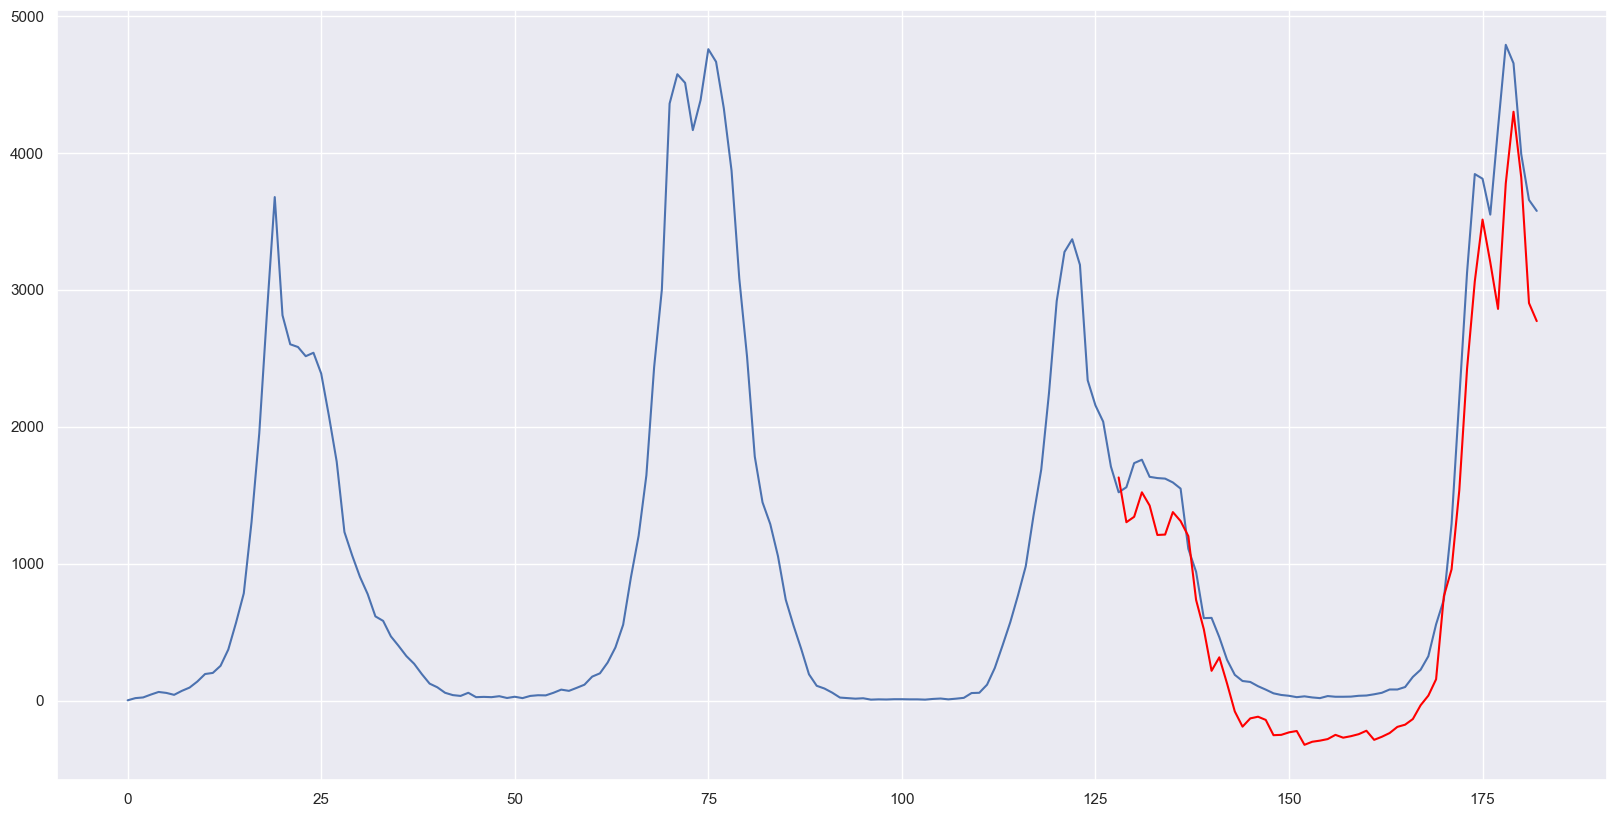

In [15]:
# predict for train and test sets
preds_test = model.predict(test_X)
preds_train = model.predict(train_X)

# plot
plt.plot(df_time_features_pre_COVID.index, df_time_features_pre_COVID['y1'].values)
plt.plot(df_time_features_pre_COVID.index[train_size:], preds_test_df['y1'], color='red')

In [16]:
MSE_train = round(mean_squared_error(train_y, preds_train),3)
RMSE_train = round(mean_squared_error(train_y, preds_train, squared=False),3)
MAE_train = round(mean_absolute_error(train_y, preds_train),3)

print(f'MSE_train: {MSE_train}')
print(f'RMSE_train: {RMSE_train}')
print(f'MAE_train: {MAE_train}')

MSE_test = round(mean_squared_error(test_y, preds_test),3)
RMSE_test = round(mean_squared_error(test_y, preds_test, squared=False),3)
MAE_test = round(mean_absolute_error(test_y, preds_test),3)

print(f'MSE_test: {MSE_test}')
print(f'RMSE_test: {RMSE_test}')
print(f'MAE_test: {MAE_test}')


MSE_train: 79332.513
RMSE_train: 274.22
MAE_train: 174.413
MSE_test: 769936.619
RMSE_test: 838.041
MAE_test: 736.928


# Decision Tree Regression

In [17]:
model = DecisionTreeRegressor()

model.fit(train_X, train_y)

DecisionTreeRegressor()

In [18]:
preds_test = model.predict(test_X)
preds_test_df = pd.DataFrame(preds_test,columns=test_y.columns)

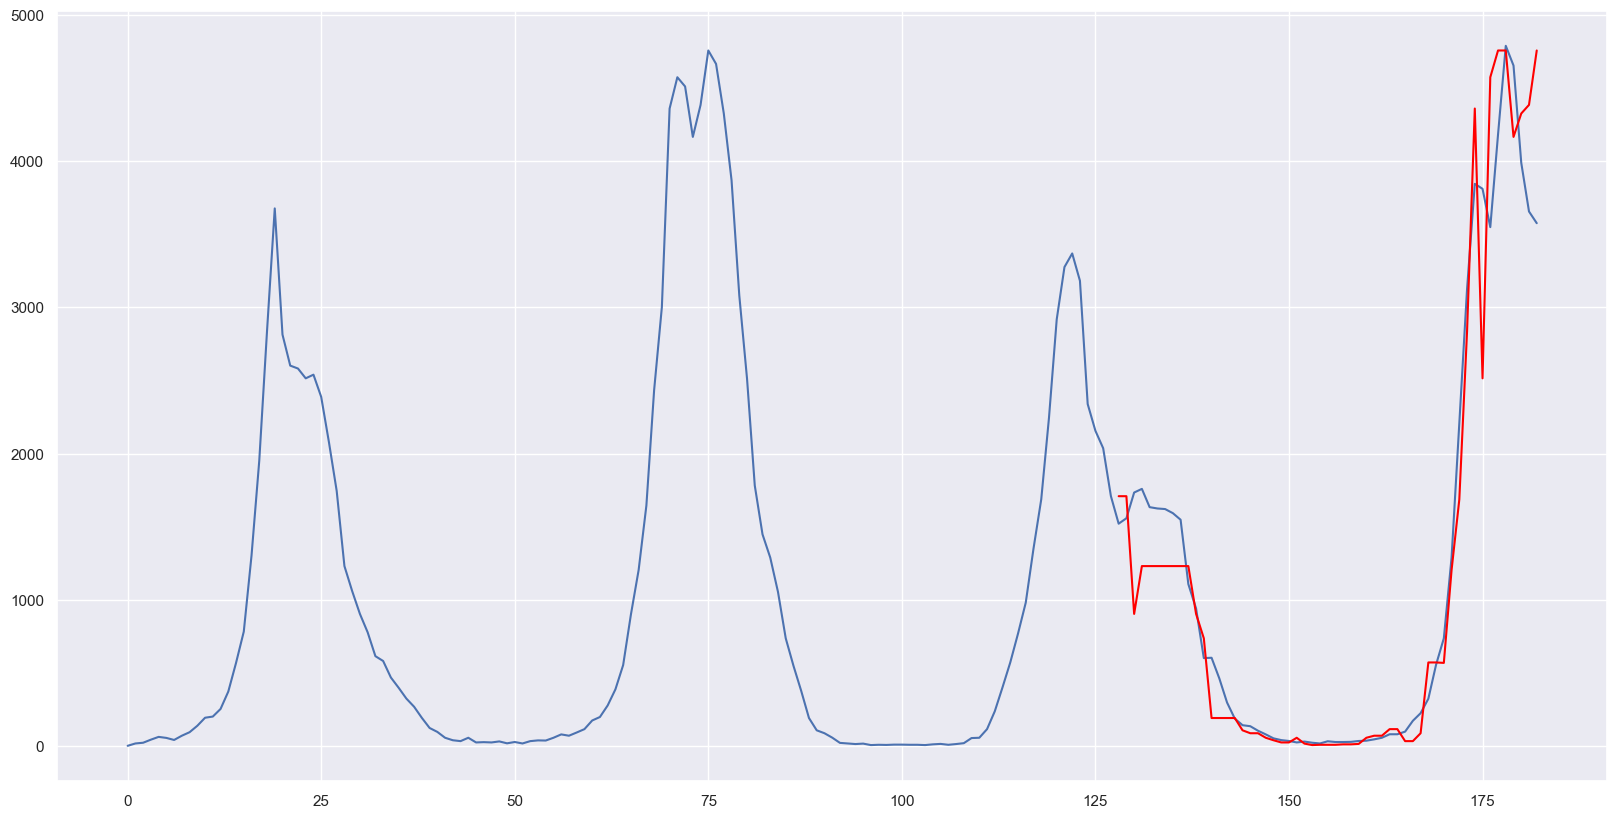

In [19]:
# predict for train and test sets
preds_test = model.predict(test_X)
preds_train = model.predict(train_X)

# plot
plt.plot(df_time_features_pre_COVID.index, df_time_features_pre_COVID['y1'].values)
plt.plot(df_time_features_pre_COVID.index[train_size:], preds_test_df['y1'], color='red')

In [20]:
preds_test_df.head()

y1      y2      y3      y4
0  1709.0  1521.0  1558.0  1734.0
1  1709.0  1521.0  1558.0  1734.0
2   904.0   778.0   615.0   582.0
3  1231.0  1060.0   904.0   778.0
4  1231.0  1060.0   904.0   778.0

In [21]:
test_y.head()

y1      y2      y3      y4
128  1521.0  1558.0  1734.0  1759.0
129  1558.0  1734.0  1759.0  1634.0
130  1734.0  1759.0  1634.0  1625.0
131  1759.0  1634.0  1625.0  1621.0
132  1634.0  1625.0  1621.0  1593.0

In [22]:
# define the evaluation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=2022)
# evaluate the model and collect the scores
n_scores = cross_val_score(model, train_X, train_y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
# force the scores to be positive
n_scores = absolute(n_scores)
# summarize performance
print('RMSE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

RMSE: 391.828 (156.694)


In [23]:
MSE_train = round(mean_squared_error(train_y, preds_train),3)
RMSE_train = round(mean_squared_error(train_y, preds_train, squared=False),3)
MAE_train = round(mean_absolute_error(train_y, preds_train),3)

print(f'MSE_train: {MSE_train}')
print(f'RMSE_train: {RMSE_train}')
print(f'MAE_train: {MAE_train}')

MSE_test = round(mean_squared_error(test_y, preds_test),3)
RMSE_test = round(mean_squared_error(test_y, preds_test, squared=False),3)
MAE_test = round(mean_absolute_error(test_y, preds_test),3)

print(f'MSE_test: {MSE_test}')
print(f'RMSE_test: {RMSE_test}')
print(f'MAE_test: {MAE_test}')


MSE_train: 0.0
RMSE_train: 0.0
MAE_train: 0.0
MSE_test: 267585.768
RMSE_test: 504.147
MAE_test: 307.086


# K-Nearest Neighbours Regression

In [24]:
model = KNeighborsRegressor()

model.fit(train_X, train_y)

KNeighborsRegressor()

In [25]:
preds_test = model.predict(test_X)
preds_test_df = pd.DataFrame(preds_test,columns=test_y.columns)

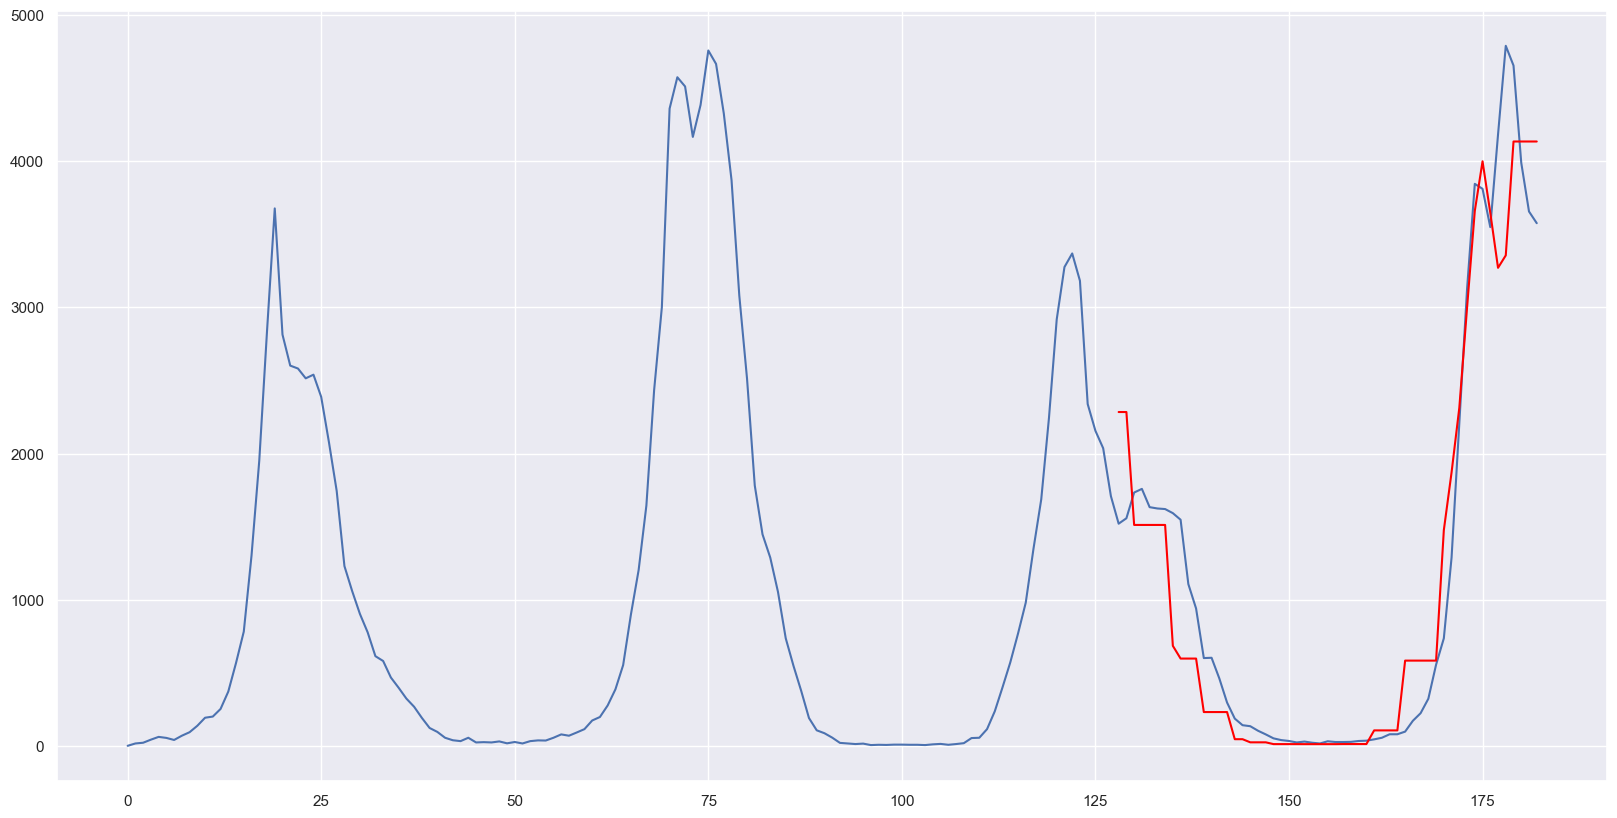

In [26]:
# predict for train and test sets
preds_test = model.predict(test_X)
preds_train = model.predict(train_X)

# plot
plt.plot(df_time_features_pre_COVID.index, df_time_features_pre_COVID['y1'].values)
plt.plot(df_time_features_pre_COVID.index[train_size:], preds_test_df['y1'], color='red')

In [27]:
preds_test_df.head()

y1      y2      y3      y4
0  2284.6  1952.4  1796.2  1711.8
1  2284.6  1952.4  1796.2  1711.8
2  1512.4  1245.8  1005.4   818.8
3  1512.4  1245.8  1005.4   818.8
4  1512.4  1245.8  1005.4   818.8

In [28]:
test_y.head()

y1      y2      y3      y4
128  1521.0  1558.0  1734.0  1759.0
129  1558.0  1734.0  1759.0  1634.0
130  1734.0  1759.0  1634.0  1625.0
131  1759.0  1634.0  1625.0  1621.0
132  1634.0  1625.0  1621.0  1593.0

In [29]:
# define the evaluation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=2022)
# evaluate the model and collect the scores
n_scores = cross_val_score(model, train_X, train_y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
# force the scores to be positive
n_scores = absolute(n_scores)
# summarize performance
print('RMSE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

RMSE: 419.816 (138.894)


In [30]:
MSE_train = round(mean_squared_error(train_y, preds_train),3)
RMSE_train = round(mean_squared_error(train_y, preds_train, squared=False),3)
MAE_train = round(mean_absolute_error(train_y, preds_train),3)

print(f'MSE_train: {MSE_train}')
print(f'RMSE_train: {RMSE_train}')
print(f'MAE_train: {MAE_train}')

MSE_test = round(mean_squared_error(test_y, preds_test),3)
RMSE_test = round(mean_squared_error(test_y, preds_test, squared=False),3)
MAE_test = round(mean_absolute_error(test_y, preds_test),3)

print(f'MSE_test: {MSE_test}')
print(f'RMSE_test: {RMSE_test}')
print(f'MAE_test: {MAE_test}')


MSE_train: 128865.113
RMSE_train: 358.504
MAE_train: 198.517
MSE_test: 234851.256
RMSE_test: 481.348
MAE_test: 314.26


# Random Forest Regression - All Time Features

In [165]:
results_matrix = pd.DataFrame(columns=['Dataset','Weeks-ahead Forecast','MSE_train','MSE_test','RMSE_train','RMSE_test','MAE_train','MAE_test','R2_train','R2_test'])

pickle.dump(results_matrix, open(r"..\data\results_matrix_RF.pkl", "wb" ))

In [166]:
df_time_features_pre_COVID = pickle.load(open(r"..\data\flu_cases\df_time_features_pre_COVID.pkl", "rb" ))
df_time_features = pickle.load(open(r"..\data\flu_cases\df_time_features.pkl", "rb" ))

df_COVID_terms_pre_COVID = pickle.load(open(r"..\data\google_trend\df_COVID_terms_pre_COVID.pkl", "rb" ))
df_COVID_terms = pickle.load(open(r"..\data\google_trend\df_COVID_terms.pkl", "rb" ))

In [167]:
df_time_features_pre_COVID.shape

(235, 35)

In [168]:
df_time_features_pre_COVID.columns

Index(['y1', 'y2', 'y3', 'y4', 't - 1', 't - 2', 't - 3', 't - 4', 't - 5',
       't - 6', 't - 7', 'this week last year', 'two-week moving average',
       'expanding mean', 'year_2016', 'year_2017', 'year_2018', 'year_2019',
       'year_2020', 'year_2021', 'year_2022', 'month_10', 'month_11',
       'month_12', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'season_Spring', 'season_Summer',
       'season_Winter'],
      dtype='object')

In [169]:
df = pd.concat([df_time_features_pre_COVID, df_COVID_terms_pre_COVID], axis=1)

In [170]:
df

y1      y2      y3      y4   t - 1   t - 2   t - 3   t - 4   t - 5  \
0       9.0    18.0    15.0    29.0     NaN     NaN     NaN     NaN     NaN   
1      18.0    15.0    29.0    59.0     9.0     NaN     NaN     NaN     NaN   
2      15.0    29.0    59.0    50.0    18.0     9.0     NaN     NaN     NaN   
3      29.0    59.0    50.0    37.0    15.0    18.0     9.0     NaN     NaN   
4      59.0    50.0    37.0    26.0    29.0    15.0    18.0     9.0     NaN   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
230  4789.0  4654.0  3989.0  3656.0  4182.0  3549.0  3811.0  3845.0  3126.0   
231  4654.0  3989.0  3656.0  3576.0  4789.0  4182.0  3549.0  3811.0  3845.0   
232  3989.0  3656.0  3576.0  3404.0  4654.0  4789.0  4182.0  3549.0  3811.0   
233  3656.0  3576.0  3404.0  2991.0  3989.0  4654.0  4789.0  4182.0  3549.0   
234  3576.0  3404.0  2991.0  1619.0  3656.0  3989.0  4654.0  4789.0  4182.0   

      t - 6  ...  month  year  week  coronavirus  COVID  lockdown  mask  \
0       NaN  ...      9  2015    36          0.5    0.0         2    12   
1       NaN  ...      9  2015    37          0.5    0.0         2    12   
2       NaN  ...      9  2015    38          0.5    0.0         2    12   
3       NaN  ...      9  2015    39          0.5    0.0         2    12   
4       NaN  ...     10  2015    40          0.5    0.0         3    18   
..      ...  ...    ...   ...   ...          ...    ...       ...   ...   
230  2206.0  ...      2  2020     5         17.0    1.0         2    32   
231  3126.0  ...      2  2020     6         17.0    1.0         2    32   
232  3845.0  ...      2  2020     7         17.0    1.0         2    32   
233  3811.0  ...      2  2020     8         17.0    1.0         2    32   
234  3549.0  ...      2  2020     9         17.0    1.0         2    32   

     quarantine  social_distancing  vaccine  
0             1                0.0        1  
1             1                0.0        1  
2             1                0.0        1  
3             1                0.0        1  
4             1                0.5        1  
..          ...                ...      ...  
230           9                0.0        2  
231           9                0.0        2  
232           9                0.0        2  
233           9                0.0        2  
234           9                0.0        2  

[235 rows x 46 columns]

In [171]:
df_time_features_pre_COVID.dropna(inplace=True)
df_time_features_pre_COVID = df_time_features_pre_COVID.reset_index(drop=True)
df_time_features_pre_COVID

y1      y2      y3      y4   t - 1   t - 2   t - 3   t - 4   t - 5  \
0       2.0    18.0    23.0    44.0    13.0    13.0     8.0     9.0     7.0   
1      18.0    23.0    44.0    63.0     2.0    13.0    13.0     8.0     9.0   
2      23.0    44.0    63.0    56.0    18.0     2.0    13.0    13.0     8.0   
3      44.0    63.0    56.0    42.0    23.0    18.0     2.0    13.0    13.0   
4      63.0    56.0    42.0    71.0    44.0    23.0    18.0     2.0    13.0   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
178  4789.0  4654.0  3989.0  3656.0  4182.0  3549.0  3811.0  3845.0  3126.0   
179  4654.0  3989.0  3656.0  3576.0  4789.0  4182.0  3549.0  3811.0  3845.0   
180  3989.0  3656.0  3576.0  3404.0  4654.0  4789.0  4182.0  3549.0  3811.0   
181  3656.0  3576.0  3404.0  2991.0  3989.0  4654.0  4789.0  4182.0  3549.0   
182  3576.0  3404.0  2991.0  1619.0  3656.0  3989.0  4654.0  4789.0  4182.0   

      t - 6  ...  month_3  month_4  month_5  month_6  month_7  month_8  \
0      18.0  ...        0        0        0        0        0        0   
1       7.0  ...        0        0        0        0        0        0   
2       9.0  ...        0        0        0        0        0        0   
3       8.0  ...        0        0        0        0        0        0   
4      13.0  ...        0        0        0        0        0        0   
..      ...  ...      ...      ...      ...      ...      ...      ...   
178  2206.0  ...        0        0        0        0        0        0   
179  3126.0  ...        0        0        0        0        0        0   
180  3845.0  ...        0        0        0        0        0        0   
181  3811.0  ...        0        0        0        0        0        0   
182  3549.0  ...        0        0        0        0        0        0   

     month_9  season_Spring  season_Summer  season_Winter  
0          1              0              0              0  
1          1              0              0              0  
2          1              0              0              0  
3          1              0              0              0  
4          0              0              0              0  
..       ...            ...            ...            ...  
178        0              0              0              1  
179        0              0              0              1  
180        0              0              0              1  
181        0              0              0              1  
182        0              0              0              1  

[183 rows x 35 columns]

In [172]:
df_time_features_pre_COVID.columns

Index(['y1', 'y2', 'y3', 'y4', 't - 1', 't - 2', 't - 3', 't - 4', 't - 5',
       't - 6', 't - 7', 'this week last year', 'two-week moving average',
       'expanding mean', 'year_2016', 'year_2017', 'year_2018', 'year_2019',
       'year_2020', 'year_2021', 'year_2022', 'month_10', 'month_11',
       'month_12', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'season_Spring', 'season_Summer',
       'season_Winter'],
      dtype='object')

In [173]:
train_size = int(len(df_time_features_pre_COVID) *.7)
test_size = len(df_time_features_pre_COVID) - train_size
train, test = df_time_features_pre_COVID[0:train_size], df_time_features_pre_COVID[train_size:len(df_time_features_pre_COVID)]

In [174]:
train_y = train[['y1','y2','y3','y4']]
train_X = train.drop(columns=['y1','y2','y3','y4'])
test_y = test[['y1','y2','y3','y4']]
test_X = test.drop(columns=['y1','y2','y3','y4'])

In [175]:
features = train_X.columns

In [176]:
train_X_to_scale = train_X.loc[:,'t - 1':'expanding mean']
test_X_to_scale = test_X.loc[:,'t - 1':'expanding mean']
train_X_not_to_scale = train_X.loc[:,'year_2016':].to_numpy()
test_X_not_to_scale = test_X.loc[:,'year_2016':].to_numpy()

In [177]:
from sklearn.preprocessing import MinMaxScaler

# scale data
scaler = MinMaxScaler()
train_X_to_scale = scaler.fit_transform(train_X_to_scale)
test_X_to_scale = scaler.transform(test_X_to_scale)

In [178]:
train_X = np.concatenate((train_X_to_scale, train_X_not_to_scale),axis=1)
test_X = np.concatenate((test_X_to_scale, test_X_not_to_scale),axis=1)

In [179]:
model = RandomForestRegressor()

model.fit(train_X, train_y)

RandomForestRegressor()

In [180]:
preds_test = model.predict(test_X)
preds_test_df = pd.DataFrame(preds_test,columns=test_y.columns)
preds_train = model.predict(train_X)
preds_train_df = pd.DataFrame(preds_train,columns=train_y.columns)

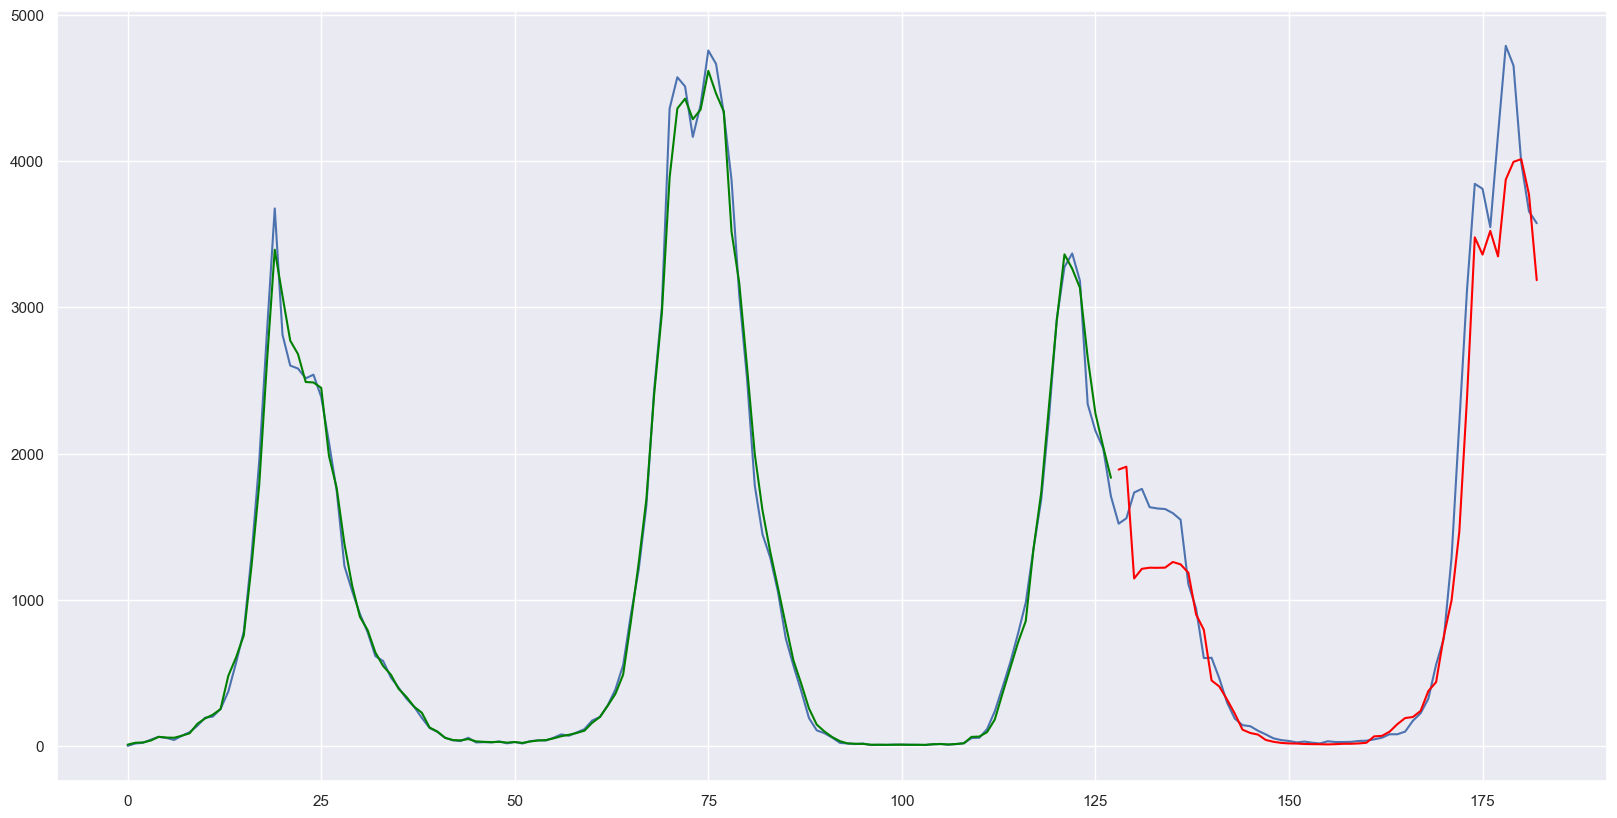

In [181]:
# plot
plt.plot(df_time_features_pre_COVID.index, df_time_features_pre_COVID['y1'].values)
plt.plot(df_time_features_pre_COVID.index[:train_size], preds_train_df['y1'], color='green')
plt.plot(df_time_features_pre_COVID.index[train_size:], preds_test_df['y1'], color='red')

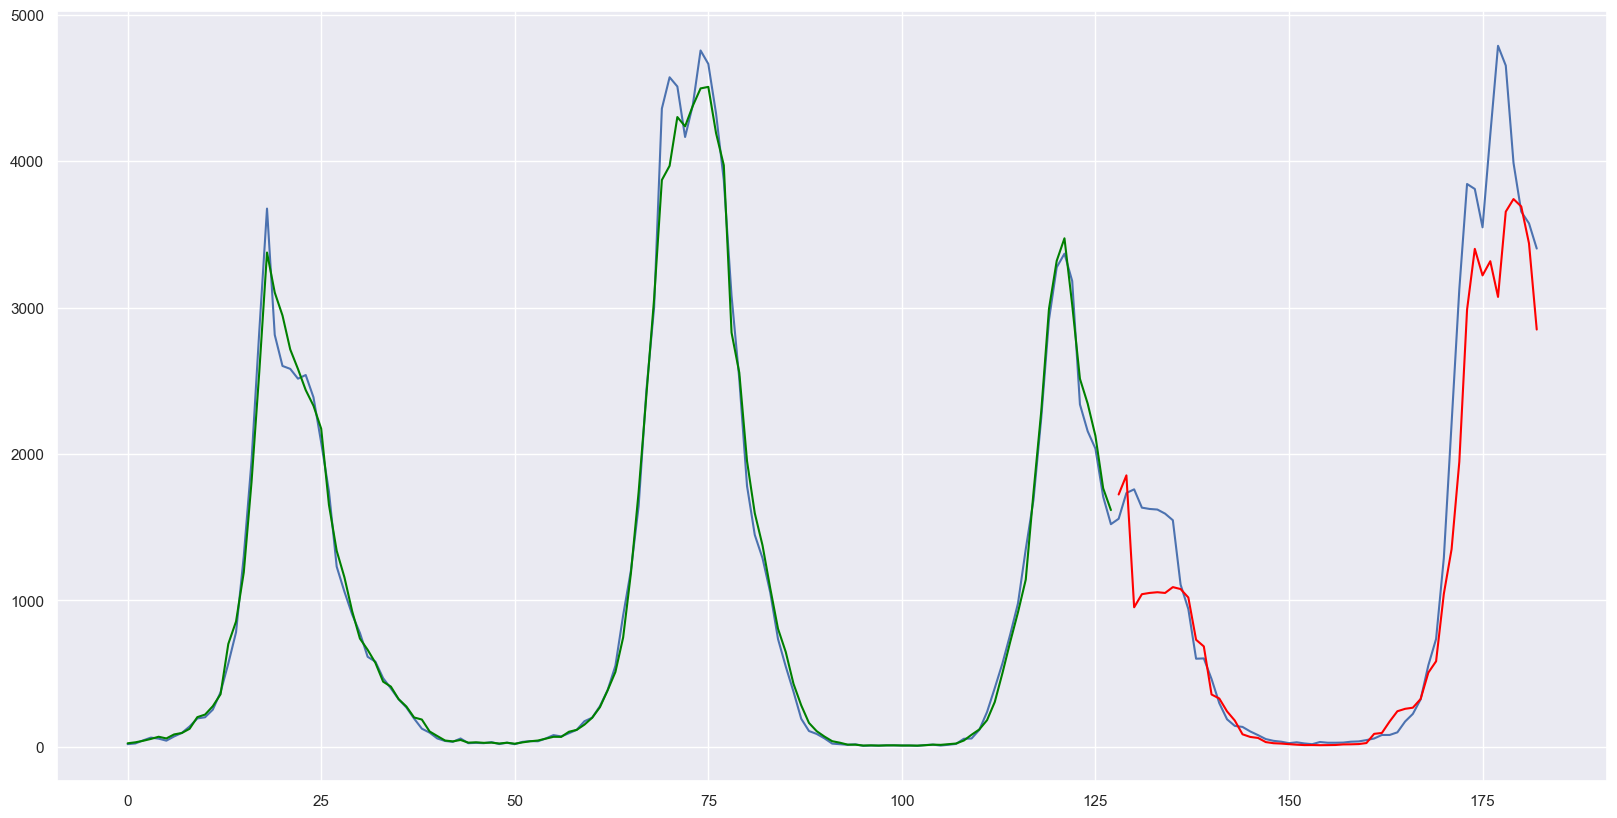

In [182]:
# plot 2-week ahead prediction
plt.plot(df_time_features_pre_COVID.index, df_time_features_pre_COVID['y2'].values)
plt.plot(df_time_features_pre_COVID.index[:train_size], preds_train_df['y2'], color='green')
plt.plot(df_time_features_pre_COVID.index[train_size:], preds_test_df['y2'], color='red')

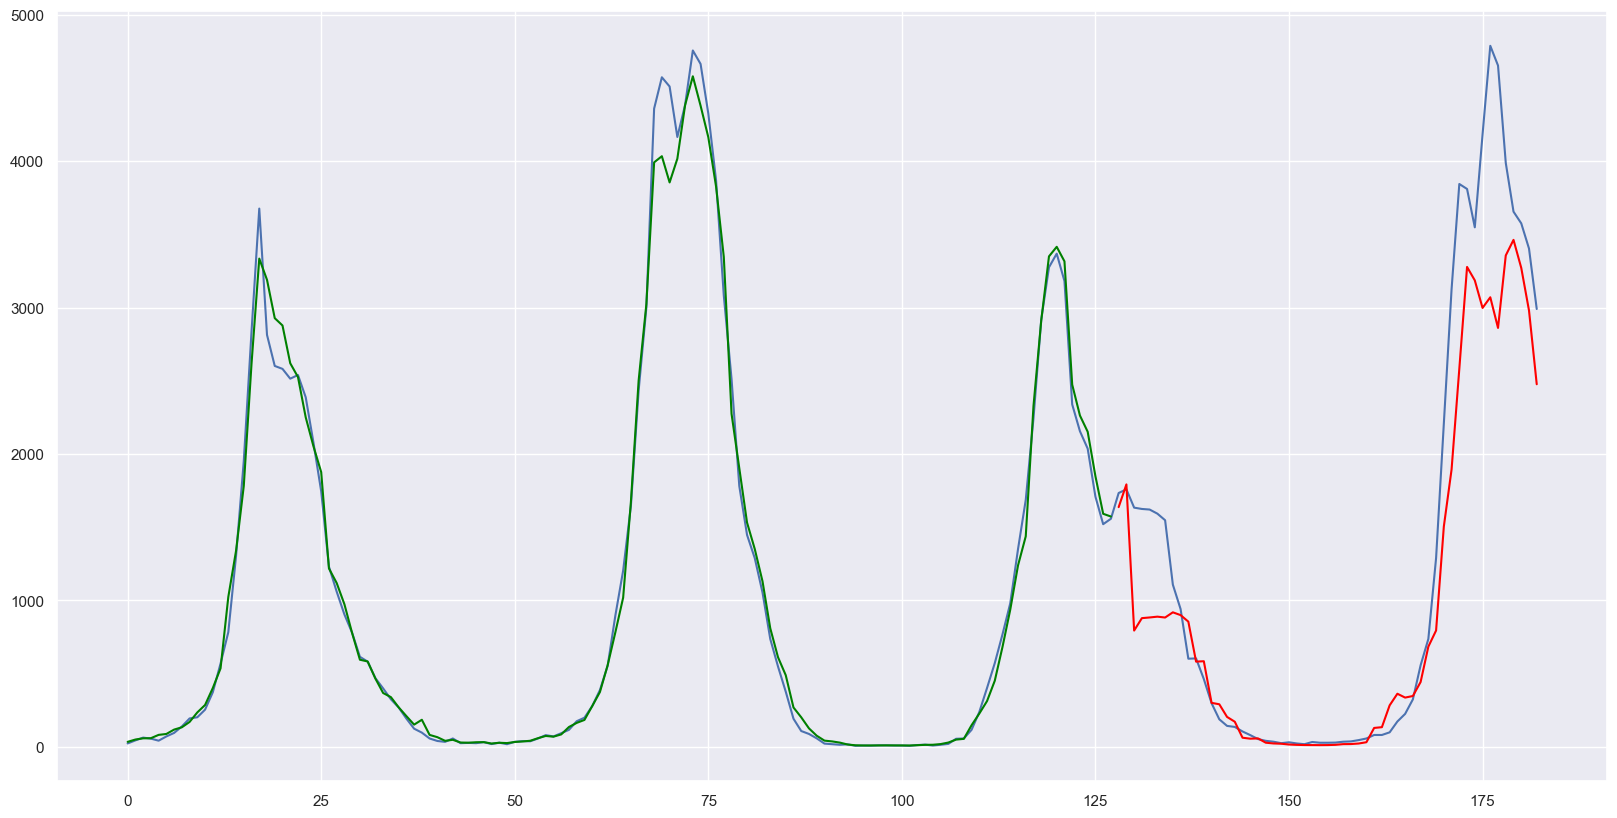

In [183]:
# plot 3-week ahead prediction
plt.plot(df_time_features_pre_COVID.index, df_time_features_pre_COVID['y3'].values)
plt.plot(df_time_features_pre_COVID.index[:train_size], preds_train_df['y3'], color='green')
plt.plot(df_time_features_pre_COVID.index[train_size:], preds_test_df['y3'], color='red')

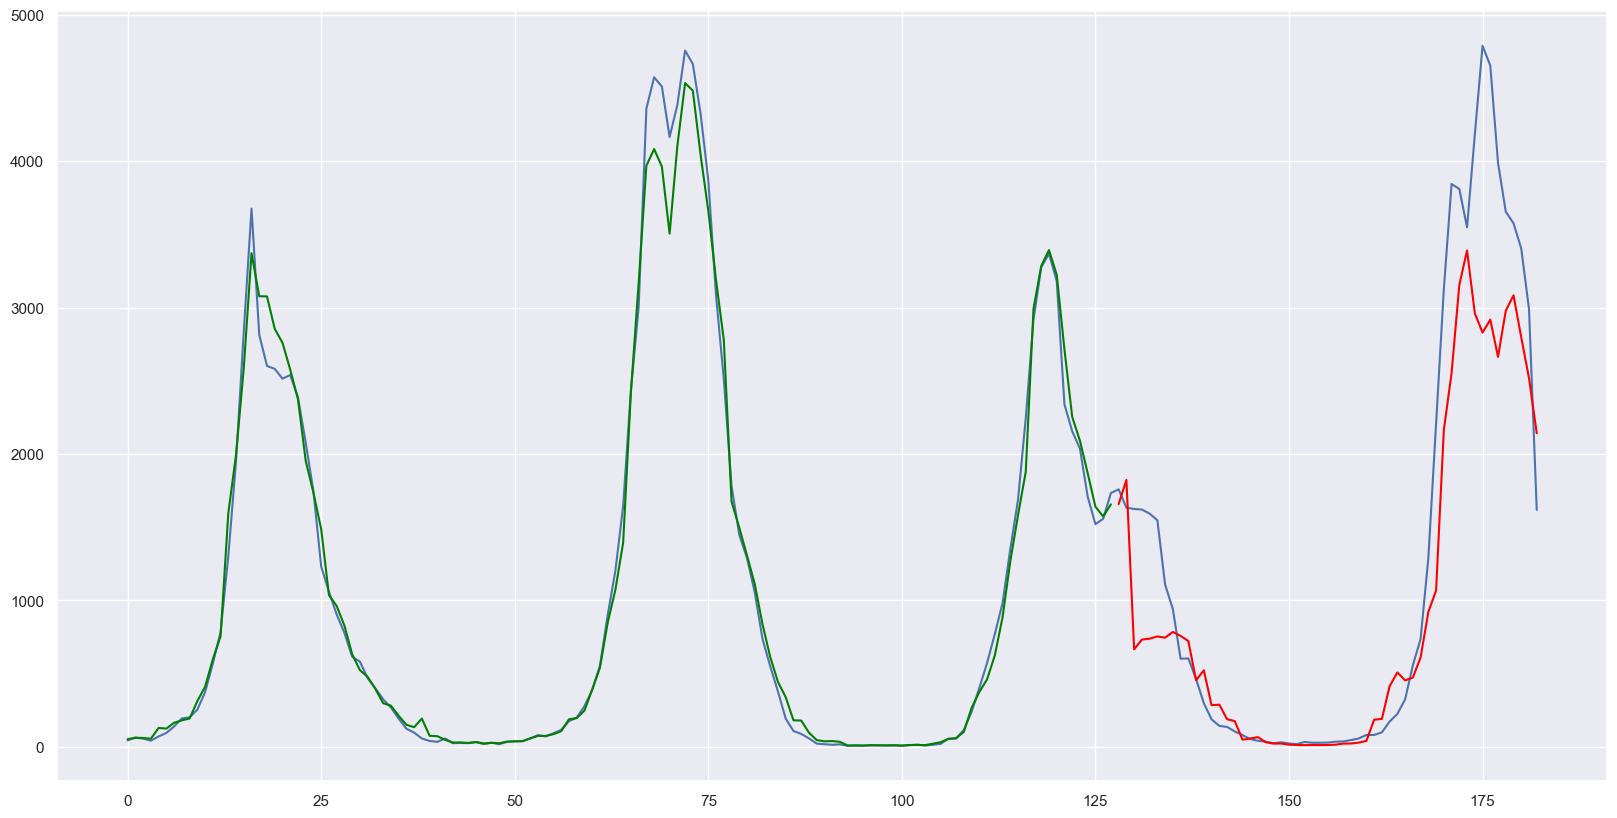

In [184]:
# plot 4-week ahead prediction
plt.plot(df_time_features_pre_COVID.index, df_time_features_pre_COVID['y4'].values)
plt.plot(df_time_features_pre_COVID.index[:train_size], preds_train_df['y4'], color='green')
plt.plot(df_time_features_pre_COVID.index[train_size:], preds_test_df['y4'], color='red')

In [185]:
# define the evaluation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=2022)
# evaluate the model and collect the scores
n_scores = cross_val_score(model, train_X, train_y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
# force the scores to be positive
n_scores = absolute(n_scores)
# summarize performance
print('RMSE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

RMSE: 319.973 (113.667)


In [186]:
# evaluate all four weeks of predictions

MSE_train = round(mean_squared_error(train_y, preds_train),3)
RMSE_train = round(mean_squared_error(train_y, preds_train, squared=False),3)
MAE_train = round(mean_absolute_error(train_y, preds_train),3)
print(f'MSE_train: {MSE_train}')
print(f'RMSE_train: {RMSE_train}')
print(f'MAE_train: {MAE_train}')

MSE_test = round(mean_squared_error(test_y, preds_test),3)
RMSE_test = round(mean_squared_error(test_y, preds_test, squared=False),3)
MAE_test = round(mean_absolute_error(test_y, preds_test),3)
print(f'MSE_test: {MSE_test}')
print(f'RMSE_test: {RMSE_test}')
print(f'MAE_test: {MAE_test}')


MSE_train: 15262.893
RMSE_train: 121.77
MAE_train: 67.333
MSE_test: 234005.825
RMSE_test: 471.489
MAE_test: 279.588


In [187]:
# evaluate 1-week ahead prediction only

MSE_train = round(mean_squared_error(train_y['y1'], preds_train_df['y1']),3)
RMSE_train = round(mean_squared_error(train_y['y1'], preds_train_df['y1'], squared=False),3)
MAE_train = round(mean_absolute_error(train_y['y1'], preds_train_df['y1']),3)
print(f'MSE_train: {MSE_train}')
print(f'RMSE_train: {RMSE_train}')
print(f'MAE_train: {MAE_train}')

MSE_test = round(mean_squared_error(test_y['y1'], preds_test_df['y1']),3)
RMSE_test = round(mean_squared_error(test_y['y1'], preds_test_df['y1'], squared=False),3)
MAE_test = round(mean_absolute_error(test_y['y1'], preds_test_df['y1']),3)
print(f'MSE_test: {MSE_test}')
print(f'RMSE_test: {RMSE_test}')
print(f'MAE_test: {MAE_test}')


MSE_train: 8645.656
RMSE_train: 92.982
MAE_train: 50.029
MSE_test: 97600.058
RMSE_test: 312.41
MAE_test: 193.033


In [188]:
# evaluate 2-week ahead prediction only

MSE_train = round(mean_squared_error(train_y['y2'], preds_train_df['y2']),3)
RMSE_train = round(mean_squared_error(train_y['y2'], preds_train_df['y2'], squared=False),3)
MAE_train = round(mean_absolute_error(train_y['y2'], preds_train_df['y2']),3)
print(f'MSE_train: {MSE_train}')
print(f'RMSE_train: {RMSE_train}')
print(f'MAE_train: {MAE_train}')

MSE_test = round(mean_squared_error(test_y['y2'], preds_test_df['y2']),3)
RMSE_test = round(mean_squared_error(test_y['y2'], preds_test_df['y2'], squared=False),3)
MAE_test = round(mean_absolute_error(test_y['y2'], preds_test_df['y2']),3)
print(f'MSE_test: {MSE_test}')
print(f'RMSE_test: {RMSE_test}')
print(f'MAE_test: {MAE_test}')


MSE_train: 13142.619
RMSE_train: 114.641
MAE_train: 64.112
MSE_test: 192354.668
RMSE_test: 438.583
MAE_test: 249.635


In [189]:
# evaluate 3-week ahead prediction only

MSE_train = round(mean_squared_error(train_y['y3'], preds_train_df['y3']),3)
RMSE_train = round(mean_squared_error(train_y['y3'], preds_train_df['y3'], squared=False),3)
MAE_train = round(mean_absolute_error(train_y['y3'], preds_train_df['y3']),3)
print(f'MSE_train: {MSE_train}')
print(f'RMSE_train: {RMSE_train}')
print(f'MAE_train: {MAE_train}')

MSE_test = round(mean_squared_error(test_y['y3'], preds_test_df['y3']),3)
RMSE_test = round(mean_squared_error(test_y['y3'], preds_test_df['y3'], squared=False),3)
MAE_test = round(mean_absolute_error(test_y['y3'], preds_test_df['y3']),3)
print(f'MSE_test: {MSE_test}')
print(f'RMSE_test: {RMSE_test}')
print(f'MAE_test: {MAE_test}')


MSE_train: 16733.415
RMSE_train: 129.358
MAE_train: 70.984
MSE_test: 287159.051
RMSE_test: 535.872
MAE_test: 310.104


In [190]:
# evaluate 4-week ahead prediction only

MSE_train = round(mean_squared_error(train_y['y4'], preds_train_df['y4']),4)
RMSE_train = round(mean_squared_error(train_y['y4'], preds_train_df['y4'], squared=False),4)
MAE_train = round(mean_absolute_error(train_y['y4'], preds_train_df['y4']),4)
print(f'MSE_train: {MSE_train}')
print(f'RMSE_train: {RMSE_train}')
print(f'MAE_train: {MAE_train}')

MSE_test = round(mean_squared_error(test_y['y4'], preds_test_df['y4']),4)
RMSE_test = round(mean_squared_error(test_y['y4'], preds_test_df['y4'], squared=False),4)
MAE_test = round(mean_absolute_error(test_y['y4'], preds_test_df['y4']),4)
print(f'MSE_test: {MSE_test}')
print(f'RMSE_test: {RMSE_test}')
print(f'MAE_test: {MAE_test}')

MSE_train: 22529.8804
RMSE_train: 150.0996
MAE_train: 84.2063
MSE_test: 358909.5233
RMSE_test: 599.0906
MAE_test: 365.5796


In [191]:
model.feature_importances_

array([3.36209897e-01, 2.64501575e-02, 2.42509077e-02, 1.40648908e-02,
       9.87766328e-03, 1.57199365e-02, 2.61487427e-02, 1.00761831e-02,
       3.64440676e-02, 1.21151078e-02, 6.47379466e-05, 2.37066177e-03,
       7.15471543e-03, 9.95987850e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 6.72744196e-04, 5.64370495e-03, 6.31092133e-03,
       6.17270006e-04, 4.56734961e-04, 1.25856546e-03, 2.08403346e-04,
       1.69091079e-06, 8.27863190e-08, 4.60286766e-08, 3.85287869e-06,
       2.72683646e-03, 6.41882305e-06, 4.60149071e-01])

Feature: 0, Score: 0.33621
Feature: 1, Score: 0.02645
Feature: 2, Score: 0.02425
Feature: 3, Score: 0.01406
Feature: 4, Score: 0.00988
Feature: 5, Score: 0.01572
Feature: 6, Score: 0.02615
Feature: 7, Score: 0.01008
Feature: 8, Score: 0.03644
Feature: 9, Score: 0.01212
Feature: 10, Score: 0.00006
Feature: 11, Score: 0.00237
Feature: 12, Score: 0.00715
Feature: 13, Score: 0.00100
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00067
Feature: 18, Score: 0.00564
Feature: 19, Score: 0.00631
Feature: 20, Score: 0.00062
Feature: 21, Score: 0.00046
Feature: 22, Score: 0.00126
Feature: 23, Score: 0.00021
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00000
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.00273
Feature: 29, Score: 0.00001
Feature: 30, Score: 0.46015


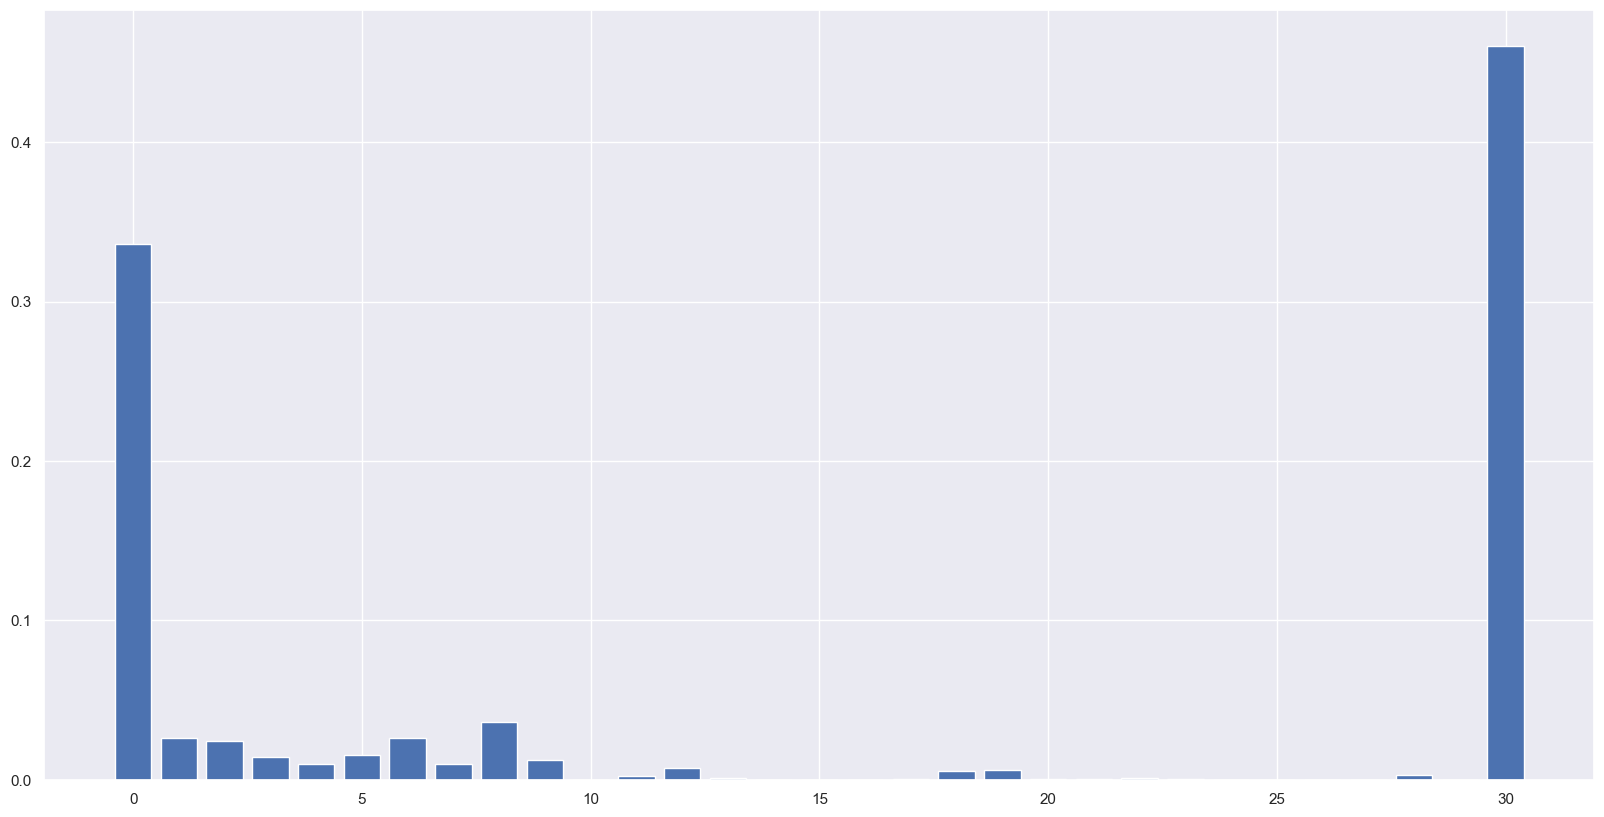

In [192]:
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [193]:
features

Index(['t - 1', 't - 2', 't - 3', 't - 4', 't - 5', 't - 6', 't - 7',
       'this week last year', 'two-week moving average', 'expanding mean',
       'year_2016', 'year_2017', 'year_2018', 'year_2019', 'year_2020',
       'year_2021', 'year_2022', 'month_10', 'month_11', 'month_12', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'season_Spring', 'season_Summer', 'season_Winter'],
      dtype='object')

In [194]:
# results_matrix = pd.DataFrame(columns=['Dataset','Weeks-ahead Forecast','MSE_train','MSE_test','RMSE_train','RMSE_test','MAE_train','MAE_test','R2_train','R2_test'])

# pickle.dump(results_matrix, open(r"..\data\results_matrix_RF.pkl", "wb" ))

In [196]:
for i in range(1,5):
    results_matrix = evaluate_model(train=train_y, test=test_y, preds_train=preds_train, preds_test=preds_test, dataset='Pre-COVID - (all time feats)', forecast_weeks=i)
results_matrix

Dataset Weeks-ahead Forecast MSE_train   MSE_test  \
0  Pre-COVID - (all time feats)                    1   8645.66   97600.06   
0  Pre-COVID - (all time feats)                    2  13142.62  192354.67   
0  Pre-COVID - (all time feats)                    3  16733.42  287159.05   
0  Pre-COVID - (all time feats)                    4  22529.88  358909.52   

  RMSE_train RMSE_test MAE_train MAE_test  R2_train   R2_test  
0      92.98    312.41     50.03   193.03  0.995238  0.952997  
0     114.64    438.58     64.11   249.64  0.992735  0.911083  
0     129.36    535.87     70.98    310.1  0.990716  0.870534  
0      150.1    599.09     84.21   365.58  0.987464  0.838051

# Random Forest Regression - Remove Year, Month

In [197]:
df_time_features_pre_COVID = pickle.load(open(r"..\data\flu_cases\df_time_features_pre_COVID.pkl", "rb" ))
df_time_features = pickle.load(open(r"..\data\flu_cases\df_time_features.pkl", "rb" ))

In [198]:
df_time_features_pre_COVID.head()

y1    y2    y3    y4  t - 1  t - 2  t - 3  t - 4  t - 5  t - 6  ...  \
0   9.0  18.0  15.0  29.0    NaN    NaN    NaN    NaN    NaN    NaN  ...   
1  18.0  15.0  29.0  59.0    9.0    NaN    NaN    NaN    NaN    NaN  ...   
2  15.0  29.0  59.0  50.0   18.0    9.0    NaN    NaN    NaN    NaN  ...   
3  29.0  59.0  50.0  37.0   15.0   18.0    9.0    NaN    NaN    NaN  ...   
4  59.0  50.0  37.0  26.0   29.0   15.0   18.0    9.0    NaN    NaN  ...   

   month_3  month_4  month_5  month_6  month_7  month_8  month_9  \
0        0        0        0        0        0        0        1   
1        0        0        0        0        0        0        1   
2        0        0        0        0        0        0        1   
3        0        0        0        0        0        0        1   
4        0        0        0        0        0        0        0   

   season_Spring  season_Summer  season_Winter  
0              0              0              0  
1              0              0              0  
2              0              0              0  
3              0              0              0  
4              0              0              0  

[5 rows x 35 columns]

In [199]:
df_time_features_pre_COVID.columns

Index(['y1', 'y2', 'y3', 'y4', 't - 1', 't - 2', 't - 3', 't - 4', 't - 5',
       't - 6', 't - 7', 'this week last year', 'two-week moving average',
       'expanding mean', 'year_2016', 'year_2017', 'year_2018', 'year_2019',
       'year_2020', 'year_2021', 'year_2022', 'month_10', 'month_11',
       'month_12', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'season_Spring', 'season_Summer',
       'season_Winter'],
      dtype='object')

In [200]:
df_time_features_pre_COVID.dropna(inplace=True)
df_time_features_pre_COVID = df_time_features_pre_COVID.reset_index(drop=True)
df_time_features_pre_COVID = df_time_features_pre_COVID.drop(columns=['year_2016', 'year_2017', 'year_2018', 'year_2019',
       'year_2020', 'year_2021', 'year_2022', 'month_10', 'month_11',
       'month_12', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9',])

In [201]:
df_time_features_pre_COVID.columns

Index(['y1', 'y2', 'y3', 'y4', 't - 1', 't - 2', 't - 3', 't - 4', 't - 5',
       't - 6', 't - 7', 'this week last year', 'two-week moving average',
       'expanding mean', 'season_Spring', 'season_Summer', 'season_Winter'],
      dtype='object')

In [202]:
train_size = int(len(df_time_features_pre_COVID) *.7)
test_size = len(df_time_features_pre_COVID) - train_size
train, test = df_time_features_pre_COVID[0:train_size], df_time_features_pre_COVID[train_size:len(df_time_features_pre_COVID)]

In [203]:
train_y = train[['y1','y2','y3','y4']]
train_X = train.drop(columns=['y1','y2','y3','y4'])
test_y = test[['y1','y2','y3','y4']]
test_X = test.drop(columns=['y1','y2','y3','y4'])

In [204]:
features = train_X.columns

In [205]:
train_X_to_scale = train_X.loc[:,'t - 1':'expanding mean']
test_X_to_scale = test_X.loc[:,'t - 1':'expanding mean']
train_X_not_to_scale = train_X.loc[:,'season_Spring':].to_numpy()
test_X_not_to_scale = test_X.loc[:,'season_Spring':].to_numpy()

In [206]:
from sklearn.preprocessing import MinMaxScaler

# scale data
scaler = MinMaxScaler()
train_X_to_scale = scaler.fit_transform(train_X_to_scale)
test_X_to_scale = scaler.transform(test_X_to_scale)

In [207]:
train_X = np.concatenate((train_X_to_scale, train_X_not_to_scale),axis=1)
test_X = np.concatenate((test_X_to_scale, test_X_not_to_scale),axis=1)

In [208]:
model = RandomForestRegressor()

model.fit(train_X, train_y)

RandomForestRegressor()

In [209]:
preds_test = model.predict(test_X)
preds_test_df = pd.DataFrame(preds_test,columns=test_y.columns)
preds_train = model.predict(train_X)
preds_train_df = pd.DataFrame(preds_train,columns=train_y.columns)

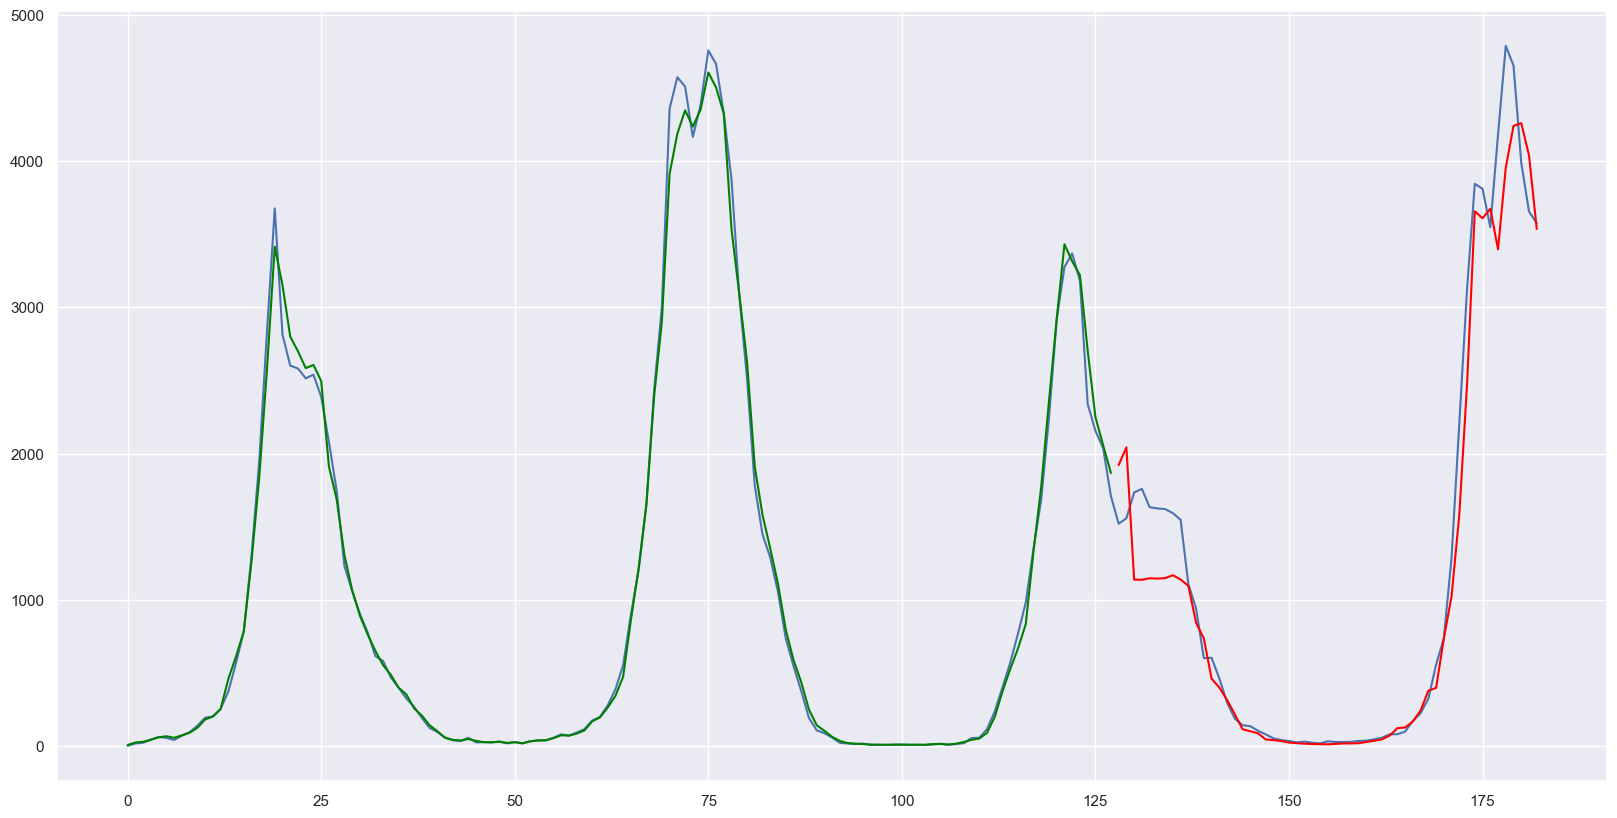

In [210]:
# plot
plt.plot(df_time_features_pre_COVID.index, df_time_features_pre_COVID['y1'].values)
plt.plot(df_time_features_pre_COVID.index[:train_size], preds_train_df['y1'], color='green')
plt.plot(df_time_features_pre_COVID.index[train_size:], preds_test_df['y1'], color='red')

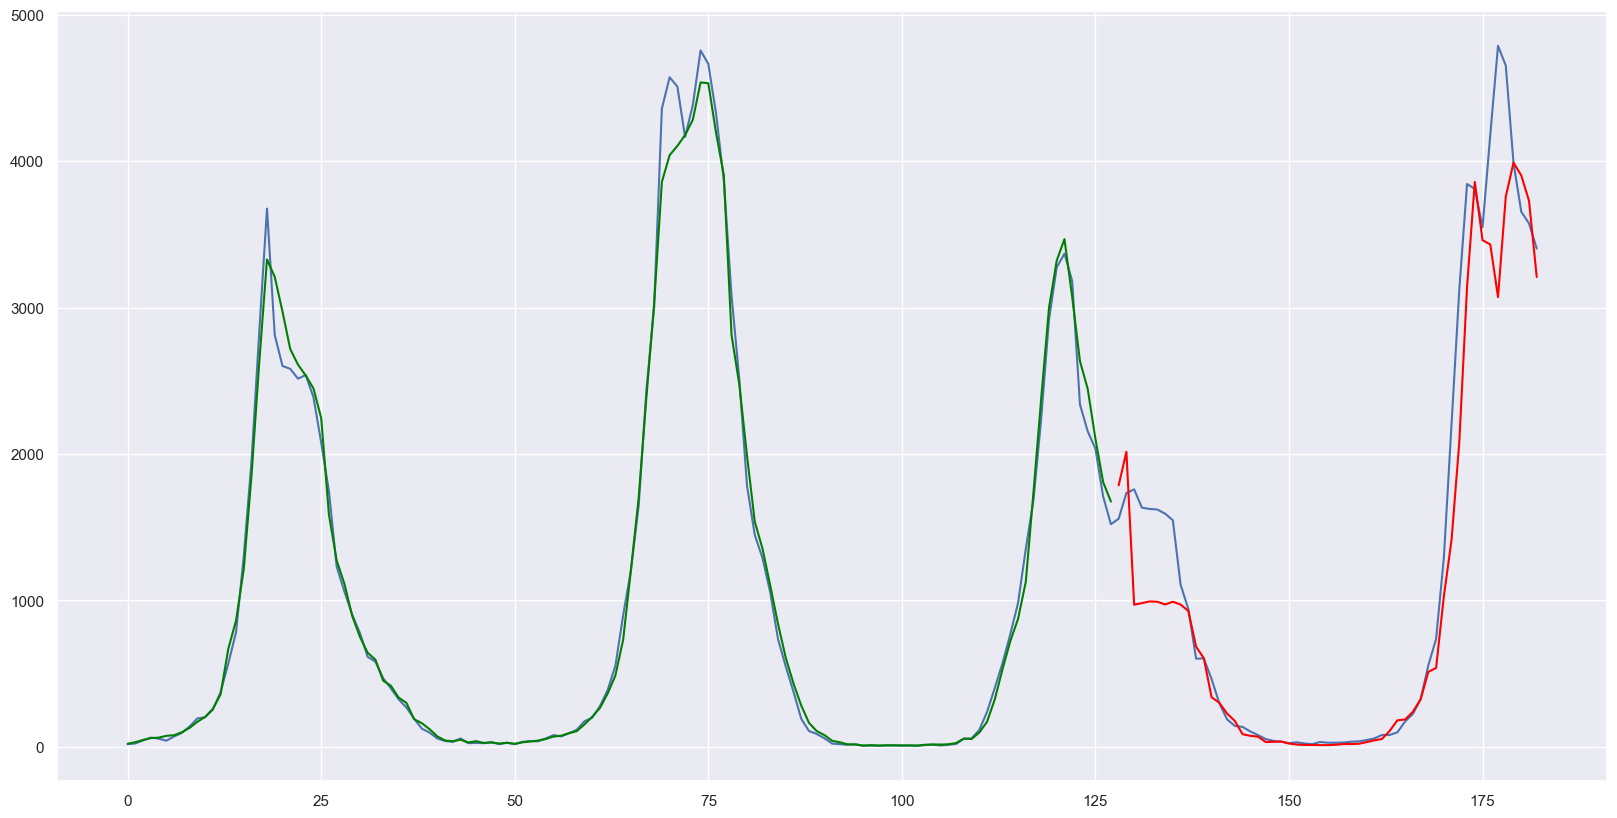

In [211]:
# plot 2-week ahead prediction
plt.plot(df_time_features_pre_COVID.index, df_time_features_pre_COVID['y2'].values)
plt.plot(df_time_features_pre_COVID.index[:train_size], preds_train_df['y2'], color='green')
plt.plot(df_time_features_pre_COVID.index[train_size:], preds_test_df['y2'], color='red')

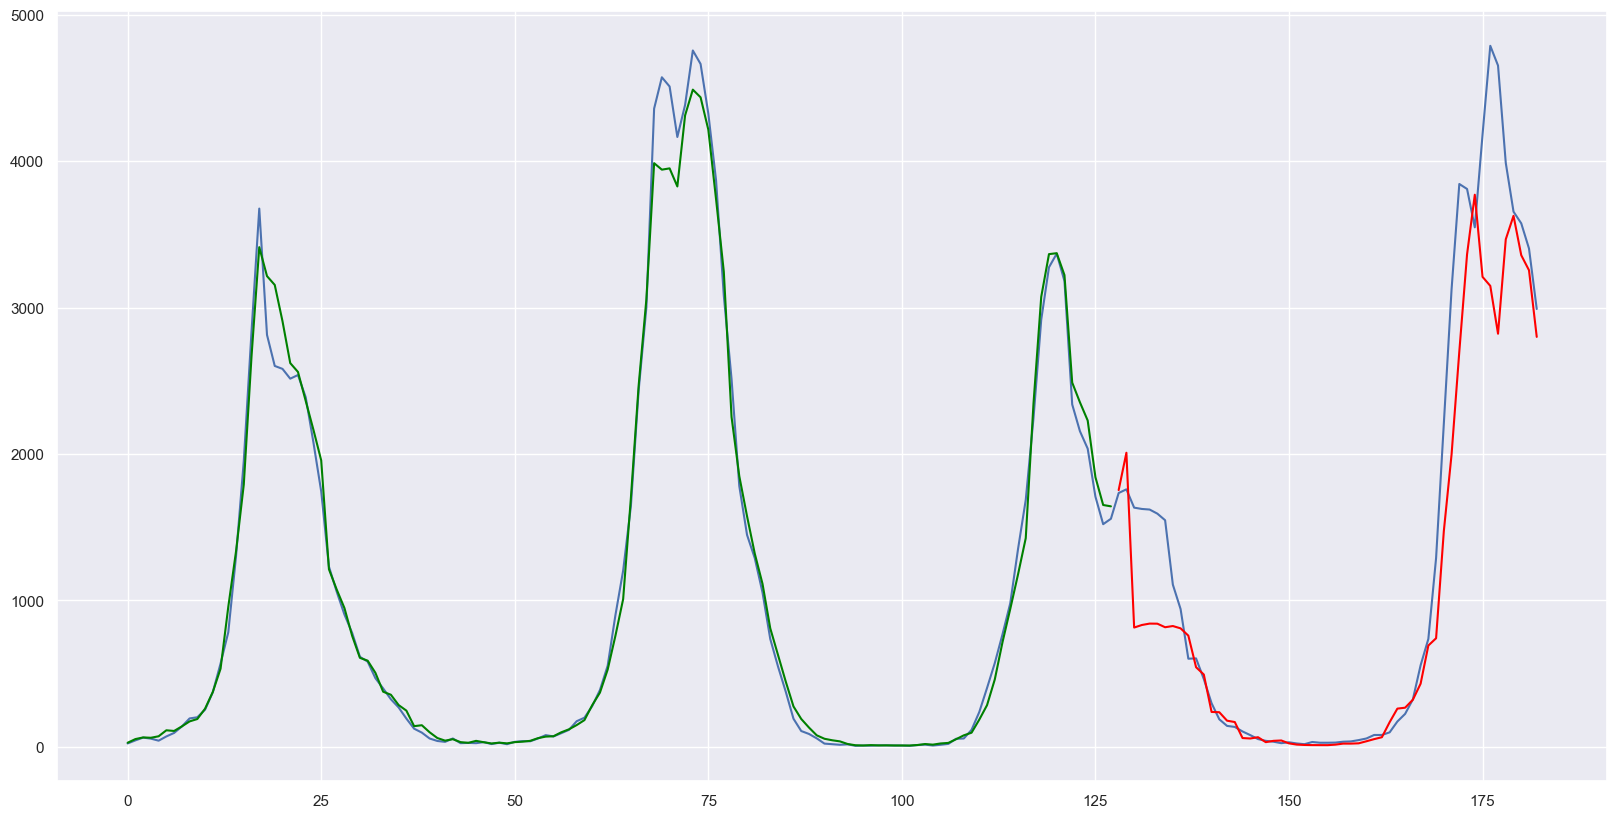

In [212]:
# plot 3-week ahead prediction
plt.plot(df_time_features_pre_COVID.index, df_time_features_pre_COVID['y3'].values)
plt.plot(df_time_features_pre_COVID.index[:train_size], preds_train_df['y3'], color='green')
plt.plot(df_time_features_pre_COVID.index[train_size:], preds_test_df['y3'], color='red')

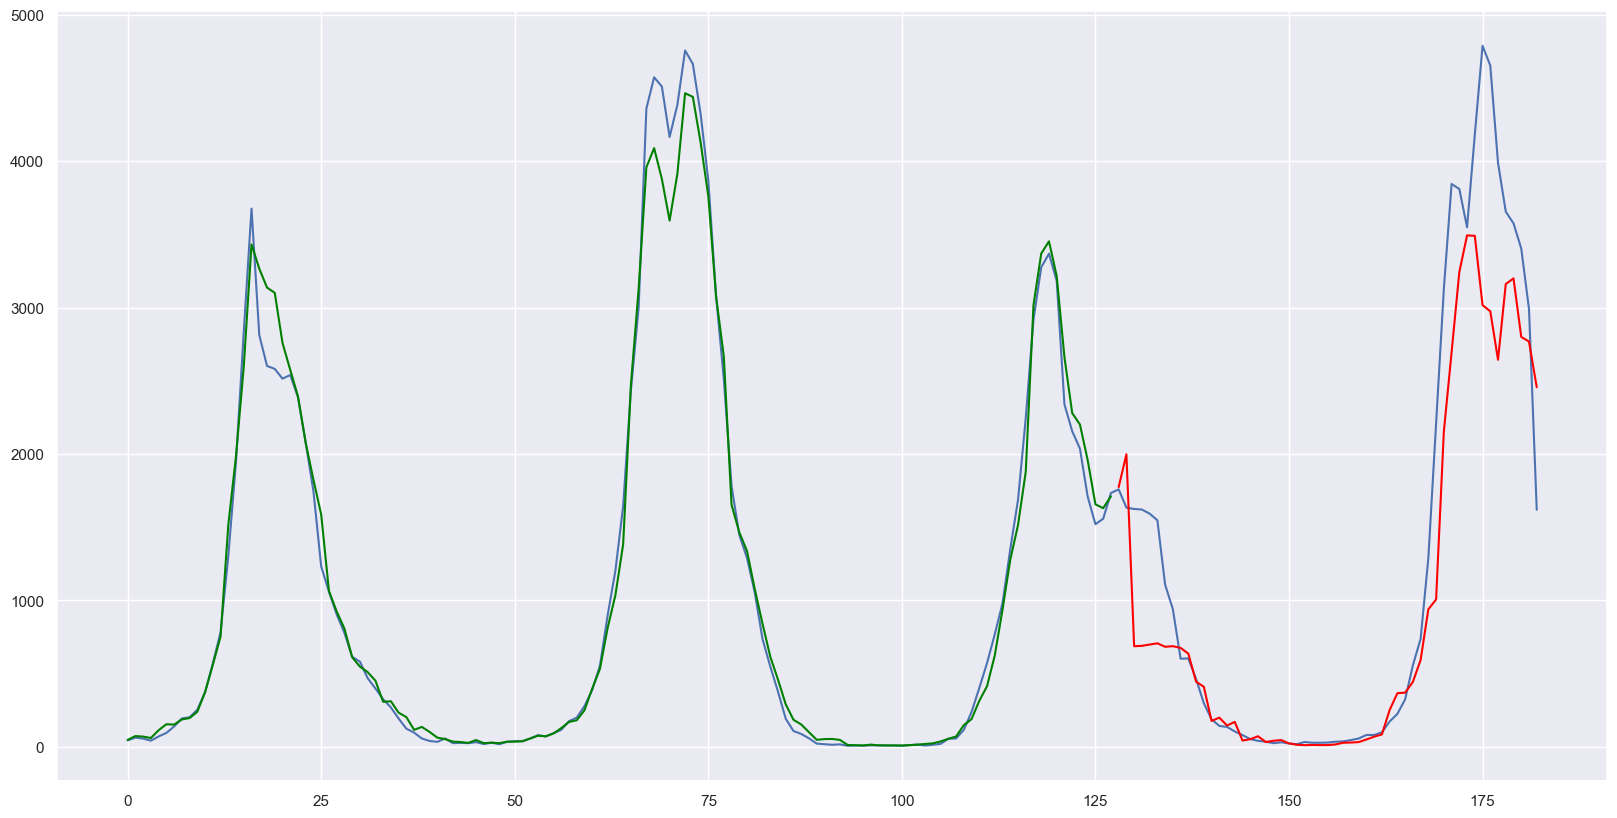

In [213]:
# plot 4-week ahead prediction
plt.plot(df_time_features_pre_COVID.index, df_time_features_pre_COVID['y4'].values)
plt.plot(df_time_features_pre_COVID.index[:train_size], preds_train_df['y4'], color='green')
plt.plot(df_time_features_pre_COVID.index[train_size:], preds_test_df['y4'], color='red')

In [214]:
# define the evaluation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=2022)
# evaluate the model and collect the scores
n_scores = cross_val_score(model, train_X, train_y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
# force the scores to be positive
n_scores = absolute(n_scores)
# summarize performance
print('RMSE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

RMSE: 336.879 (129.149)


In [215]:
# evaluate all four weeks of predictions

MSE_train = round(mean_squared_error(train_y, preds_train),3)
RMSE_train = round(mean_squared_error(train_y, preds_train, squared=False),3)
MAE_train = round(mean_absolute_error(train_y, preds_train),3)
print(f'MSE_train: {MSE_train}')
print(f'RMSE_train: {RMSE_train}')
print(f'MAE_train: {MAE_train}')

MSE_test = round(mean_squared_error(test_y, preds_test),3)
RMSE_test = round(mean_squared_error(test_y, preds_test, squared=False),3)
MAE_test = round(mean_absolute_error(test_y, preds_test),3)
print(f'MSE_test: {MSE_test}')
print(f'RMSE_test: {RMSE_test}')
print(f'MAE_test: {MAE_test}')


MSE_train: 17699.313
RMSE_train: 131.049
MAE_train: 71.92
MSE_test: 210629.809
RMSE_test: 447.695
MAE_test: 255.796


In [216]:
# evaluate 1-week ahead prediction only

MSE_train = round(mean_squared_error(train_y['y1'], preds_train_df['y1']),3)
RMSE_train = round(mean_squared_error(train_y['y1'], preds_train_df['y1'], squared=False),3)
MAE_train = round(mean_absolute_error(train_y['y1'], preds_train_df['y1']),3)
print(f'MSE_train: {MSE_train}')
print(f'RMSE_train: {RMSE_train}')
print(f'MAE_train: {MAE_train}')

MSE_test = round(mean_squared_error(test_y['y1'], preds_test_df['y1']),3)
RMSE_test = round(mean_squared_error(test_y['y1'], preds_test_df['y1'], squared=False),3)
MAE_test = round(mean_absolute_error(test_y['y1'], preds_test_df['y1']),3)
print(f'MSE_test: {MSE_test}')
print(f'RMSE_test: {RMSE_test}')
print(f'MAE_test: {MAE_test}')


MSE_train: 9987.755
RMSE_train: 99.939
MAE_train: 52.964
MSE_test: 89840.609
RMSE_test: 299.734
MAE_test: 186.302


In [217]:
# evaluate 2-week ahead prediction only

MSE_train = round(mean_squared_error(train_y['y2'], preds_train_df['y2']),3)
RMSE_train = round(mean_squared_error(train_y['y2'], preds_train_df['y2'], squared=False),3)
MAE_train = round(mean_absolute_error(train_y['y2'], preds_train_df['y2']),3)
print(f'MSE_train: {MSE_train}')
print(f'RMSE_train: {RMSE_train}')
print(f'MAE_train: {MAE_train}')

MSE_test = round(mean_squared_error(test_y['y2'], preds_test_df['y2']),3)
RMSE_test = round(mean_squared_error(test_y['y2'], preds_test_df['y2'], squared=False),3)
MAE_test = round(mean_absolute_error(test_y['y2'], preds_test_df['y2']),3)
print(f'MSE_test: {MSE_test}')
print(f'RMSE_test: {RMSE_test}')
print(f'MAE_test: {MAE_test}')


MSE_train: 15031.573
RMSE_train: 122.603
MAE_train: 66.82
MSE_test: 172524.554
RMSE_test: 415.361
MAE_test: 225.45


In [218]:
# evaluate 3-week ahead prediction only

MSE_train = round(mean_squared_error(train_y['y3'], preds_train_df['y3']),3)
RMSE_train = round(mean_squared_error(train_y['y3'], preds_train_df['y3'], squared=False),3)
MAE_train = round(mean_absolute_error(train_y['y3'], preds_train_df['y3']),3)
print(f'MSE_train: {MSE_train}')
print(f'RMSE_train: {RMSE_train}')
print(f'MAE_train: {MAE_train}')

MSE_test = round(mean_squared_error(test_y['y3'], preds_test_df['y3']),3)
RMSE_test = round(mean_squared_error(test_y['y3'], preds_test_df['y3'], squared=False),3)
MAE_test = round(mean_absolute_error(test_y['y3'], preds_test_df['y3']),3)
print(f'MSE_test: {MSE_test}')
print(f'RMSE_test: {RMSE_test}')
print(f'MAE_test: {MAE_test}')


MSE_train: 19320.229
RMSE_train: 138.997
MAE_train: 77.24
MSE_test: 259617.884
RMSE_test: 509.527
MAE_test: 280.809


In [219]:
# evaluate 4-week ahead prediction only

MSE_train = round(mean_squared_error(train_y['y4'], preds_train_df['y4']),4)
RMSE_train = round(mean_squared_error(train_y['y4'], preds_train_df['y4'], squared=False),4)
MAE_train = round(mean_absolute_error(train_y['y4'], preds_train_df['y4']),4)
print(f'MSE_train: {MSE_train}')
print(f'RMSE_train: {RMSE_train}')
print(f'MAE_train: {MAE_train}')

MSE_test = round(mean_squared_error(test_y['y4'], preds_test_df['y4']),4)
RMSE_test = round(mean_squared_error(test_y['y4'], preds_test_df['y4'], squared=False),4)
MAE_test = round(mean_absolute_error(test_y['y4'], preds_test_df['y4']),4)
print(f'MSE_test: {MSE_test}')
print(f'RMSE_test: {RMSE_test}')
print(f'MAE_test: {MAE_test}')

MSE_train: 26457.6957
RMSE_train: 162.6582
MAE_train: 90.6561
MSE_test: 320536.1872
RMSE_test: 566.1592
MAE_test: 330.6205


In [220]:
model.feature_importances_

array([3.06291015e-01, 1.90169464e-02, 2.47328883e-02, 1.50053242e-02,
       1.07805251e-02, 1.30130545e-02, 2.61468927e-02, 1.60049001e-02,
       4.36195280e-02, 1.11556142e-02, 4.49688351e-03, 1.02158787e-04,
       5.09634269e-01])

Feature: 0, Score: 0.30629
Feature: 1, Score: 0.01902
Feature: 2, Score: 0.02473
Feature: 3, Score: 0.01501
Feature: 4, Score: 0.01078
Feature: 5, Score: 0.01301
Feature: 6, Score: 0.02615
Feature: 7, Score: 0.01600
Feature: 8, Score: 0.04362
Feature: 9, Score: 0.01116
Feature: 10, Score: 0.00450
Feature: 11, Score: 0.00010
Feature: 12, Score: 0.50963


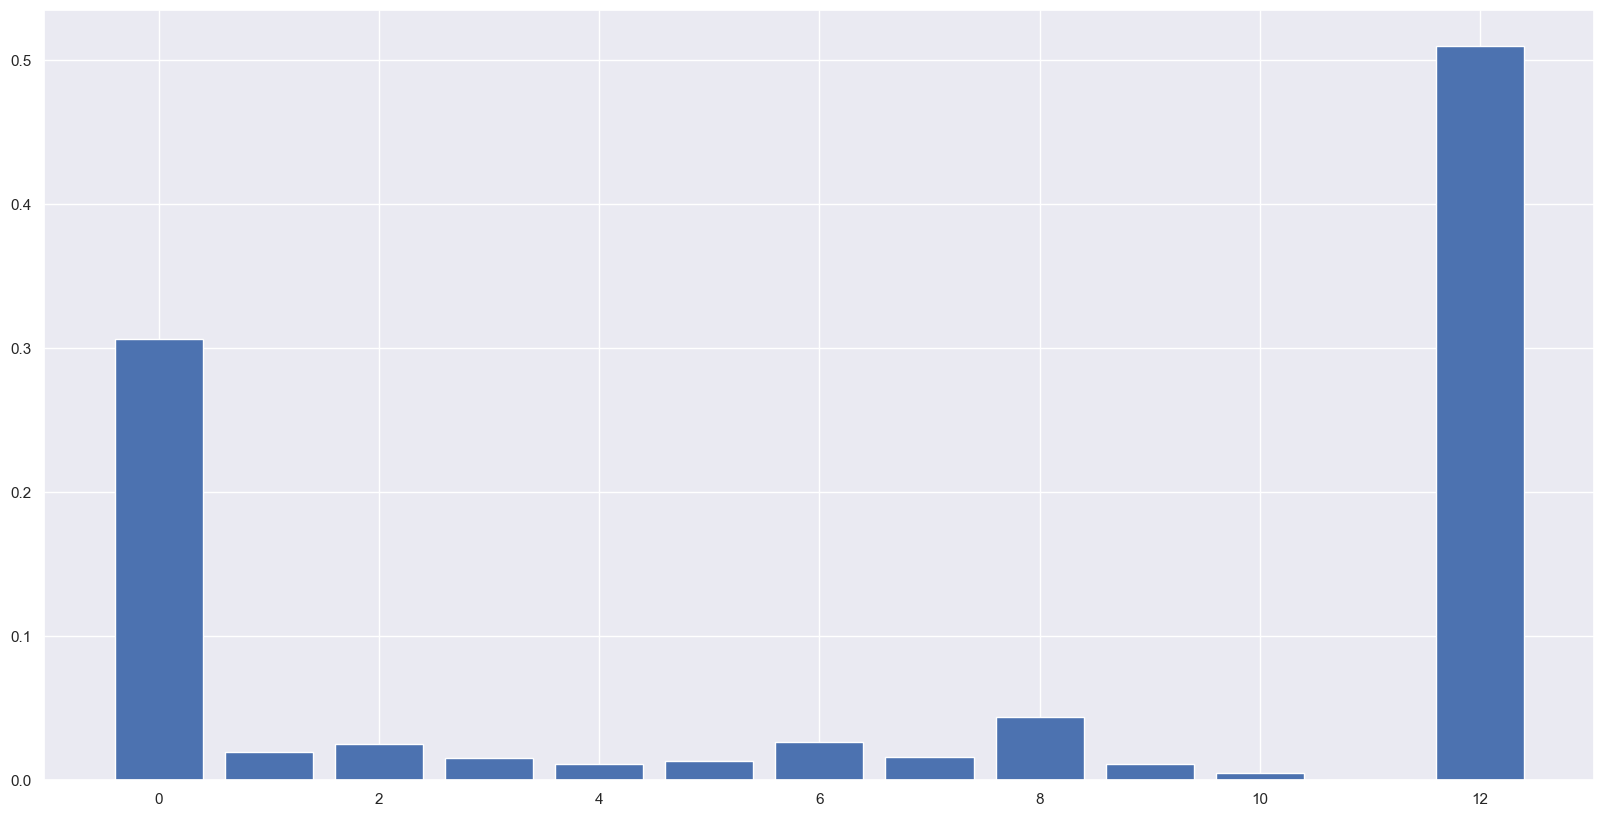

In [221]:
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [222]:
features

Index(['t - 1', 't - 2', 't - 3', 't - 4', 't - 5', 't - 6', 't - 7',
       'this week last year', 'two-week moving average', 'expanding mean',
       'season_Spring', 'season_Summer', 'season_Winter'],
      dtype='object')

In [224]:
for i in range(1,5):
    results_matrix = evaluate_model(train=train_y, test=test_y, preds_train=preds_train, preds_test=preds_test, dataset='Pre-COVID (time feats, remove M and Y)', forecast_weeks=i)
results_matrix

Dataset Weeks-ahead Forecast MSE_train  \
0            Pre-COVID - (all time feats)                    1   8645.66   
0            Pre-COVID - (all time feats)                    2  13142.62   
0            Pre-COVID - (all time feats)                    3  16733.42   
0            Pre-COVID - (all time feats)                    4  22529.88   
0  Pre-COVID (time feats, remove M and Y)                    1   9987.75   
0  Pre-COVID (time feats, remove M and Y)                    2  15031.57   
0  Pre-COVID (time feats, remove M and Y)                    3  19320.23   
0  Pre-COVID (time feats, remove M and Y)                    4   26457.7   

    MSE_test RMSE_train RMSE_test MAE_train MAE_test  R2_train   R2_test  
0   97600.06      92.98    312.41     50.03   193.03  0.995238  0.952997  
0  192354.67     114.64    438.58     64.11   249.64  0.992735  0.911083  
0  287159.05     129.36    535.87     70.98    310.1  0.990716  0.870534  
0  358909.52      150.1    599.09     84.21   365.58  0.987464  0.838051  
0   89840.61      99.94    299.73     52.96    186.3  0.994499  0.956733  
0  172524.55      122.6    415.36     66.82   225.45   0.99169  0.920249  
0  259617.88      139.0    509.53     77.24   280.81  0.989281  0.882951  
0  320536.19     162.66    566.16     90.66   330.62  0.985279  0.855366

In [225]:
results_matrix.sort_values('RMSE_test')

Dataset Weeks-ahead Forecast MSE_train  \
0  Pre-COVID (time feats, remove M and Y)                    1   9987.75   
0            Pre-COVID - (all time feats)                    1   8645.66   
0  Pre-COVID (time feats, remove M and Y)                    2  15031.57   
0            Pre-COVID - (all time feats)                    2  13142.62   
0  Pre-COVID (time feats, remove M and Y)                    3  19320.23   
0            Pre-COVID - (all time feats)                    3  16733.42   
0  Pre-COVID (time feats, remove M and Y)                    4   26457.7   
0            Pre-COVID - (all time feats)                    4  22529.88   

    MSE_test RMSE_train RMSE_test MAE_train MAE_test  R2_train   R2_test  
0   89840.61      99.94    299.73     52.96    186.3  0.994499  0.956733  
0   97600.06      92.98    312.41     50.03   193.03  0.995238  0.952997  
0  172524.55      122.6    415.36     66.82   225.45   0.99169  0.920249  
0  192354.67     114.64    438.58     64.11   249.64  0.992735  0.911083  
0  259617.88      139.0    509.53     77.24   280.81  0.989281  0.882951  
0  287159.05     129.36    535.87     70.98    310.1  0.990716  0.870534  
0  320536.19     162.66    566.16     90.66   330.62  0.985279  0.855366  
0  358909.52      150.1    599.09     84.21   365.58  0.987464  0.838051

# Random Forest Regression - Time Features (without Year, Month) + COVID search terms

In [640]:
df_time_features_pre_COVID = pickle.load(open(r"..\data\flu_cases\df_time_features_pre_COVID.pkl", "rb" ))
df_time_features = pickle.load(open(r"..\data\flu_cases\df_time_features.pkl", "rb" ))

df_COVID_terms_pre_COVID = pickle.load(open(r"..\data\google_trend\df_COVID_terms_pre_COVID.pkl", "rb" ))
df_COVID_terms = pickle.load(open(r"..\data\google_trend\df_COVID_terms.pkl", "rb" ))

In [641]:
df_time_features_pre_COVID.shape

(235, 38)

In [642]:
df_time_features_pre_COVID.columns

Index(['y1', 'y2', 'y3', 'y4', 't - 1', 't - 2', 't - 3', 't - 4', 't - 5',
       't - 6', 't - 7', 'this week last year', 'two-week moving average',
       'expanding mean', 'year_2015', 'year_2016', 'year_2017', 'year_2018',
       'year_2019', 'year_2020', 'year_2021', 'year_2022', 'month_1',
       'month_10', 'month_11', 'month_12', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'season_Fall',
       'season_Spring', 'season_Summer', 'season_Winter'],
      dtype='object')

In [643]:
df = pd.concat([df_time_features_pre_COVID, df_COVID_terms_pre_COVID], axis=1)
df

y1      y2      y3      y4   t - 1   t - 2   t - 3   t - 4   t - 5  \
0       9.0    18.0    15.0    29.0     NaN     NaN     NaN     NaN     NaN   
1      18.0    15.0    29.0    59.0     9.0     NaN     NaN     NaN     NaN   
2      15.0    29.0    59.0    50.0    18.0     9.0     NaN     NaN     NaN   
3      29.0    59.0    50.0    37.0    15.0    18.0     9.0     NaN     NaN   
4      59.0    50.0    37.0    26.0    29.0    15.0    18.0     9.0     NaN   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
230  4789.0  4654.0  3989.0  3656.0  4182.0  3549.0  3811.0  3845.0  3126.0   
231  4654.0  3989.0  3656.0  3576.0  4789.0  4182.0  3549.0  3811.0  3845.0   
232  3989.0  3656.0  3576.0  3404.0  4654.0  4789.0  4182.0  3549.0  3811.0   
233  3656.0  3576.0  3404.0  2991.0  3989.0  4654.0  4789.0  4182.0  3549.0   
234  3576.0  3404.0  2991.0  1619.0  3656.0  3989.0  4654.0  4789.0  4182.0   

      t - 6  ...  month  year  week  coronavirus  COVID  lockdown  mask  \
0       NaN  ...      9  2015    36          0.5    0.0         2    12   
1       NaN  ...      9  2015    37          0.5    0.0         2    12   
2       NaN  ...      9  2015    38          0.5    0.0         2    12   
3       NaN  ...      9  2015    39          0.5    0.0         2    12   
4       NaN  ...     10  2015    40          0.5    0.0         3    18   
..      ...  ...    ...   ...   ...          ...    ...       ...   ...   
230  2206.0  ...      2  2020     5         17.0    1.0         2    32   
231  3126.0  ...      2  2020     6         17.0    1.0         2    32   
232  3845.0  ...      2  2020     7         17.0    1.0         2    32   
233  3811.0  ...      2  2020     8         17.0    1.0         2    32   
234  3549.0  ...      2  2020     9         17.0    1.0         2    32   

     quarantine  social_distancing  vaccine  
0             1                0.0        1  
1             1                0.0        1  
2             1                0.0        1  
3             1                0.0        1  
4             1                0.5        1  
..          ...                ...      ...  
230           9                0.0        2  
231           9                0.0        2  
232           9                0.0        2  
233           9                0.0        2  
234           9                0.0        2  

[235 rows x 49 columns]

In [644]:
df.dropna(inplace=True)
df = df.reset_index(drop=True)
df = df.drop(columns=['year_2015', 'month_1','year_2016', 'year_2017', 'year_2018', 'year_2019',
       'year_2020', 'year_2021', 'year_2022', 'month_10', 'month_11',
       'month_12', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9','Total Cases','month', 'year', 'week'])

In [663]:
df.iloc[-1,:]

y1                         3576.000000
y2                         3404.000000
y3                         2991.000000
y4                         1619.000000
t - 1                      3656.000000
t - 2                      3989.000000
t - 3                      4654.000000
t - 4                      4789.000000
t - 5                      4182.000000
t - 6                      3549.000000
t - 7                      3811.000000
this week last year        1734.000000
two-week moving average    3822.500000
expanding mean              998.978632
season_Fall                   0.000000
season_Spring                 0.000000
season_Summer                 0.000000
season_Winter                 1.000000
coronavirus                  17.000000
COVID                         1.000000
lockdown                      2.000000
mask                         32.000000
quarantine                    9.000000
social_distancing             0.000000
vaccine                       2.000000
Name: 182, dtype: float64

In [646]:
df.columns

Index(['y1', 'y2', 'y3', 'y4', 't - 1', 't - 2', 't - 3', 't - 4', 't - 5',
       't - 6', 't - 7', 'this week last year', 'two-week moving average',
       'expanding mean', 'season_Fall', 'season_Spring', 'season_Summer',
       'season_Winter', 'coronavirus', 'COVID', 'lockdown', 'mask',
       'quarantine', 'social_distancing', 'vaccine'],
      dtype='object')

In [647]:
train_size = int(len(df) *.7)
test_size = len(df) - train_size
train, test = df[0:train_size], df[train_size:len(df)]

In [648]:
train_y = train[['y1','y2','y3','y4']]
train_X = train.drop(columns=['y1','y2','y3','y4'])
test_y = test[['y1','y2','y3','y4']]
test_X = test.drop(columns=['y1','y2','y3','y4'])

In [649]:
features = train_X.columns

In [650]:
col_to_scale = ['t - 1', 't - 2', 't - 3', 't - 4', 't - 5',
       't - 6', 't - 7', 'this week last year', 'two-week moving average',
       'expanding mean','coronavirus', 'COVID',
       'lockdown', 'mask', 'quarantine', 'social_distancing', 'vaccine']
col_not_to_scale = ['season_Fall','season_Spring', 'season_Summer', 'season_Winter']

In [651]:
train_X_to_scale = train_X.loc[:,col_to_scale]
test_X_to_scale = test_X.loc[:,col_to_scale]
train_X_not_to_scale = train_X.loc[:,col_not_to_scale].to_numpy()
test_X_not_to_scale = test_X.loc[:,col_not_to_scale].to_numpy()

In [652]:
from sklearn.preprocessing import MinMaxScaler

# scale data
scaler = MinMaxScaler()
train_X_to_scale = scaler.fit_transform(train_X_to_scale)
test_X_to_scale = scaler.transform(test_X_to_scale)

In [653]:
train_X = np.concatenate((train_X_to_scale, train_X_not_to_scale),axis=1)
test_X = np.concatenate((test_X_to_scale, test_X_not_to_scale),axis=1)

In [654]:
model = RandomForestRegressor()

model.fit(train_X, train_y)

RandomForestRegressor()

In [655]:
preds_test = model.predict(test_X)
preds_test_df = pd.DataFrame(preds_test,columns=test_y.columns)
preds_train = model.predict(train_X)
preds_train_df = pd.DataFrame(preds_train,columns=train_y.columns)

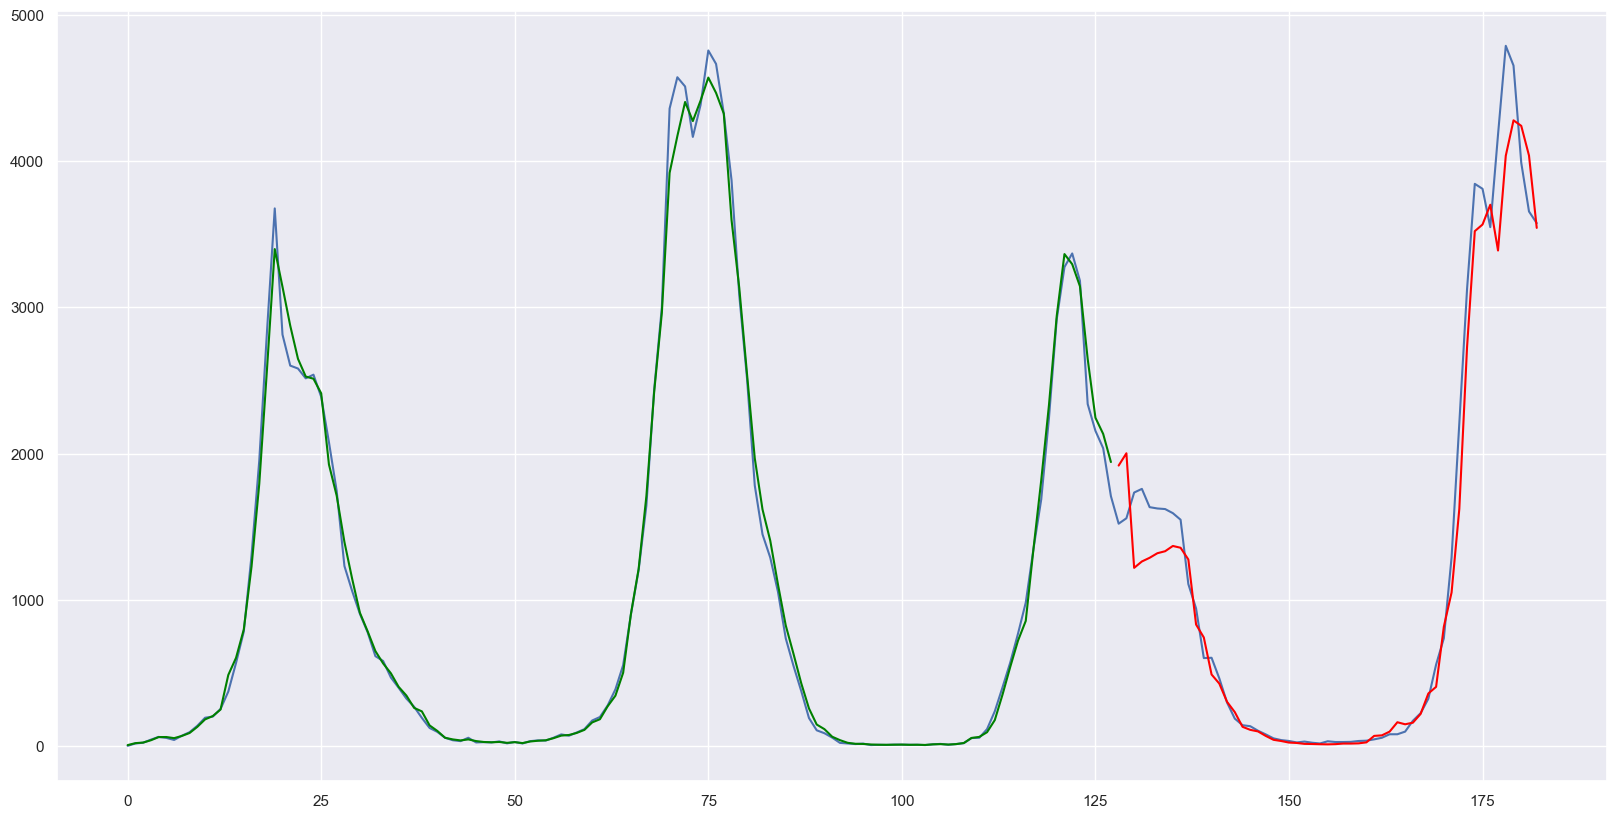

In [656]:
# plot
plt.plot(df.index, df['y1'].values)
plt.plot(df.index[:train_size], preds_train_df['y1'], color='green')
plt.plot(df.index[train_size:], preds_test_df['y1'], color='red')

In [660]:
test_X

array([[0.35899054, 0.42797056, 0.45299685, ..., 0.        , 0.        ,
        1.        ],
       [0.31945321, 0.35899054, 0.42797056, ..., 0.        , 0.        ,
        1.        ],
       [0.32723449, 0.31945321, 0.35899054, ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.97833859, 1.00672976, 0.87907466, ..., 0.        , 0.        ,
        1.        ],
       [0.8384858 , 0.97833859, 1.00672976, ..., 0.        , 0.        ,
        1.        ],
       [0.76845426, 0.8384858 , 0.97833859, ..., 0.        , 0.        ,
        1.        ]])

In [ ]:
next_week = model.predict(test_X)

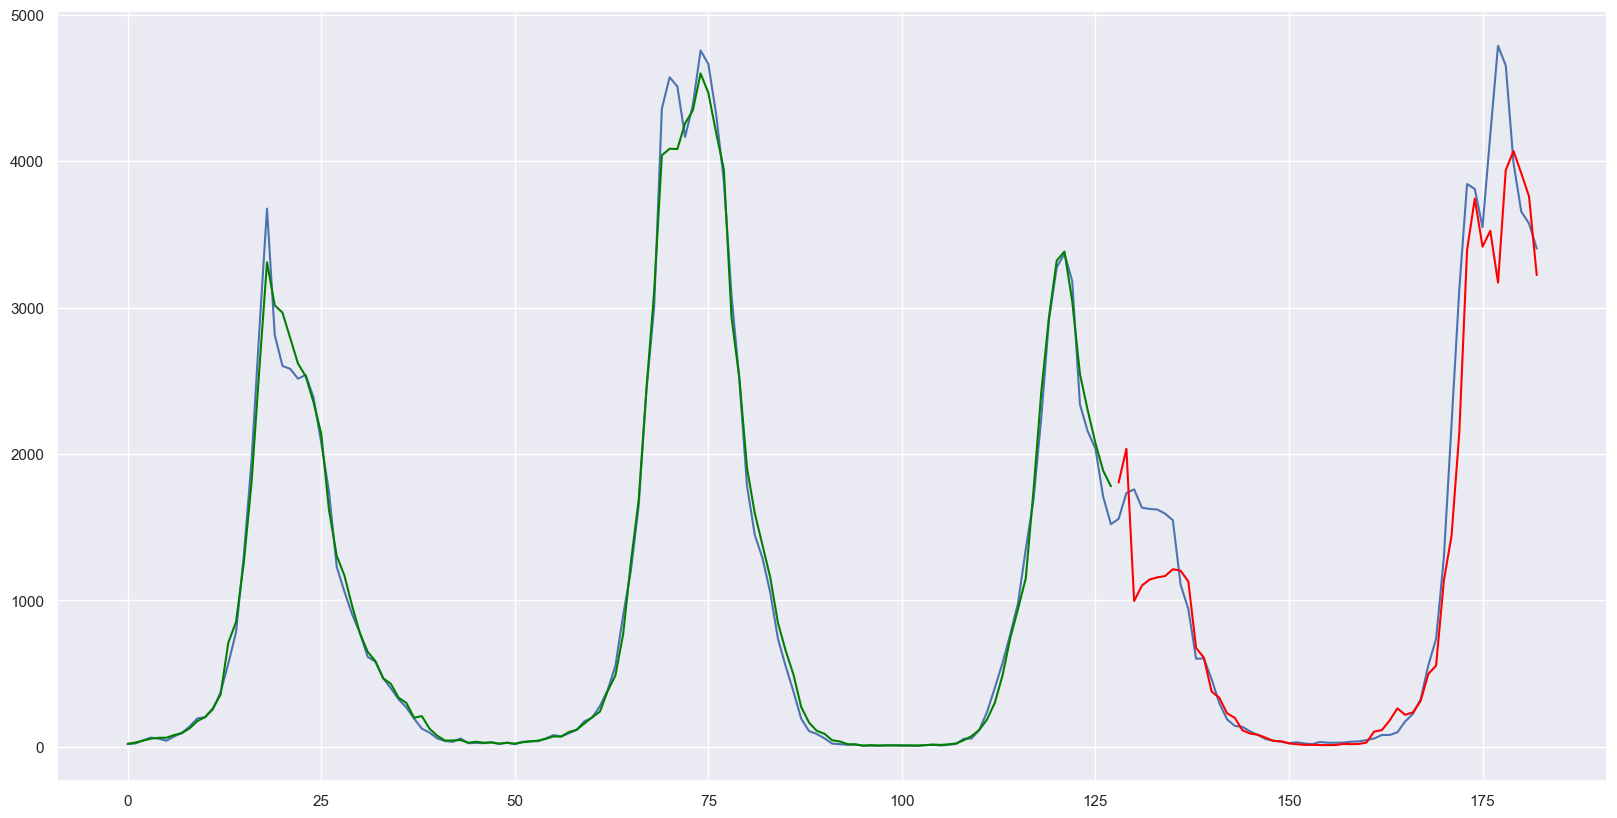

In [657]:
# plot 2-week ahead prediction
plt.plot(df.index, df['y2'].values)
plt.plot(df.index[:train_size], preds_train_df['y2'], color='green')
plt.plot(df.index[train_size:], preds_test_df['y2'], color='red')

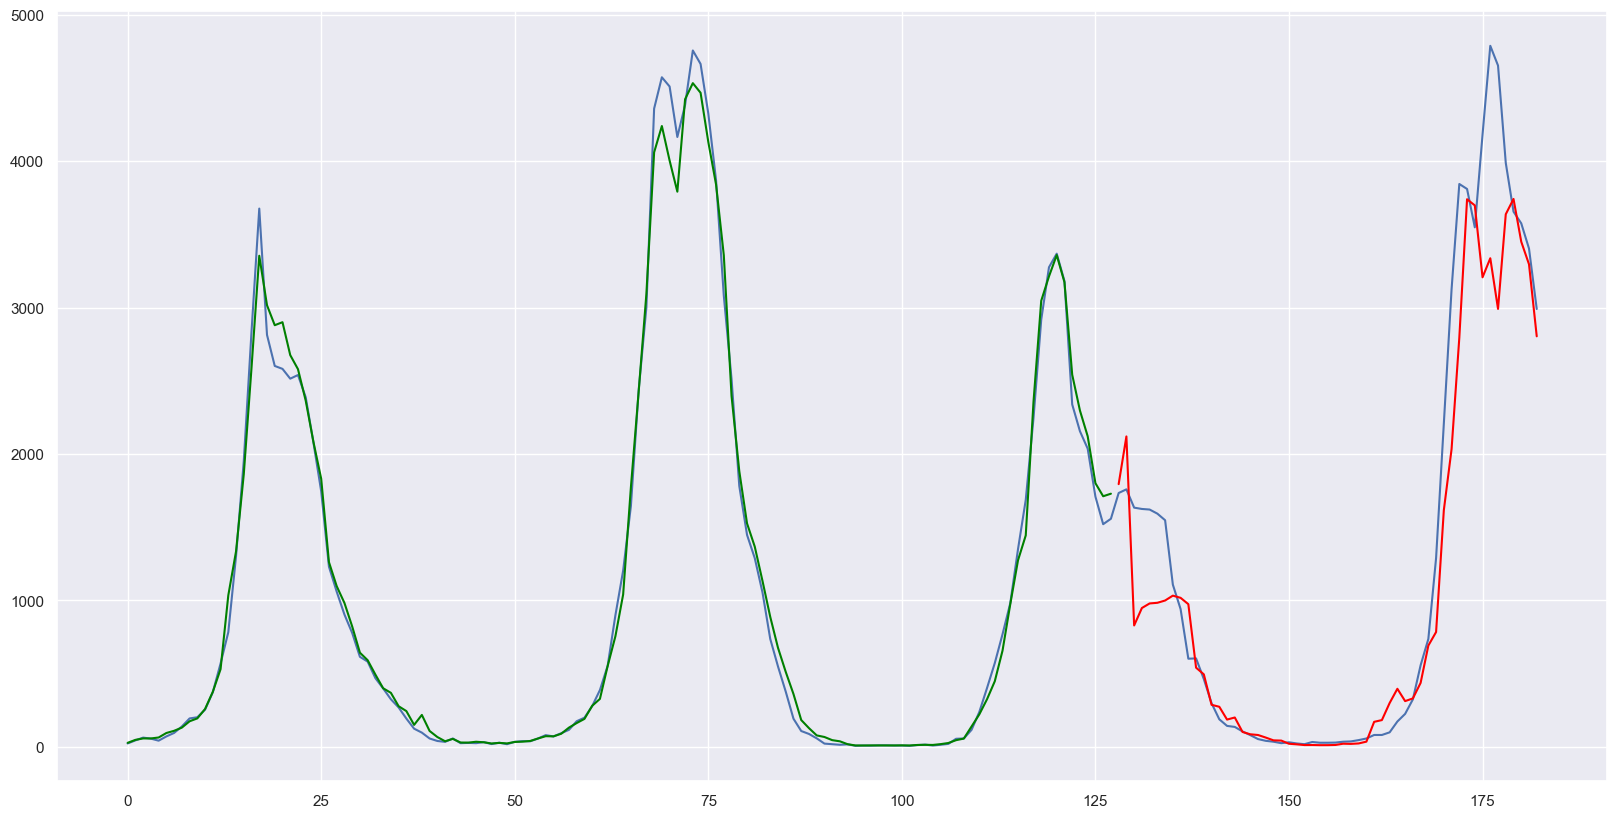

In [658]:
# plot 3-week ahead prediction
plt.plot(df.index, df['y3'].values)
plt.plot(df.index[:train_size], preds_train_df['y3'], color='green')
plt.plot(df.index[train_size:], preds_test_df['y3'], color='red')

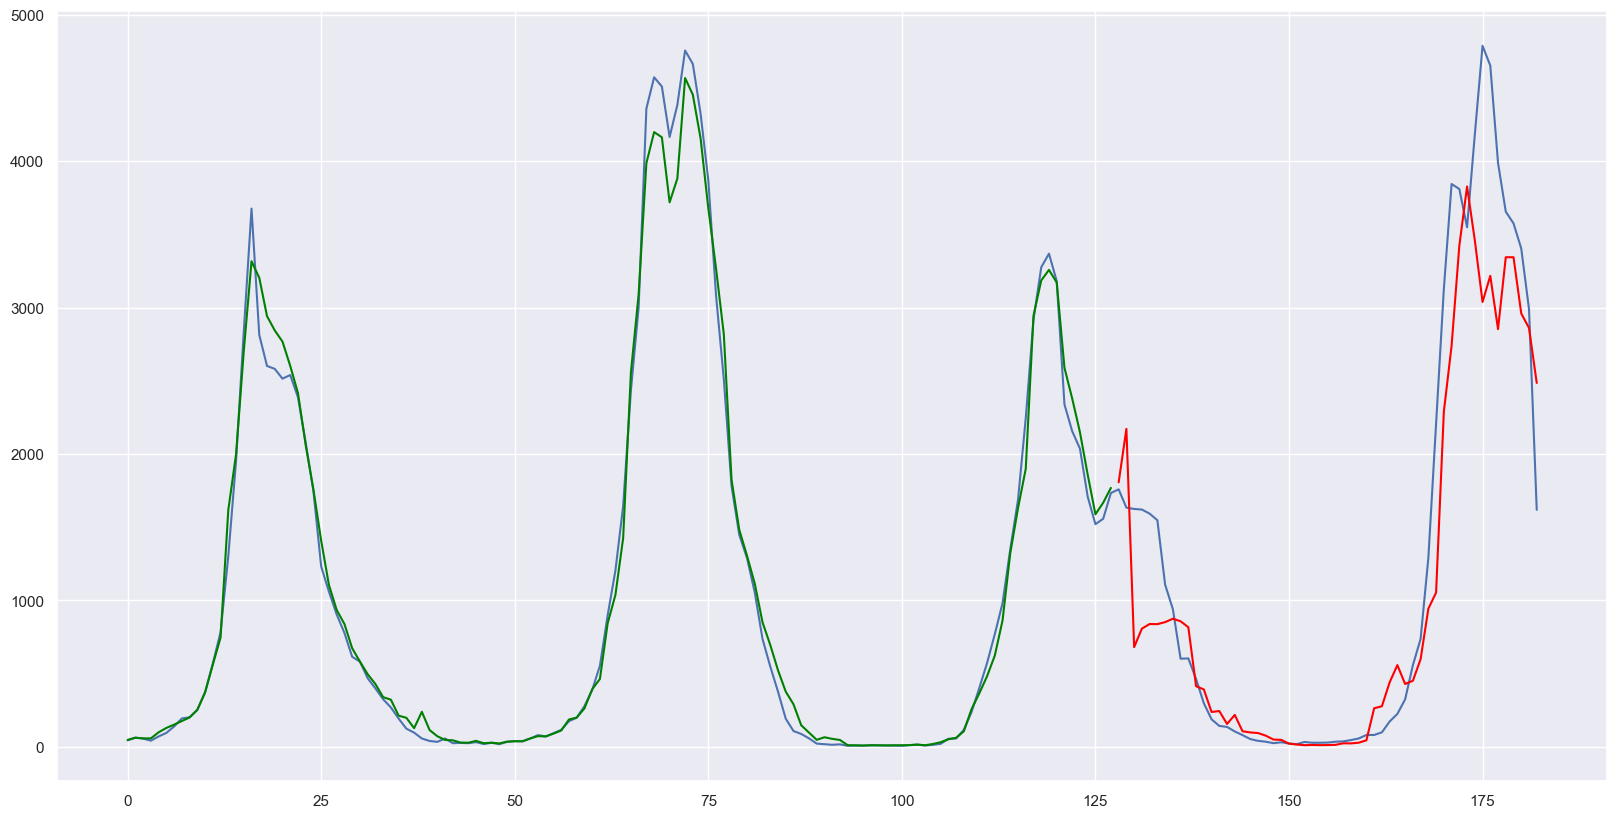

In [659]:
# plot 4-week ahead prediction
plt.plot(df.index, df['y4'].values)
plt.plot(df.index[:train_size], preds_train_df['y4'], color='green')
plt.plot(df.index[train_size:], preds_test_df['y4'], color='red')

In [273]:
# define the evaluation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=2022)
# evaluate the model and collect the scores
n_scores = cross_val_score(model, train_X, train_y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
# force the scores to be positive
n_scores = absolute(n_scores)
# summarize performance
print('RMSE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

RMSE: 326.639 (116.536)


In [274]:
# evaluate all four weeks of predictions

MSE_train = round(mean_squared_error(train_y, preds_train),3)
RMSE_train = round(mean_squared_error(train_y, preds_train, squared=False),3)
MAE_train = round(mean_absolute_error(train_y, preds_train),3)
print(f'MSE_train: {MSE_train}')
print(f'RMSE_train: {RMSE_train}')
print(f'MAE_train: {MAE_train}')

MSE_test = round(mean_squared_error(test_y, preds_test),3)
RMSE_test = round(mean_squared_error(test_y, preds_test, squared=False),3)
MAE_test = round(mean_absolute_error(test_y, preds_test),3)
print(f'MSE_test: {MSE_test}')
print(f'RMSE_test: {RMSE_test}')
print(f'MAE_test: {MAE_test}')


MSE_train: 15995.009
RMSE_train: 125.085
MAE_train: 70.341
MSE_test: 177632.497
RMSE_test: 408.454
MAE_test: 246.949


In [275]:
# evaluate 1-week ahead prediction only

MSE_train = round(mean_squared_error(train_y['y1'], preds_train_df['y1']),3)
RMSE_train = round(mean_squared_error(train_y['y1'], preds_train_df['y1'], squared=False),3)
MAE_train = round(mean_absolute_error(train_y['y1'], preds_train_df['y1']),3)
print(f'MSE_train: {MSE_train}')
print(f'RMSE_train: {RMSE_train}')
print(f'MAE_train: {MAE_train}')

MSE_test = round(mean_squared_error(test_y['y1'], preds_test_df['y1']),3)
RMSE_test = round(mean_squared_error(test_y['y1'], preds_test_df['y1'], squared=False),3)
MAE_test = round(mean_absolute_error(test_y['y1'], preds_test_df['y1']),3)
print(f'MSE_test: {MSE_test}')
print(f'RMSE_test: {RMSE_test}')
print(f'MAE_test: {MAE_test}')


MSE_train: 9359.491
RMSE_train: 96.744
MAE_train: 53.667
MSE_test: 68548.969
RMSE_test: 261.819
MAE_test: 172.169


In [276]:
# evaluate 2-week ahead prediction only

MSE_train = round(mean_squared_error(train_y['y2'], preds_train_df['y2']),3)
RMSE_train = round(mean_squared_error(train_y['y2'], preds_train_df['y2'], squared=False),3)
MAE_train = round(mean_absolute_error(train_y['y2'], preds_train_df['y2']),3)
print(f'MSE_train: {MSE_train}')
print(f'RMSE_train: {RMSE_train}')
print(f'MAE_train: {MAE_train}')

MSE_test = round(mean_squared_error(test_y['y2'], preds_test_df['y2']),3)
RMSE_test = round(mean_squared_error(test_y['y2'], preds_test_df['y2'], squared=False),3)
MAE_test = round(mean_absolute_error(test_y['y2'], preds_test_df['y2']),3)
print(f'MSE_test: {MSE_test}')
print(f'RMSE_test: {RMSE_test}')
print(f'MAE_test: {MAE_test}')


MSE_train: 14962.431
RMSE_train: 122.321
MAE_train: 68.628
MSE_test: 136966.767
RMSE_test: 370.09
MAE_test: 217.703


In [277]:
# evaluate 3-week ahead prediction only

MSE_train = round(mean_squared_error(train_y['y3'], preds_train_df['y3']),3)
RMSE_train = round(mean_squared_error(train_y['y3'], preds_train_df['y3'], squared=False),3)
MAE_train = round(mean_absolute_error(train_y['y3'], preds_train_df['y3']),3)
print(f'MSE_train: {MSE_train}')
print(f'RMSE_train: {RMSE_train}')
print(f'MAE_train: {MAE_train}')

MSE_test = round(mean_squared_error(test_y['y3'], preds_test_df['y3']),3)
RMSE_test = round(mean_squared_error(test_y['y3'], preds_test_df['y3'], squared=False),3)
MAE_test = round(mean_absolute_error(test_y['y3'], preds_test_df['y3']),3)
print(f'MSE_test: {MSE_test}')
print(f'RMSE_test: {RMSE_test}')
print(f'MAE_test: {MAE_test}')


MSE_train: 17838.93
RMSE_train: 133.562
MAE_train: 74.646
MSE_test: 213031.781
RMSE_test: 461.554
MAE_test: 267.062


In [278]:
# evaluate 4-week ahead prediction only

MSE_train = round(mean_squared_error(train_y['y4'], preds_train_df['y4']),4)
RMSE_train = round(mean_squared_error(train_y['y4'], preds_train_df['y4'], squared=False),4)
MAE_train = round(mean_absolute_error(train_y['y4'], preds_train_df['y4']),4)
print(f'MSE_train: {MSE_train}')
print(f'RMSE_train: {RMSE_train}')
print(f'MAE_train: {MAE_train}')

MSE_test = round(mean_squared_error(test_y['y4'], preds_test_df['y4']),4)
RMSE_test = round(mean_squared_error(test_y['y4'], preds_test_df['y4'], squared=False),4)
MAE_test = round(mean_absolute_error(test_y['y4'], preds_test_df['y4']),4)
print(f'MSE_test: {MSE_test}')
print(f'RMSE_test: {RMSE_test}')
print(f'MAE_test: {MAE_test}')

MSE_train: 21819.1827
RMSE_train: 147.7132
MAE_train: 84.4224
MSE_test: 291982.4709
RMSE_test: 540.354
MAE_test: 330.8605


In [279]:
model.feature_importances_

array([3.42341876e-01, 1.97381255e-02, 2.44256647e-02, 1.19174237e-02,
       5.85264387e-03, 1.74680223e-02, 2.34079914e-02, 1.51761476e-02,
       5.33532021e-02, 8.70823434e-03, 0.00000000e+00, 3.84759588e-03,
       3.37234074e-04, 3.04234988e-03, 0.00000000e+00, 2.32326699e-03,
       7.86862578e-04, 1.35416449e-03, 5.28100768e-06, 4.65913914e-01])

Feature: 0, Score: 0.34234
Feature: 1, Score: 0.01974
Feature: 2, Score: 0.02443
Feature: 3, Score: 0.01192
Feature: 4, Score: 0.00585
Feature: 5, Score: 0.01747
Feature: 6, Score: 0.02341
Feature: 7, Score: 0.01518
Feature: 8, Score: 0.05335
Feature: 9, Score: 0.00871
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00385
Feature: 12, Score: 0.00034
Feature: 13, Score: 0.00304
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00232
Feature: 16, Score: 0.00079
Feature: 17, Score: 0.00135
Feature: 18, Score: 0.00001
Feature: 19, Score: 0.46591


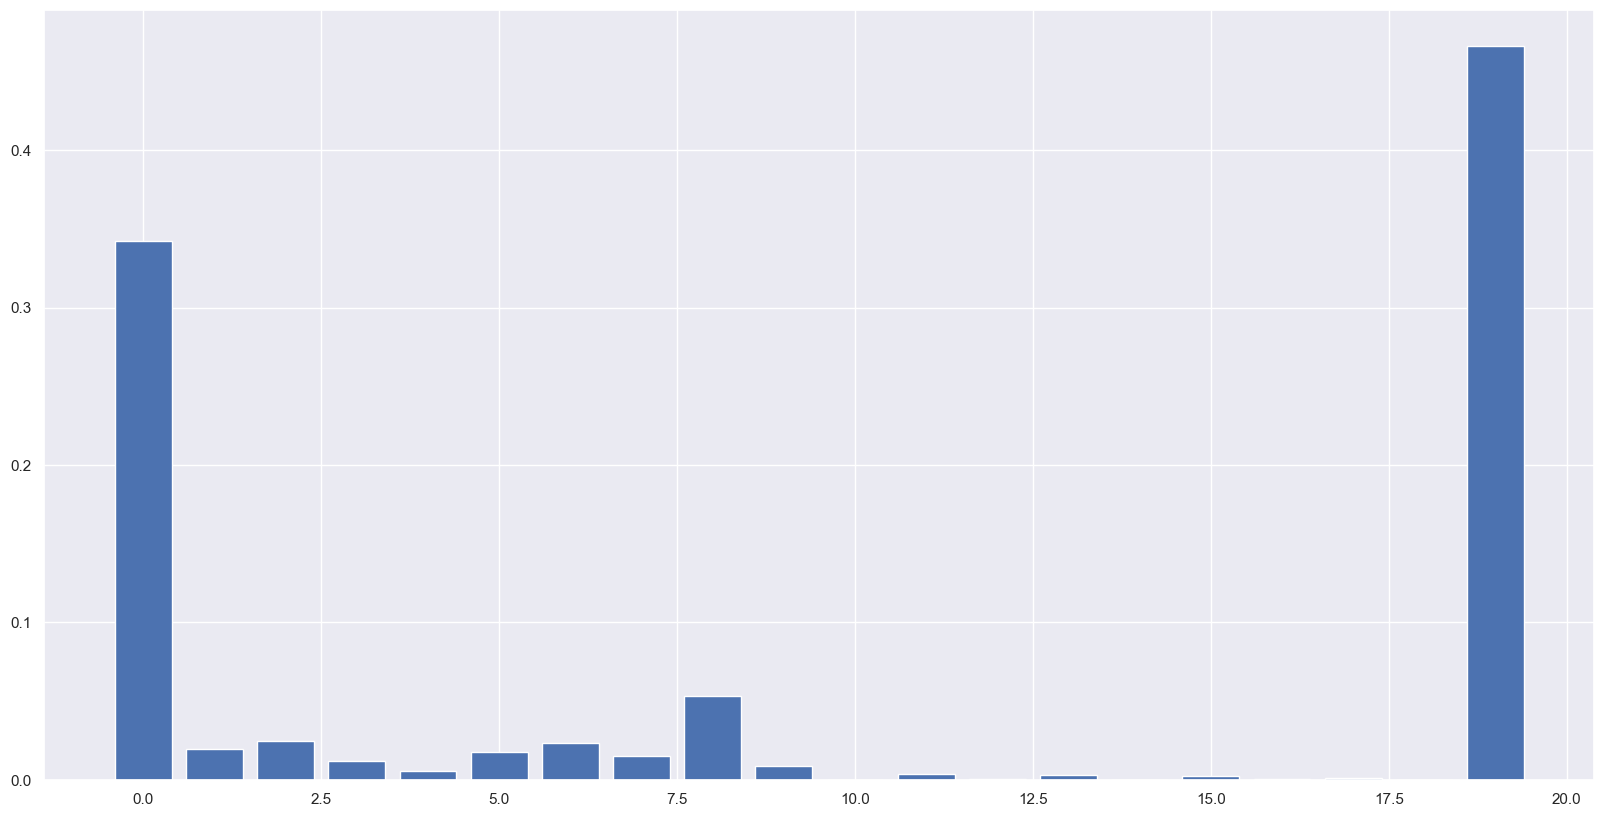

In [280]:
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [281]:
features

Index(['t - 1', 't - 2', 't - 3', 't - 4', 't - 5', 't - 6', 't - 7',
       'this week last year', 'two-week moving average', 'expanding mean',
       'season_Spring', 'season_Summer', 'season_Winter', 'coronavirus',
       'COVID', 'lockdown', 'mask', 'quarantine', 'social_distancing',
       'vaccine'],
      dtype='object')

<AxesSubplot: >

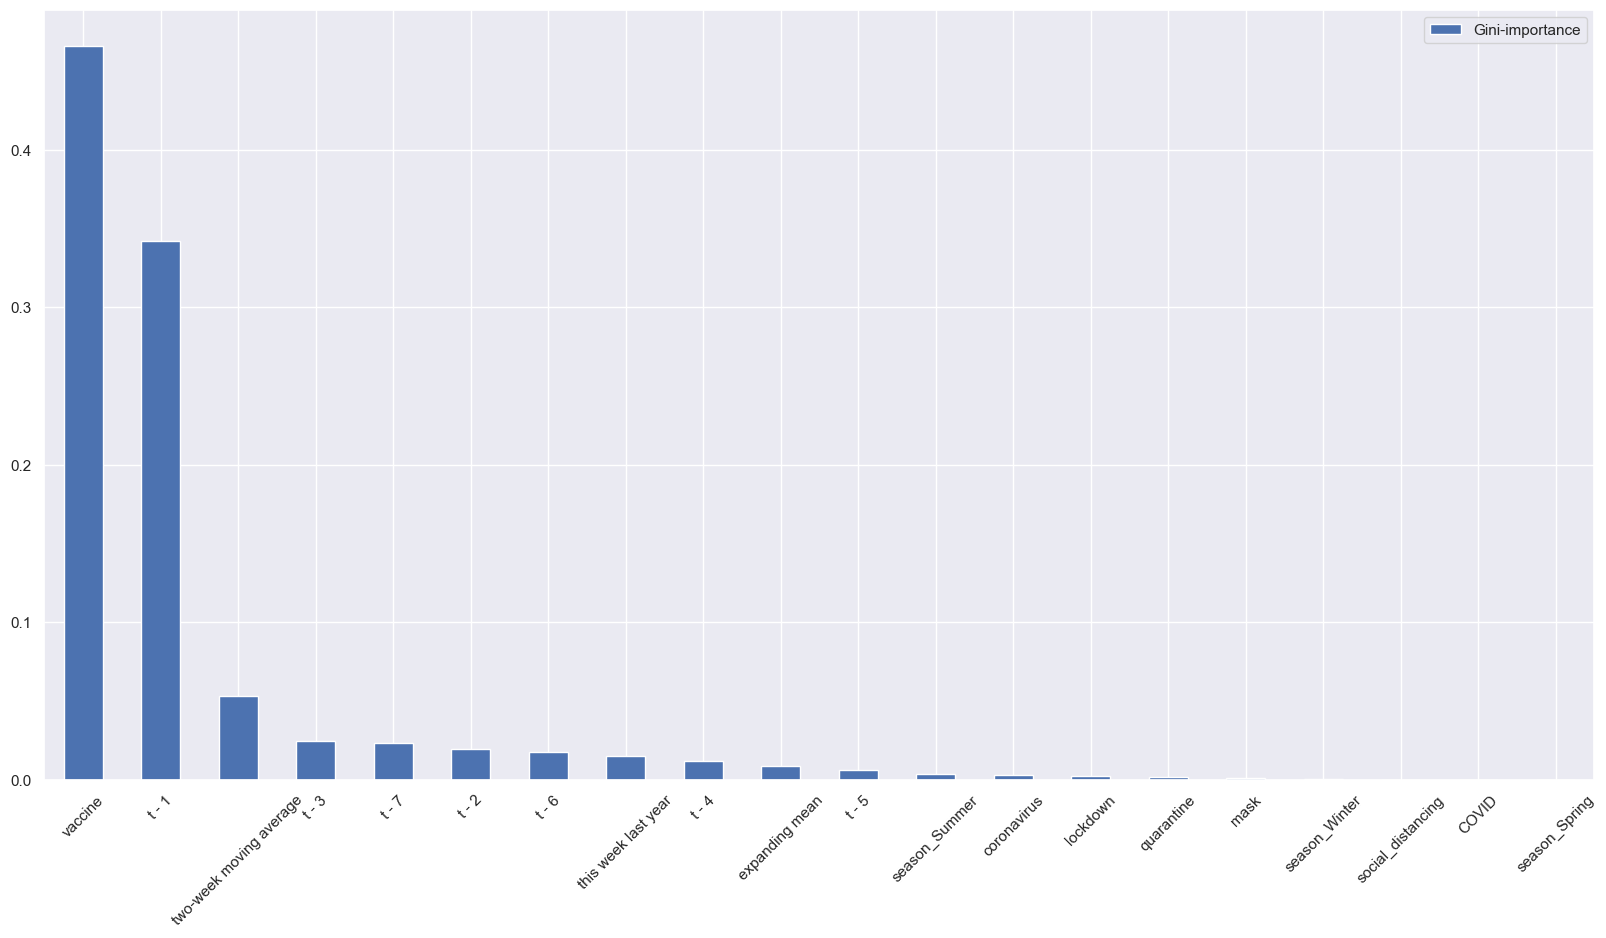

In [289]:
# https://stackoverflow.com/questions/41900387/mapping-column-names-to-random-forest-feature-importances

import pandas as pd
%matplotlib inline
#do code to support model
#"data" is the X dataframe and model is the SKlearn object

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(features, model.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance', ascending=False).plot(kind='bar', rot=45)

In [308]:
feats_to_remove = importances.sort_values('Gini-importance').iloc[0:10,:].index.to_list()

In [309]:
feats_to_remove

['COVID',
 'season_Spring',
 'social_distancing',
 'season_Winter',
 'mask',
 'quarantine',
 'lockdown',
 'coronavirus',
 'season_Summer',
 't - 5']

In [283]:
for i in range(1,5):
    results_matrix = evaluate_model(train=train_y, test=test_y, preds_train=preds_train, preds_test=preds_test, dataset='Pre-COVID (time feats, remove M and Y) + COVID terms', forecast_weeks=i)
results_matrix

Dataset Weeks-ahead Forecast  \
0                       Pre-COVID - (all time feats)                    1   
0                       Pre-COVID - (all time feats)                    2   
0                       Pre-COVID - (all time feats)                    3   
0                       Pre-COVID - (all time feats)                    4   
0             Pre-COVID (time feats, remove M and Y)                    1   
0             Pre-COVID (time feats, remove M and Y)                    2   
0             Pre-COVID (time feats, remove M and Y)                    3   
0             Pre-COVID (time feats, remove M and Y)                    4   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    1   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    2   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    3   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    4   

  MSE_train   MSE_test RMSE_train RMSE_test MAE_train MAE_test  R2_train  \
0   8645.66   97600.06      92.98    312.41     50.03   193.03  0.995238   
0  13142.62  192354.67     114.64    438.58     64.11   249.64  0.992735   
0  16733.42  287159.05     129.36    535.87     70.98    310.1  0.990716   
0  22529.88  358909.52      150.1    599.09     84.21   365.58  0.987464   
0   9987.75   89840.61      99.94    299.73     52.96    186.3  0.994499   
0  15031.57  172524.55      122.6    415.36     66.82   225.45   0.99169   
0  19320.23  259617.88      139.0    509.53     77.24   280.81  0.989281   
0   26457.7  320536.19     162.66    566.16     90.66   330.62  0.985279   
0   9359.49   68548.97      96.74    261.82     53.67   172.17  0.994845   
0  14962.43  136966.77     122.32    370.09     68.63    217.7  0.991728   
0  17838.93  213031.78     133.56    461.55     74.65   267.06  0.990103   
0  21819.18  291982.47     147.71    540.35     84.42   330.86   0.98786   

    R2_test  
0  0.952997  
0  0.911083  
0  0.870534  
0  0.838051  
0  0.956733  
0  0.920249  
0  0.882951  
0  0.855366  
0  0.966987  
0  0.936686  
0  0.903955  
0   0.86825

In [284]:
results_matrix.sort_values('RMSE_test')

Dataset Weeks-ahead Forecast  \
0  Pre-COVID (time feats, remove M and Y) + COVID...                    1   
0             Pre-COVID (time feats, remove M and Y)                    1   
0                       Pre-COVID - (all time feats)                    1   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    2   
0             Pre-COVID (time feats, remove M and Y)                    2   
0                       Pre-COVID - (all time feats)                    2   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    3   
0             Pre-COVID (time feats, remove M and Y)                    3   
0                       Pre-COVID - (all time feats)                    3   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    4   
0             Pre-COVID (time feats, remove M and Y)                    4   
0                       Pre-COVID - (all time feats)                    4   

  MSE_train   MSE_test RMSE_train RMSE_test MAE_train MAE_test  R2_train  \
0   9359.49   68548.97      96.74    261.82     53.67   172.17  0.994845   
0   9987.75   89840.61      99.94    299.73     52.96    186.3  0.994499   
0   8645.66   97600.06      92.98    312.41     50.03   193.03  0.995238   
0  14962.43  136966.77     122.32    370.09     68.63    217.7  0.991728   
0  15031.57  172524.55      122.6    415.36     66.82   225.45   0.99169   
0  13142.62  192354.67     114.64    438.58     64.11   249.64  0.992735   
0  17838.93  213031.78     133.56    461.55     74.65   267.06  0.990103   
0  19320.23  259617.88      139.0    509.53     77.24   280.81  0.989281   
0  16733.42  287159.05     129.36    535.87     70.98    310.1  0.990716   
0  21819.18  291982.47     147.71    540.35     84.42   330.86   0.98786   
0   26457.7  320536.19     162.66    566.16     90.66   330.62  0.985279   
0  22529.88  358909.52      150.1    599.09     84.21   365.58  0.987464   

    R2_test  
0  0.966987  
0  0.956733  
0  0.952997  
0  0.936686  
0  0.920249  
0  0.911083  
0  0.903955  
0  0.882951  
0  0.870534  
0   0.86825  
0  0.855366  
0  0.838051

# Random Forest Regression - Time Features (without Year, Month) + COVID search terms + Flu Terms

In [342]:
df_time_features_pre_COVID = pickle.load(open(r"..\data\flu_cases\df_time_features_pre_COVID.pkl", "rb" ))
df_time_features = pickle.load(open(r"..\data\flu_cases\df_time_features.pkl", "rb" ))

df_COVID_terms_pre_COVID = pickle.load(open(r"..\data\google_trend\df_COVID_terms_pre_COVID.pkl", "rb" ))
df_COVID_terms = pickle.load(open(r"..\data\google_trend\df_COVID_terms.pkl", "rb" ))

df_flu_symptoms_pre_COVID = pickle.load(open(r"..\data\google_trend\df_flu_symptoms_pre_COVID.pkl", "rb" ))
df_flu_symptoms = pickle.load(open(r"..\data\google_trend\df_flu_symptoms.pkl", "rb" ))

In [343]:
df_time_features_pre_COVID.shape

(235, 35)

In [344]:
df_time_features_pre_COVID.columns

Index(['y1', 'y2', 'y3', 'y4', 't - 1', 't - 2', 't - 3', 't - 4', 't - 5',
       't - 6', 't - 7', 'this week last year', 'two-week moving average',
       'expanding mean', 'year_2016', 'year_2017', 'year_2018', 'year_2019',
       'year_2020', 'year_2021', 'year_2022', 'month_10', 'month_11',
       'month_12', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'season_Spring', 'season_Summer',
       'season_Winter'],
      dtype='object')

In [345]:
df = pd.concat([df_time_features_pre_COVID, df_COVID_terms_pre_COVID, df_flu_symptoms_pre_COVID], axis=1)
df

y1      y2      y3      y4   t - 1   t - 2   t - 3   t - 4   t - 5  \
0       9.0    18.0    15.0    29.0     NaN     NaN     NaN     NaN     NaN   
1      18.0    15.0    29.0    59.0     9.0     NaN     NaN     NaN     NaN   
2      15.0    29.0    59.0    50.0    18.0     9.0     NaN     NaN     NaN   
3      29.0    59.0    50.0    37.0    15.0    18.0     9.0     NaN     NaN   
4      59.0    50.0    37.0    26.0    29.0    15.0    18.0     9.0     NaN   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
230  4789.0  4654.0  3989.0  3656.0  4182.0  3549.0  3811.0  3845.0  3126.0   
231  4654.0  3989.0  3656.0  3576.0  4789.0  4182.0  3549.0  3811.0  3845.0   
232  3989.0  3656.0  3576.0  3404.0  4654.0  4789.0  4182.0  3549.0  3811.0   
233  3656.0  3576.0  3404.0  2991.0  3989.0  4654.0  4789.0  4182.0  3549.0   
234  3576.0  3404.0  2991.0  1619.0  3656.0  3989.0  4654.0  4789.0  4182.0   

      t - 6  ...  chills  cough  diarrhea  fatigue  fever  flu  headache  \
0       NaN  ...      31     27        64       74     29    7        57   
1       NaN  ...      31     27        64       74     29    7        57   
2       NaN  ...      31     27        64       74     29    7        57   
3       NaN  ...      31     27        64       74     29    7        57   
4       NaN  ...      39     37        59       78     29   20        57   
..      ...  ...     ...    ...       ...      ...    ...  ...       ...   
230  2206.0  ...      71     46        82       91     58   34        74   
231  3126.0  ...      71     46        82       91     58   34        74   
232  3845.0  ...      71     46        82       91     58   34        74   
233  3811.0  ...      71     46        82       91     58   34        74   
234  3549.0  ...      71     46        82       91     58   34        74   

     runny_nose  sore_thoat  vomiting  
0            26          34        59  
1            26          34        59  
2            26          34        59  
3            26          34        59  
4            23          31        57  
..          ...         ...       ...  
230          33          45        84  
231          33          45        84  
232          33          45        84  
233          33          45        84  
234          33          45        84  

[235 rows x 61 columns]

In [346]:
feats_to_remove

['COVID',
 'season_Spring',
 'social_distancing',
 'season_Winter',
 'mask',
 'quarantine',
 'lockdown',
 'coronavirus',
 'season_Summer',
 't - 5']

In [347]:
df.dropna(inplace=True)
df = df.reset_index(drop=True)
df = df.drop(columns=['year_2016', 'year_2017', 'year_2018', 'year_2019',
       'year_2020', 'year_2021', 'year_2022', 'month_10', 'month_11',
       'month_12', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9','Total Cases','month', 'year', 'week','COVID',
 'season_Spring',
 'social_distancing',
 'season_Winter',
 'mask',
 'quarantine',
 'lockdown',
 'coronavirus',
 'season_Summer',
 't - 5','fever'])

In [348]:
df

y1      y2      y3      y4   t - 1   t - 2   t - 3   t - 4   t - 6  \
0       2.0    18.0    23.0    44.0    13.0    13.0     8.0     9.0    18.0   
1      18.0    23.0    44.0    63.0     2.0    13.0    13.0     8.0     7.0   
2      23.0    44.0    63.0    56.0    18.0     2.0    13.0    13.0     9.0   
3      44.0    63.0    56.0    42.0    23.0    18.0     2.0    13.0     8.0   
4      63.0    56.0    42.0    71.0    44.0    23.0    18.0     2.0    13.0   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
178  4789.0  4654.0  3989.0  3656.0  4182.0  3549.0  3811.0  3845.0  2206.0   
179  4654.0  3989.0  3656.0  3576.0  4789.0  4182.0  3549.0  3811.0  3126.0   
180  3989.0  3656.0  3576.0  3404.0  4654.0  4789.0  4182.0  3549.0  3845.0   
181  3656.0  3576.0  3404.0  2991.0  3989.0  4654.0  4789.0  4182.0  3811.0   
182  3576.0  3404.0  2991.0  1619.0  3656.0  3989.0  4654.0  4789.0  3549.0   

      t - 7  ...  body_aches  chills  cough  diarrhea  fatigue  flu  headache  \
0      10.0  ...          40      42     29        67       80    8        61   
1      18.0  ...          40      42     29        67       80    8        61   
2       7.0  ...          40      42     29        67       80    8        61   
3       9.0  ...          40      42     29        67       80    8        61   
4       8.0  ...          35      35     37        65       77   21        63   
..      ...  ...         ...     ...    ...       ...      ...  ...       ...   
178  1290.0  ...          53      71     46        82       91   34        74   
179  2206.0  ...          53      71     46        82       91   34        74   
180  3126.0  ...          53      71     46        82       91   34        74   
181  3845.0  ...          53      71     46        82       91   34        74   
182  3811.0  ...          53      71     46        82       91   34        74   

     runny_nose  sore_thoat  vomiting  
0            27          34        57  
1            27          34        57  
2            27          34        57  
3            27          34        57  
4            23          34        63  
..          ...         ...       ...  
178          33          45        84  
179          33          45        84  
180          33          45        84  
181          33          45        84  
182          33          45        84  

[183 rows x 24 columns]

In [349]:
df.columns

Index(['y1', 'y2', 'y3', 'y4', 't - 1', 't - 2', 't - 3', 't - 4', 't - 6',
       't - 7', 'this week last year', 'two-week moving average',
       'expanding mean', 'vaccine', 'body_aches', 'chills', 'cough',
       'diarrhea', 'fatigue', 'flu', 'headache', 'runny_nose', 'sore_thoat',
       'vomiting'],
      dtype='object')

In [350]:
train_size = int(len(df) *.7)
test_size = len(df) - train_size
train, test = df[0:train_size], df[train_size:len(df)]

In [351]:
train_y = train[['y1','y2','y3','y4']]
train_X = train.drop(columns=['y1','y2','y3','y4'])
test_y = test[['y1','y2','y3','y4']]
test_X = test.drop(columns=['y1','y2','y3','y4'])

In [352]:
features = train_X.columns

In [353]:
# col_to_scale = ['t - 1', 't - 2', 't - 3', 't - 4', 't - 5',
#        't - 6', 't - 7', 'this week last year', 'two-week moving average',
#        'expanding mean','coronavirus', 'COVID',
#        'lockdown', 'mask', 'quarantine', 'social_distancing', 'vaccine']
# col_not_to_scale = ['season_Spring', 'season_Summer', 'season_Winter']

In [354]:
# train_X_to_scale = train_X.loc[:,col_to_scale]
# test_X_to_scale = test_X.loc[:,col_to_scale]
# train_X_not_to_scale = train_X.loc[:,col_not_to_scale].to_numpy()
# test_X_not_to_scale = test_X.loc[:,col_not_to_scale].to_numpy()

In [355]:
from sklearn.preprocessing import MinMaxScaler

# scale data
scaler = MinMaxScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

In [356]:
# train_X = np.concatenate((train_X_to_scale, train_X_not_to_scale),axis=1)
# test_X = np.concatenate((test_X_to_scale, test_X_not_to_scale),axis=1)

In [357]:
model = RandomForestRegressor()

model.fit(train_X, train_y)

RandomForestRegressor()

In [358]:
preds_test = model.predict(test_X)
preds_test_df = pd.DataFrame(preds_test,columns=test_y.columns)
preds_train = model.predict(train_X)
preds_train_df = pd.DataFrame(preds_train,columns=train_y.columns)

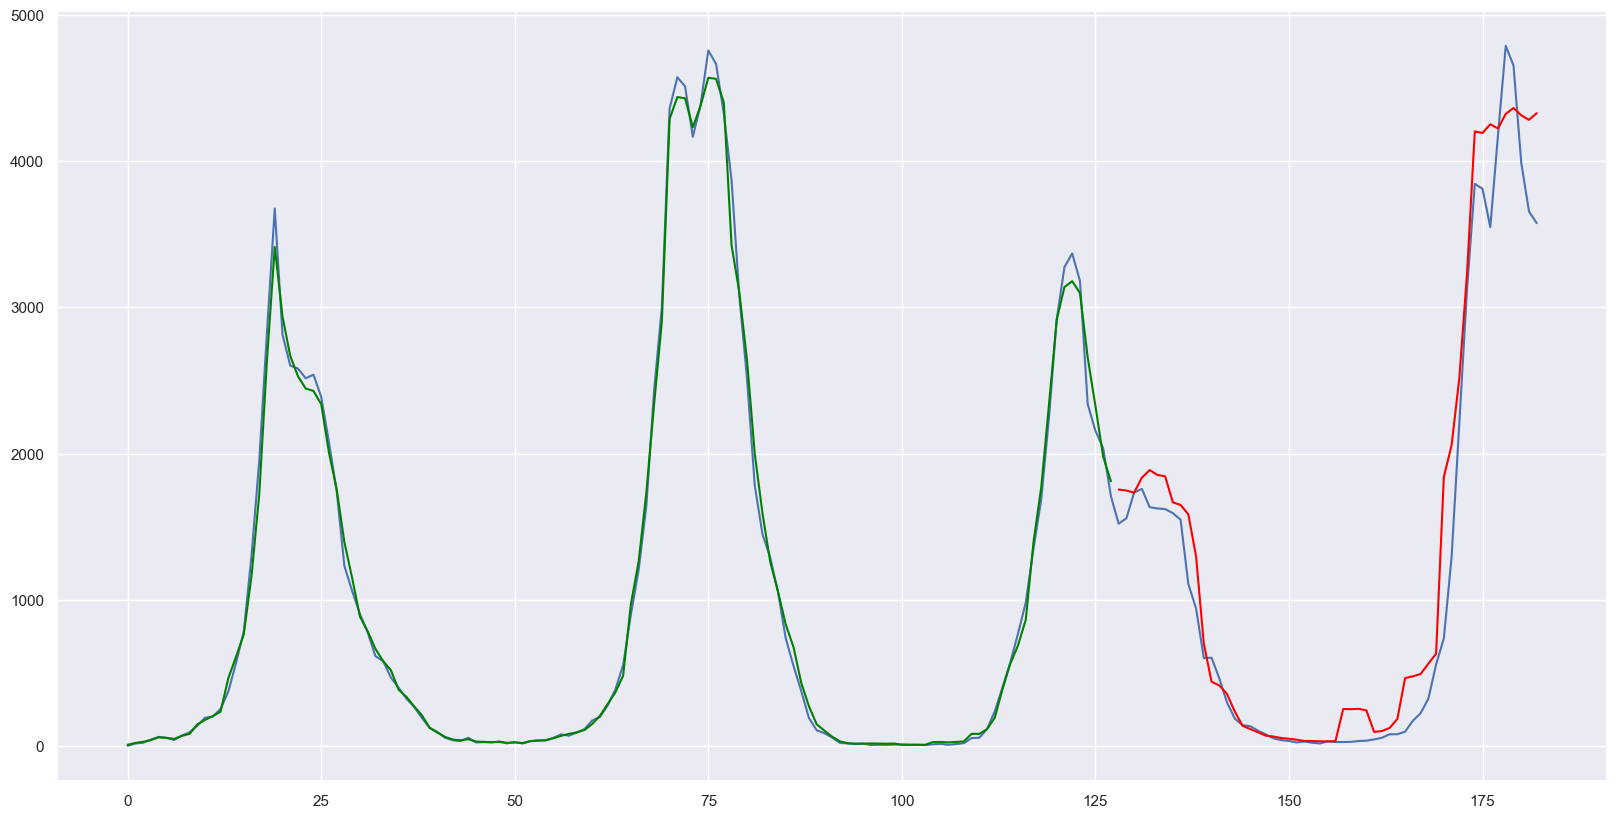

In [359]:
# plot
plt.plot(df.index, df['y1'].values)
plt.plot(df.index[:train_size], preds_train_df['y1'], color='green')
plt.plot(df.index[train_size:], preds_test_df['y1'], color='red')

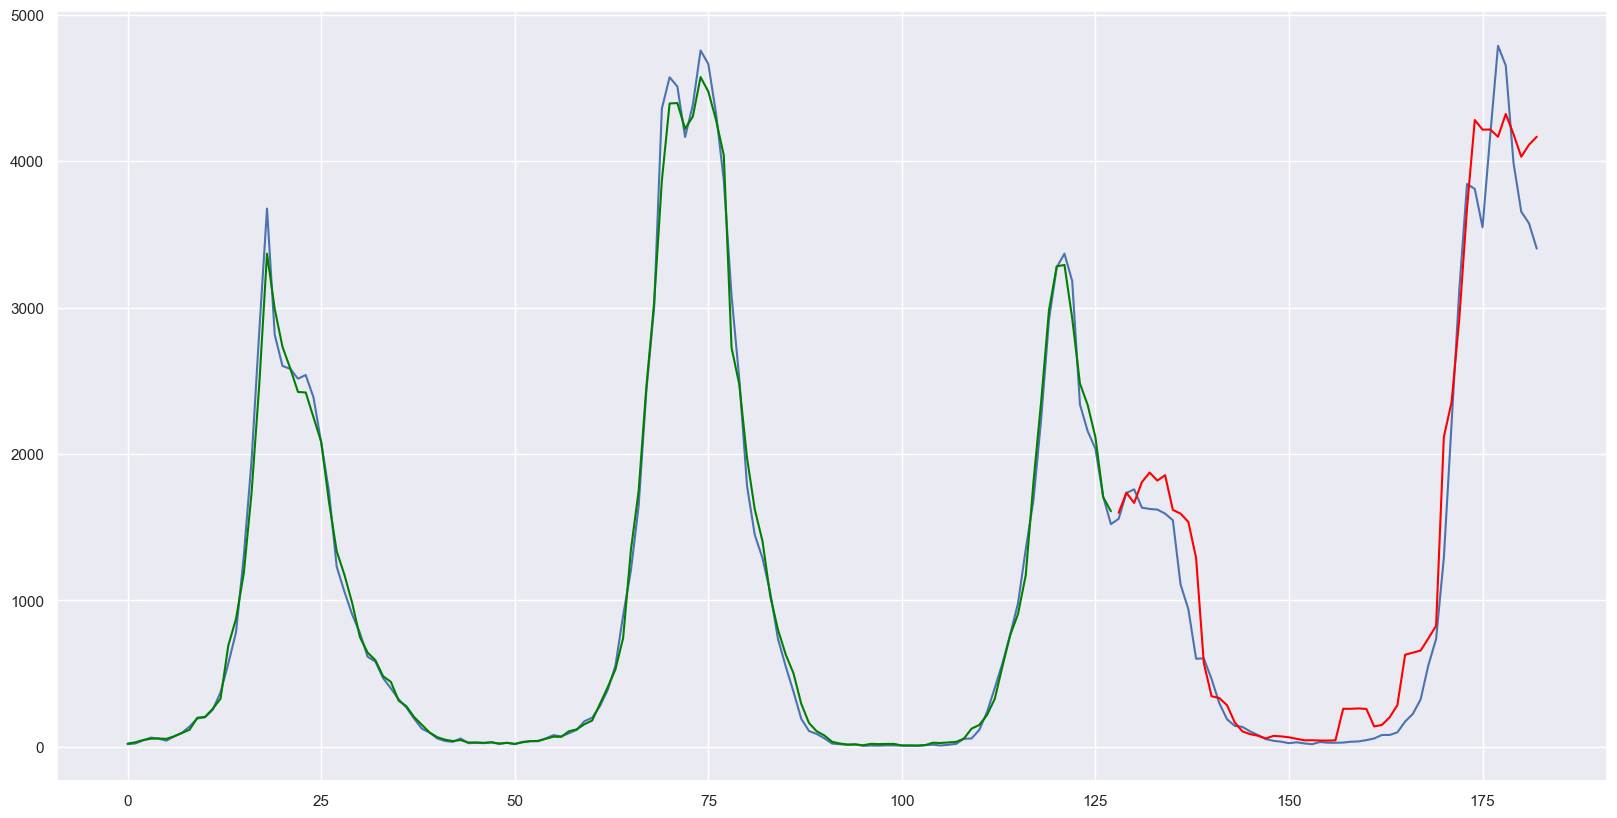

In [360]:
# plot 2-week ahead prediction
plt.plot(df.index, df['y2'].values)
plt.plot(df.index[:train_size], preds_train_df['y2'], color='green')
plt.plot(df.index[train_size:], preds_test_df['y2'], color='red')

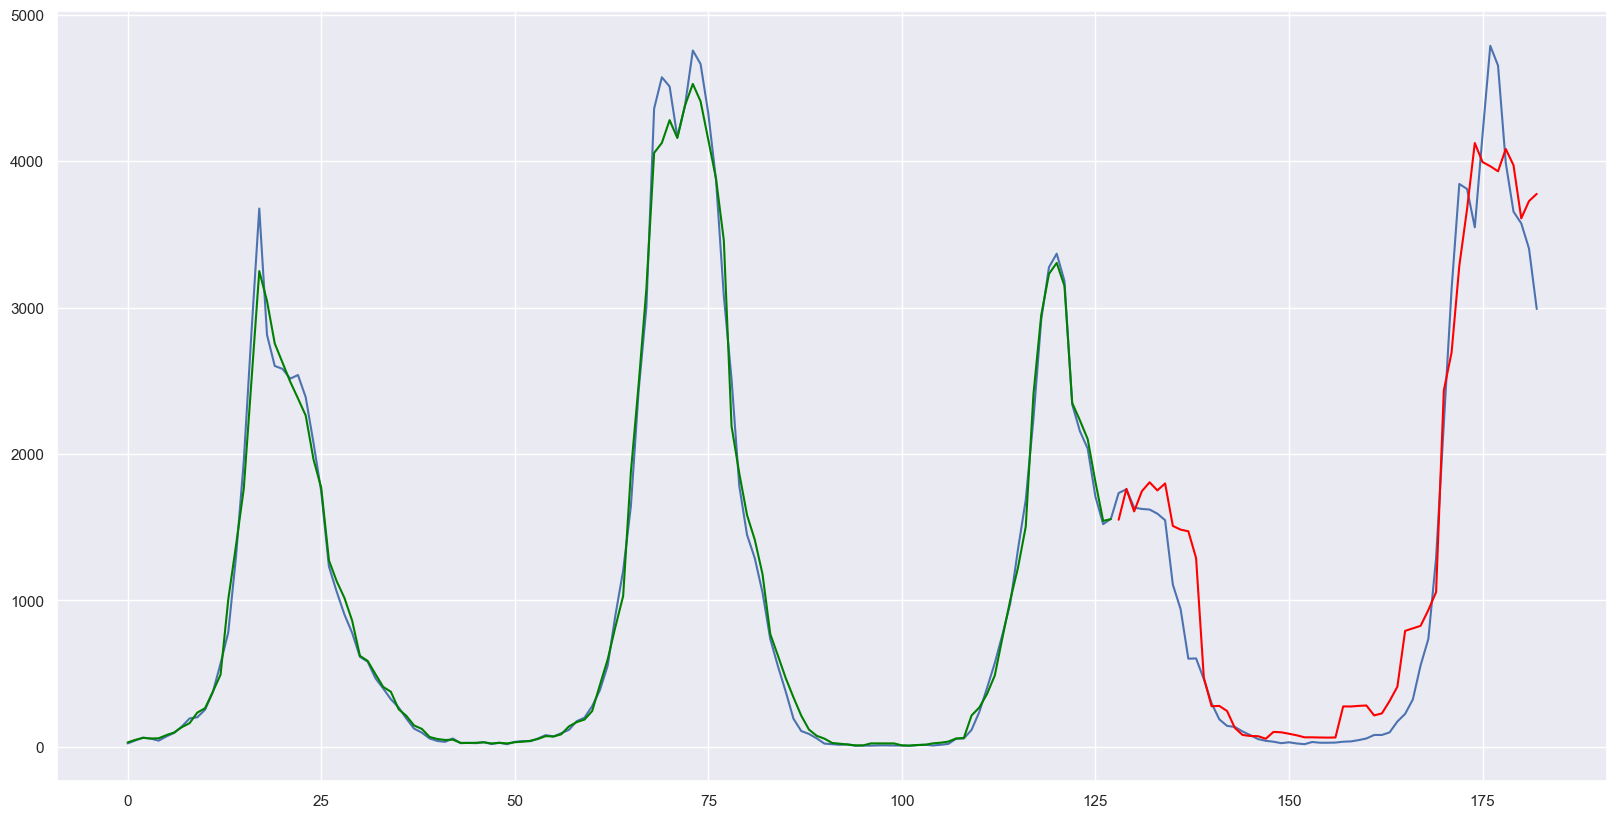

In [361]:
# plot 3-week ahead prediction
plt.plot(df.index, df['y3'].values)
plt.plot(df.index[:train_size], preds_train_df['y3'], color='green')
plt.plot(df.index[train_size:], preds_test_df['y3'], color='red')

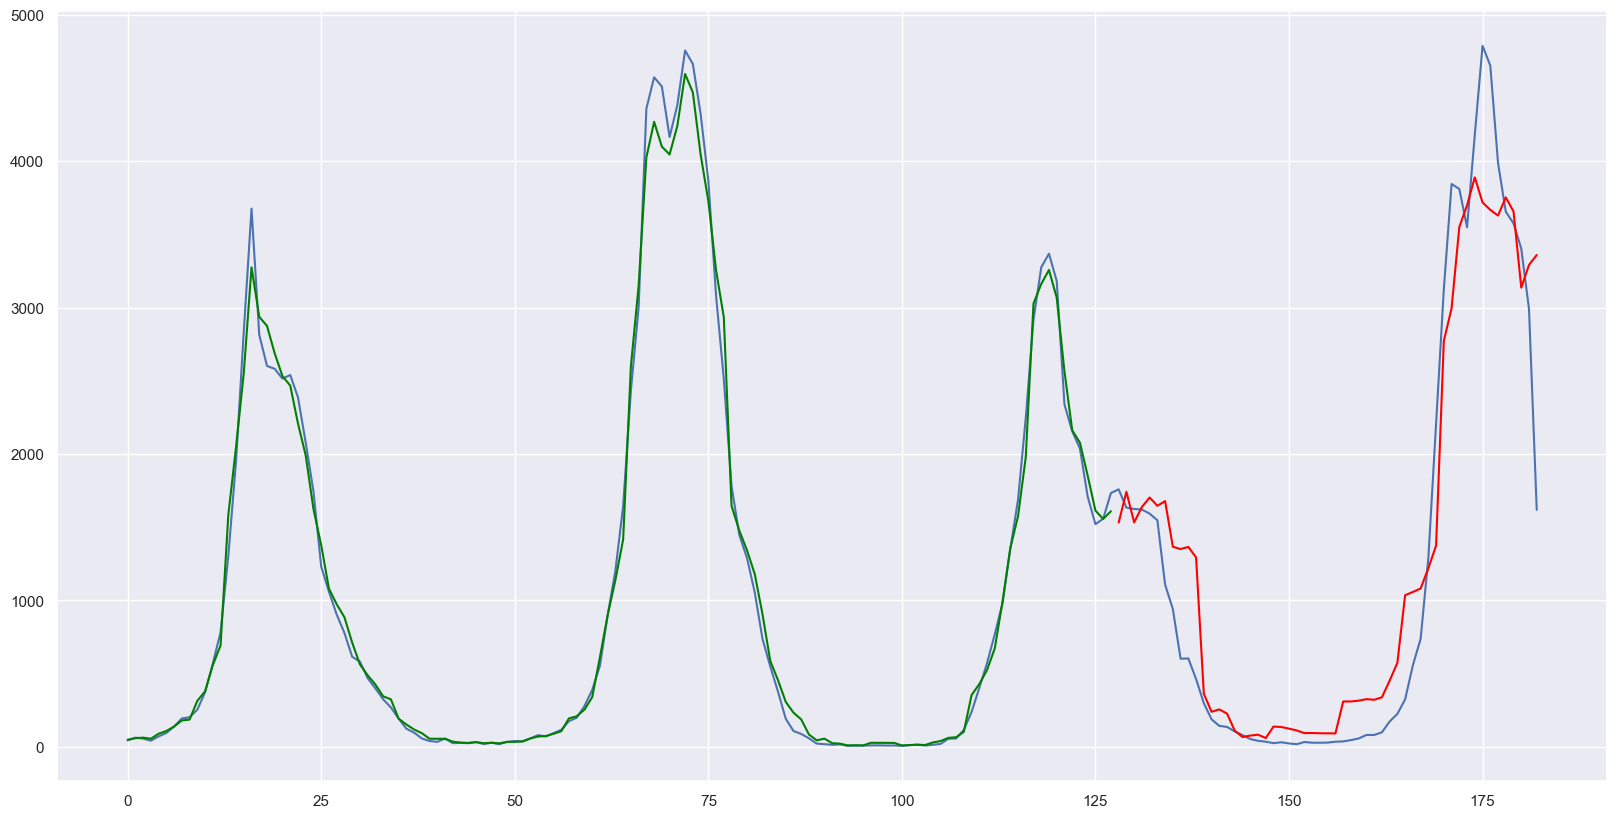

In [362]:
# plot 4-week ahead prediction
plt.plot(df.index, df['y4'].values)
plt.plot(df.index[:train_size], preds_train_df['y4'], color='green')
plt.plot(df.index[train_size:], preds_test_df['y4'], color='red')

In [363]:
# define the evaluation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=2022)
# evaluate the model and collect the scores
n_scores = cross_val_score(model, train_X, train_y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
# force the scores to be positive
n_scores = absolute(n_scores)
# summarize performance
print('RMSE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

RMSE: 289.013 (95.522)


In [364]:
# evaluate all four weeks of predictions

MSE_train = round(mean_squared_error(train_y, preds_train),3)
RMSE_train = round(mean_squared_error(train_y, preds_train, squared=False),3)
MAE_train = round(mean_absolute_error(train_y, preds_train),3)
print(f'MSE_train: {MSE_train}')
print(f'RMSE_train: {RMSE_train}')
print(f'MAE_train: {MAE_train}')

MSE_test = round(mean_squared_error(test_y, preds_test),3)
RMSE_test = round(mean_squared_error(test_y, preds_test, squared=False),3)
MAE_test = round(mean_absolute_error(test_y, preds_test),3)
print(f'MSE_test: {MSE_test}')
print(f'RMSE_test: {RMSE_test}')
print(f'MAE_test: {MAE_test}')


MSE_train: 11354.215
RMSE_train: 105.853
MAE_train: 62.986
MSE_test: 125054.697
RMSE_test: 348.59
MAE_test: 237.999


In [365]:
# evaluate 1-week ahead prediction only

MSE_train = round(mean_squared_error(train_y['y1'], preds_train_df['y1']),3)
RMSE_train = round(mean_squared_error(train_y['y1'], preds_train_df['y1'], squared=False),3)
MAE_train = round(mean_absolute_error(train_y['y1'], preds_train_df['y1']),3)
print(f'MSE_train: {MSE_train}')
print(f'RMSE_train: {RMSE_train}')
print(f'MAE_train: {MAE_train}')

MSE_test = round(mean_squared_error(test_y['y1'], preds_test_df['y1']),3)
RMSE_test = round(mean_squared_error(test_y['y1'], preds_test_df['y1'], squared=False),3)
MAE_test = round(mean_absolute_error(test_y['y1'], preds_test_df['y1']),3)
print(f'MSE_test: {MSE_test}')
print(f'RMSE_test: {RMSE_test}')
print(f'MAE_test: {MAE_test}')


MSE_train: 7591.633
RMSE_train: 87.13
MAE_train: 51.043
MSE_test: 96391.15
RMSE_test: 310.469
MAE_test: 206.922


In [366]:
# evaluate 2-week ahead prediction only

MSE_train = round(mean_squared_error(train_y['y2'], preds_train_df['y2']),3)
RMSE_train = round(mean_squared_error(train_y['y2'], preds_train_df['y2'], squared=False),3)
MAE_train = round(mean_absolute_error(train_y['y2'], preds_train_df['y2']),3)
print(f'MSE_train: {MSE_train}')
print(f'RMSE_train: {RMSE_train}')
print(f'MAE_train: {MAE_train}')

MSE_test = round(mean_squared_error(test_y['y2'], preds_test_df['y2']),3)
RMSE_test = round(mean_squared_error(test_y['y2'], preds_test_df['y2'], squared=False),3)
MAE_test = round(mean_absolute_error(test_y['y2'], preds_test_df['y2']),3)
print(f'MSE_test: {MSE_test}')
print(f'RMSE_test: {RMSE_test}')
print(f'MAE_test: {MAE_test}')


MSE_train: 10692.137
RMSE_train: 103.403
MAE_train: 60.915
MSE_test: 92682.127
RMSE_test: 304.437
MAE_test: 211.152


In [367]:
# evaluate 3-week ahead prediction only

MSE_train = round(mean_squared_error(train_y['y3'], preds_train_df['y3']),3)
RMSE_train = round(mean_squared_error(train_y['y3'], preds_train_df['y3'], squared=False),3)
MAE_train = round(mean_absolute_error(train_y['y3'], preds_train_df['y3']),3)
print(f'MSE_train: {MSE_train}')
print(f'RMSE_train: {RMSE_train}')
print(f'MAE_train: {MAE_train}')

MSE_test = round(mean_squared_error(test_y['y3'], preds_test_df['y3']),3)
RMSE_test = round(mean_squared_error(test_y['y3'], preds_test_df['y3'], squared=False),3)
MAE_test = round(mean_absolute_error(test_y['y3'], preds_test_df['y3']),3)
print(f'MSE_test: {MSE_test}')
print(f'RMSE_test: {RMSE_test}')
print(f'MAE_test: {MAE_test}')


MSE_train: 12902.558
RMSE_train: 113.589
MAE_train: 65.833
MSE_test: 108251.905
RMSE_test: 329.017
MAE_test: 232.889


In [368]:
# evaluate 4-week ahead prediction only

MSE_train = round(mean_squared_error(train_y['y4'], preds_train_df['y4']),4)
RMSE_train = round(mean_squared_error(train_y['y4'], preds_train_df['y4'], squared=False),4)
MAE_train = round(mean_absolute_error(train_y['y4'], preds_train_df['y4']),4)
print(f'MSE_train: {MSE_train}')
print(f'RMSE_train: {RMSE_train}')
print(f'MAE_train: {MAE_train}')

MSE_test = round(mean_squared_error(test_y['y4'], preds_test_df['y4']),4)
RMSE_test = round(mean_squared_error(test_y['y4'], preds_test_df['y4'], squared=False),4)
MAE_test = round(mean_absolute_error(test_y['y4'], preds_test_df['y4']),4)
print(f'MSE_test: {MSE_test}')
print(f'RMSE_test: {RMSE_test}')
print(f'MAE_test: {MAE_test}')

MSE_train: 14230.5317
RMSE_train: 119.2918
MAE_train: 74.1532
MSE_test: 202893.6073
RMSE_test: 450.4371
MAE_test: 301.0309


In [369]:
model.feature_importances_

array([2.57533097e-01, 1.42942985e-02, 1.25126062e-02, 8.53476439e-03,
       1.10499919e-02, 2.06298384e-02, 7.15049032e-03, 2.23717152e-02,
       1.00498265e-02, 3.31102260e-05, 2.00317118e-02, 4.56079823e-02,
       1.06071384e-01, 1.06072625e-03, 6.36577336e-03, 4.71892384e-02,
       4.73597322e-03, 3.07938785e-02, 1.38988487e-01, 2.34995107e-01])

Feature: 0, Score: 0.25753
Feature: 1, Score: 0.01429
Feature: 2, Score: 0.01251
Feature: 3, Score: 0.00853
Feature: 4, Score: 0.01105
Feature: 5, Score: 0.02063
Feature: 6, Score: 0.00715
Feature: 7, Score: 0.02237
Feature: 8, Score: 0.01005
Feature: 9, Score: 0.00003
Feature: 10, Score: 0.02003
Feature: 11, Score: 0.04561
Feature: 12, Score: 0.10607
Feature: 13, Score: 0.00106
Feature: 14, Score: 0.00637
Feature: 15, Score: 0.04719
Feature: 16, Score: 0.00474
Feature: 17, Score: 0.03079
Feature: 18, Score: 0.13899
Feature: 19, Score: 0.23500


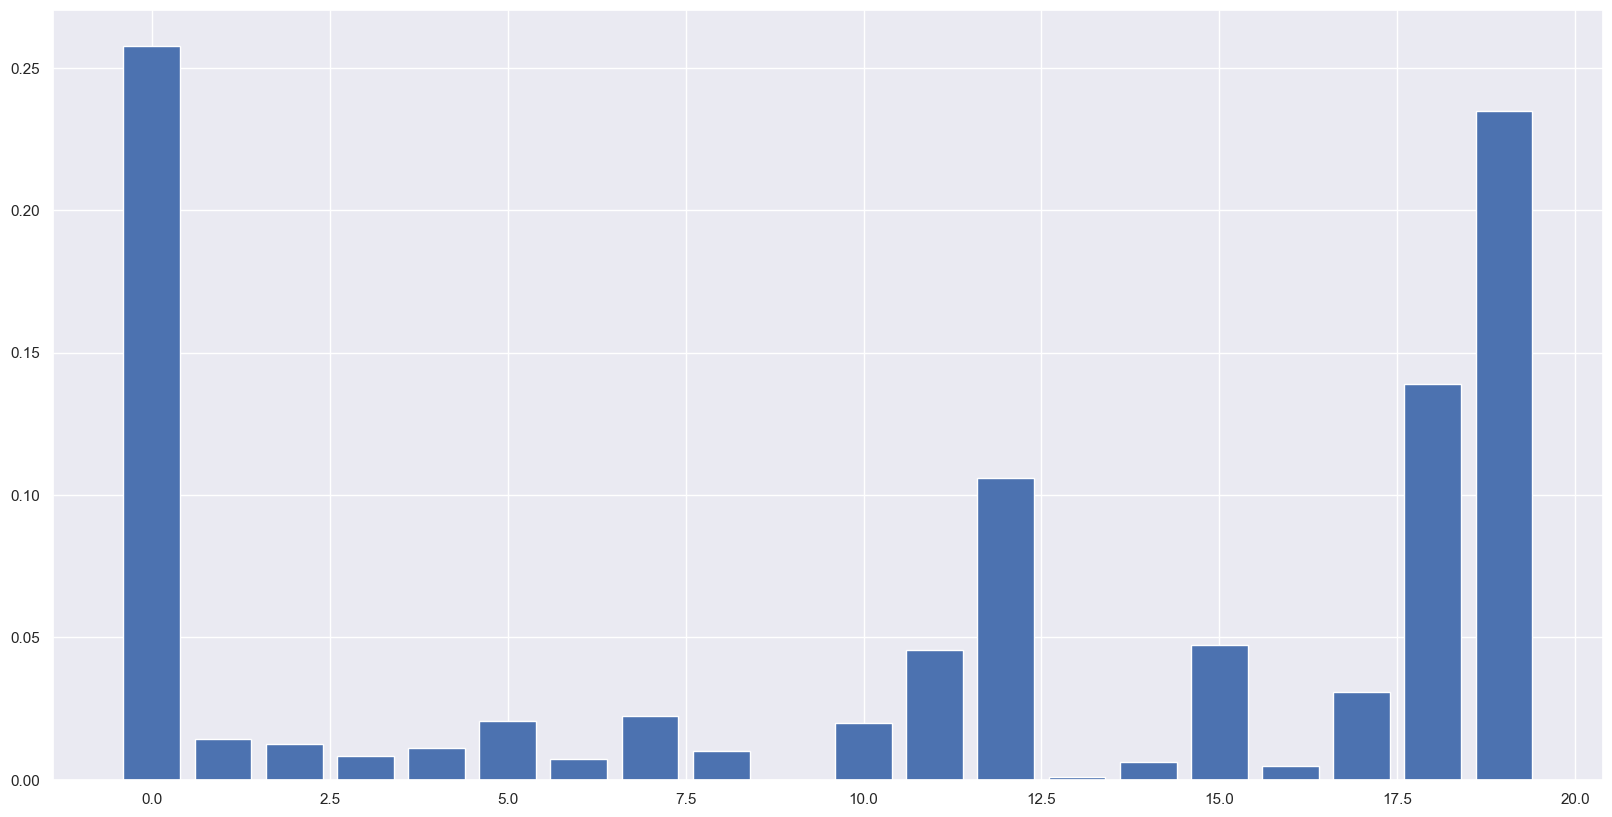

In [370]:
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [371]:
features

Index(['t - 1', 't - 2', 't - 3', 't - 4', 't - 6', 't - 7',
       'this week last year', 'two-week moving average', 'expanding mean',
       'vaccine', 'body_aches', 'chills', 'cough', 'diarrhea', 'fatigue',
       'flu', 'headache', 'runny_nose', 'sore_thoat', 'vomiting'],
      dtype='object')

<AxesSubplot: >

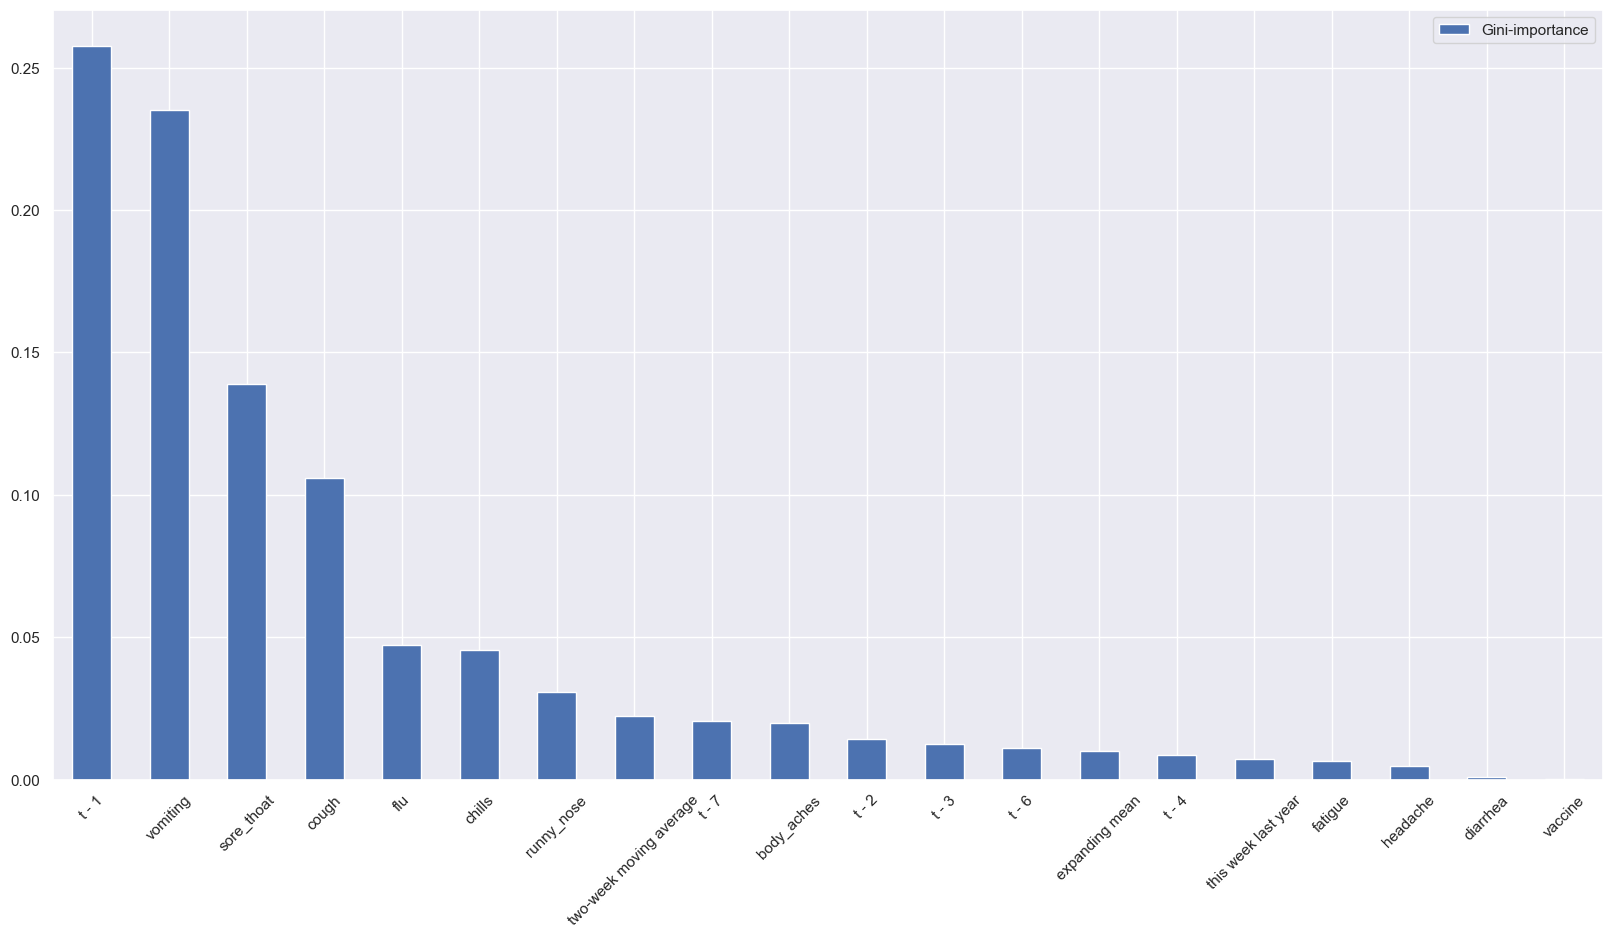

In [372]:
# https://stackoverflow.com/questions/41900387/mapping-column-names-to-random-forest-feature-importances

import pandas as pd
%matplotlib inline
#do code to support model
#"data" is the X dataframe and model is the SKlearn object

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(features, model.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance', ascending=False).plot(kind='bar', rot=45)

In [373]:
feats_to_remove = importances.sort_values('Gini-importance').iloc[0:10,:].index.to_list()

In [374]:
feats_to_remove

['vaccine',
 'diarrhea',
 'headache',
 'fatigue',
 'this week last year',
 't - 4',
 'expanding mean',
 't - 6',
 't - 3',
 't - 2']

In [376]:
for i in range(1,5):
    results_matrix = evaluate_model(train=train_y, test=test_y, preds_train=preds_train, preds_test=preds_test, dataset='Pre-COVID (time feats, remove M and Y) + COVID + flu terms', forecast_weeks=i)
results_matrix

Dataset Weeks-ahead Forecast  \
0                       Pre-COVID - (all time feats)                    1   
0                       Pre-COVID - (all time feats)                    2   
0                       Pre-COVID - (all time feats)                    3   
0                       Pre-COVID - (all time feats)                    4   
0             Pre-COVID (time feats, remove M and Y)                    1   
0             Pre-COVID (time feats, remove M and Y)                    2   
0             Pre-COVID (time feats, remove M and Y)                    3   
0             Pre-COVID (time feats, remove M and Y)                    4   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    1   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    2   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    3   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    4   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    1   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    2   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    3   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    4   

  MSE_train   MSE_test RMSE_train RMSE_test MAE_train MAE_test  R2_train  \
0   8645.66   97600.06      92.98    312.41     50.03   193.03  0.995238   
0  13142.62  192354.67     114.64    438.58     64.11   249.64  0.992735   
0  16733.42  287159.05     129.36    535.87     70.98    310.1  0.990716   
0  22529.88  358909.52      150.1    599.09     84.21   365.58  0.987464   
0   9987.75   89840.61      99.94    299.73     52.96    186.3  0.994499   
0  15031.57  172524.55      122.6    415.36     66.82   225.45   0.99169   
0  19320.23  259617.88      139.0    509.53     77.24   280.81  0.989281   
0   26457.7  320536.19     162.66    566.16     90.66   330.62  0.985279   
0   9359.49   68548.97      96.74    261.82     53.67   172.17  0.994845   
0  14962.43  136966.77     122.32    370.09     68.63    217.7  0.991728   
0  17838.93  213031.78     133.56    461.55     74.65   267.06  0.990103   
0  21819.18  291982.47     147.71    540.35     84.42   330.86   0.98786   
0   7591.63   96391.15      87.13    310.47     51.04   206.92  0.995819   
0  10692.14   92682.13      103.4    304.44     60.91   211.15  0.994089   
0  12902.56  108251.91     113.59    329.02     65.83   232.89  0.992841   
0  14230.53  202893.61     119.29    450.44     74.15   301.03  0.992082   

    R2_test  
0  0.952997  
0  0.911083  
0  0.870534  
0  0.838051  
0  0.956733  
0  0.920249  
0  0.882951  
0  0.855366  
0  0.966987  
0  0.936686  
0  0.903955  
0   0.86825  
0  0.953579  
0  0.957157  
0  0.951195  
0  0.908449

In [377]:
results_matrix.sort_values('RMSE_test')

Dataset Weeks-ahead Forecast  \
0  Pre-COVID (time feats, remove M and Y) + COVID...                    1   
0             Pre-COVID (time feats, remove M and Y)                    1   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    2   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    1   
0                       Pre-COVID - (all time feats)                    1   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    3   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    2   
0             Pre-COVID (time feats, remove M and Y)                    2   
0                       Pre-COVID - (all time feats)                    2   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    4   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    3   
0             Pre-COVID (time feats, remove M and Y)                    3   
0                       Pre-COVID - (all time feats)                    3   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    4   
0             Pre-COVID (time feats, remove M and Y)                    4   
0                       Pre-COVID - (all time feats)                    4   

  MSE_train   MSE_test RMSE_train RMSE_test MAE_train MAE_test  R2_train  \
0   9359.49   68548.97      96.74    261.82     53.67   172.17  0.994845   
0   9987.75   89840.61      99.94    299.73     52.96    186.3  0.994499   
0  10692.14   92682.13      103.4    304.44     60.91   211.15  0.994089   
0   7591.63   96391.15      87.13    310.47     51.04   206.92  0.995819   
0   8645.66   97600.06      92.98    312.41     50.03   193.03  0.995238   
0  12902.56  108251.91     113.59    329.02     65.83   232.89  0.992841   
0  14962.43  136966.77     122.32    370.09     68.63    217.7  0.991728   
0  15031.57  172524.55      122.6    415.36     66.82   225.45   0.99169   
0  13142.62  192354.67     114.64    438.58     64.11   249.64  0.992735   
0  14230.53  202893.61     119.29    450.44     74.15   301.03  0.992082   
0  17838.93  213031.78     133.56    461.55     74.65   267.06  0.990103   
0  19320.23  259617.88      139.0    509.53     77.24   280.81  0.989281   
0  16733.42  287159.05     129.36    535.87     70.98    310.1  0.990716   
0  21819.18  291982.47     147.71    540.35     84.42   330.86   0.98786   
0   26457.7  320536.19     162.66    566.16     90.66   330.62  0.985279   
0  22529.88  358909.52      150.1    599.09     84.21   365.58  0.987464   

    R2_test  
0  0.966987  
0  0.956733  
0  0.957157  
0  0.953579  
0  0.952997  
0  0.951195  
0  0.936686  
0  0.920249  
0  0.911083  
0  0.908449  
0  0.903955  
0  0.882951  
0  0.870534  
0   0.86825  
0  0.855366  
0  0.838051

In [380]:
results_matrix.sort_values('RMSE_test')['Dataset']

0    Pre-COVID (time feats, remove M and Y) + COVID...
0               Pre-COVID (time feats, remove M and Y)
0    Pre-COVID (time feats, remove M and Y) + COVID...
0    Pre-COVID (time feats, remove M and Y) + COVID...
0                         Pre-COVID - (all time feats)
0    Pre-COVID (time feats, remove M and Y) + COVID...
0    Pre-COVID (time feats, remove M and Y) + COVID...
0               Pre-COVID (time feats, remove M and Y)
0                         Pre-COVID - (all time feats)
0    Pre-COVID (time feats, remove M and Y) + COVID...
0    Pre-COVID (time feats, remove M and Y) + COVID...
0               Pre-COVID (time feats, remove M and Y)
0                         Pre-COVID - (all time feats)
0    Pre-COVID (time feats, remove M and Y) + COVID...
0               Pre-COVID (time feats, remove M and Y)
0                         Pre-COVID - (all time feats)
Name: Dataset, dtype: object

# Random Forest Regression - All Features

In [391]:
df_pre_COVID_all_features = pickle.load(open(r"..\data\df_pre_COVID_all_features.pkl", "rb" ))
# df_time_features = pickle.load(open(r"..\data\flu_cases\df_time_features.pkl", "rb" ))

# df_COVID_terms_pre_COVID = pickle.load(open(r"..\data\google_trend\df_COVID_terms_pre_COVID.pkl", "rb" ))
# df_COVID_terms = pickle.load(open(r"..\data\google_trend\df_COVID_terms.pkl", "rb" ))

# df_flu_symptoms_pre_COVID = pickle.load(open(r"..\data\google_trend\df_flu_symptoms_pre_COVID.pkl", "rb" ))
# df_flu_symptoms = pickle.load(open(r"..\data\google_trend\df_flu_symptoms.pkl", "rb" ))

In [392]:
df_pre_COVID_all_features.shape

(157, 84)

In [393]:
df_pre_COVID_all_features.columns

Index(['Total Cases', 'Perceived health very good or excellent 13',
       'Perceived health fair or poor 13',
       'Perceived mental health very good or excellent 14',
       'Perceived mental health fair or poor 14',
       'Perceived life stress most days quite a bit or extremely stressful 15',
       'Body mass index adjusted self-reported adult (18 years and over) overweight 16 17 18 19 20 21',
       'Body mass index adjusted self-reported adult (18 years and over) obese 16 17 18 19 20 21',
       'Body mass index self-reported youth (12 to 17 years old) overweight or obese 16 17 18 19 21',
       'Arthritis (15 years and over) 22', 'Diabetes 23', 'Asthma 24 25',
       'Chronic obstructive pulmonary disease (COPD; 35 years and over) 25 26 27',
       'High blood pressure 27 28', 'Mood disorder 29',
       'Current smoker daily or occasional 30 31 32 33 34',
       'Current smoker daily 30 31 32 33', 'Heavy drinking 37',
       'Self-reported physical activity 150 minutes per w

In [394]:
df = df_pre_COVID_all_features

In [395]:
# df.dropna(inplace=True)
# df = df.reset_index(drop=True)
# df = df.drop(columns=['year_2016', 'year_2017', 'year_2018', 'year_2019',
#        'year_2020', 'year_2021', 'year_2022', 'month_10', 'month_11',
#        'month_12', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
#        'month_7', 'month_8', 'month_9','Total Cases','month', 'year', 'week','COVID',
#  'season_Spring',
#  'social_distancing',
#  'season_Winter',
#  'mask',
#  'quarantine',
#  'lockdown',
#  'coronavirus',
#  'season_Summer',
#  't - 5','fever'])

In [396]:
df

Total Cases  Perceived health very good or excellent 13  \
78        2078.0                                  18714100.0   
79        1745.0                                  18714100.0   
80        1231.0                                  18714100.0   
81        1060.0                                  18714100.0   
82         904.0                                  18714100.0   
..           ...                                         ...   
230       4789.0                                  19464600.0   
231       4654.0                                  19464600.0   
232       3989.0                                  19464600.0   
233       3656.0                                  19464600.0   
234       3576.0                                  19464600.0   

     Perceived health fair or poor 13  \
78                          3443000.0   
79                          3443000.0   
80                          3443000.0   
81                          3443000.0   
82                          3443000.0   
..                                ...   
230                         3464200.0   
231                         3464200.0   
232                         3464200.0   
233                         3464200.0   
234                         3464200.0   

     Perceived mental health very good or excellent 14  \
78                                          21023500.0   
79                                          21023500.0   
80                                          21023500.0   
81                                          21023500.0   
82                                          21023500.0   
..                                                 ...   
230                                         20701100.0   
231                                         20701100.0   
232                                         20701100.0   
233                                         20701100.0   
234                                         20701100.0   

     Perceived mental health fair or poor 14  \
78                                 2053000.0   
79                                 2053000.0   
80                                 2053000.0   
81                                 2053000.0   
82                                 2053000.0   
..                                       ...   
230                                2494800.0   
231                                2494800.0   
232                                2494800.0   
233                                2494800.0   
234                                2494800.0   

     Perceived life stress most days quite a bit or extremely stressful 15  \
78                                           6564200.0                       
79                                           6564200.0                       
80                                           6564200.0                       
81                                           6564200.0                       
82                                           6564200.0                       
..                                                 ...                       
230                                          6729400.0                       
231                                          6729400.0                       
232                                          6729400.0                       
233                                          6729400.0                       
234                                          6729400.0                       

     Body mass index adjusted self-reported adult (18 years and over) overweight 16 17 18 19 20 21  \
78                                           9484900.0                                               
79                                           9484900.0                                               
80                                           9484900.0                                               
81                                           9484900.0                                               
82                    

In [390]:
df.columns

Index(['Total Cases', 'Perceived health very good or excellent 13',
       'Perceived health fair or poor 13',
       'Perceived mental health very good or excellent 14',
       'Perceived mental health fair or poor 14',
       'Perceived life stress most days quite a bit or extremely stressful 15',
       'Body mass index adjusted self-reported adult (18 years and over) overweight 16 17 18 19 20 21',
       'Body mass index adjusted self-reported adult (18 years and over) obese 16 17 18 19 20 21',
       'Body mass index self-reported youth (12 to 17 years old) overweight or obese 16 17 18 19 21',
       'Arthritis (15 years and over) 22', 'Diabetes 23', 'Asthma 24 25',
       'Chronic obstructive pulmonary disease (COPD; 35 years and over) 25 26 27',
       'High blood pressure 27 28', 'Mood disorder 29',
       'Current smoker daily or occasional 30 31 32 33 34',
       'Current smoker daily 30 31 32 33', 'Heavy drinking 37',
       'Self-reported physical activity 150 minutes per w

In [398]:
df.drop(columns='Total Cases', inplace=True)

In [402]:
df.columns

Index(['Perceived health very good or excellent 13',
       'Perceived health fair or poor 13',
       'Perceived mental health very good or excellent 14',
       'Perceived mental health fair or poor 14',
       'Perceived life stress most days quite a bit or extremely stressful 15',
       'Body mass index adjusted self-reported adult (18 years and over) overweight 16 17 18 19 20 21',
       'Body mass index adjusted self-reported adult (18 years and over) obese 16 17 18 19 20 21',
       'Body mass index self-reported youth (12 to 17 years old) overweight or obese 16 17 18 19 21',
       'Arthritis (15 years and over) 22', 'Diabetes 23', 'Asthma 24 25',
       'Chronic obstructive pulmonary disease (COPD; 35 years and over) 25 26 27',
       'High blood pressure 27 28', 'Mood disorder 29',
       'Current smoker daily or occasional 30 31 32 33 34',
       'Current smoker daily 30 31 32 33', 'Heavy drinking 37',
       'Self-reported physical activity 150 minutes per week adult (18 y

In [399]:
train_size = int(len(df) *.7)
test_size = len(df) - train_size
train, test = df[0:train_size], df[train_size:len(df)]

In [400]:
train_y = train[['y1','y2','y3','y4']]
train_X = train.drop(columns=['y1','y2','y3','y4'])
test_y = test[['y1','y2','y3','y4']]
test_X = test.drop(columns=['y1','y2','y3','y4'])

In [401]:
features = train_X.columns

In [ ]:
col_to_scale = ['t - 1', 't - 2', 't - 3', 't - 4', 't - 5',
       't - 6', 't - 7', 'this week last year', 'two-week moving average',
       'expanding mean','coronavirus', 'COVID',
       'lockdown', 'mask', 'quarantine', 'social_distancing', 'vaccine']
col_not_to_scale = ['season_Spring', 'season_Summer', 'season_Winter']

In [404]:
train_X_to_scale = train_X.loc[:,:'expanding mean']
test_X_to_scale = test_X.loc[:,:'expanding mean']
train_X_not_to_scale = train_X.loc[:,'year_2016':].to_numpy()
test_X_not_to_scale = test_X.loc[:,'year_2016':].to_numpy()

In [405]:
from sklearn.preprocessing import MinMaxScaler

# scale data
scaler = MinMaxScaler()
train_X_to_scale = scaler.fit_transform(train_X_to_scale)
test_X_to_scale = scaler.transform(test_X_to_scale)

In [406]:
train_X = np.concatenate((train_X_to_scale, train_X_not_to_scale),axis=1)
test_X = np.concatenate((test_X_to_scale, test_X_not_to_scale),axis=1)

In [407]:
train_X.shape

(109, 79)

In [408]:
test_X.shape

(48, 79)

In [409]:
train_y.shape

(109, 4)

In [410]:
test_y.shape

(48, 4)

In [411]:
model = RandomForestRegressor()

model.fit(train_X, train_y)

RandomForestRegressor()

In [412]:
preds_test = model.predict(test_X)
preds_test_df = pd.DataFrame(preds_test,columns=test_y.columns)
preds_train = model.predict(train_X)
preds_train_df = pd.DataFrame(preds_train,columns=train_y.columns)

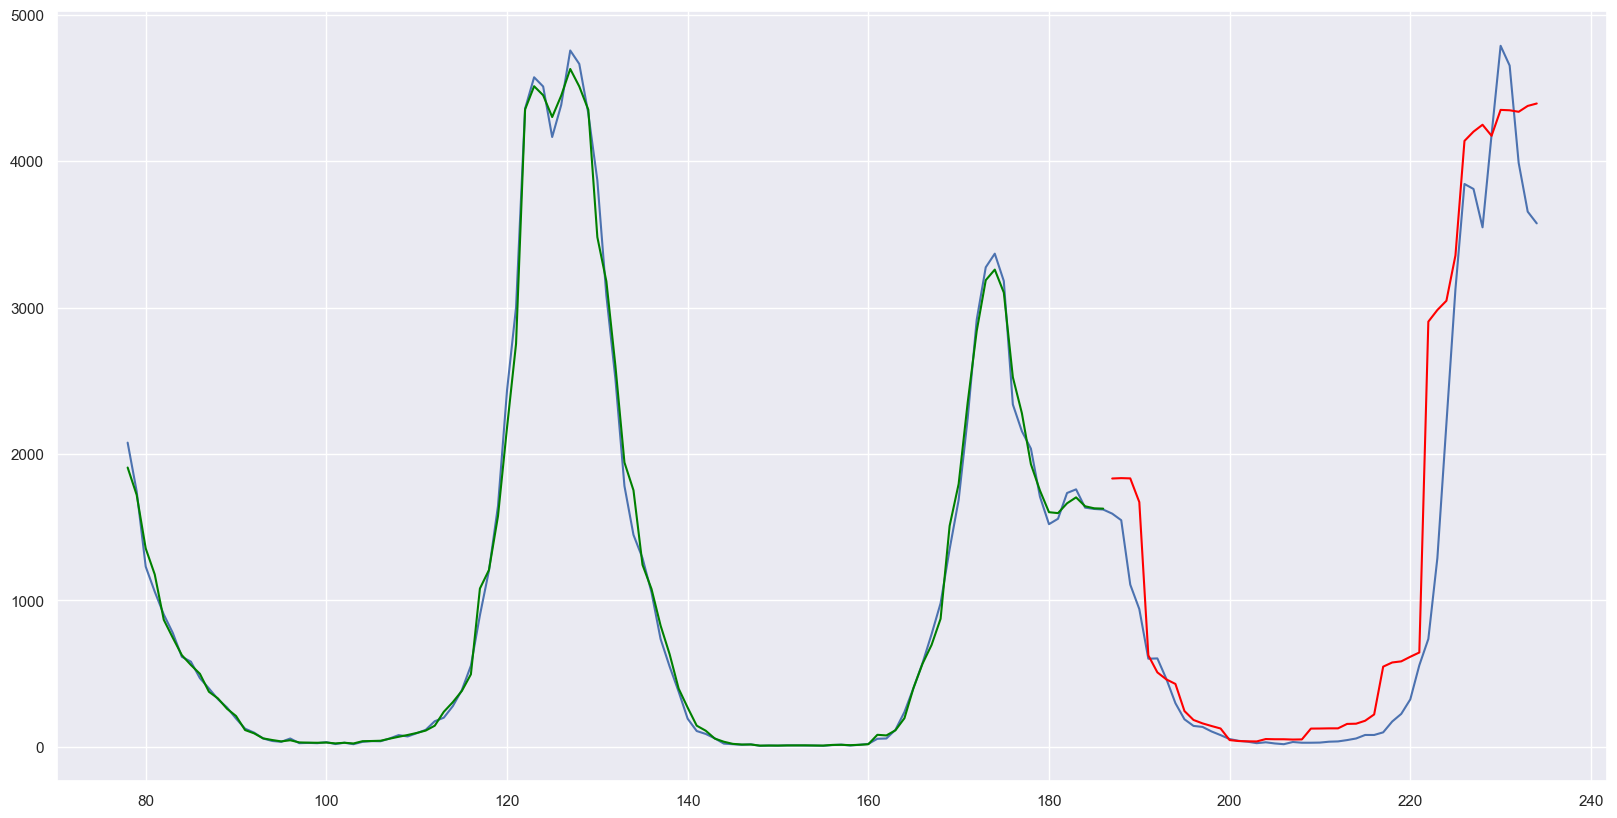

In [413]:
# plot
plt.plot(df.index, df['y1'].values)
plt.plot(df.index[:train_size], preds_train_df['y1'], color='green')
plt.plot(df.index[train_size:], preds_test_df['y1'], color='red')

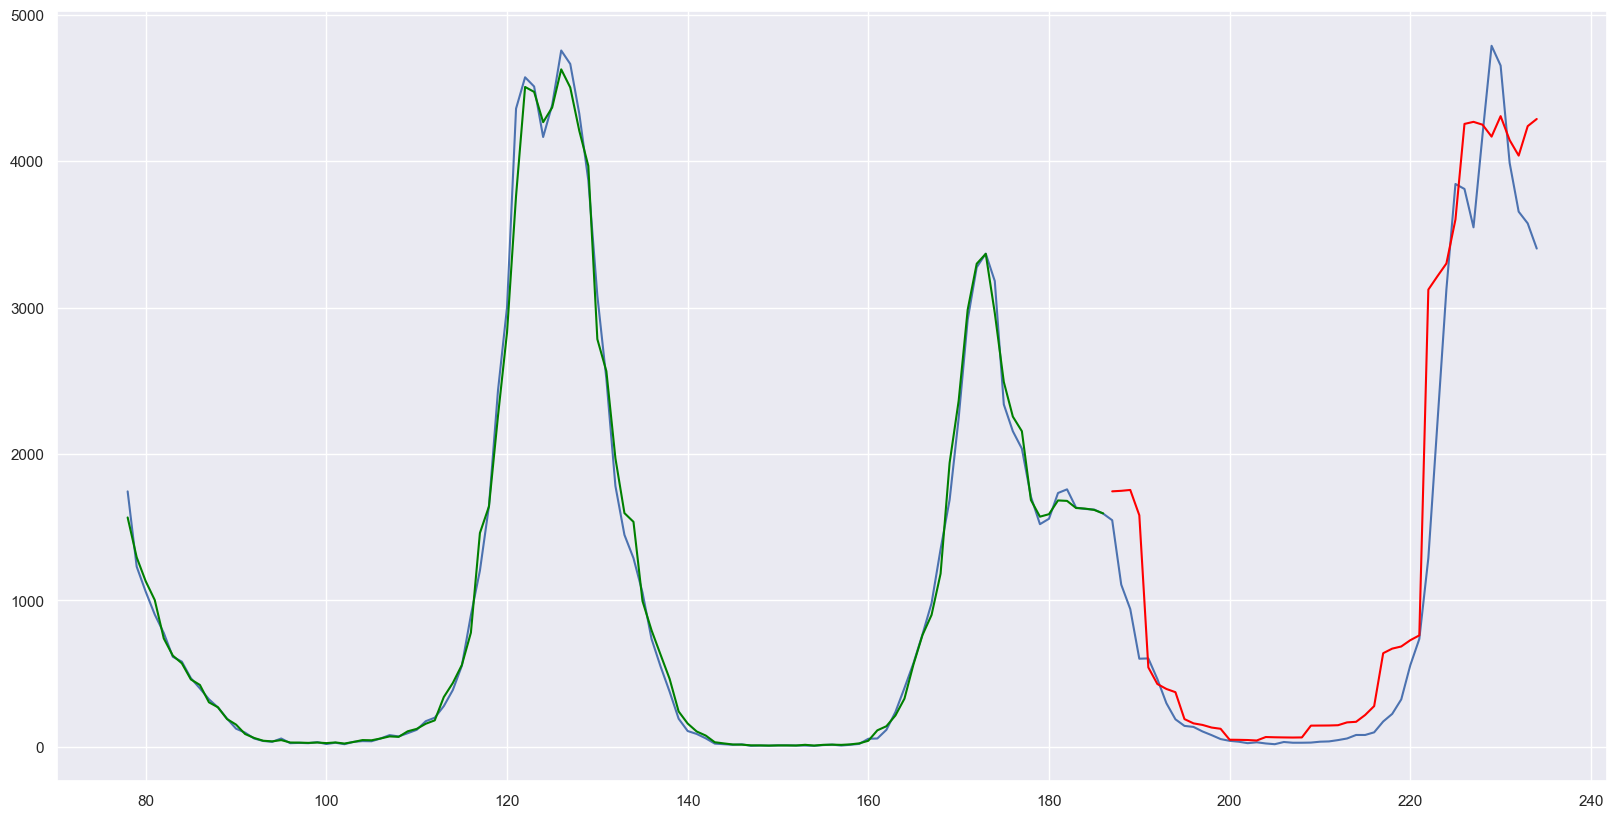

In [414]:
# plot 2-week ahead prediction
plt.plot(df.index, df['y2'].values)
plt.plot(df.index[:train_size], preds_train_df['y2'], color='green')
plt.plot(df.index[train_size:], preds_test_df['y2'], color='red')

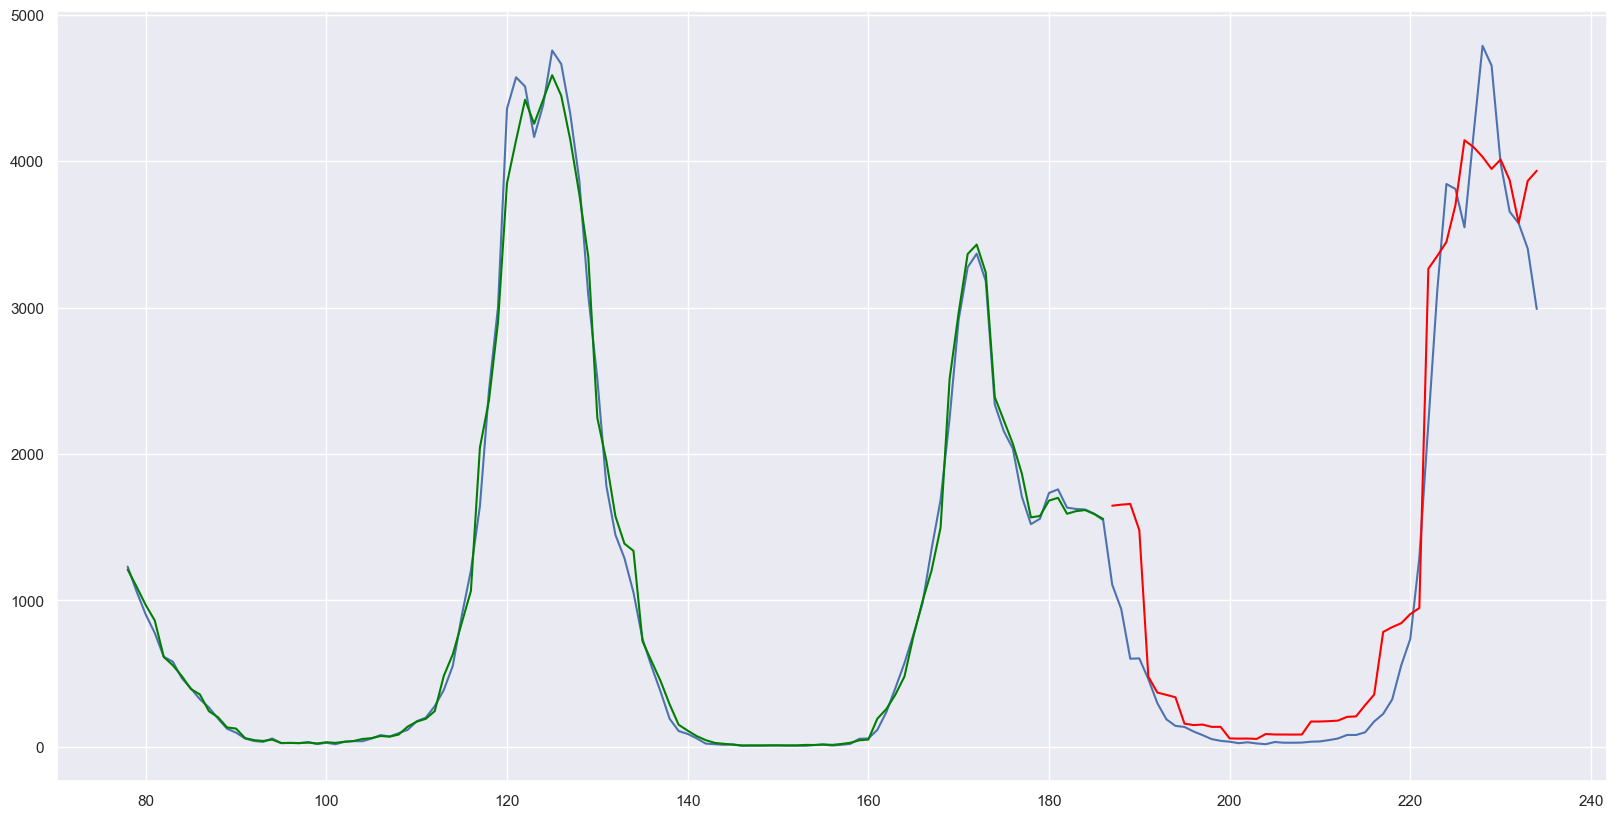

In [415]:
# plot 3-week ahead prediction
plt.plot(df.index, df['y3'].values)
plt.plot(df.index[:train_size], preds_train_df['y3'], color='green')
plt.plot(df.index[train_size:], preds_test_df['y3'], color='red')

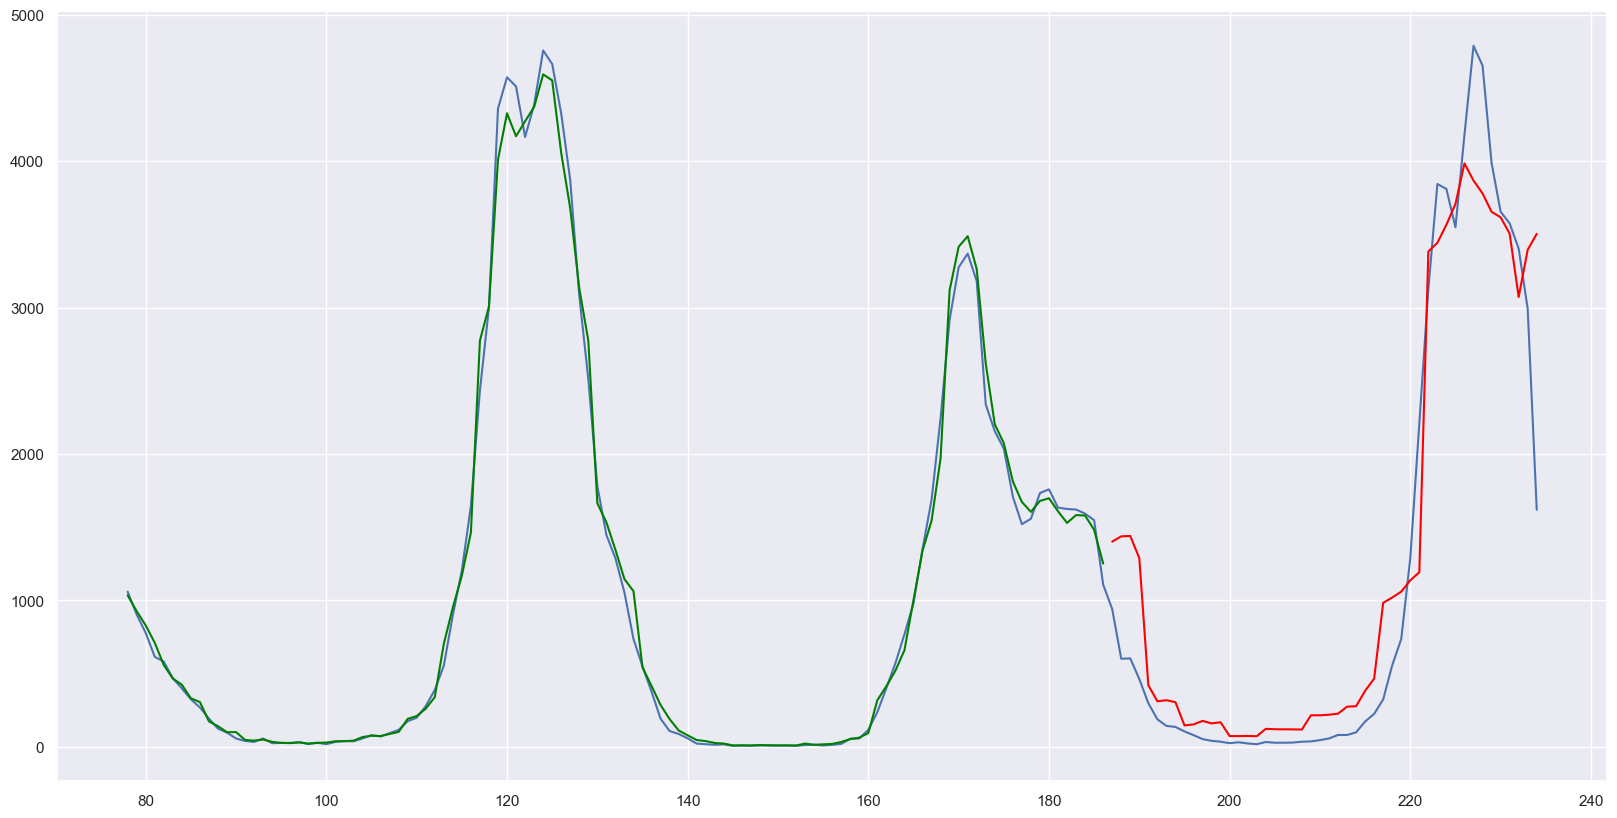

In [416]:
# plot 4-week ahead prediction
plt.plot(df.index, df['y4'].values)
plt.plot(df.index[:train_size], preds_train_df['y4'], color='green')
plt.plot(df.index[train_size:], preds_test_df['y4'], color='red')

In [417]:
# define the evaluation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=2022)
# evaluate the model and collect the scores
n_scores = cross_val_score(model, train_X, train_y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
# force the scores to be positive
n_scores = absolute(n_scores)
# summarize performance
print('RMSE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

RMSE: 271.070 (102.838)


In [418]:
# evaluate all four weeks of predictions

MSE_train = round(mean_squared_error(train_y, preds_train),3)
RMSE_train = round(mean_squared_error(train_y, preds_train, squared=False),3)
MAE_train = round(mean_absolute_error(train_y, preds_train),3)
print(f'MSE_train: {MSE_train}')
print(f'RMSE_train: {RMSE_train}')
print(f'MAE_train: {MAE_train}')

MSE_test = round(mean_squared_error(test_y, preds_test),3)
RMSE_test = round(mean_squared_error(test_y, preds_test, squared=False),3)
MAE_test = round(mean_absolute_error(test_y, preds_test),3)
print(f'MSE_test: {MSE_test}')
print(f'RMSE_test: {RMSE_test}')
print(f'MAE_test: {MAE_test}')


MSE_train: 10248.401
RMSE_train: 100.8
MAE_train: 57.176
MSE_test: 211813.615
RMSE_test: 458.51
MAE_test: 287.794


In [419]:
# evaluate 1-week ahead prediction only

MSE_train = round(mean_squared_error(train_y['y1'], preds_train_df['y1']),3)
RMSE_train = round(mean_squared_error(train_y['y1'], preds_train_df['y1'], squared=False),3)
MAE_train = round(mean_absolute_error(train_y['y1'], preds_train_df['y1']),3)
print(f'MSE_train: {MSE_train}')
print(f'RMSE_train: {RMSE_train}')
print(f'MAE_train: {MAE_train}')

MSE_test = round(mean_squared_error(test_y['y1'], preds_test_df['y1']),3)
RMSE_test = round(mean_squared_error(test_y['y1'], preds_test_df['y1'], squared=False),3)
MAE_test = round(mean_absolute_error(test_y['y1'], preds_test_df['y1']),3)
print(f'MSE_test: {MSE_test}')
print(f'RMSE_test: {RMSE_test}')
print(f'MAE_test: {MAE_test}')


MSE_train: 7314.275
RMSE_train: 85.524
MAE_train: 50.213
MSE_test: 261944.966
RMSE_test: 511.806
MAE_test: 290.863


In [420]:
# evaluate 2-week ahead prediction only

MSE_train = round(mean_squared_error(train_y['y2'], preds_train_df['y2']),3)
RMSE_train = round(mean_squared_error(train_y['y2'], preds_train_df['y2'], squared=False),3)
MAE_train = round(mean_absolute_error(train_y['y2'], preds_train_df['y2']),3)
print(f'MSE_train: {MSE_train}')
print(f'RMSE_train: {RMSE_train}')
print(f'MAE_train: {MAE_train}')

MSE_test = round(mean_squared_error(test_y['y2'], preds_test_df['y2']),3)
RMSE_test = round(mean_squared_error(test_y['y2'], preds_test_df['y2'], squared=False),3)
MAE_test = round(mean_absolute_error(test_y['y2'], preds_test_df['y2']),3)
print(f'MSE_test: {MSE_test}')
print(f'RMSE_test: {RMSE_test}')
print(f'MAE_test: {MAE_test}')


MSE_train: 10207.106
RMSE_train: 101.03
MAE_train: 55.078
MSE_test: 206830.951
RMSE_test: 454.787
MAE_test: 280.527


In [421]:
# evaluate 3-week ahead prediction only

MSE_train = round(mean_squared_error(train_y['y3'], preds_train_df['y3']),3)
RMSE_train = round(mean_squared_error(train_y['y3'], preds_train_df['y3'], squared=False),3)
MAE_train = round(mean_absolute_error(train_y['y3'], preds_train_df['y3']),3)
print(f'MSE_train: {MSE_train}')
print(f'RMSE_train: {RMSE_train}')
print(f'MAE_train: {MAE_train}')

MSE_test = round(mean_squared_error(test_y['y3'], preds_test_df['y3']),3)
RMSE_test = round(mean_squared_error(test_y['y3'], preds_test_df['y3'], squared=False),3)
MAE_test = round(mean_absolute_error(test_y['y3'], preds_test_df['y3']),3)
print(f'MSE_test: {MSE_test}')
print(f'RMSE_test: {RMSE_test}')
print(f'MAE_test: {MAE_test}')


MSE_train: 12055.994
RMSE_train: 109.8
MAE_train: 59.938
MSE_test: 160165.391
RMSE_test: 400.207
MAE_test: 269.544


In [422]:
# evaluate 4-week ahead prediction only

MSE_train = round(mean_squared_error(train_y['y4'], preds_train_df['y4']),4)
RMSE_train = round(mean_squared_error(train_y['y4'], preds_train_df['y4'], squared=False),4)
MAE_train = round(mean_absolute_error(train_y['y4'], preds_train_df['y4']),4)
print(f'MSE_train: {MSE_train}')
print(f'RMSE_train: {RMSE_train}')
print(f'MAE_train: {MAE_train}')

MSE_test = round(mean_squared_error(test_y['y4'], preds_test_df['y4']),4)
RMSE_test = round(mean_squared_error(test_y['y4'], preds_test_df['y4'], squared=False),4)
MAE_test = round(mean_absolute_error(test_y['y4'], preds_test_df['y4']),4)
print(f'MSE_test: {MSE_test}')
print(f'RMSE_test: {RMSE_test}')
print(f'MAE_test: {MAE_test}')

MSE_train: 11416.2289
RMSE_train: 106.8468
MAE_train: 63.4741
MSE_test: 218313.1543
RMSE_test: 467.2399
MAE_test: 310.2427


In [423]:
model.feature_importances_

array([4.35730412e-04, 2.04672997e-04, 9.76293137e-05, 2.52317629e-04,
       2.52247231e-04, 1.81159093e-04, 4.60897196e-04, 1.10666743e-04,
       6.82917130e-04, 2.30573992e-04, 3.18074299e-05, 9.06767956e-05,
       2.78680606e-04, 2.38154207e-04, 1.28164300e-04, 5.87825277e-04,
       4.11254231e-04, 6.49384245e-04, 9.70919703e-05, 1.59393608e-04,
       2.35853794e-04, 2.09309366e-04, 1.69452084e-04, 5.33511646e-05,
       4.04094558e-04, 5.02531366e-04, 3.99968817e-03, 1.88974993e-02,
       7.06635851e-04, 3.50428404e-03, 4.34704298e-02, 9.27741422e-02,
       1.01740219e-01, 2.63033264e-04, 1.25642738e-02, 2.80592269e-01,
       2.60941427e-02, 2.81650241e-03, 1.81661258e-04, 1.83333252e-01,
       1.22758024e-02, 0.00000000e+00, 1.48481389e-04, 2.57486013e-04,
       1.34638191e-03, 0.00000000e+00, 6.83242207e-05, 5.96222498e-07,
       5.31188133e-02, 1.08151741e-02, 7.84534288e-03, 4.83037626e-03,
       6.44524398e-03, 6.32422512e-03, 9.25463437e-03, 1.09068769e-02,
      

Feature: 0, Score: 0.00044
Feature: 1, Score: 0.00020
Feature: 2, Score: 0.00010
Feature: 3, Score: 0.00025
Feature: 4, Score: 0.00025
Feature: 5, Score: 0.00018
Feature: 6, Score: 0.00046
Feature: 7, Score: 0.00011
Feature: 8, Score: 0.00068
Feature: 9, Score: 0.00023
Feature: 10, Score: 0.00003
Feature: 11, Score: 0.00009
Feature: 12, Score: 0.00028
Feature: 13, Score: 0.00024
Feature: 14, Score: 0.00013
Feature: 15, Score: 0.00059
Feature: 16, Score: 0.00041
Feature: 17, Score: 0.00065
Feature: 18, Score: 0.00010
Feature: 19, Score: 0.00016
Feature: 20, Score: 0.00024
Feature: 21, Score: 0.00021
Feature: 22, Score: 0.00017
Feature: 23, Score: 0.00005
Feature: 24, Score: 0.00040
Feature: 25, Score: 0.00050
Feature: 26, Score: 0.00400
Feature: 27, Score: 0.01890
Feature: 28, Score: 0.00071
Feature: 29, Score: 0.00350
Feature: 30, Score: 0.04347
Feature: 31, Score: 0.09277
Feature: 32, Score: 0.10174
Feature: 33, Score: 0.00026
Feature: 34, Score: 0.01256
Feature: 35, Score: 0.28059
Fe

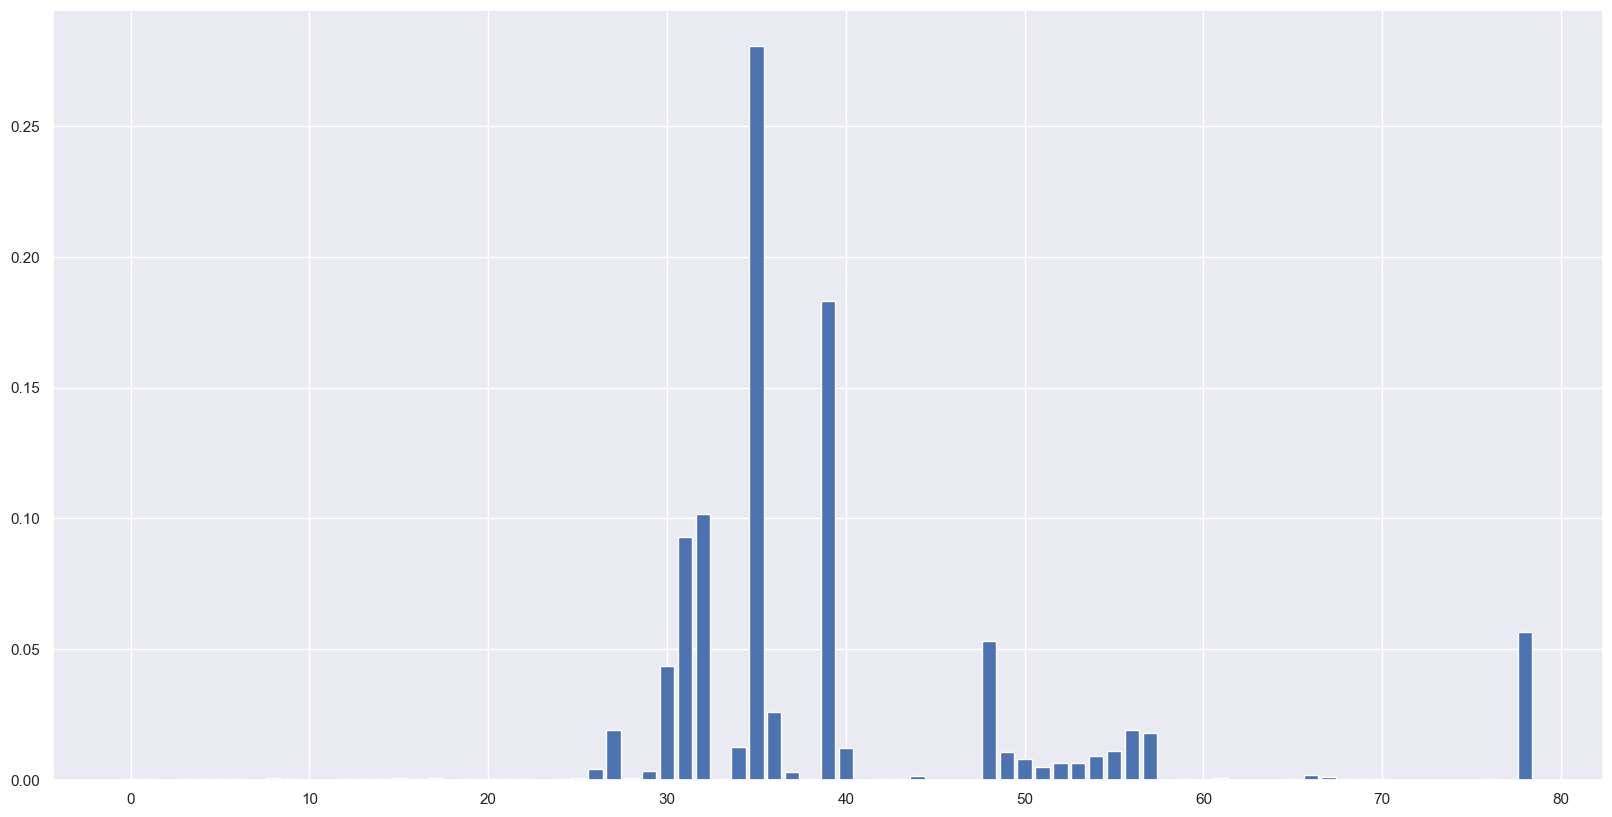

In [424]:
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [425]:
features

Index(['Perceived health very good or excellent 13',
       'Perceived health fair or poor 13',
       'Perceived mental health very good or excellent 14',
       'Perceived mental health fair or poor 14',
       'Perceived life stress most days quite a bit or extremely stressful 15',
       'Body mass index adjusted self-reported adult (18 years and over) overweight 16 17 18 19 20 21',
       'Body mass index adjusted self-reported adult (18 years and over) obese 16 17 18 19 20 21',
       'Body mass index self-reported youth (12 to 17 years old) overweight or obese 16 17 18 19 21',
       'Arthritis (15 years and over) 22', 'Diabetes 23', 'Asthma 24 25',
       'Chronic obstructive pulmonary disease (COPD; 35 years and over) 25 26 27',
       'High blood pressure 27 28', 'Mood disorder 29',
       'Current smoker daily or occasional 30 31 32 33 34',
       'Current smoker daily 30 31 32 33', 'Heavy drinking 37',
       'Self-reported physical activity 150 minutes per week adult (18 y

<AxesSubplot: >

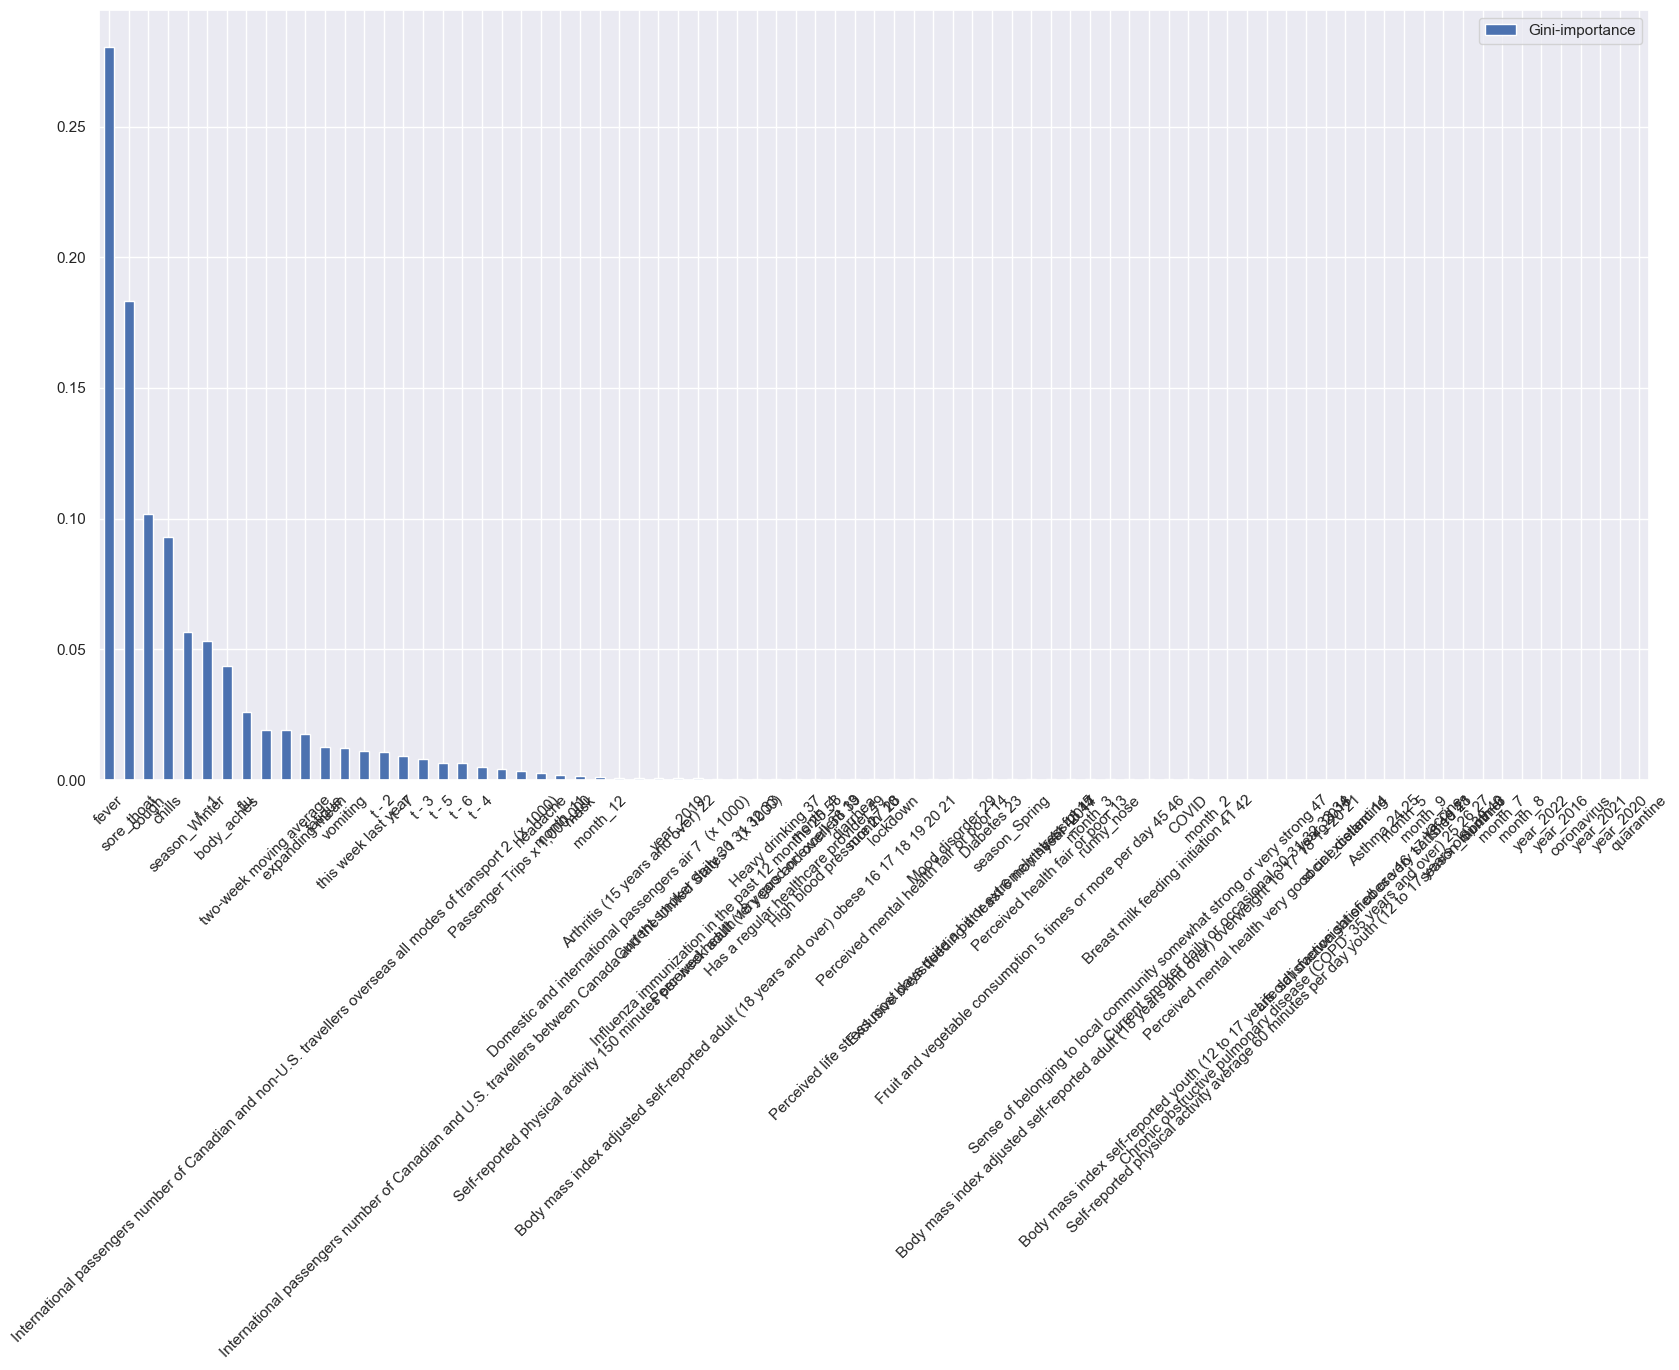

In [426]:
# https://stackoverflow.com/questions/41900387/mapping-column-names-to-random-forest-feature-importances

import pandas as pd
%matplotlib inline
#do code to support model
#"data" is the X dataframe and model is the SKlearn object

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(features, model.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance', ascending=False).plot(kind='bar', rot=45)

In [428]:
len(features)

79

In [434]:
feats_to_remove = importances.sort_values('Gini-importance').iloc[0:25,:].index.to_list()

In [435]:
feats_to_remove

['quarantine',
 'coronavirus',
 'year_2016',
 'year_2020',
 'year_2021',
 'year_2022',
 'month_8',
 'month_7',
 'month_6',
 'season_Summer',
 'vaccine',
 'month_9',
 'month_5',
 'Asthma 24 25',
 'Life satisfaction satisfied or very satisfied 48',
 'social_distancing',
 'year_2018',
 'Chronic obstructive pulmonary disease (COPD; 35 years and over) 25 26 27',
 'Self-reported physical activity average 60 minutes per day youth (12 to 17 years old) 39 40',
 'Perceived mental health very good or excellent 14',
 'Body mass index self-reported youth (12 to 17 years old) overweight or obese 16 17 18 19 21',
 'Current smoker daily or occasional 30 31 32 33 34',
 'month_2',
 'COVID',
 'Breast milk feeding initiation 41 42']

In [432]:
for i in range(1,5):
    results_matrix = evaluate_model(train=train_y, test=test_y, preds_train=preds_train, preds_test=preds_test, dataset='Pre-COVID (all feats', forecast_weeks=i)
results_matrix

Dataset Weeks-ahead Forecast  \
0                       Pre-COVID - (all time feats)                    1   
0                       Pre-COVID - (all time feats)                    2   
0                       Pre-COVID - (all time feats)                    3   
0                       Pre-COVID - (all time feats)                    4   
0             Pre-COVID (time feats, remove M and Y)                    1   
0             Pre-COVID (time feats, remove M and Y)                    2   
0             Pre-COVID (time feats, remove M and Y)                    3   
0             Pre-COVID (time feats, remove M and Y)                    4   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    1   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    2   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    3   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    4   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    1   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    2   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    3   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    4   
0                               Pre-COVID (all feats                    1   
0                               Pre-COVID (all feats                    2   
0                               Pre-COVID (all feats                    3   
0                               Pre-COVID (all feats                    4   

  MSE_train   MSE_test RMSE_train RMSE_test MAE_train MAE_test  R2_train  \
0   8645.66   97600.06      92.98    312.41     50.03   193.03  0.995238   
0  13142.62  192354.67     114.64    438.58     64.11   249.64  0.992735   
0  16733.42  287159.05     129.36    535.87     70.98    310.1  0.990716   
0  22529.88  358909.52      150.1    599.09     84.21   365.58  0.987464   
0   9987.75   89840.61      99.94    299.73     52.96    186.3  0.994499   
0  15031.57  172524.55      122.6    415.36     66.82   225.45   0.99169   
0  19320.23  259617.88      139.0    509.53     77.24   280.81  0.989281   
0   26457.7  320536.19     162.66    566.16     90.66   330.62  0.985279   
0   9359.49   68548.97      96.74    261.82     53.67   172.17  0.994845   
0  14962.43  136966.77     122.32    370.09     68.63    217.7  0.991728   
0  17838.93  213031.78     133.56    461.55     74.65   267.06  0.990103   
0  21819.18  291982.47     147.71    540.35     84.42   330.86   0.98786   
0   7591.63   96391.15      87.13    310.47     51.04   206.92  0.995819   
0  10692.14   92682.13      103.4    304.44     60.91   211.15  0.994089   
0  12902.56  108251.91     113.59    329.02     65.83   232.89  0.992841   
0  14230.53  202893.61     119.29    450.44     74.15   301.03  0.992082   
0   7314.27  261944.97      85.52    511.81     50.21   290.86  0.995955   
0  10207.11  206830.95     101.03    454.79     55.08   280.53  0.994333   
0  12055.99  160165.39      109.8    400.21     59.94   269.54  0.993299   
0  11416.23  218313.15     106.85    467.24     63.47   310.24  0.993654   

    R2_test  
0  0.952997  
0  0.911083  
0  0.870534  
0  0.838051  
0  0.956733  
0  0.920249  
0  0.882951  
0  0.855366  
0  0.966987  
0  0.936686  
0  0.903955  
0   0.86825  
0  0.953579  
0  0.957157  
0  0.951195  
0  0.908449  
0  0.888206  
0  0.915457  
0  0.936266  
0   0.91326

In [433]:
results_matrix.sort_values('RMSE_test')

Dataset Weeks-ahead Forecast  \
0  Pre-COVID (time feats, remove M and Y) + COVID...                    1   
0             Pre-COVID (time feats, remove M and Y)                    1   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    2   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    1   
0                       Pre-COVID - (all time feats)                    1   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    3   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    2   
0                               Pre-COVID (all feats                    3   
0             Pre-COVID (time feats, remove M and Y)                    2   
0                       Pre-COVID - (all time feats)                    2   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    4   
0                               Pre-COVID (all feats                    2   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    3   
0                               Pre-COVID (all feats                    4   
0             Pre-COVID (time feats, remove M and Y)                    3   
0                               Pre-COVID (all feats                    1   
0                       Pre-COVID - (all time feats)                    3   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    4   
0             Pre-COVID (time feats, remove M and Y)                    4   
0                       Pre-COVID - (all time feats)                    4   

  MSE_train   MSE_test RMSE_train RMSE_test MAE_train MAE_test  R2_train  \
0   9359.49   68548.97      96.74    261.82     53.67   172.17  0.994845   
0   9987.75   89840.61      99.94    299.73     52.96    186.3  0.994499   
0  10692.14   92682.13      103.4    304.44     60.91   211.15  0.994089   
0   7591.63   96391.15      87.13    310.47     51.04   206.92  0.995819   
0   8645.66   97600.06      92.98    312.41     50.03   193.03  0.995238   
0  12902.56  108251.91     113.59    329.02     65.83   232.89  0.992841   
0  14962.43  136966.77     122.32    370.09     68.63    217.7  0.991728   
0  12055.99  160165.39      109.8    400.21     59.94   269.54  0.993299   
0  15031.57  172524.55      122.6    415.36     66.82   225.45   0.99169   
0  13142.62  192354.67     114.64    438.58     64.11   249.64  0.992735   
0  14230.53  202893.61     119.29    450.44     74.15   301.03  0.992082   
0  10207.11  206830.95     101.03    454.79     55.08   280.53  0.994333   
0  17838.93  213031.78     133.56    461.55     74.65   267.06  0.990103   
0  11416.23  218313.15     106.85    467.24     63.47   310.24  0.993654   
0  19320.23  259617.88      139.0    509.53     77.24   280.81  0.989281   
0   7314.27  261944.97      85.52    511.81     50.21   290.86  0.995955   
0  16733.42  287159.05     129.36    535.87     70.98    310.1  0.990716   
0  21819.18  291982.47     147.71    540.35     84.42   330.86   0.98786   
0   26457.7  320536.19     162.66    566.16     90.66   330.62  0.985279   
0  22529.88  358909.52      150.1    599.09     84.21   365.58  0.987464   

    R2_test  
0  0.966987  
0  0.956733  
0  0.957157  
0  0.953579  
0  0.952997  
0  0.951195  
0  0.936686  
0  0.936266  
0  0.920249  
0  0.911083  
0  0.908449  
0  0.915457  
0  0.903955  
0   0.91326  
0  0.882951  
0  0.888206  
0  0.870534  
0   0.86825  
0  0.855366  
0  0.838051

In [ ]:
results_matrix.sort_values('RMSE_test')['Dataset']

0    Pre-COVID (time feats, remove M and Y) + COVID...
0               Pre-COVID (time feats, remove M and Y)
0    Pre-COVID (time feats, remove M and Y) + COVID...
0    Pre-COVID (time feats, remove M and Y) + COVID...
0                         Pre-COVID - (all time feats)
0    Pre-COVID (time feats, remove M and Y) + COVID...
0    Pre-COVID (time feats, remove M and Y) + COVID...
0               Pre-COVID (time feats, remove M and Y)
0                         Pre-COVID - (all time feats)
0    Pre-COVID (time feats, remove M and Y) + COVID...
0    Pre-COVID (time feats, remove M and Y) + COVID...
0               Pre-COVID (time feats, remove M and Y)
0                         Pre-COVID - (all time feats)
0    Pre-COVID (time feats, remove M and Y) + COVID...
0               Pre-COVID (time feats, remove M and Y)
0                         Pre-COVID - (all time feats)
Name: Dataset, dtype: object

# Random Forest Regression - All Features w/o Least Important Features

In [451]:
df_pre_COVID_all_features = pickle.load(open(r"..\data\df_pre_COVID_all_features.pkl", "rb" ))
# df_time_features = pickle.load(open(r"..\data\flu_cases\df_time_features.pkl", "rb" ))

# df_COVID_terms_pre_COVID = pickle.load(open(r"..\data\google_trend\df_COVID_terms_pre_COVID.pkl", "rb" ))
# df_COVID_terms = pickle.load(open(r"..\data\google_trend\df_COVID_terms.pkl", "rb" ))

# df_flu_symptoms_pre_COVID = pickle.load(open(r"..\data\google_trend\df_flu_symptoms_pre_COVID.pkl", "rb" ))
# df_flu_symptoms = pickle.load(open(r"..\data\google_trend\df_flu_symptoms.pkl", "rb" ))

In [452]:
df_pre_COVID_all_features.shape

(157, 87)

In [453]:
df_pre_COVID_all_features.columns

Index(['Total Cases', 'Perceived health very good or excellent 13',
       'Perceived health fair or poor 13',
       'Perceived mental health very good or excellent 14',
       'Perceived mental health fair or poor 14',
       'Perceived life stress most days quite a bit or extremely stressful 15',
       'Body mass index adjusted self-reported adult (18 years and over) overweight 16 17 18 19 20 21',
       'Body mass index adjusted self-reported adult (18 years and over) obese 16 17 18 19 20 21',
       'Body mass index self-reported youth (12 to 17 years old) overweight or obese 16 17 18 19 21',
       'Arthritis (15 years and over) 22', 'Diabetes 23', 'Asthma 24 25',
       'Chronic obstructive pulmonary disease (COPD; 35 years and over) 25 26 27',
       'High blood pressure 27 28', 'Mood disorder 29',
       'Current smoker daily or occasional 30 31 32 33 34',
       'Current smoker daily 30 31 32 33', 'Heavy drinking 37',
       'Self-reported physical activity 150 minutes per w

In [454]:
df = df_pre_COVID_all_features

In [455]:
feats_to_remove

['quarantine',
 'coronavirus',
 'year_2016',
 'year_2020',
 'year_2021',
 'year_2022',
 'month_8',
 'month_7',
 'month_6',
 'season_Summer',
 'vaccine',
 'month_9',
 'month_5',
 'Asthma 24 25',
 'Life satisfaction satisfied or very satisfied 48',
 'social_distancing',
 'year_2018',
 'Chronic obstructive pulmonary disease (COPD; 35 years and over) 25 26 27',
 'Self-reported physical activity average 60 minutes per day youth (12 to 17 years old) 39 40',
 'Perceived mental health very good or excellent 14',
 'Body mass index self-reported youth (12 to 17 years old) overweight or obese 16 17 18 19 21',
 'Current smoker daily or occasional 30 31 32 33 34',
 'month_2',
 'COVID',
 'Breast milk feeding initiation 41 42']

In [456]:
# df.dropna(inplace=True)
# df = df.reset_index(drop=True)
df = df.drop(columns=feats_to_remove)

In [457]:
df

Total Cases  Perceived health very good or excellent 13  \
78        2078.0                                  18714100.0   
79        1745.0                                  18714100.0   
80        1231.0                                  18714100.0   
81        1060.0                                  18714100.0   
82         904.0                                  18714100.0   
..           ...                                         ...   
230       4789.0                                  19464600.0   
231       4654.0                                  19464600.0   
232       3989.0                                  19464600.0   
233       3656.0                                  19464600.0   
234       3576.0                                  19464600.0   

     Perceived health fair or poor 13  \
78                          3443000.0   
79                          3443000.0   
80                          3443000.0   
81                          3443000.0   
82                          3443000.0   
..                                ...   
230                         3464200.0   
231                         3464200.0   
232                         3464200.0   
233                         3464200.0   
234                         3464200.0   

     Perceived mental health fair or poor 14  \
78                                 2053000.0   
79                                 2053000.0   
80                                 2053000.0   
81                                 2053000.0   
82                                 2053000.0   
..                                       ...   
230                                2494800.0   
231                                2494800.0   
232                                2494800.0   
233                                2494800.0   
234                                2494800.0   

     Perceived life stress most days quite a bit or extremely stressful 15  \
78                                           6564200.0                       
79                                           6564200.0                       
80                                           6564200.0                       
81                                           6564200.0                       
82                                           6564200.0                       
..                                                 ...                       
230                                          6729400.0                       
231                                          6729400.0                       
232                                          6729400.0                       
233                                          6729400.0                       
234                                          6729400.0                       

     Body mass index adjusted self-reported adult (18 years and over) overweight 16 17 18 19 20 21  \
78                                           9484900.0                                               
79                                           9484900.0                                               
80                                           9484900.0                                               
81                                           9484900.0                                               
82                                           9484900.0                                               
..                                                 ...                                               
230                                          9850600.0                                               
231                                          9850600.0                                               
232                                          9850600.0                                               
233                                          9850600.0                                               
234                                          9850600.0                                               

    

In [458]:
df.columns

Index(['Total Cases', 'Perceived health very good or excellent 13',
       'Perceived health fair or poor 13',
       'Perceived mental health fair or poor 14',
       'Perceived life stress most days quite a bit or extremely stressful 15',
       'Body mass index adjusted self-reported adult (18 years and over) overweight 16 17 18 19 20 21',
       'Body mass index adjusted self-reported adult (18 years and over) obese 16 17 18 19 20 21',
       'Arthritis (15 years and over) 22', 'Diabetes 23',
       'High blood pressure 27 28', 'Mood disorder 29',
       'Current smoker daily 30 31 32 33', 'Heavy drinking 37',
       'Self-reported physical activity 150 minutes per week adult (18 years and over) 38 39',
       'Exclusive breastfeeding at least 6 months 41 43 44',
       'Fruit and vegetable consumption 5 times or more per day 45 46',
       'Sense of belonging to local community somewhat strong or very strong 47',
       'Has a regular healthcare provider 49',
       'Influenza imm

In [459]:
df.drop(columns='Total Cases', inplace=True)

In [460]:
df.columns

Index(['Perceived health very good or excellent 13',
       'Perceived health fair or poor 13',
       'Perceived mental health fair or poor 14',
       'Perceived life stress most days quite a bit or extremely stressful 15',
       'Body mass index adjusted self-reported adult (18 years and over) overweight 16 17 18 19 20 21',
       'Body mass index adjusted self-reported adult (18 years and over) obese 16 17 18 19 20 21',
       'Arthritis (15 years and over) 22', 'Diabetes 23',
       'High blood pressure 27 28', 'Mood disorder 29',
       'Current smoker daily 30 31 32 33', 'Heavy drinking 37',
       'Self-reported physical activity 150 minutes per week adult (18 years and over) 38 39',
       'Exclusive breastfeeding at least 6 months 41 43 44',
       'Fruit and vegetable consumption 5 times or more per day 45 46',
       'Sense of belonging to local community somewhat strong or very strong 47',
       'Has a regular healthcare provider 49',
       'Influenza immunization in th

In [461]:
train_size = int(len(df) *.7)
test_size = len(df) - train_size
train, test = df[0:train_size], df[train_size:len(df)]

In [462]:
train_y = train[['y1','y2','y3','y4']]
train_X = train.drop(columns=['y1','y2','y3','y4'])
test_y = test[['y1','y2','y3','y4']]
test_X = test.drop(columns=['y1','y2','y3','y4'])

In [463]:
features = train_X.columns

In [466]:
train_X_to_scale = train_X.loc[:,:'expanding mean']
test_X_to_scale = test_X.loc[:,:'expanding mean']
train_X_not_to_scale = train_X.loc[:,'year_2015':].to_numpy()
test_X_not_to_scale = test_X.loc[:,'year_2015':].to_numpy()

In [467]:
from sklearn.preprocessing import MinMaxScaler

# scale data
scaler = MinMaxScaler()
train_X_to_scale = scaler.fit_transform(train_X_to_scale)
test_X_to_scale = scaler.transform(test_X_to_scale)

In [468]:
train_X = np.concatenate((train_X_to_scale, train_X_not_to_scale),axis=1)
test_X = np.concatenate((test_X_to_scale, test_X_not_to_scale),axis=1)

In [469]:
train_X.shape

(109, 57)

In [470]:
test_X.shape

(48, 57)

In [471]:
train_y.shape

(109, 4)

In [472]:
test_y.shape

(48, 4)

In [473]:
model = RandomForestRegressor()

model.fit(train_X, train_y)

RandomForestRegressor()

In [474]:
preds_test = model.predict(test_X)
preds_test_df = pd.DataFrame(preds_test,columns=test_y.columns)
preds_train = model.predict(train_X)
preds_train_df = pd.DataFrame(preds_train,columns=train_y.columns)

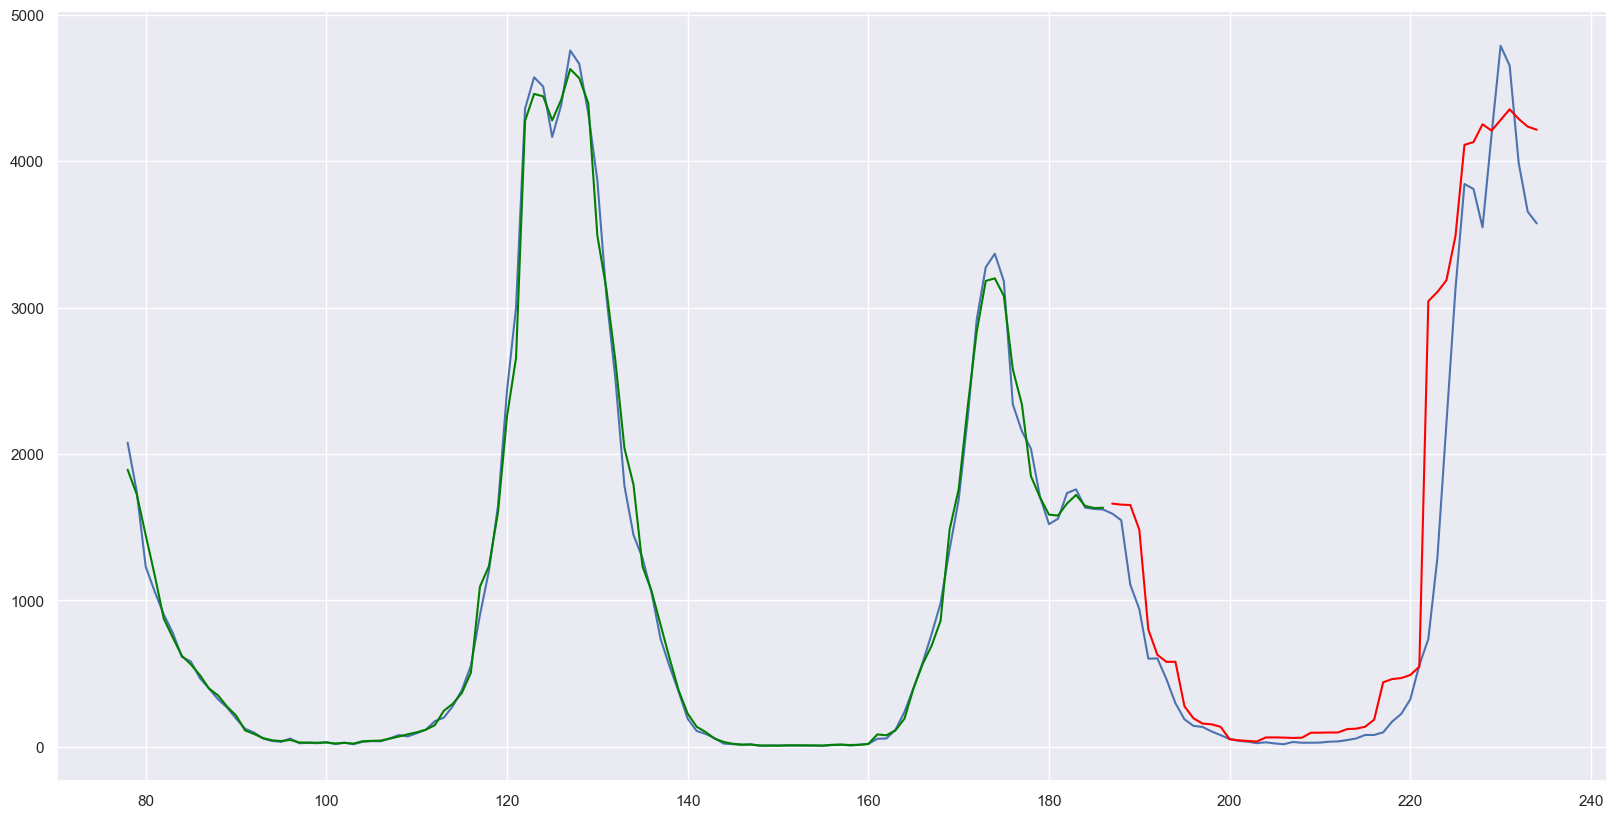

In [475]:
# plot
plt.plot(df.index, df['y1'].values)
plt.plot(df.index[:train_size], preds_train_df['y1'], color='green')
plt.plot(df.index[train_size:], preds_test_df['y1'], color='red')

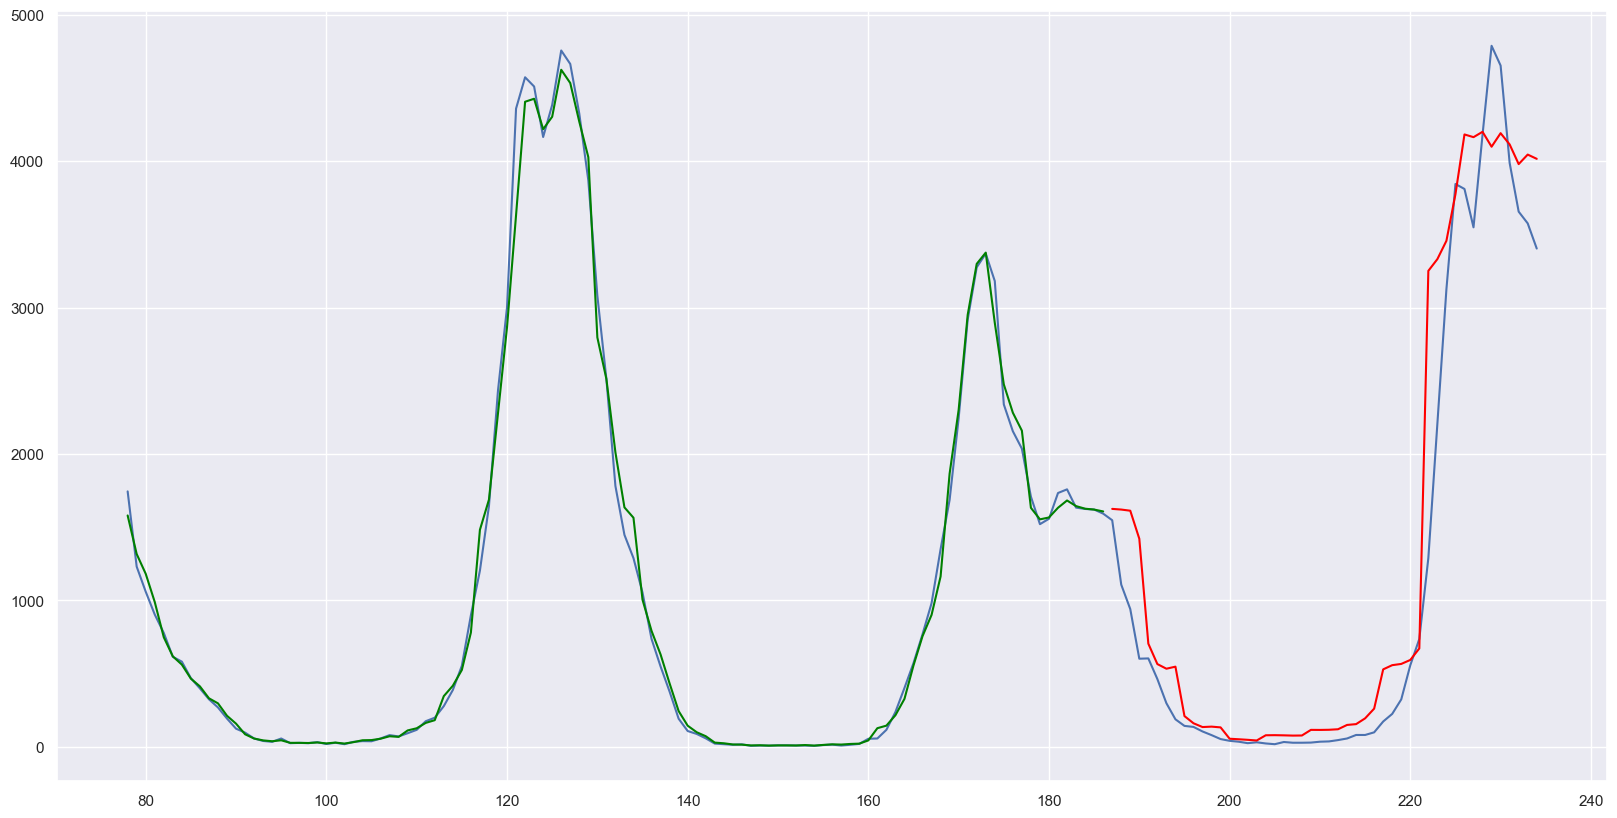

In [476]:
# plot 2-week ahead prediction
plt.plot(df.index, df['y2'].values)
plt.plot(df.index[:train_size], preds_train_df['y2'], color='green')
plt.plot(df.index[train_size:], preds_test_df['y2'], color='red')

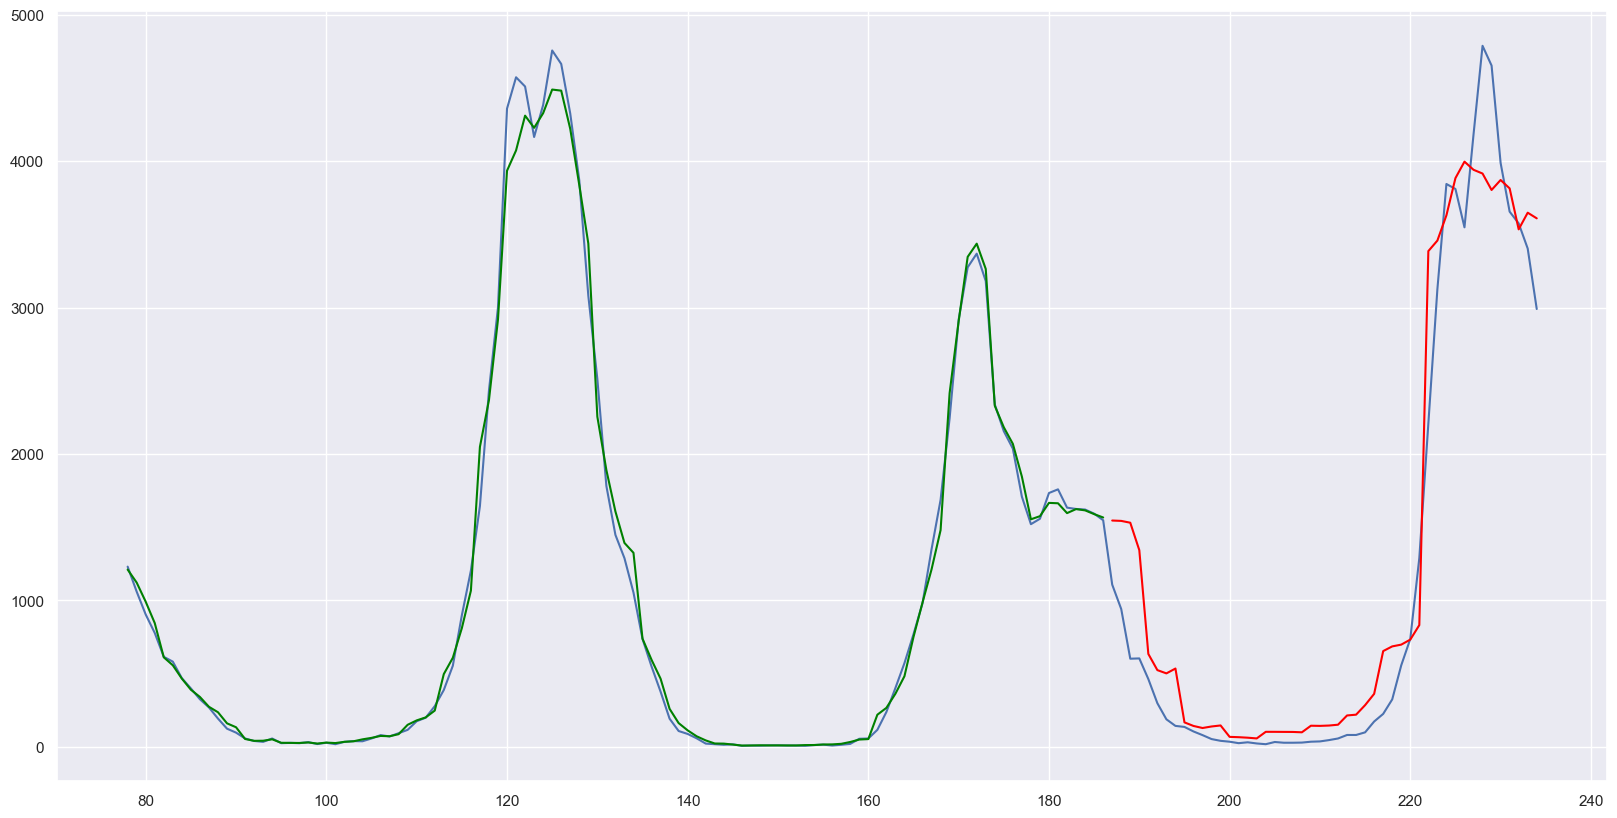

In [477]:
# plot 3-week ahead prediction
plt.plot(df.index, df['y3'].values)
plt.plot(df.index[:train_size], preds_train_df['y3'], color='green')
plt.plot(df.index[train_size:], preds_test_df['y3'], color='red')

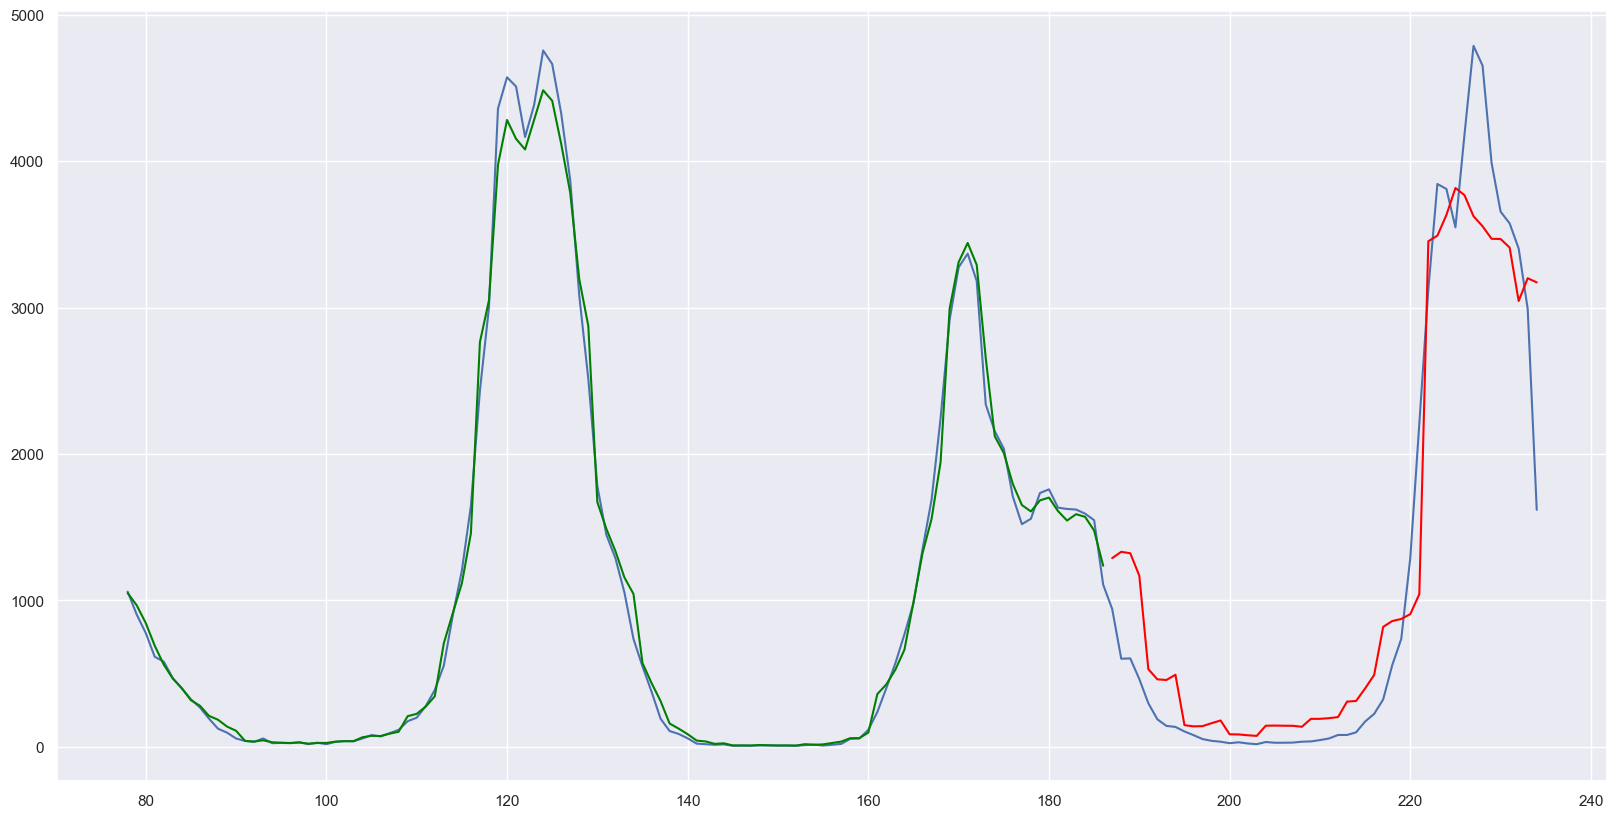

In [478]:
# plot 4-week ahead prediction
plt.plot(df.index, df['y4'].values)
plt.plot(df.index[:train_size], preds_train_df['y4'], color='green')
plt.plot(df.index[train_size:], preds_test_df['y4'], color='red')

In [479]:
# define the evaluation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=2022)
# evaluate the model and collect the scores
n_scores = cross_val_score(model, train_X, train_y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
# force the scores to be positive
n_scores = absolute(n_scores)
# summarize performance
print('RMSE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

RMSE: 273.927 (99.079)


In [480]:
# evaluate all four weeks of predictions

MSE_train = round(mean_squared_error(train_y, preds_train),3)
RMSE_train = round(mean_squared_error(train_y, preds_train, squared=False),3)
MAE_train = round(mean_absolute_error(train_y, preds_train),3)
print(f'MSE_train: {MSE_train}')
print(f'RMSE_train: {RMSE_train}')
print(f'MAE_train: {MAE_train}')

MSE_test = round(mean_squared_error(test_y, preds_test),3)
RMSE_test = round(mean_squared_error(test_y, preds_test, squared=False),3)
MAE_test = round(mean_absolute_error(test_y, preds_test),3)
print(f'MSE_test: {MSE_test}')
print(f'RMSE_test: {RMSE_test}')
print(f'MAE_test: {MAE_test}')


MSE_train: 11565.377
RMSE_train: 107.28
MAE_train: 59.248
MSE_test: 202863.066
RMSE_test: 447.71
MAE_test: 279.699


In [481]:
# evaluate 1-week ahead prediction only

MSE_train = round(mean_squared_error(train_y['y1'], preds_train_df['y1']),3)
RMSE_train = round(mean_squared_error(train_y['y1'], preds_train_df['y1'], squared=False),3)
MAE_train = round(mean_absolute_error(train_y['y1'], preds_train_df['y1']),3)
print(f'MSE_train: {MSE_train}')
print(f'RMSE_train: {RMSE_train}')
print(f'MAE_train: {MAE_train}')

MSE_test = round(mean_squared_error(test_y['y1'], preds_test_df['y1']),3)
RMSE_test = round(mean_squared_error(test_y['y1'], preds_test_df['y1'], squared=False),3)
MAE_test = round(mean_absolute_error(test_y['y1'], preds_test_df['y1']),3)
print(f'MSE_test: {MSE_test}')
print(f'RMSE_test: {RMSE_test}')
print(f'MAE_test: {MAE_test}')


MSE_train: 8901.005
RMSE_train: 94.345
MAE_train: 53.33
MSE_test: 263922.928
RMSE_test: 513.734
MAE_test: 272.642


In [482]:
# evaluate 2-week ahead prediction only

MSE_train = round(mean_squared_error(train_y['y2'], preds_train_df['y2']),3)
RMSE_train = round(mean_squared_error(train_y['y2'], preds_train_df['y2'], squared=False),3)
MAE_train = round(mean_absolute_error(train_y['y2'], preds_train_df['y2']),3)
print(f'MSE_train: {MSE_train}')
print(f'RMSE_train: {RMSE_train}')
print(f'MAE_train: {MAE_train}')

MSE_test = round(mean_squared_error(test_y['y2'], preds_test_df['y2']),3)
RMSE_test = round(mean_squared_error(test_y['y2'], preds_test_df['y2'], squared=False),3)
MAE_test = round(mean_absolute_error(test_y['y2'], preds_test_df['y2']),3)
print(f'MSE_test: {MSE_test}')
print(f'RMSE_test: {RMSE_test}')
print(f'MAE_test: {MAE_test}')


MSE_train: 12401.748
RMSE_train: 111.363
MAE_train: 58.472
MSE_test: 190925.344
RMSE_test: 436.95
MAE_test: 259.27


In [483]:
# evaluate 3-week ahead prediction only

MSE_train = round(mean_squared_error(train_y['y3'], preds_train_df['y3']),3)
RMSE_train = round(mean_squared_error(train_y['y3'], preds_train_df['y3'], squared=False),3)
MAE_train = round(mean_absolute_error(train_y['y3'], preds_train_df['y3']),3)
print(f'MSE_train: {MSE_train}')
print(f'RMSE_train: {RMSE_train}')
print(f'MAE_train: {MAE_train}')

MSE_test = round(mean_squared_error(test_y['y3'], preds_test_df['y3']),3)
RMSE_test = round(mean_squared_error(test_y['y3'], preds_test_df['y3'], squared=False),3)
MAE_test = round(mean_absolute_error(test_y['y3'], preds_test_df['y3']),3)
print(f'MSE_test: {MSE_test}')
print(f'RMSE_test: {RMSE_test}')
print(f'MAE_test: {MAE_test}')


MSE_train: 12240.776
RMSE_train: 110.638
MAE_train: 59.424
MSE_test: 142291.058
RMSE_test: 377.215
MAE_test: 259.921


In [484]:
# evaluate 4-week ahead prediction only

MSE_train = round(mean_squared_error(train_y['y4'], preds_train_df['y4']),4)
RMSE_train = round(mean_squared_error(train_y['y4'], preds_train_df['y4'], squared=False),4)
MAE_train = round(mean_absolute_error(train_y['y4'], preds_train_df['y4']),4)
print(f'MSE_train: {MSE_train}')
print(f'RMSE_train: {RMSE_train}')
print(f'MAE_train: {MAE_train}')

MSE_test = round(mean_squared_error(test_y['y4'], preds_test_df['y4']),4)
RMSE_test = round(mean_squared_error(test_y['y4'], preds_test_df['y4'], squared=False),4)
MAE_test = round(mean_absolute_error(test_y['y4'], preds_test_df['y4']),4)
print(f'MSE_test: {MSE_test}')
print(f'RMSE_test: {RMSE_test}')
print(f'MAE_test: {MAE_test}')

MSE_train: 12717.9814
RMSE_train: 112.774
MAE_train: 65.7681
MSE_test: 214312.9319
RMSE_test: 462.9394
MAE_test: 326.9631


In [485]:
model.feature_importances_

array([9.35910446e-04, 4.18583251e-04, 3.05539338e-04, 2.93257673e-04,
       2.30135467e-04, 2.49916229e-04, 1.55556064e-03, 1.95710298e-04,
       9.46954772e-05, 3.03673701e-04, 3.87392534e-04, 1.69391465e-04,
       3.45858644e-04, 8.55754515e-04, 2.74794471e-04, 8.11367155e-05,
       4.39252768e-04, 8.73900739e-05, 3.65092645e-03, 1.32792351e-02,
       1.62807729e-03, 2.01560838e-03, 2.58281694e-02, 1.78577601e-01,
       6.25849166e-02, 4.20999186e-04, 5.86113194e-03, 2.60801344e-01,
       2.95566144e-02, 3.09017612e-03, 1.59910307e-04, 2.06395543e-01,
       6.49382387e-03, 1.41095021e-04, 3.15879800e-04, 5.14454205e-02,
       9.60681060e-03, 7.80954815e-03, 5.54351648e-03, 6.87048723e-03,
       6.91569626e-03, 1.24896461e-02, 1.29474719e-02, 1.80647154e-02,
       2.03412752e-02, 0.00000000e+00, 1.45048337e-04, 2.32572917e-04,
       7.87036920e-05, 3.06428552e-04, 2.23901359e-03, 9.21593482e-04,
       3.20104487e-05, 1.96482504e-04, 6.14747909e-05, 4.23810346e-04,
      

Feature: 0, Score: 0.00094
Feature: 1, Score: 0.00042
Feature: 2, Score: 0.00031
Feature: 3, Score: 0.00029
Feature: 4, Score: 0.00023
Feature: 5, Score: 0.00025
Feature: 6, Score: 0.00156
Feature: 7, Score: 0.00020
Feature: 8, Score: 0.00009
Feature: 9, Score: 0.00030
Feature: 10, Score: 0.00039
Feature: 11, Score: 0.00017
Feature: 12, Score: 0.00035
Feature: 13, Score: 0.00086
Feature: 14, Score: 0.00027
Feature: 15, Score: 0.00008
Feature: 16, Score: 0.00044
Feature: 17, Score: 0.00009
Feature: 18, Score: 0.00365
Feature: 19, Score: 0.01328
Feature: 20, Score: 0.00163
Feature: 21, Score: 0.00202
Feature: 22, Score: 0.02583
Feature: 23, Score: 0.17858
Feature: 24, Score: 0.06258
Feature: 25, Score: 0.00042
Feature: 26, Score: 0.00586
Feature: 27, Score: 0.26080
Feature: 28, Score: 0.02956
Feature: 29, Score: 0.00309
Feature: 30, Score: 0.00016
Feature: 31, Score: 0.20640
Feature: 32, Score: 0.00649
Feature: 33, Score: 0.00014
Feature: 34, Score: 0.00032
Feature: 35, Score: 0.05145
Fe

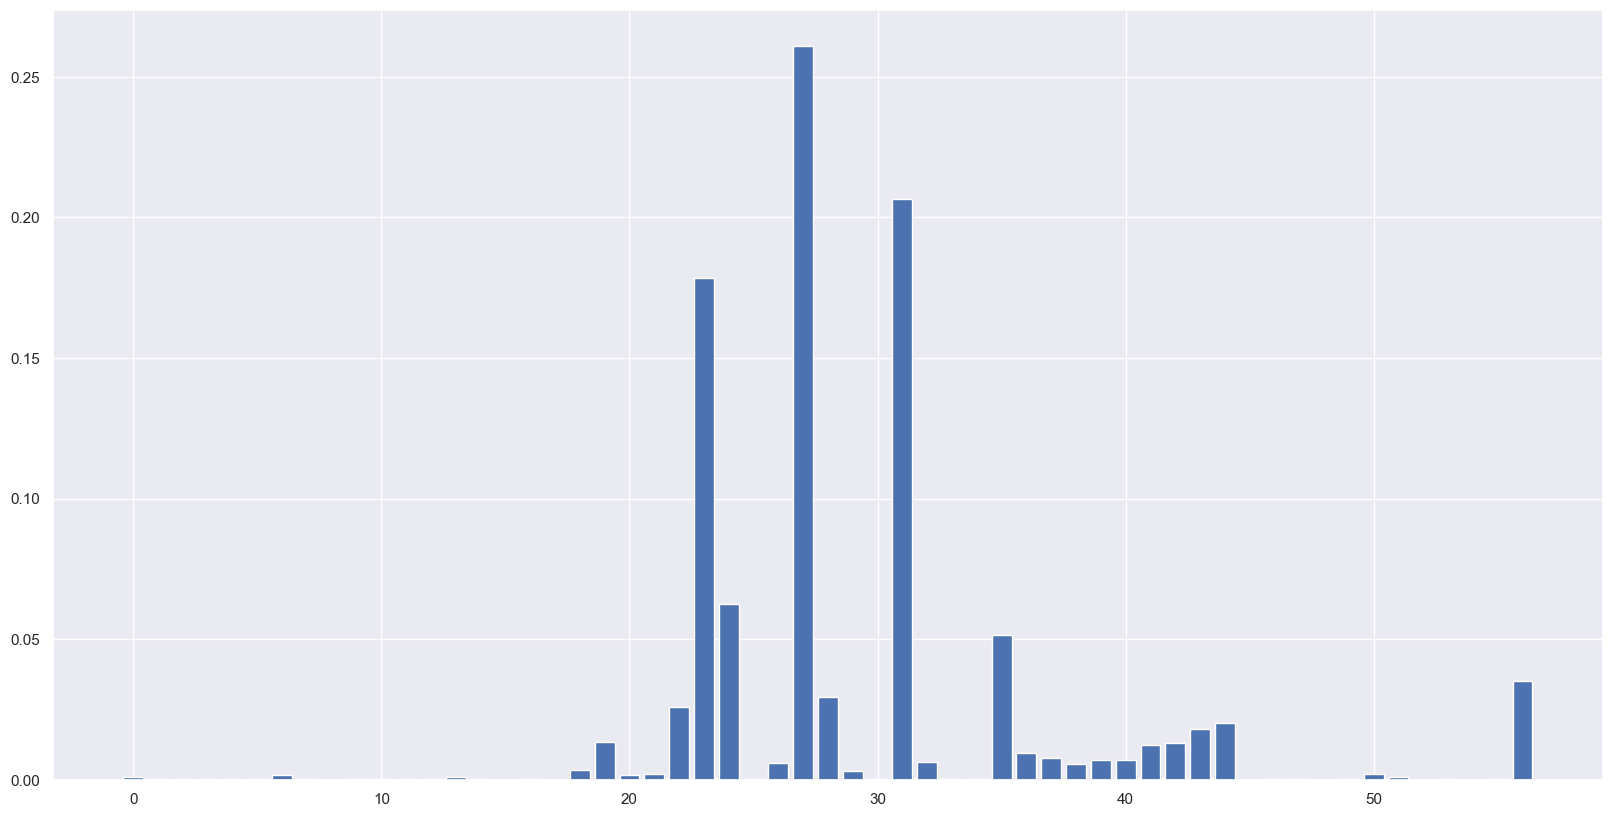

In [486]:
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [487]:
features

Index(['Perceived health very good or excellent 13',
       'Perceived health fair or poor 13',
       'Perceived mental health fair or poor 14',
       'Perceived life stress most days quite a bit or extremely stressful 15',
       'Body mass index adjusted self-reported adult (18 years and over) overweight 16 17 18 19 20 21',
       'Body mass index adjusted self-reported adult (18 years and over) obese 16 17 18 19 20 21',
       'Arthritis (15 years and over) 22', 'Diabetes 23',
       'High blood pressure 27 28', 'Mood disorder 29',
       'Current smoker daily 30 31 32 33', 'Heavy drinking 37',
       'Self-reported physical activity 150 minutes per week adult (18 years and over) 38 39',
       'Exclusive breastfeeding at least 6 months 41 43 44',
       'Fruit and vegetable consumption 5 times or more per day 45 46',
       'Sense of belonging to local community somewhat strong or very strong 47',
       'Has a regular healthcare provider 49',
       'Influenza immunization in th

<AxesSubplot: >

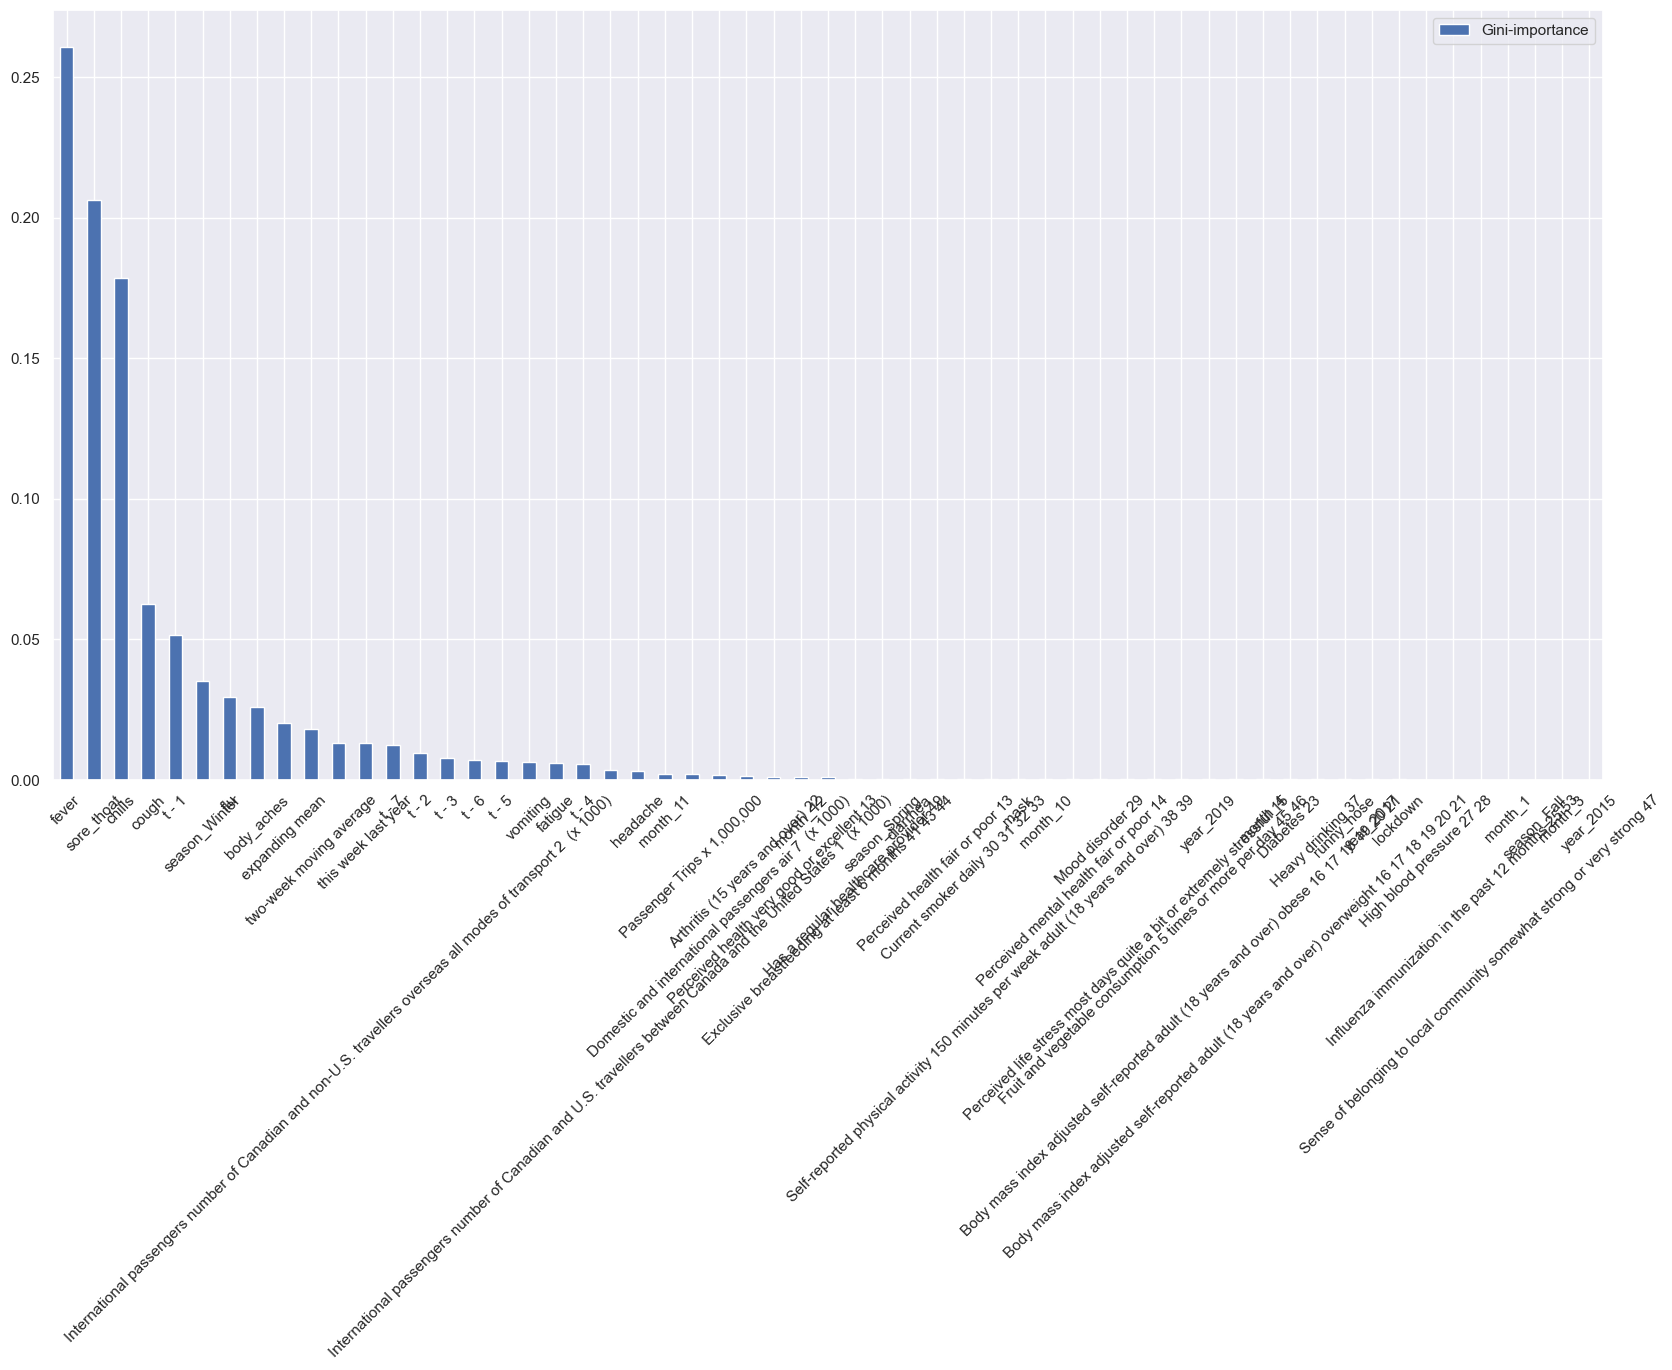

In [488]:
# https://stackoverflow.com/questions/41900387/mapping-column-names-to-random-forest-feature-importances

import pandas as pd
%matplotlib inline
#do code to support model
#"data" is the X dataframe and model is the SKlearn object

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(features, model.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance', ascending=False).plot(kind='bar', rot=45)

In [489]:
len(features)

57

In [490]:
feats_to_remove = importances.sort_values('Gini-importance').iloc[0:25,:].index.to_list()

In [491]:
feats_to_remove

['year_2015',
 'month_3',
 'season_Fall',
 'month_1',
 'Sense of belonging to local community somewhat strong or very strong 47',
 'Influenza immunization in the past 12 months 25 53',
 'High blood pressure 27 28',
 'lockdown',
 'year_2017',
 'runny_nose',
 'Heavy drinking 37',
 'Diabetes 23',
 'month_4',
 'Body mass index adjusted self-reported adult (18 years and over) overweight 16 17 18 19 20 21',
 'year_2019',
 'Body mass index adjusted self-reported adult (18 years and over) obese 16 17 18 19 20 21',
 'Fruit and vegetable consumption 5 times or more per day 45 46',
 'Perceived life stress most days quite a bit or extremely stressful 15',
 'Mood disorder 29',
 'Perceived mental health fair or poor 14',
 'month_10',
 'mask',
 'Self-reported physical activity 150 minutes per week adult (18 years and over) 38 39',
 'Current smoker daily 30 31 32 33',
 'Perceived health fair or poor 13']

In [493]:
for i in range(1,5):
    results_matrix = evaluate_model(train=train_y, test=test_y, preds_train=preds_train, preds_test=preds_test, dataset='Pre-COVID (all feats', forecast_weeks=i)
results_matrix

Dataset Weeks-ahead Forecast  \
0                       Pre-COVID - (all time feats)                    1   
0                       Pre-COVID - (all time feats)                    2   
0                       Pre-COVID - (all time feats)                    3   
0                       Pre-COVID - (all time feats)                    4   
0             Pre-COVID (time feats, remove M and Y)                    1   
0             Pre-COVID (time feats, remove M and Y)                    2   
0             Pre-COVID (time feats, remove M and Y)                    3   
0             Pre-COVID (time feats, remove M and Y)                    4   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    1   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    2   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    3   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    4   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    1   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    2   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    3   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    4   
0                               Pre-COVID (all feats                    1   
0                               Pre-COVID (all feats                    2   
0                               Pre-COVID (all feats                    3   
0                               Pre-COVID (all feats                    4   
0                               Pre-COVID (all feats                    1   
0                               Pre-COVID (all feats                    2   
0                               Pre-COVID (all feats                    3   
0                               Pre-COVID (all feats                    4   

  MSE_train   MSE_test RMSE_train RMSE_test MAE_train MAE_test  R2_train  \
0   8645.66   97600.06      92.98    312.41     50.03   193.03  0.995238   
0  13142.62  192354.67     114.64    438.58     64.11   249.64  0.992735   
0  16733.42  287159.05     129.36    535.87     70.98    310.1  0.990716   
0  22529.88  358909.52      150.1    599.09     84.21   365.58  0.987464   
0   9987.75   89840.61      99.94    299.73     52.96    186.3  0.994499   
0  15031.57  172524.55      122.6    415.36     66.82   225.45   0.99169   
0  19320.23  259617.88      139.0    509.53     77.24   280.81  0.989281   
0   26457.7  320536.19     162.66    566.16     90.66   330.62  0.985279   
0   9359.49   68548.97      96.74    261.82     53.67   172.17  0.994845   
0  14962.43  136966.77     122.32    370.09     68.63    217.7  0.991728   
0  17838.93  213031.78     133.56    461.55     74.65   267.06  0.990103   
0  21819.18  291982.47     147.71    540.35     84.42   330.86   0.98786   
0   7591.63   96391.15      87.13    310.47     51.04   206.92  0.995819   
0  10692.14   92682.13      103.4    304.44     60.91   211.15  0.994089   
0  12902.56  108251.91     113.59    329.02     65.83   232.89  0.992841   
0  14230.53  202893.61     119.29    450.44     74.15   301.03  0.992082   
0   7314.27  261944.97      85.52    511.81     50.21   290.86  0.995955   
0  10207.11  206830.95     101.03    454.79     55.08   280.53  0.994333   
0  12055.99  160165.39      109.8    400.21     59.94   269.54  0.993299   
0  11416.23  218313.15     106.85    467.24     63.47   310.24  0.993654   
0    8901.0  263922.93      94.35    513.73     53.33   272.64  0.995077   
0  12401.75  190925.34     111.36    436.95     58.47   259.27  0.993115   
0  12240.78  142291.06     110.64    377.21     59.42   259.92  0.993196   
0  12717.98  214312.93     112.77    462.94     65.77   326.96   0.99293   

    R2_test  
0  0.952997  
0  0.911083  
0  0.870534  
0  0.838051  
0  0.956733  
0  0.920249  
0  0.882951  
0  0.855366  
0  0.966987  
0  0.936686  
0  0.903955  
0   0.86825  
0  0.953579  
0  0.957157  
0  0.951

In [494]:
results_matrix.sort_values('RMSE_test')

Dataset Weeks-ahead Forecast  \
0  Pre-COVID (time feats, remove M and Y) + COVID...                    1   
0             Pre-COVID (time feats, remove M and Y)                    1   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    2   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    1   
0                       Pre-COVID - (all time feats)                    1   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    3   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    2   
0                               Pre-COVID (all feats                    3   
0                               Pre-COVID (all feats                    3   
0             Pre-COVID (time feats, remove M and Y)                    2   
0                               Pre-COVID (all feats                    2   
0                       Pre-COVID - (all time feats)                    2   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    4   
0                               Pre-COVID (all feats                    2   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    3   
0                               Pre-COVID (all feats                    4   
0                               Pre-COVID (all feats                    4   
0             Pre-COVID (time feats, remove M and Y)                    3   
0                               Pre-COVID (all feats                    1   
0                               Pre-COVID (all feats                    1   
0                       Pre-COVID - (all time feats)                    3   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    4   
0             Pre-COVID (time feats, remove M and Y)                    4   
0                       Pre-COVID - (all time feats)                    4   

  MSE_train   MSE_test RMSE_train RMSE_test MAE_train MAE_test  R2_train  \
0   9359.49   68548.97      96.74    261.82     53.67   172.17  0.994845   
0   9987.75   89840.61      99.94    299.73     52.96    186.3  0.994499   
0  10692.14   92682.13      103.4    304.44     60.91   211.15  0.994089   
0   7591.63   96391.15      87.13    310.47     51.04   206.92  0.995819   
0   8645.66   97600.06      92.98    312.41     50.03   193.03  0.995238   
0  12902.56  108251.91     113.59    329.02     65.83   232.89  0.992841   
0  14962.43  136966.77     122.32    370.09     68.63    217.7  0.991728   
0  12240.78  142291.06     110.64    377.21     59.42   259.92  0.993196   
0  12055.99  160165.39      109.8    400.21     59.94   269.54  0.993299   
0  15031.57  172524.55      122.6    415.36     66.82   225.45   0.99169   
0  12401.75  190925.34     111.36    436.95     58.47   259.27  0.993115   
0  13142.62  192354.67     114.64    438.58     64.11   249.64  0.992735   
0  14230.53  202893.61     119.29    450.44     74.15   301.03  0.992082   
0  10207.11  206830.95     101.03    454.79     55.08   280.53  0.994333   
0  17838.93  213031.78     133.56    461.55     74.65   267.06  0.990103   
0  12717.98  214312.93     112.77    462.94     65.77   326.96   0.99293   
0  11416.23  218313.15     106.85    467.24     63.47   310.24  0.993654   
0  19320.23  259617.88      139.0    509.53     77.24   280.81  0.989281   
0   7314.27  261944.97      85.52    511.81     50.21   290.86  0.995955   
0    8901.0  263922.93      94.35    513.73     53.33   272.64  0.995077   
0  16733.42  287159.05     129.36    535.87     70.98    310.1  0.990716   
0  21819.18  291982.47     147.71    540.35     84.42   330.86   0.98786   
0   26457.7  320536.19     162.66    566.16     90.66   330.62  0.985279   
0  22529.88  358909.52      150.1    599.09     84.21   365.58  0.987464   

    R2_test  
0  0.966987  
0  0.956733  
0  0.957157  
0  0.953579  
0  0.952997  
0  0.951195  
0  0.936686  
0  0.943378  
0  0.936266  
0  0.920249  
0  0.921959  
0  0.911083  
0  0.908449  
0  0.915457  
0  0.903

In [ ]:
results_matrix.sort_values('RMSE_test')['Dataset']

0    Pre-COVID (time feats, remove M and Y) + COVID...
0               Pre-COVID (time feats, remove M and Y)
0    Pre-COVID (time feats, remove M and Y) + COVID...
0    Pre-COVID (time feats, remove M and Y) + COVID...
0                         Pre-COVID - (all time feats)
0    Pre-COVID (time feats, remove M and Y) + COVID...
0    Pre-COVID (time feats, remove M and Y) + COVID...
0               Pre-COVID (time feats, remove M and Y)
0                         Pre-COVID - (all time feats)
0    Pre-COVID (time feats, remove M and Y) + COVID...
0    Pre-COVID (time feats, remove M and Y) + COVID...
0               Pre-COVID (time feats, remove M and Y)
0                         Pre-COVID - (all time feats)
0    Pre-COVID (time feats, remove M and Y) + COVID...
0               Pre-COVID (time feats, remove M and Y)
0                         Pre-COVID - (all time feats)
Name: Dataset, dtype: object

# Random Forest Regression - All Features w/o Fever

In [501]:
df_pre_COVID_all_features = pickle.load(open(r"..\data\df_pre_COVID_all_features.pkl", "rb" ))
# df_time_features = pickle.load(open(r"..\data\flu_cases\df_time_features.pkl", "rb" ))

# df_COVID_terms_pre_COVID = pickle.load(open(r"..\data\google_trend\df_COVID_terms_pre_COVID.pkl", "rb" ))
# df_COVID_terms = pickle.load(open(r"..\data\google_trend\df_COVID_terms.pkl", "rb" ))

# df_flu_symptoms_pre_COVID = pickle.load(open(r"..\data\google_trend\df_flu_symptoms_pre_COVID.pkl", "rb" ))
# df_flu_symptoms = pickle.load(open(r"..\data\google_trend\df_flu_symptoms.pkl", "rb" ))

In [502]:
df_pre_COVID_all_features.shape

(157, 87)

In [503]:
df_pre_COVID_all_features.columns

Index(['Total Cases', 'Perceived health very good or excellent 13',
       'Perceived health fair or poor 13',
       'Perceived mental health very good or excellent 14',
       'Perceived mental health fair or poor 14',
       'Perceived life stress most days quite a bit or extremely stressful 15',
       'Body mass index adjusted self-reported adult (18 years and over) overweight 16 17 18 19 20 21',
       'Body mass index adjusted self-reported adult (18 years and over) obese 16 17 18 19 20 21',
       'Body mass index self-reported youth (12 to 17 years old) overweight or obese 16 17 18 19 21',
       'Arthritis (15 years and over) 22', 'Diabetes 23', 'Asthma 24 25',
       'Chronic obstructive pulmonary disease (COPD; 35 years and over) 25 26 27',
       'High blood pressure 27 28', 'Mood disorder 29',
       'Current smoker daily or occasional 30 31 32 33 34',
       'Current smoker daily 30 31 32 33', 'Heavy drinking 37',
       'Self-reported physical activity 150 minutes per w

In [504]:
df = df_pre_COVID_all_features

In [505]:
# feats_to_remove

In [506]:
# df.dropna(inplace=True)
# df = df.reset_index(drop=True)
df = df.drop(columns=['fever','Total Cases'])

In [507]:
df

Perceived health very good or excellent 13  \
78                                   18714100.0   
79                                   18714100.0   
80                                   18714100.0   
81                                   18714100.0   
82                                   18714100.0   
..                                          ...   
230                                  19464600.0   
231                                  19464600.0   
232                                  19464600.0   
233                                  19464600.0   
234                                  19464600.0   

     Perceived health fair or poor 13  \
78                          3443000.0   
79                          3443000.0   
80                          3443000.0   
81                          3443000.0   
82                          3443000.0   
..                                ...   
230                         3464200.0   
231                         3464200.0   
232                         3464200.0   
233                         3464200.0   
234                         3464200.0   

     Perceived mental health very good or excellent 14  \
78                                          21023500.0   
79                                          21023500.0   
80                                          21023500.0   
81                                          21023500.0   
82                                          21023500.0   
..                                                 ...   
230                                         20701100.0   
231                                         20701100.0   
232                                         20701100.0   
233                                         20701100.0   
234                                         20701100.0   

     Perceived mental health fair or poor 14  \
78                                 2053000.0   
79                                 2053000.0   
80                                 2053000.0   
81                                 2053000.0   
82                                 2053000.0   
..                                       ...   
230                                2494800.0   
231                                2494800.0   
232                                2494800.0   
233                                2494800.0   
234                                2494800.0   

     Perceived life stress most days quite a bit or extremely stressful 15  \
78                                           6564200.0                       
79                                           6564200.0                       
80                                           6564200.0                       
81                                           6564200.0                       
82                                           6564200.0                       
..                                                 ...                       
230                                          6729400.0                       
231                                          6729400.0                       
232                                          6729400.0                       
233                                          6729400.0                       
234                                          6729400.0                       

     Body mass index adjusted self-reported adult (18 years and over) overweight 16 17 18 19 20 21  \
78                                           9484900.0                                               
79                                           9484900.0                                               
80                                           9484900.0                                               
81                                           9484900.0                                               
82                                           9484900.0                                               
..                                                 ...                      

In [508]:
df.columns

Index(['Perceived health very good or excellent 13',
       'Perceived health fair or poor 13',
       'Perceived mental health very good or excellent 14',
       'Perceived mental health fair or poor 14',
       'Perceived life stress most days quite a bit or extremely stressful 15',
       'Body mass index adjusted self-reported adult (18 years and over) overweight 16 17 18 19 20 21',
       'Body mass index adjusted self-reported adult (18 years and over) obese 16 17 18 19 20 21',
       'Body mass index self-reported youth (12 to 17 years old) overweight or obese 16 17 18 19 21',
       'Arthritis (15 years and over) 22', 'Diabetes 23', 'Asthma 24 25',
       'Chronic obstructive pulmonary disease (COPD; 35 years and over) 25 26 27',
       'High blood pressure 27 28', 'Mood disorder 29',
       'Current smoker daily or occasional 30 31 32 33 34',
       'Current smoker daily 30 31 32 33', 'Heavy drinking 37',
       'Self-reported physical activity 150 minutes per week adult (18 y

In [509]:
train_size = int(len(df) *.7)
test_size = len(df) - train_size
train, test = df[0:train_size], df[train_size:len(df)]

In [510]:
train_y = train[['y1','y2','y3','y4']]
train_X = train.drop(columns=['y1','y2','y3','y4'])
test_y = test[['y1','y2','y3','y4']]
test_X = test.drop(columns=['y1','y2','y3','y4'])

In [511]:
features = train_X.columns

In [512]:
train_X_to_scale = train_X.loc[:,:'expanding mean']
test_X_to_scale = test_X.loc[:,:'expanding mean']
train_X_not_to_scale = train_X.loc[:,'year_2015':].to_numpy()
test_X_not_to_scale = test_X.loc[:,'year_2015':].to_numpy()

In [513]:
from sklearn.preprocessing import MinMaxScaler

# scale data
scaler = MinMaxScaler()
train_X_to_scale = scaler.fit_transform(train_X_to_scale)
test_X_to_scale = scaler.transform(test_X_to_scale)

In [514]:
train_X = np.concatenate((train_X_to_scale, train_X_not_to_scale),axis=1)
test_X = np.concatenate((test_X_to_scale, test_X_not_to_scale),axis=1)

In [515]:
train_X.shape

(109, 81)

In [516]:
test_X.shape

(48, 81)

In [517]:
train_y.shape

(109, 4)

In [518]:
test_y.shape

(48, 4)

In [519]:
model = RandomForestRegressor()

model.fit(train_X, train_y)

RandomForestRegressor()

In [520]:
preds_test = model.predict(test_X)
preds_test_df = pd.DataFrame(preds_test,columns=test_y.columns)
preds_train = model.predict(train_X)
preds_train_df = pd.DataFrame(preds_train,columns=train_y.columns)

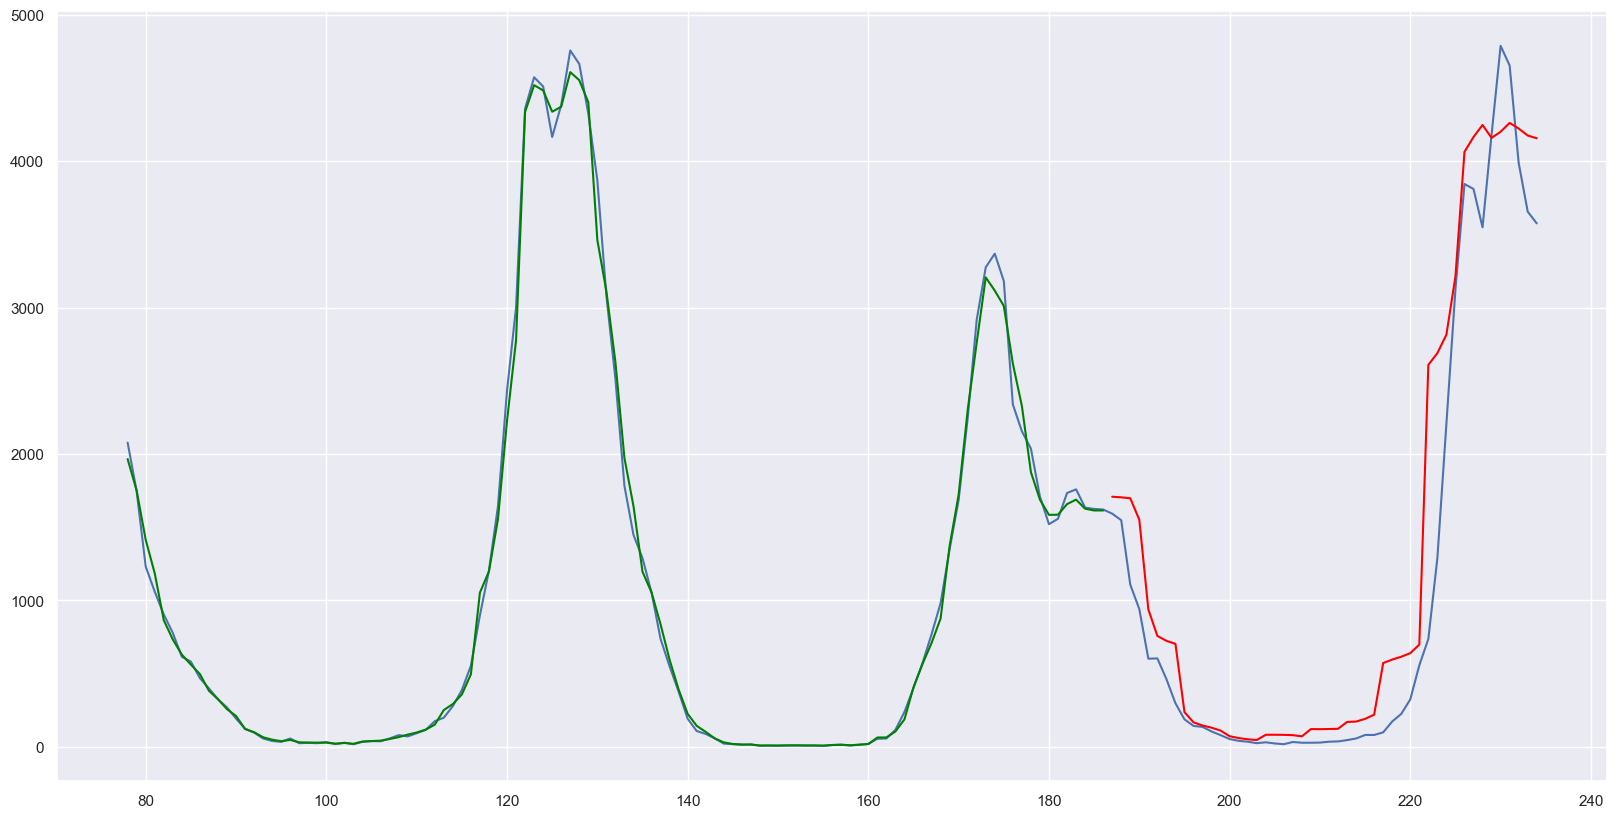

In [521]:
# plot
plt.plot(df.index, df['y1'].values)
plt.plot(df.index[:train_size], preds_train_df['y1'], color='green')
plt.plot(df.index[train_size:], preds_test_df['y1'], color='red')

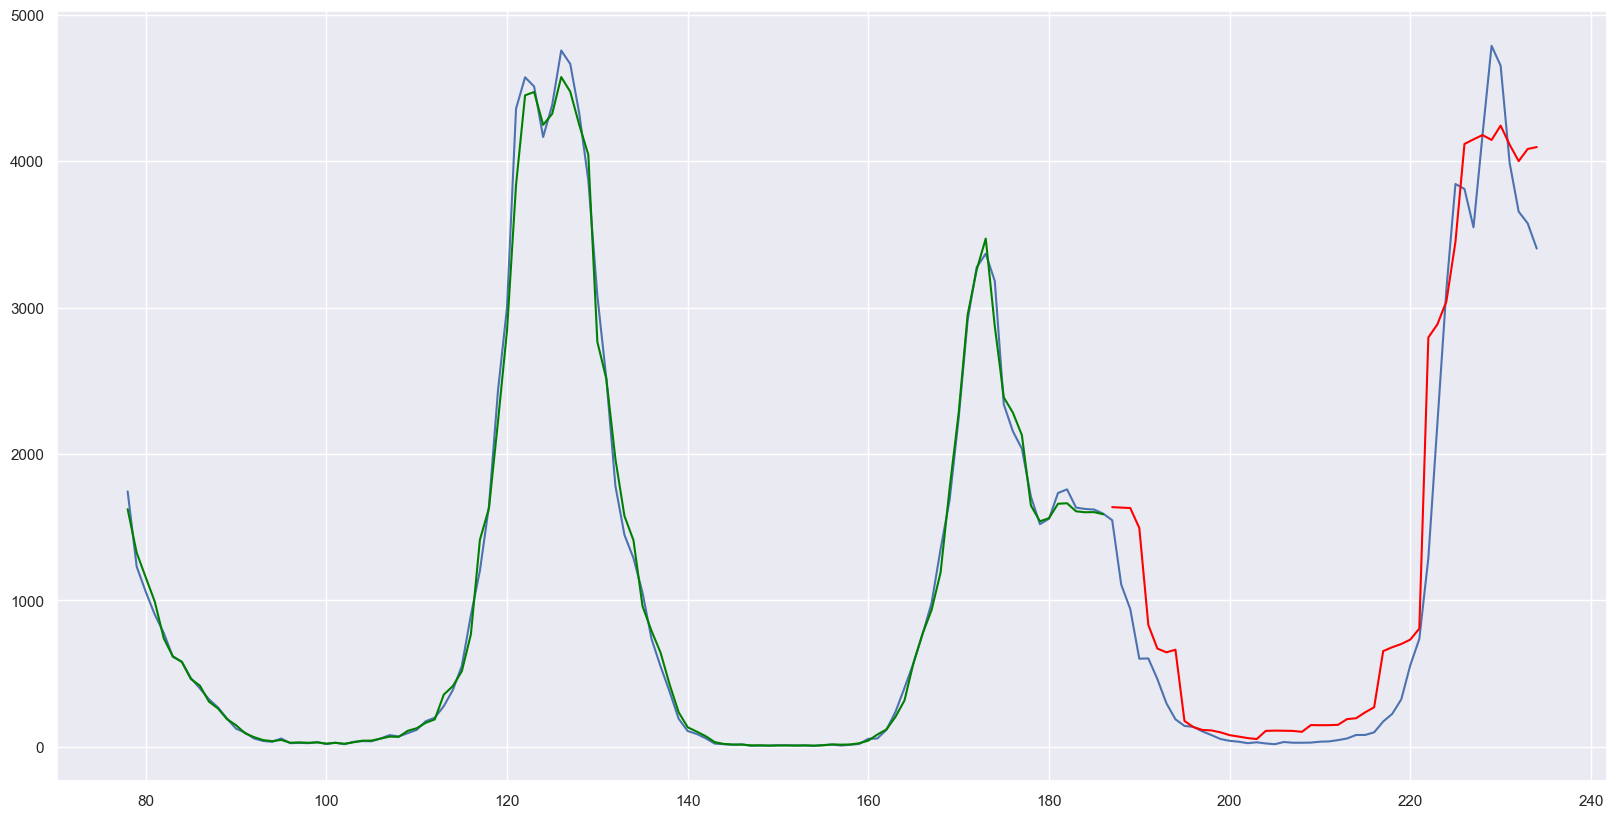

In [522]:
# plot 2-week ahead prediction
plt.plot(df.index, df['y2'].values)
plt.plot(df.index[:train_size], preds_train_df['y2'], color='green')
plt.plot(df.index[train_size:], preds_test_df['y2'], color='red')

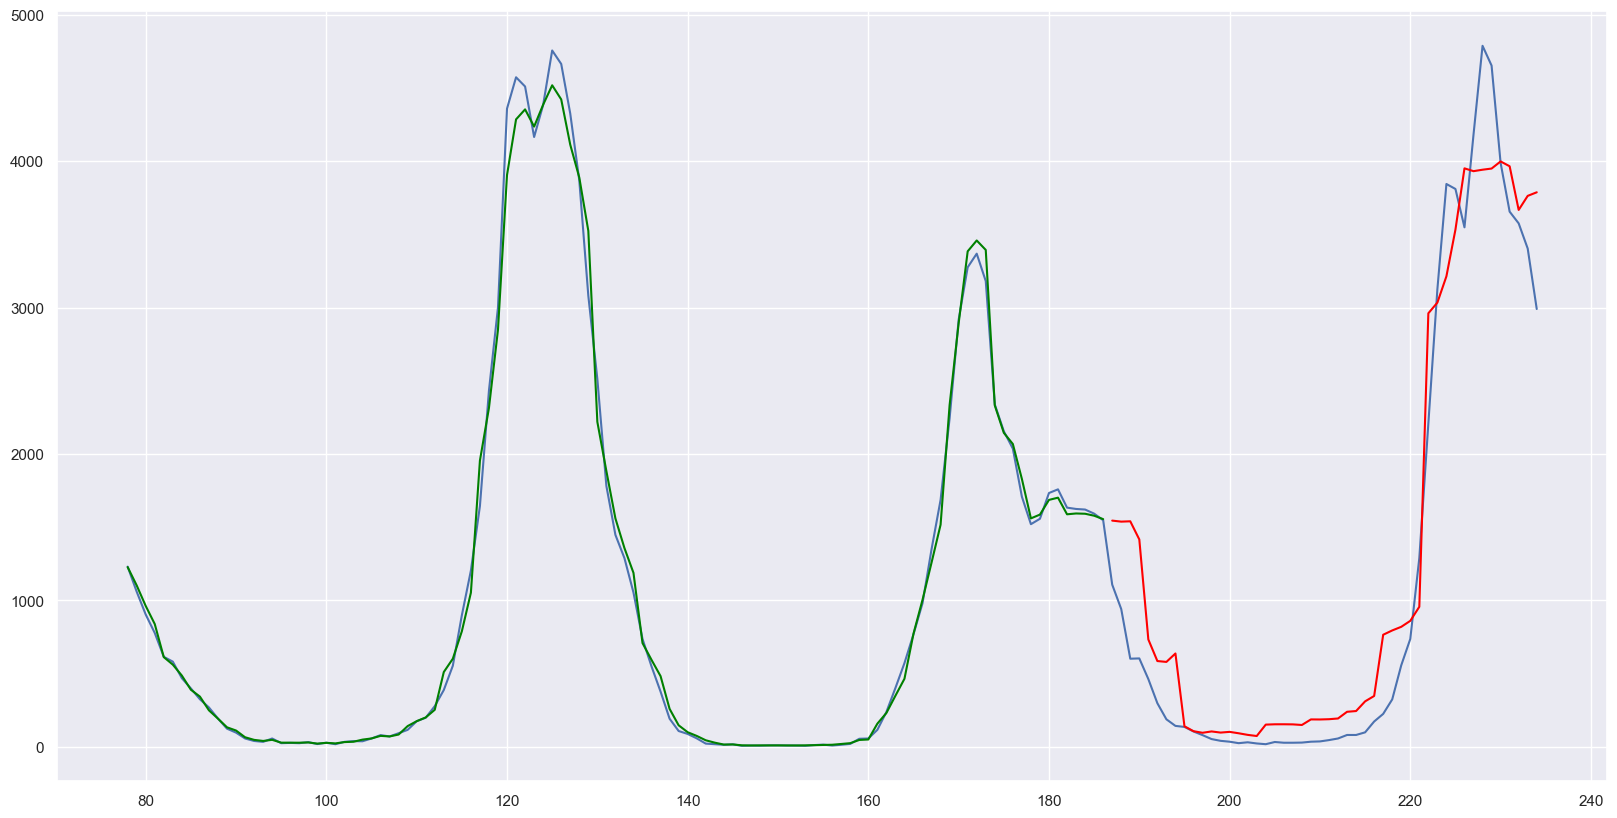

In [523]:
# plot 3-week ahead prediction
plt.plot(df.index, df['y3'].values)
plt.plot(df.index[:train_size], preds_train_df['y3'], color='green')
plt.plot(df.index[train_size:], preds_test_df['y3'], color='red')

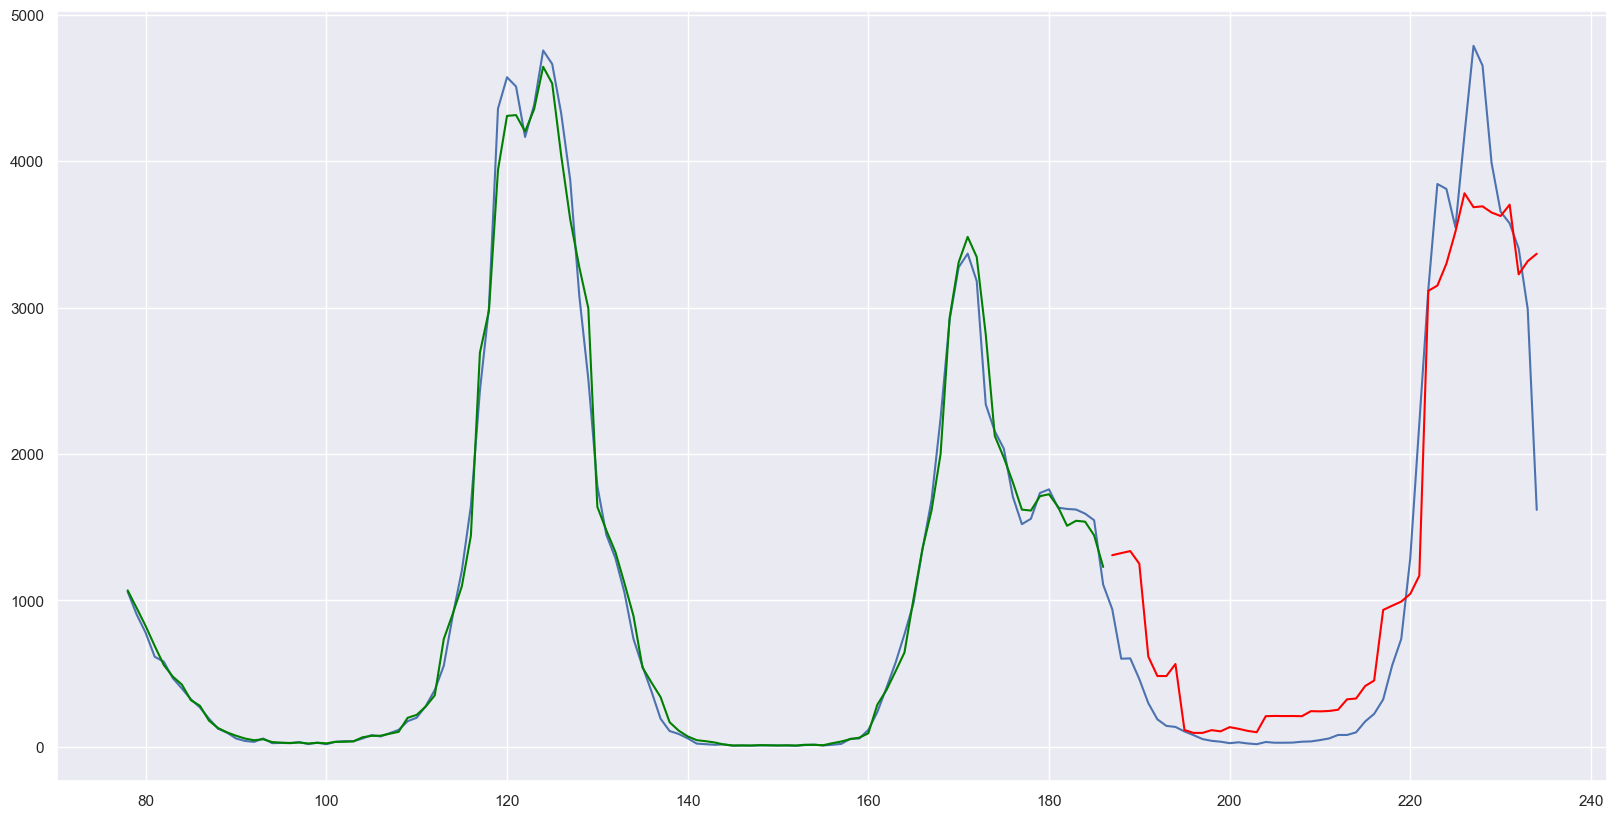

In [524]:
# plot 4-week ahead prediction
plt.plot(df.index, df['y4'].values)
plt.plot(df.index[:train_size], preds_train_df['y4'], color='green')
plt.plot(df.index[train_size:], preds_test_df['y4'], color='red')

In [525]:
# define the evaluation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=2022)
# evaluate the model and collect the scores
n_scores = cross_val_score(model, train_X, train_y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
# force the scores to be positive
n_scores = absolute(n_scores)
# summarize performance
print('RMSE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

RMSE: 272.278 (93.772)


In [526]:
# evaluate all four weeks of predictions

MSE_train = round(mean_squared_error(train_y, preds_train),3)
RMSE_train = round(mean_squared_error(train_y, preds_train, squared=False),3)
MAE_train = round(mean_absolute_error(train_y, preds_train),3)
print(f'MSE_train: {MSE_train}')
print(f'RMSE_train: {RMSE_train}')
print(f'MAE_train: {MAE_train}')

MSE_test = round(mean_squared_error(test_y, preds_test),3)
RMSE_test = round(mean_squared_error(test_y, preds_test, squared=False),3)
MAE_test = round(mean_absolute_error(test_y, preds_test),3)
print(f'MSE_test: {MSE_test}')
print(f'RMSE_test: {RMSE_test}')
print(f'MAE_test: {MAE_test}')


MSE_train: 10172.22
RMSE_train: 100.37
MAE_train: 55.22
MSE_test: 183374.425
RMSE_test: 426.504
MAE_test: 292.988


In [527]:
# evaluate 1-week ahead prediction only

MSE_train = round(mean_squared_error(train_y['y1'], preds_train_df['y1']),3)
RMSE_train = round(mean_squared_error(train_y['y1'], preds_train_df['y1'], squared=False),3)
MAE_train = round(mean_absolute_error(train_y['y1'], preds_train_df['y1']),3)
print(f'MSE_train: {MSE_train}')
print(f'RMSE_train: {RMSE_train}')
print(f'MAE_train: {MAE_train}')

MSE_test = round(mean_squared_error(test_y['y1'], preds_test_df['y1']),3)
RMSE_test = round(mean_squared_error(test_y['y1'], preds_test_df['y1'], squared=False),3)
MAE_test = round(mean_absolute_error(test_y['y1'], preds_test_df['y1']),3)
print(f'MSE_test: {MSE_test}')
print(f'RMSE_test: {RMSE_test}')
print(f'MAE_test: {MAE_test}')


MSE_train: 7781.998
RMSE_train: 88.216
MAE_train: 49.653
MSE_test: 199712.116
RMSE_test: 446.892
MAE_test: 276.713


In [528]:
# evaluate 2-week ahead prediction only

MSE_train = round(mean_squared_error(train_y['y2'], preds_train_df['y2']),3)
RMSE_train = round(mean_squared_error(train_y['y2'], preds_train_df['y2'], squared=False),3)
MAE_train = round(mean_absolute_error(train_y['y2'], preds_train_df['y2']),3)
print(f'MSE_train: {MSE_train}')
print(f'RMSE_train: {RMSE_train}')
print(f'MAE_train: {MAE_train}')

MSE_test = round(mean_squared_error(test_y['y2'], preds_test_df['y2']),3)
RMSE_test = round(mean_squared_error(test_y['y2'], preds_test_df['y2'], squared=False),3)
MAE_test = round(mean_absolute_error(test_y['y2'], preds_test_df['y2']),3)
print(f'MSE_test: {MSE_test}')
print(f'RMSE_test: {RMSE_test}')
print(f'MAE_test: {MAE_test}')


MSE_train: 8964.505
RMSE_train: 94.681
MAE_train: 52.135
MSE_test: 158383.012
RMSE_test: 397.974
MAE_test: 270.943


In [529]:
# evaluate 3-week ahead prediction only

MSE_train = round(mean_squared_error(train_y['y3'], preds_train_df['y3']),3)
RMSE_train = round(mean_squared_error(train_y['y3'], preds_train_df['y3'], squared=False),3)
MAE_train = round(mean_absolute_error(train_y['y3'], preds_train_df['y3']),3)
print(f'MSE_train: {MSE_train}')
print(f'RMSE_train: {RMSE_train}')
print(f'MAE_train: {MAE_train}')

MSE_test = round(mean_squared_error(test_y['y3'], preds_test_df['y3']),3)
RMSE_test = round(mean_squared_error(test_y['y3'], preds_test_df['y3'], squared=False),3)
MAE_test = round(mean_absolute_error(test_y['y3'], preds_test_df['y3']),3)
print(f'MSE_test: {MSE_test}')
print(f'RMSE_test: {RMSE_test}')
print(f'MAE_test: {MAE_test}')


MSE_train: 10841.558
RMSE_train: 104.123
MAE_train: 56.366
MSE_test: 146351.688
RMSE_test: 382.559
MAE_test: 286.929


In [530]:
# evaluate 4-week ahead prediction only

MSE_train = round(mean_squared_error(train_y['y4'], preds_train_df['y4']),4)
RMSE_train = round(mean_squared_error(train_y['y4'], preds_train_df['y4'], squared=False),4)
MAE_train = round(mean_absolute_error(train_y['y4'], preds_train_df['y4']),4)
print(f'MSE_train: {MSE_train}')
print(f'RMSE_train: {RMSE_train}')
print(f'MAE_train: {MAE_train}')

MSE_test = round(mean_squared_error(test_y['y4'], preds_test_df['y4']),4)
RMSE_test = round(mean_squared_error(test_y['y4'], preds_test_df['y4'], squared=False),4)
MAE_test = round(mean_absolute_error(test_y['y4'], preds_test_df['y4']),4)
print(f'MSE_test: {MSE_test}')
print(f'RMSE_test: {RMSE_test}')
print(f'MAE_test: {MAE_test}')

MSE_train: 13100.8185
RMSE_train: 114.4588
MAE_train: 62.7261
MSE_test: 229050.883
RMSE_test: 478.5926
MAE_test: 337.3652


In [531]:
model.feature_importances_

array([2.71052889e-04, 1.44580924e-04, 4.19479368e-04, 2.58106293e-04,
       1.06211030e-04, 3.05918089e-04, 5.80709511e-04, 1.40993476e-03,
       2.29063389e-04, 2.11719741e-04, 6.14246030e-04, 1.61380577e-04,
       2.20181240e-04, 1.86481699e-04, 6.51809455e-04, 1.70943198e-04,
       3.70451049e-04, 1.98102177e-04, 1.78369753e-04, 6.18445995e-04,
       4.14692849e-04, 3.27110080e-04, 3.26271926e-04, 3.56588799e-04,
       5.34486742e-04, 1.53440531e-04, 6.77996253e-03, 1.90415491e-02,
       2.28130580e-03, 2.73159820e-03, 2.60082157e-02, 1.95692439e-01,
       7.82480755e-02, 2.62498413e-04, 8.04962286e-03, 3.78976142e-02,
       5.26997712e-03, 1.28115895e-03, 3.20471151e-01, 8.74985053e-03,
       0.00000000e+00, 3.01693039e-04, 2.39139807e-05, 9.13629868e-04,
       0.00000000e+00, 1.33256116e-04, 6.94990604e-05, 1.00272198e-01,
       1.06077640e-02, 6.42532588e-03, 5.27086377e-03, 8.08741481e-03,
       7.31394250e-03, 1.41548511e-02, 1.07926529e-02, 1.55653086e-02,
      

Feature: 0, Score: 0.00027
Feature: 1, Score: 0.00014
Feature: 2, Score: 0.00042
Feature: 3, Score: 0.00026
Feature: 4, Score: 0.00011
Feature: 5, Score: 0.00031
Feature: 6, Score: 0.00058
Feature: 7, Score: 0.00141
Feature: 8, Score: 0.00023
Feature: 9, Score: 0.00021
Feature: 10, Score: 0.00061
Feature: 11, Score: 0.00016
Feature: 12, Score: 0.00022
Feature: 13, Score: 0.00019
Feature: 14, Score: 0.00065
Feature: 15, Score: 0.00017
Feature: 16, Score: 0.00037
Feature: 17, Score: 0.00020
Feature: 18, Score: 0.00018
Feature: 19, Score: 0.00062
Feature: 20, Score: 0.00041
Feature: 21, Score: 0.00033
Feature: 22, Score: 0.00033
Feature: 23, Score: 0.00036
Feature: 24, Score: 0.00053
Feature: 25, Score: 0.00015
Feature: 26, Score: 0.00678
Feature: 27, Score: 0.01904
Feature: 28, Score: 0.00228
Feature: 29, Score: 0.00273
Feature: 30, Score: 0.02601
Feature: 31, Score: 0.19569
Feature: 32, Score: 0.07825
Feature: 33, Score: 0.00026
Feature: 34, Score: 0.00805
Feature: 35, Score: 0.03790
Fe

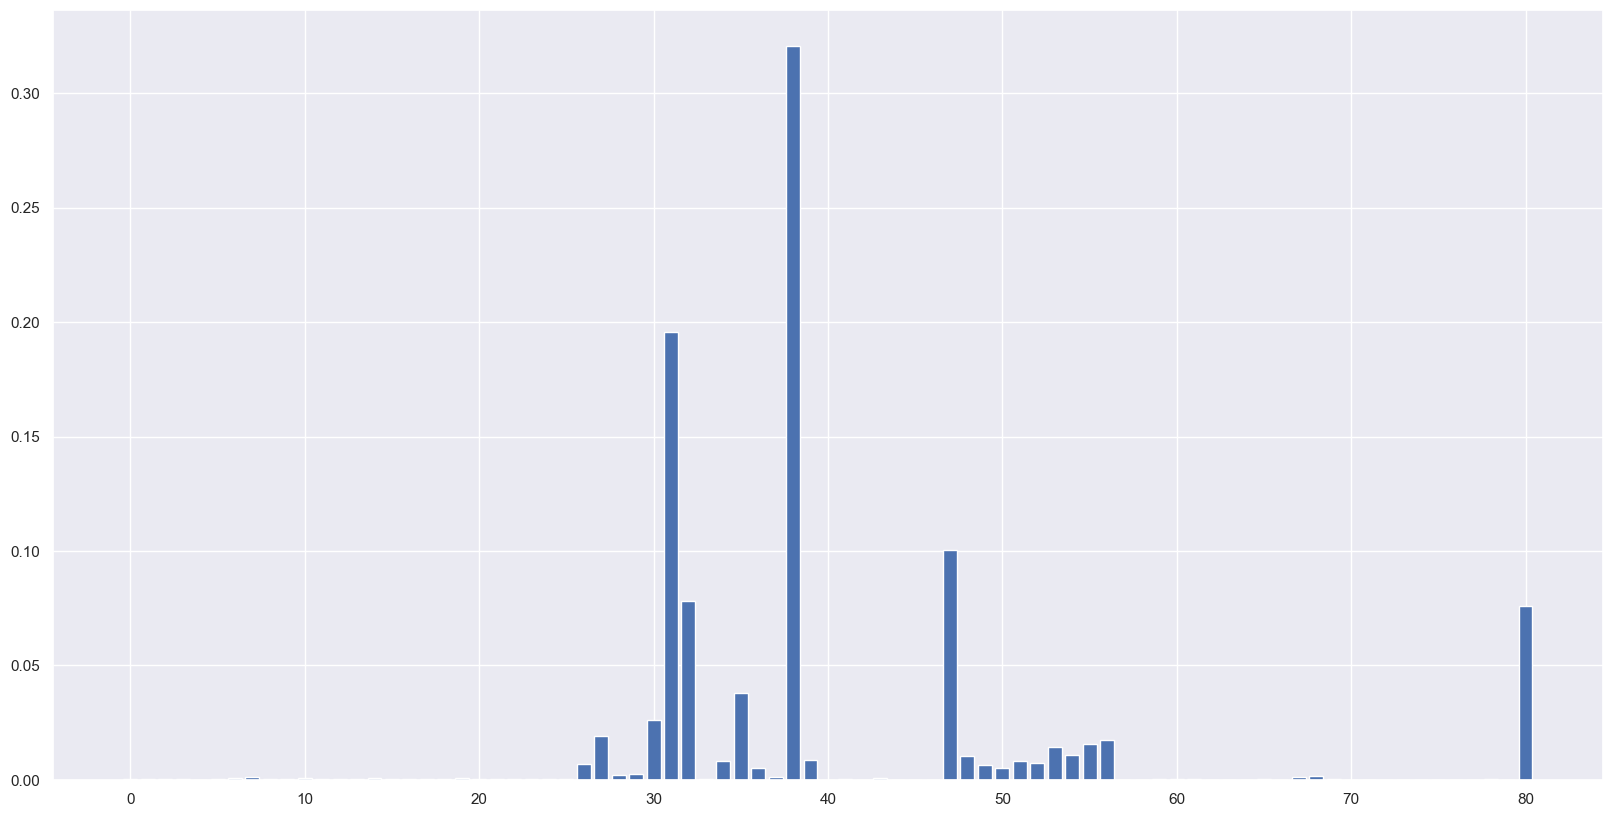

In [532]:
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [533]:
features

Index(['Perceived health very good or excellent 13',
       'Perceived health fair or poor 13',
       'Perceived mental health very good or excellent 14',
       'Perceived mental health fair or poor 14',
       'Perceived life stress most days quite a bit or extremely stressful 15',
       'Body mass index adjusted self-reported adult (18 years and over) overweight 16 17 18 19 20 21',
       'Body mass index adjusted self-reported adult (18 years and over) obese 16 17 18 19 20 21',
       'Body mass index self-reported youth (12 to 17 years old) overweight or obese 16 17 18 19 21',
       'Arthritis (15 years and over) 22', 'Diabetes 23', 'Asthma 24 25',
       'Chronic obstructive pulmonary disease (COPD; 35 years and over) 25 26 27',
       'High blood pressure 27 28', 'Mood disorder 29',
       'Current smoker daily or occasional 30 31 32 33 34',
       'Current smoker daily 30 31 32 33', 'Heavy drinking 37',
       'Self-reported physical activity 150 minutes per week adult (18 y

<AxesSubplot: >

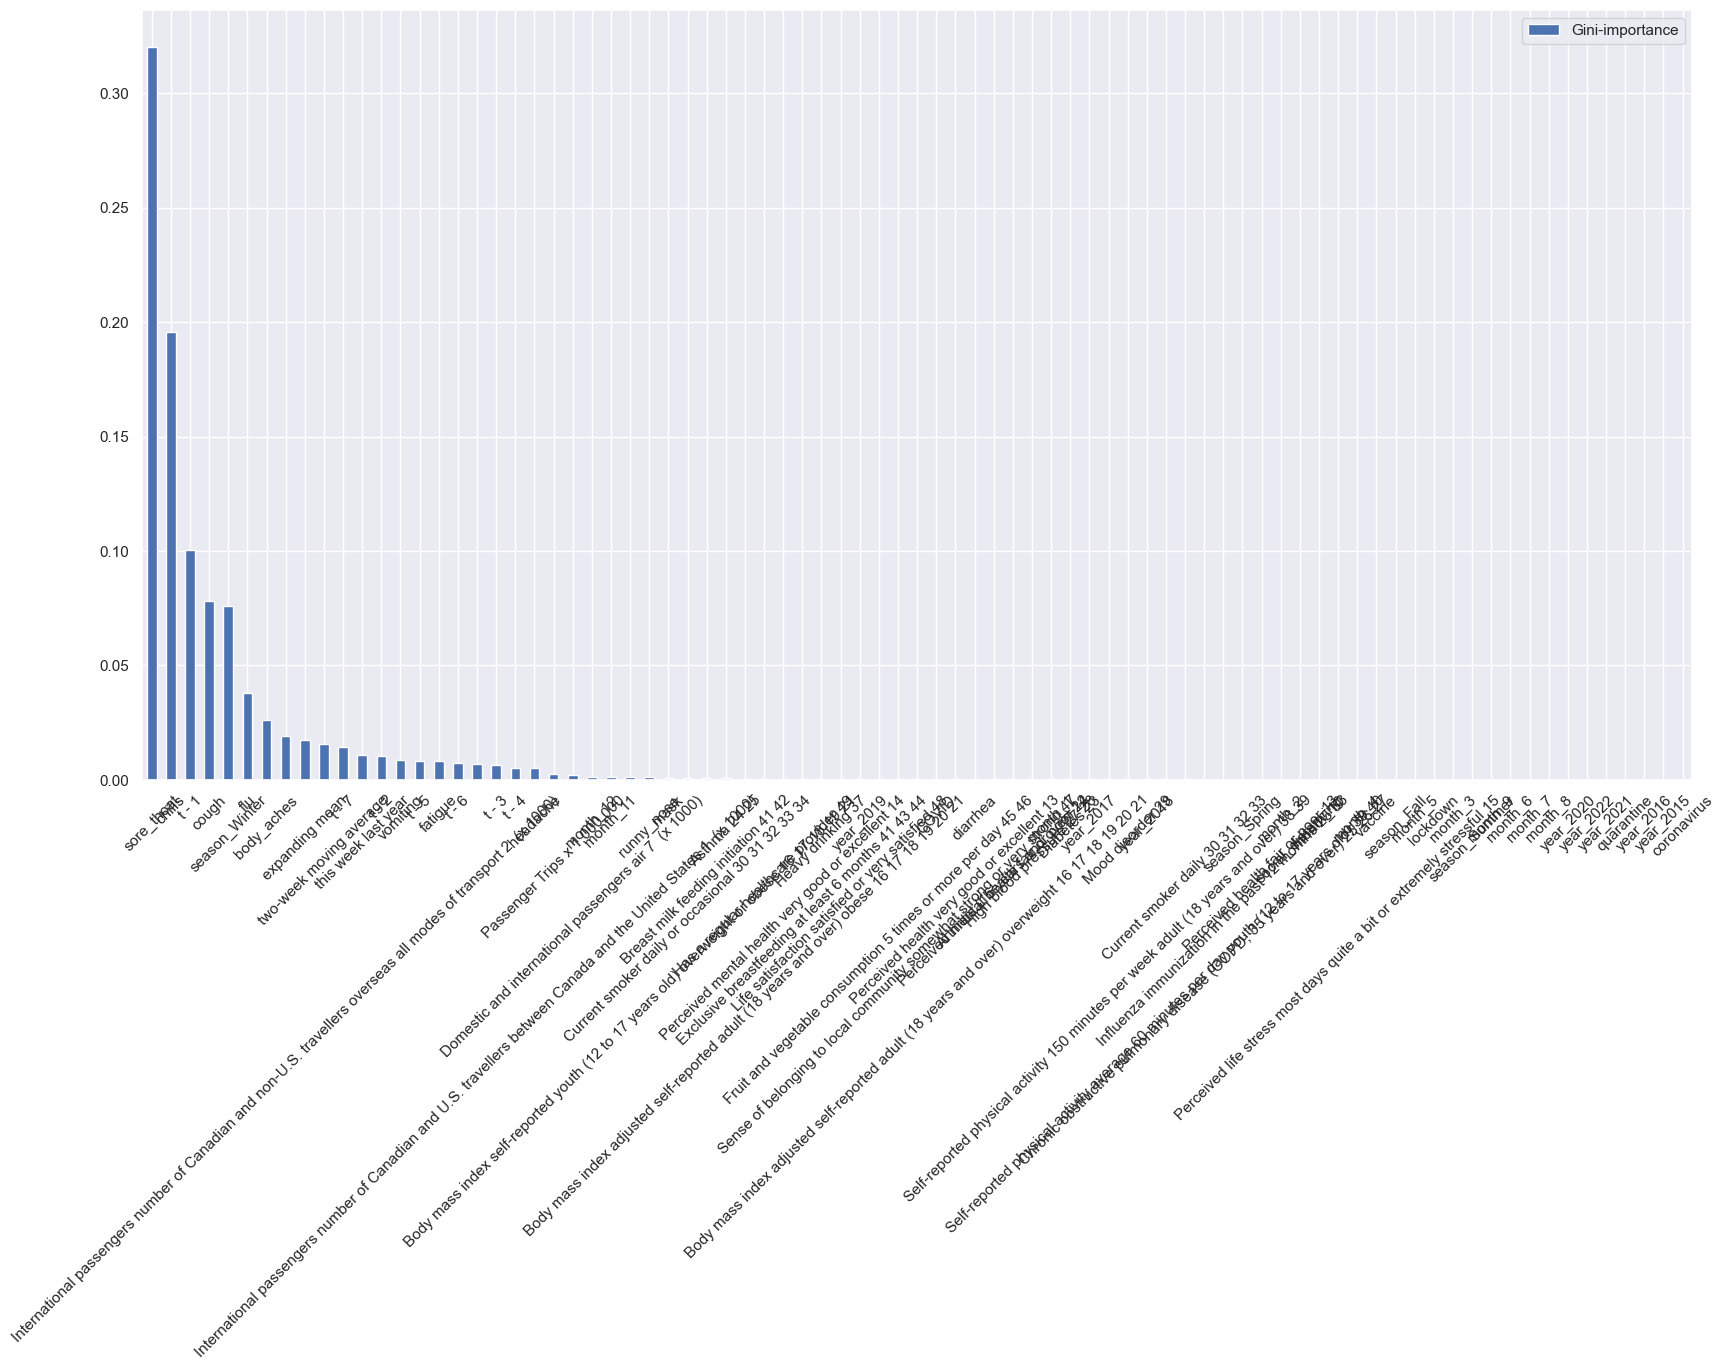

In [534]:
# https://stackoverflow.com/questions/41900387/mapping-column-names-to-random-forest-feature-importances

import pandas as pd
%matplotlib inline
#do code to support model
#"data" is the X dataframe and model is the SKlearn object

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(features, model.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance', ascending=False).plot(kind='bar', rot=45)

In [ ]:
len(features)

57

In [ ]:
feats_to_remove = importances.sort_values('Gini-importance').iloc[0:25,:].index.to_list()

In [ ]:
feats_to_remove

['year_2015',
 'month_3',
 'season_Fall',
 'month_1',
 'Sense of belonging to local community somewhat strong or very strong 47',
 'Influenza immunization in the past 12 months 25 53',
 'High blood pressure 27 28',
 'lockdown',
 'year_2017',
 'runny_nose',
 'Heavy drinking 37',
 'Diabetes 23',
 'month_4',
 'Body mass index adjusted self-reported adult (18 years and over) overweight 16 17 18 19 20 21',
 'year_2019',
 'Body mass index adjusted self-reported adult (18 years and over) obese 16 17 18 19 20 21',
 'Fruit and vegetable consumption 5 times or more per day 45 46',
 'Perceived life stress most days quite a bit or extremely stressful 15',
 'Mood disorder 29',
 'Perceived mental health fair or poor 14',
 'month_10',
 'mask',
 'Self-reported physical activity 150 minutes per week adult (18 years and over) 38 39',
 'Current smoker daily 30 31 32 33',
 'Perceived health fair or poor 13']

In [536]:
for i in range(1,5):
    results_matrix = evaluate_model(train=train_y, test=test_y, preds_train=preds_train, preds_test=preds_test, dataset='Pre-COVID (all feats w/o fever)', forecast_weeks=i)
results_matrix

Dataset Weeks-ahead Forecast  \
0                       Pre-COVID - (all time feats)                    1   
0                       Pre-COVID - (all time feats)                    2   
0                       Pre-COVID - (all time feats)                    3   
0                       Pre-COVID - (all time feats)                    4   
0             Pre-COVID (time feats, remove M and Y)                    1   
0             Pre-COVID (time feats, remove M and Y)                    2   
0             Pre-COVID (time feats, remove M and Y)                    3   
0             Pre-COVID (time feats, remove M and Y)                    4   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    1   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    2   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    3   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    4   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    1   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    2   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    3   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    4   
0                               Pre-COVID (all feats                    1   
0                               Pre-COVID (all feats                    2   
0                               Pre-COVID (all feats                    3   
0                               Pre-COVID (all feats                    4   
0                               Pre-COVID (all feats                    1   
0                               Pre-COVID (all feats                    2   
0                               Pre-COVID (all feats                    3   
0                               Pre-COVID (all feats                    4   
0                    Pre-COVID (all feats w/o fever)                    1   
0                    Pre-COVID (all feats w/o fever)                    2   
0                    Pre-COVID (all feats w/o fever)                    3   
0                    Pre-COVID (all feats w/o fever)                    4   

  MSE_train   MSE_test RMSE_train RMSE_test MAE_train MAE_test  R2_train  \
0   8645.66   97600.06      92.98    312.41     50.03   193.03  0.995238   
0  13142.62  192354.67     114.64    438.58     64.11   249.64  0.992735   
0  16733.42  287159.05     129.36    535.87     70.98    310.1  0.990716   
0  22529.88  358909.52      150.1    599.09     84.21   365.58  0.987464   
0   9987.75   89840.61      99.94    299.73     52.96    186.3  0.994499   
0  15031.57  172524.55      122.6    415.36     66.82   225.45   0.99169   
0  19320.23  259617.88      139.0    509.53     77.24   280.81  0.989281   
0   26457.7  320536.19     162.66    566.16     90.66   330.62  0.985279   
0   9359.49   68548.97      96.74    261.82     53.67   172.17  0.994845   
0  14962.43  136966.77     122.32    370.09     68.63    217.7  0.991728   
0  17838.93  213031.78     133.56    461.55     74.65   267.06  0.990103   
0  21819.18  291982.47     147.71    540.35     84.42   330.86   0.98786   
0   7591.63   96391.15      87.13    310.47     51.04   206.92  0.995819   
0  10692.14   92682.13      103.4    304.44     60.91   211.15  0.994089   
0  12902.56  108251.91     113.59    329.02     65.83   232.89  0.992841   
0  14230.53  202893.61     119.29    450.44     74.15   301.03  0.992082   
0   7314.27  261944.97      85.52    511.81     50.21   290.86  0.995955   
0  10207.11  206830.95     101.03    454.79     55.08   280.53  0.994333   
0  12055.99  160165.39      109.8    400.21     59.94   269.54  0.993299   
0  11416.23  218313.15     106.85    467.24     63.47   310.24  0.993654   
0    8901.0  263922.93      94.35    513.73     53.33   272.64  0.995077   
0  12401.75  190925.34     111.36    436.95     58.47   259.27  0.993115   
0  12240.78  142291.06     110.64    377.21     59.42   259.92 

In [537]:
results_matrix.sort_values('RMSE_test')

Dataset Weeks-ahead Forecast  \
0  Pre-COVID (time feats, remove M and Y) + COVID...                    1   
0             Pre-COVID (time feats, remove M and Y)                    1   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    2   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    1   
0                       Pre-COVID - (all time feats)                    1   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    3   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    2   
0                               Pre-COVID (all feats                    3   
0                    Pre-COVID (all feats w/o fever)                    3   
0                    Pre-COVID (all feats w/o fever)                    2   
0                               Pre-COVID (all feats                    3   
0             Pre-COVID (time feats, remove M and Y)                    2   
0                               Pre-COVID (all feats                    2   
0                       Pre-COVID - (all time feats)                    2   
0                    Pre-COVID (all feats w/o fever)                    1   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    4   
0                               Pre-COVID (all feats                    2   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    3   
0                               Pre-COVID (all feats                    4   
0                               Pre-COVID (all feats                    4   
0                    Pre-COVID (all feats w/o fever)                    4   
0             Pre-COVID (time feats, remove M and Y)                    3   
0                               Pre-COVID (all feats                    1   
0                               Pre-COVID (all feats                    1   
0                       Pre-COVID - (all time feats)                    3   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    4   
0             Pre-COVID (time feats, remove M and Y)                    4   
0                       Pre-COVID - (all time feats)                    4   

  MSE_train   MSE_test RMSE_train RMSE_test MAE_train MAE_test  R2_train  \
0   9359.49   68548.97      96.74    261.82     53.67   172.17  0.994845   
0   9987.75   89840.61      99.94    299.73     52.96    186.3  0.994499   
0  10692.14   92682.13      103.4    304.44     60.91   211.15  0.994089   
0   7591.63   96391.15      87.13    310.47     51.04   206.92  0.995819   
0   8645.66   97600.06      92.98    312.41     50.03   193.03  0.995238   
0  12902.56  108251.91     113.59    329.02     65.83   232.89  0.992841   
0  14962.43  136966.77     122.32    370.09     68.63    217.7  0.991728   
0  12240.78  142291.06     110.64    377.21     59.42   259.92  0.993196   
0  10841.56  146351.69     104.12    382.56     56.37   286.93  0.993974   
0    8964.5  158383.01      94.68    397.97     52.14   270.94  0.995023   
0  12055.99  160165.39      109.8    400.21     59.94   269.54  0.993299   
0  15031.57  172524.55      122.6    415.36     66.82   225.45   0.99169   
0  12401.75  190925.34     111.36    436.95     58.47   259.27  0.993115   
0  13142.62  192354.67     114.64    438.58     64.11   249.64  0.992735   
0    7782.0  199712.12      88.22    446.89     49.65   276.71  0.995696   
0  14230.53  202893.61     119.29    450.44     74.15   301.03  0.992082   
0  10207.11  206830.95     101.03    454.79     55.08   280.53  0.994333   
0  17838.93  213031.78     133.56    461.55     74.65   267.06  0.990103   
0  12717.98  214312.93     112.77    462.94     65.77   326.96   0.99293   
0  11416.23  218313.15     106.85    467.24     63.47   310.24  0.993654   
0  13100.82  229050.88     114.46    478.59     62.73   337.37  0.992717   
0  19320.23  259617.88      139.0    509.53     77.24   280.81  0.989281   
0   7314.27  261944.97      85.52    511.81     50.21   290.86 

In [ ]:
results_matrix.sort_values('RMSE_test')['Dataset']

0    Pre-COVID (time feats, remove M and Y) + COVID...
0               Pre-COVID (time feats, remove M and Y)
0    Pre-COVID (time feats, remove M and Y) + COVID...
0    Pre-COVID (time feats, remove M and Y) + COVID...
0                         Pre-COVID - (all time feats)
0    Pre-COVID (time feats, remove M and Y) + COVID...
0    Pre-COVID (time feats, remove M and Y) + COVID...
0               Pre-COVID (time feats, remove M and Y)
0                         Pre-COVID - (all time feats)
0    Pre-COVID (time feats, remove M and Y) + COVID...
0    Pre-COVID (time feats, remove M and Y) + COVID...
0               Pre-COVID (time feats, remove M and Y)
0                         Pre-COVID - (all time feats)
0    Pre-COVID (time feats, remove M and Y) + COVID...
0               Pre-COVID (time feats, remove M and Y)
0                         Pre-COVID - (all time feats)
Name: Dataset, dtype: object

# Random Forest Regression - All Features w/o Fever +Sore Throat

In [538]:
df_pre_COVID_all_features = pickle.load(open(r"..\data\df_pre_COVID_all_features.pkl", "rb" ))
# df_time_features = pickle.load(open(r"..\data\flu_cases\df_time_features.pkl", "rb" ))

# df_COVID_terms_pre_COVID = pickle.load(open(r"..\data\google_trend\df_COVID_terms_pre_COVID.pkl", "rb" ))
# df_COVID_terms = pickle.load(open(r"..\data\google_trend\df_COVID_terms.pkl", "rb" ))

# df_flu_symptoms_pre_COVID = pickle.load(open(r"..\data\google_trend\df_flu_symptoms_pre_COVID.pkl", "rb" ))
# df_flu_symptoms = pickle.load(open(r"..\data\google_trend\df_flu_symptoms.pkl", "rb" ))

In [539]:
df_pre_COVID_all_features.shape

(157, 87)

In [540]:
df_pre_COVID_all_features.columns

Index(['Total Cases', 'Perceived health very good or excellent 13',
       'Perceived health fair or poor 13',
       'Perceived mental health very good or excellent 14',
       'Perceived mental health fair or poor 14',
       'Perceived life stress most days quite a bit or extremely stressful 15',
       'Body mass index adjusted self-reported adult (18 years and over) overweight 16 17 18 19 20 21',
       'Body mass index adjusted self-reported adult (18 years and over) obese 16 17 18 19 20 21',
       'Body mass index self-reported youth (12 to 17 years old) overweight or obese 16 17 18 19 21',
       'Arthritis (15 years and over) 22', 'Diabetes 23', 'Asthma 24 25',
       'Chronic obstructive pulmonary disease (COPD; 35 years and over) 25 26 27',
       'High blood pressure 27 28', 'Mood disorder 29',
       'Current smoker daily or occasional 30 31 32 33 34',
       'Current smoker daily 30 31 32 33', 'Heavy drinking 37',
       'Self-reported physical activity 150 minutes per w

In [541]:
df = df_pre_COVID_all_features

In [542]:
# feats_to_remove

In [558]:
# df.dropna(inplace=True)
# df = df.reset_index(drop=True)
df = df.drop(columns=['fever','sore_thoat','Total Cases'])

In [559]:
df

Perceived health very good or excellent 13  \
78                                   18714100.0   
79                                   18714100.0   
80                                   18714100.0   
81                                   18714100.0   
82                                   18714100.0   
..                                          ...   
230                                  19464600.0   
231                                  19464600.0   
232                                  19464600.0   
233                                  19464600.0   
234                                  19464600.0   

     Perceived health fair or poor 13  \
78                          3443000.0   
79                          3443000.0   
80                          3443000.0   
81                          3443000.0   
82                          3443000.0   
..                                ...   
230                         3464200.0   
231                         3464200.0   
232                         3464200.0   
233                         3464200.0   
234                         3464200.0   

     Perceived mental health very good or excellent 14  \
78                                          21023500.0   
79                                          21023500.0   
80                                          21023500.0   
81                                          21023500.0   
82                                          21023500.0   
..                                                 ...   
230                                         20701100.0   
231                                         20701100.0   
232                                         20701100.0   
233                                         20701100.0   
234                                         20701100.0   

     Perceived mental health fair or poor 14  \
78                                 2053000.0   
79                                 2053000.0   
80                                 2053000.0   
81                                 2053000.0   
82                                 2053000.0   
..                                       ...   
230                                2494800.0   
231                                2494800.0   
232                                2494800.0   
233                                2494800.0   
234                                2494800.0   

     Perceived life stress most days quite a bit or extremely stressful 15  \
78                                           6564200.0                       
79                                           6564200.0                       
80                                           6564200.0                       
81                                           6564200.0                       
82                                           6564200.0                       
..                                                 ...                       
230                                          6729400.0                       
231                                          6729400.0                       
232                                          6729400.0                       
233                                          6729400.0                       
234                                          6729400.0                       

     Body mass index adjusted self-reported adult (18 years and over) overweight 16 17 18 19 20 21  \
78                                           9484900.0                                               
79                                           9484900.0                                               
80                                           9484900.0                                               
81                                           9484900.0                                               
82                                           9484900.0                                               
..                                                 ...                      

In [560]:
df.columns

Index(['Perceived health very good or excellent 13',
       'Perceived health fair or poor 13',
       'Perceived mental health very good or excellent 14',
       'Perceived mental health fair or poor 14',
       'Perceived life stress most days quite a bit or extremely stressful 15',
       'Body mass index adjusted self-reported adult (18 years and over) overweight 16 17 18 19 20 21',
       'Body mass index adjusted self-reported adult (18 years and over) obese 16 17 18 19 20 21',
       'Body mass index self-reported youth (12 to 17 years old) overweight or obese 16 17 18 19 21',
       'Arthritis (15 years and over) 22', 'Diabetes 23', 'Asthma 24 25',
       'Chronic obstructive pulmonary disease (COPD; 35 years and over) 25 26 27',
       'High blood pressure 27 28', 'Mood disorder 29',
       'Current smoker daily or occasional 30 31 32 33 34',
       'Current smoker daily 30 31 32 33', 'Heavy drinking 37',
       'Self-reported physical activity 150 minutes per week adult (18 y

In [561]:
train_size = int(len(df) *.7)
test_size = len(df) - train_size
train, test = df[0:train_size], df[train_size:len(df)]

In [562]:
train_y = train[['y1','y2','y3','y4']]
train_X = train.drop(columns=['y1','y2','y3','y4'])
test_y = test[['y1','y2','y3','y4']]
test_X = test.drop(columns=['y1','y2','y3','y4'])

In [563]:
features = train_X.columns

In [565]:
train_X_to_scale = train_X.loc[:,:'expanding mean']
test_X_to_scale = test_X.loc[:,:'expanding mean']
train_X_not_to_scale = train_X.loc[:,'year_2015':].to_numpy()
test_X_not_to_scale = test_X.loc[:,'year_2015':].to_numpy()

In [566]:
from sklearn.preprocessing import MinMaxScaler

# scale data
scaler = MinMaxScaler()
train_X_to_scale = scaler.fit_transform(train_X_to_scale)
test_X_to_scale = scaler.transform(test_X_to_scale)

In [567]:
train_X = np.concatenate((train_X_to_scale, train_X_not_to_scale),axis=1)
test_X = np.concatenate((test_X_to_scale, test_X_not_to_scale),axis=1)

In [568]:
train_X.shape

(109, 80)

In [569]:
test_X.shape

(48, 80)

In [570]:
train_y.shape

(109, 4)

In [571]:
test_y.shape

(48, 4)

In [572]:
model = RandomForestRegressor()

model.fit(train_X, train_y)

RandomForestRegressor()

In [573]:
preds_test = model.predict(test_X)
preds_test_df = pd.DataFrame(preds_test,columns=test_y.columns)
preds_train = model.predict(train_X)
preds_train_df = pd.DataFrame(preds_train,columns=train_y.columns)

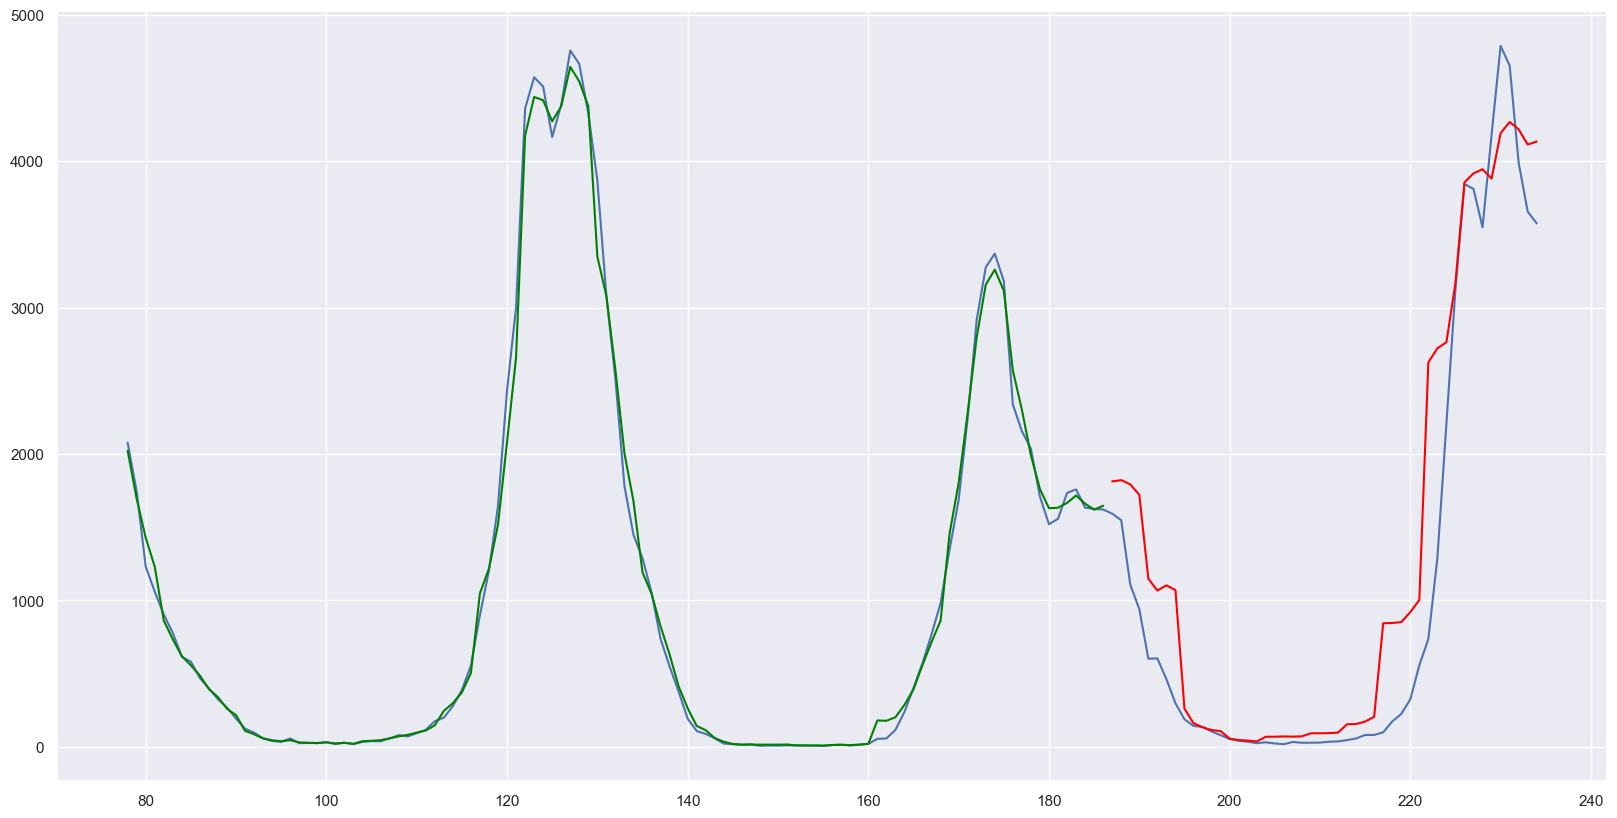

In [574]:
# plot
plt.plot(df.index, df['y1'].values)
plt.plot(df.index[:train_size], preds_train_df['y1'], color='green')
plt.plot(df.index[train_size:], preds_test_df['y1'], color='red')

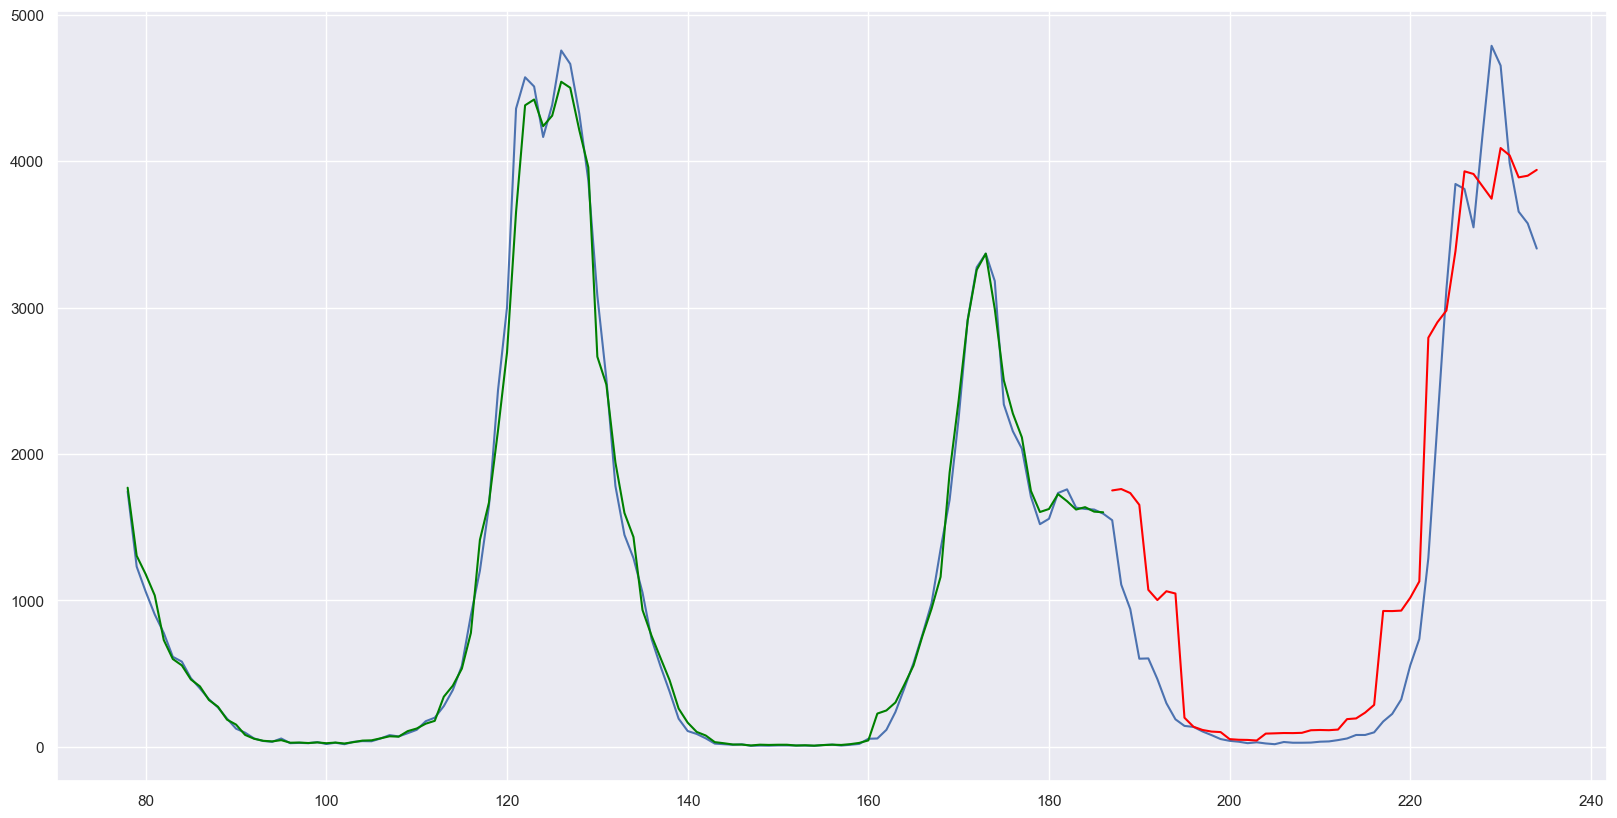

In [575]:
# plot 2-week ahead prediction
plt.plot(df.index, df['y2'].values)
plt.plot(df.index[:train_size], preds_train_df['y2'], color='green')
plt.plot(df.index[train_size:], preds_test_df['y2'], color='red')

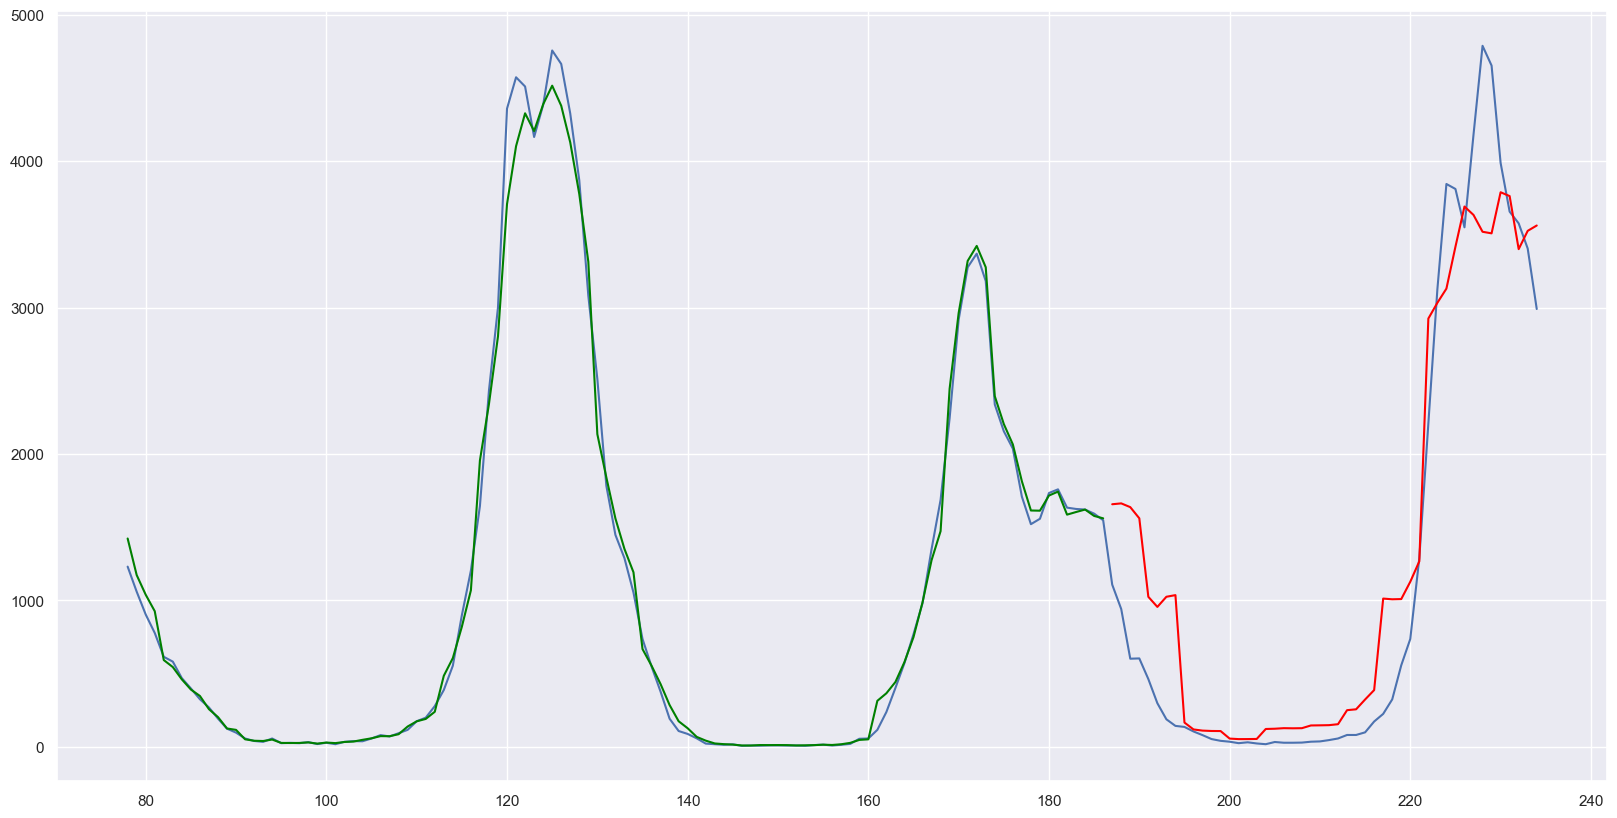

In [576]:
# plot 3-week ahead prediction
plt.plot(df.index, df['y3'].values)
plt.plot(df.index[:train_size], preds_train_df['y3'], color='green')
plt.plot(df.index[train_size:], preds_test_df['y3'], color='red')

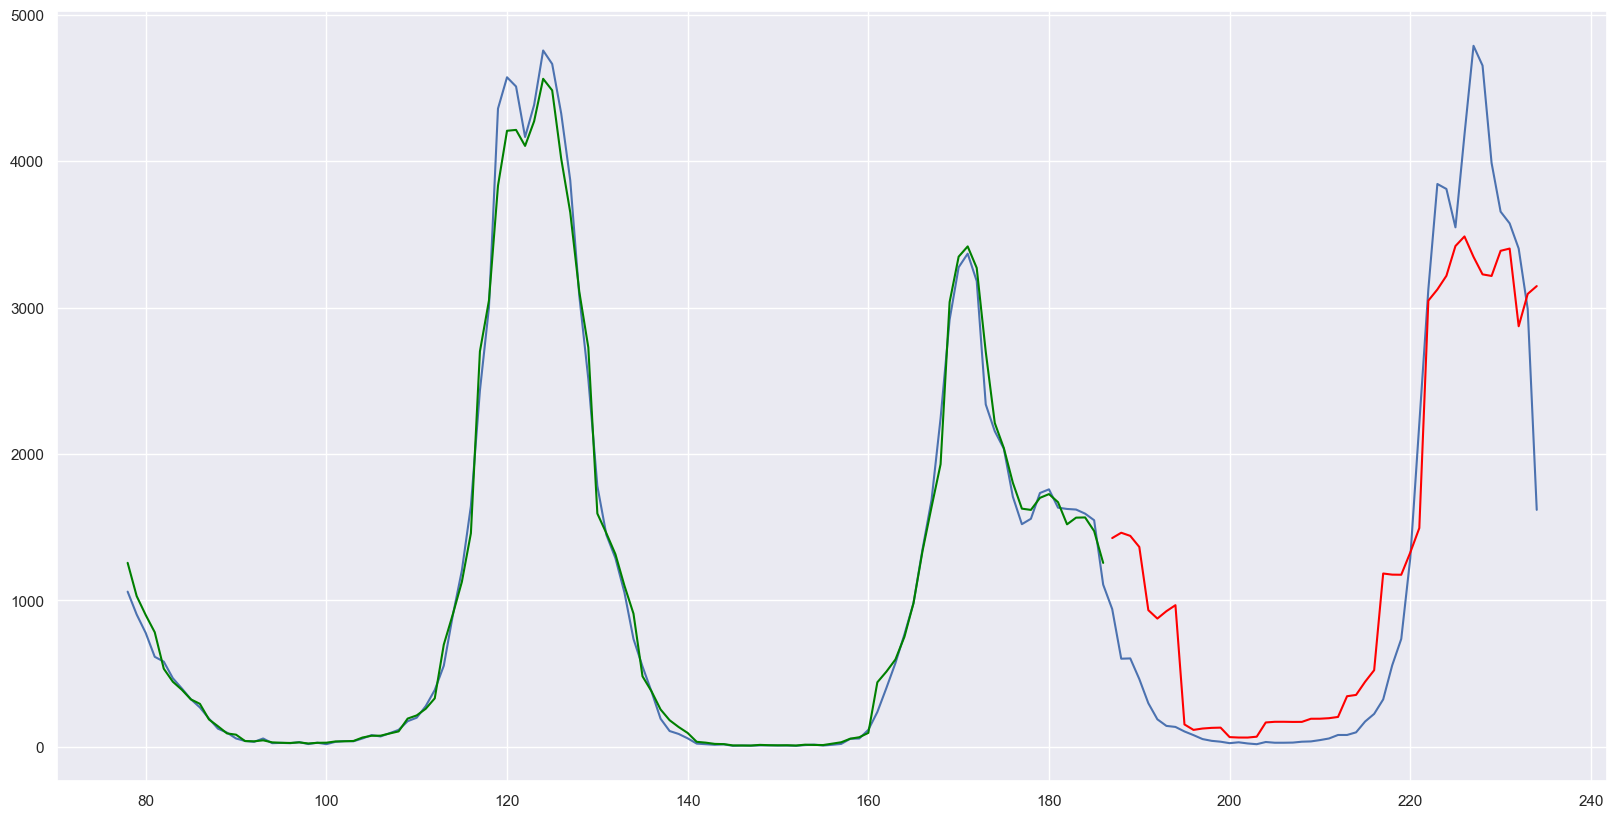

In [577]:
# plot 4-week ahead prediction
plt.plot(df.index, df['y4'].values)
plt.plot(df.index[:train_size], preds_train_df['y4'], color='green')
plt.plot(df.index[train_size:], preds_test_df['y4'], color='red')

In [578]:
# define the evaluation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=2022)
# evaluate the model and collect the scores
n_scores = cross_val_score(model, train_X, train_y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
# force the scores to be positive
n_scores = absolute(n_scores)
# summarize performance
print('RMSE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

RMSE: 276.059 (100.660)


In [579]:
# evaluate all four weeks of predictions

MSE_train = round(mean_squared_error(train_y, preds_train),3)
RMSE_train = round(mean_squared_error(train_y, preds_train, squared=False),3)
MAE_train = round(mean_absolute_error(train_y, preds_train),3)
print(f'MSE_train: {MSE_train}')
print(f'RMSE_train: {RMSE_train}')
print(f'MAE_train: {MAE_train}')

MSE_test = round(mean_squared_error(test_y, preds_test),3)
RMSE_test = round(mean_squared_error(test_y, preds_test, squared=False),3)
MAE_test = round(mean_absolute_error(test_y, preds_test),3)
print(f'MSE_test: {MSE_test}')
print(f'RMSE_test: {RMSE_test}')
print(f'MAE_test: {MAE_test}')


MSE_train: 12967.836
RMSE_train: 113.625
MAE_train: 62.696
MSE_test: 263385.858
RMSE_test: 511.903
MAE_test: 355.825


In [580]:
# evaluate 1-week ahead prediction only

MSE_train = round(mean_squared_error(train_y['y1'], preds_train_df['y1']),3)
RMSE_train = round(mean_squared_error(train_y['y1'], preds_train_df['y1'], squared=False),3)
MAE_train = round(mean_absolute_error(train_y['y1'], preds_train_df['y1']),3)
print(f'MSE_train: {MSE_train}')
print(f'RMSE_train: {RMSE_train}')
print(f'MAE_train: {MAE_train}')

MSE_test = round(mean_squared_error(test_y['y1'], preds_test_df['y1']),3)
RMSE_test = round(mean_squared_error(test_y['y1'], preds_test_df['y1'], squared=False),3)
MAE_test = round(mean_absolute_error(test_y['y1'], preds_test_df['y1']),3)
print(f'MSE_test: {MSE_test}')
print(f'RMSE_test: {RMSE_test}')
print(f'MAE_test: {MAE_test}')


MSE_train: 10219.12
RMSE_train: 101.09
MAE_train: 58.138
MSE_test: 250644.22
RMSE_test: 500.644
MAE_test: 322.597


In [581]:
# evaluate 2-week ahead prediction only

MSE_train = round(mean_squared_error(train_y['y2'], preds_train_df['y2']),3)
RMSE_train = round(mean_squared_error(train_y['y2'], preds_train_df['y2'], squared=False),3)
MAE_train = round(mean_absolute_error(train_y['y2'], preds_train_df['y2']),3)
print(f'MSE_train: {MSE_train}')
print(f'RMSE_train: {RMSE_train}')
print(f'MAE_train: {MAE_train}')

MSE_test = round(mean_squared_error(test_y['y2'], preds_test_df['y2']),3)
RMSE_test = round(mean_squared_error(test_y['y2'], preds_test_df['y2'], squared=False),3)
MAE_test = round(mean_absolute_error(test_y['y2'], preds_test_df['y2']),3)
print(f'MSE_test: {MSE_test}')
print(f'RMSE_test: {RMSE_test}')
print(f'MAE_test: {MAE_test}')


MSE_train: 13260.552
RMSE_train: 115.154
MAE_train: 61.273
MSE_test: 231003.703
RMSE_test: 480.628
MAE_test: 335.053


In [582]:
# evaluate 3-week ahead prediction only

MSE_train = round(mean_squared_error(train_y['y3'], preds_train_df['y3']),3)
RMSE_train = round(mean_squared_error(train_y['y3'], preds_train_df['y3'], squared=False),3)
MAE_train = round(mean_absolute_error(train_y['y3'], preds_train_df['y3']),3)
print(f'MSE_train: {MSE_train}')
print(f'RMSE_train: {RMSE_train}')
print(f'MAE_train: {MAE_train}')

MSE_test = round(mean_squared_error(test_y['y3'], preds_test_df['y3']),3)
RMSE_test = round(mean_squared_error(test_y['y3'], preds_test_df['y3'], squared=False),3)
MAE_test = round(mean_absolute_error(test_y['y3'], preds_test_df['y3']),3)
print(f'MSE_test: {MSE_test}')
print(f'RMSE_test: {RMSE_test}')
print(f'MAE_test: {MAE_test}')


MSE_train: 14696.557
RMSE_train: 121.229
MAE_train: 64.543
MSE_test: 242280.778
RMSE_test: 492.22
MAE_test: 348.913


In [583]:
# evaluate 4-week ahead prediction only

MSE_train = round(mean_squared_error(train_y['y4'], preds_train_df['y4']),4)
RMSE_train = round(mean_squared_error(train_y['y4'], preds_train_df['y4'], squared=False),4)
MAE_train = round(mean_absolute_error(train_y['y4'], preds_train_df['y4']),4)
print(f'MSE_train: {MSE_train}')
print(f'RMSE_train: {RMSE_train}')
print(f'MAE_train: {MAE_train}')

MSE_test = round(mean_squared_error(test_y['y4'], preds_test_df['y4']),4)
RMSE_test = round(mean_squared_error(test_y['y4'], preds_test_df['y4'], squared=False),4)
MAE_test = round(mean_absolute_error(test_y['y4'], preds_test_df['y4']),4)
print(f'MSE_test: {MSE_test}')
print(f'RMSE_test: {RMSE_test}')
print(f'MAE_test: {MAE_test}')

MSE_train: 13695.1131
RMSE_train: 117.0261
MAE_train: 66.8273
MSE_test: 329614.7322
RMSE_test: 574.1208
MAE_test: 416.7365


In [584]:
model.feature_importances_

array([1.90601703e-03, 1.60696765e-03, 2.78243588e-04, 4.80253781e-04,
       2.56925181e-04, 3.98074825e-04, 5.28152858e-04, 1.07116266e-04,
       4.00770976e-04, 1.45526104e-04, 3.89964250e-04, 3.99849956e-04,
       1.38106349e-03, 2.03312377e-04, 1.95939830e-04, 6.26470933e-04,
       8.68470660e-05, 5.85840682e-04, 9.20371310e-04, 4.06433327e-04,
       6.28363235e-04, 1.90914865e-04, 8.68183091e-05, 1.27444728e-03,
       1.40728876e-03, 1.09871535e-04, 7.69230636e-03, 3.17169890e-02,
       1.14766869e-03, 4.18224917e-03, 2.38186692e-02, 3.81911509e-01,
       1.76745985e-01, 6.88632385e-04, 1.65188028e-02, 3.12635163e-02,
       1.96886626e-03, 2.80757811e-04, 3.73791897e-03, 0.00000000e+00,
       7.28465584e-04, 1.25367030e-04, 1.30515581e-03, 0.00000000e+00,
       5.02087928e-04, 1.19707254e-04, 9.95269441e-02, 9.55253563e-03,
       6.29117693e-03, 7.41774449e-03, 5.64336627e-03, 1.00067649e-02,
       8.10733587e-03, 1.27845339e-02, 1.39155075e-02, 1.69576245e-02,
      

Feature: 0, Score: 0.00191
Feature: 1, Score: 0.00161
Feature: 2, Score: 0.00028
Feature: 3, Score: 0.00048
Feature: 4, Score: 0.00026
Feature: 5, Score: 0.00040
Feature: 6, Score: 0.00053
Feature: 7, Score: 0.00011
Feature: 8, Score: 0.00040
Feature: 9, Score: 0.00015
Feature: 10, Score: 0.00039
Feature: 11, Score: 0.00040
Feature: 12, Score: 0.00138
Feature: 13, Score: 0.00020
Feature: 14, Score: 0.00020
Feature: 15, Score: 0.00063
Feature: 16, Score: 0.00009
Feature: 17, Score: 0.00059
Feature: 18, Score: 0.00092
Feature: 19, Score: 0.00041
Feature: 20, Score: 0.00063
Feature: 21, Score: 0.00019
Feature: 22, Score: 0.00009
Feature: 23, Score: 0.00127
Feature: 24, Score: 0.00141
Feature: 25, Score: 0.00011
Feature: 26, Score: 0.00769
Feature: 27, Score: 0.03172
Feature: 28, Score: 0.00115
Feature: 29, Score: 0.00418
Feature: 30, Score: 0.02382
Feature: 31, Score: 0.38191
Feature: 32, Score: 0.17675
Feature: 33, Score: 0.00069
Feature: 34, Score: 0.01652
Feature: 35, Score: 0.03126
Fe

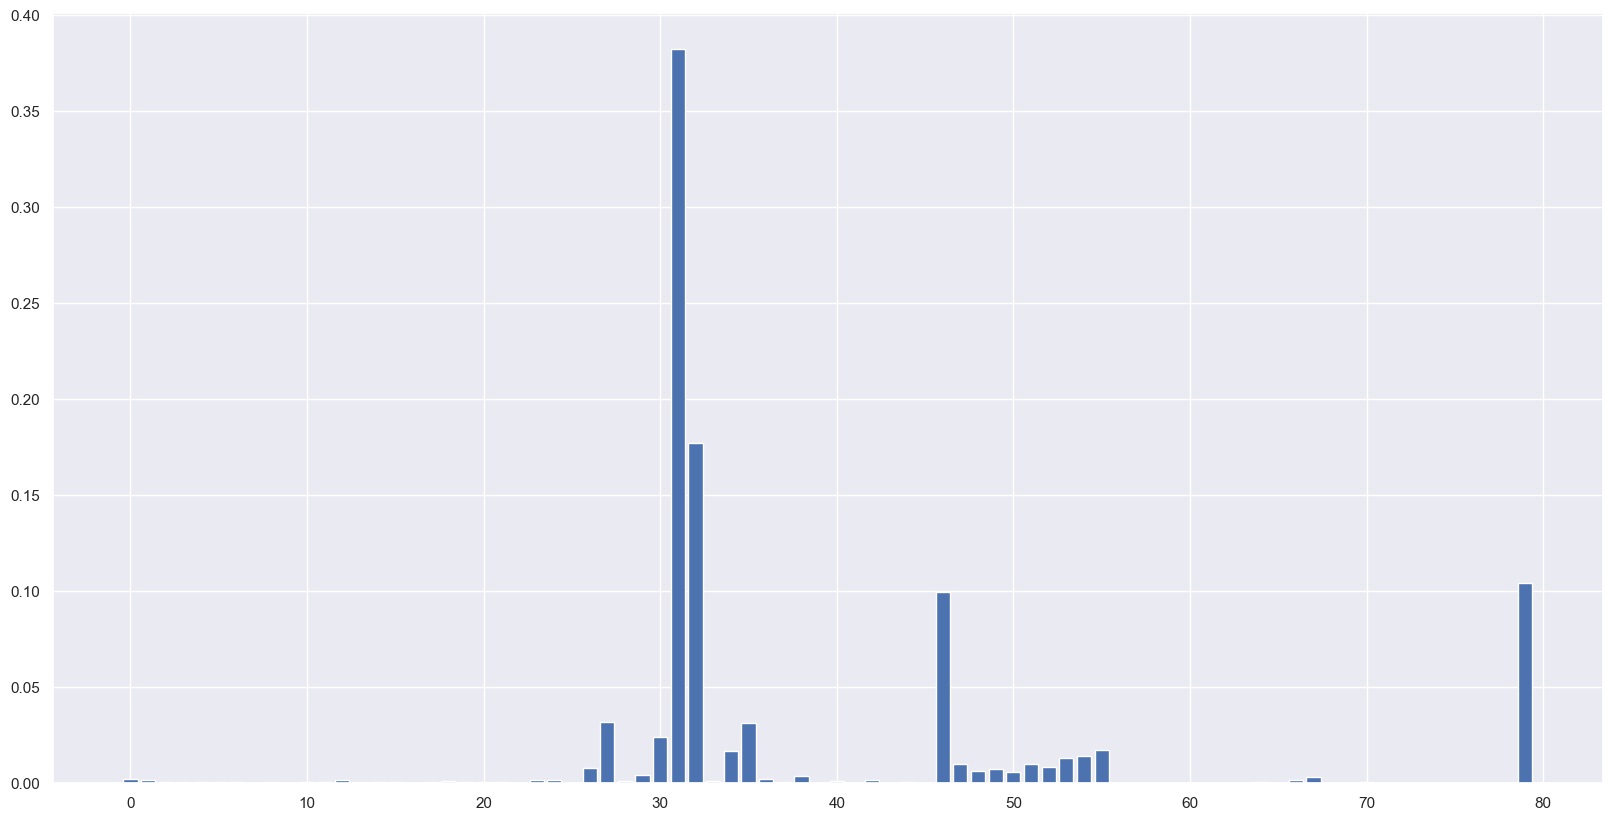

In [585]:
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [586]:
features

Index(['Perceived health very good or excellent 13',
       'Perceived health fair or poor 13',
       'Perceived mental health very good or excellent 14',
       'Perceived mental health fair or poor 14',
       'Perceived life stress most days quite a bit or extremely stressful 15',
       'Body mass index adjusted self-reported adult (18 years and over) overweight 16 17 18 19 20 21',
       'Body mass index adjusted self-reported adult (18 years and over) obese 16 17 18 19 20 21',
       'Body mass index self-reported youth (12 to 17 years old) overweight or obese 16 17 18 19 21',
       'Arthritis (15 years and over) 22', 'Diabetes 23', 'Asthma 24 25',
       'Chronic obstructive pulmonary disease (COPD; 35 years and over) 25 26 27',
       'High blood pressure 27 28', 'Mood disorder 29',
       'Current smoker daily or occasional 30 31 32 33 34',
       'Current smoker daily 30 31 32 33', 'Heavy drinking 37',
       'Self-reported physical activity 150 minutes per week adult (18 y

<AxesSubplot: >

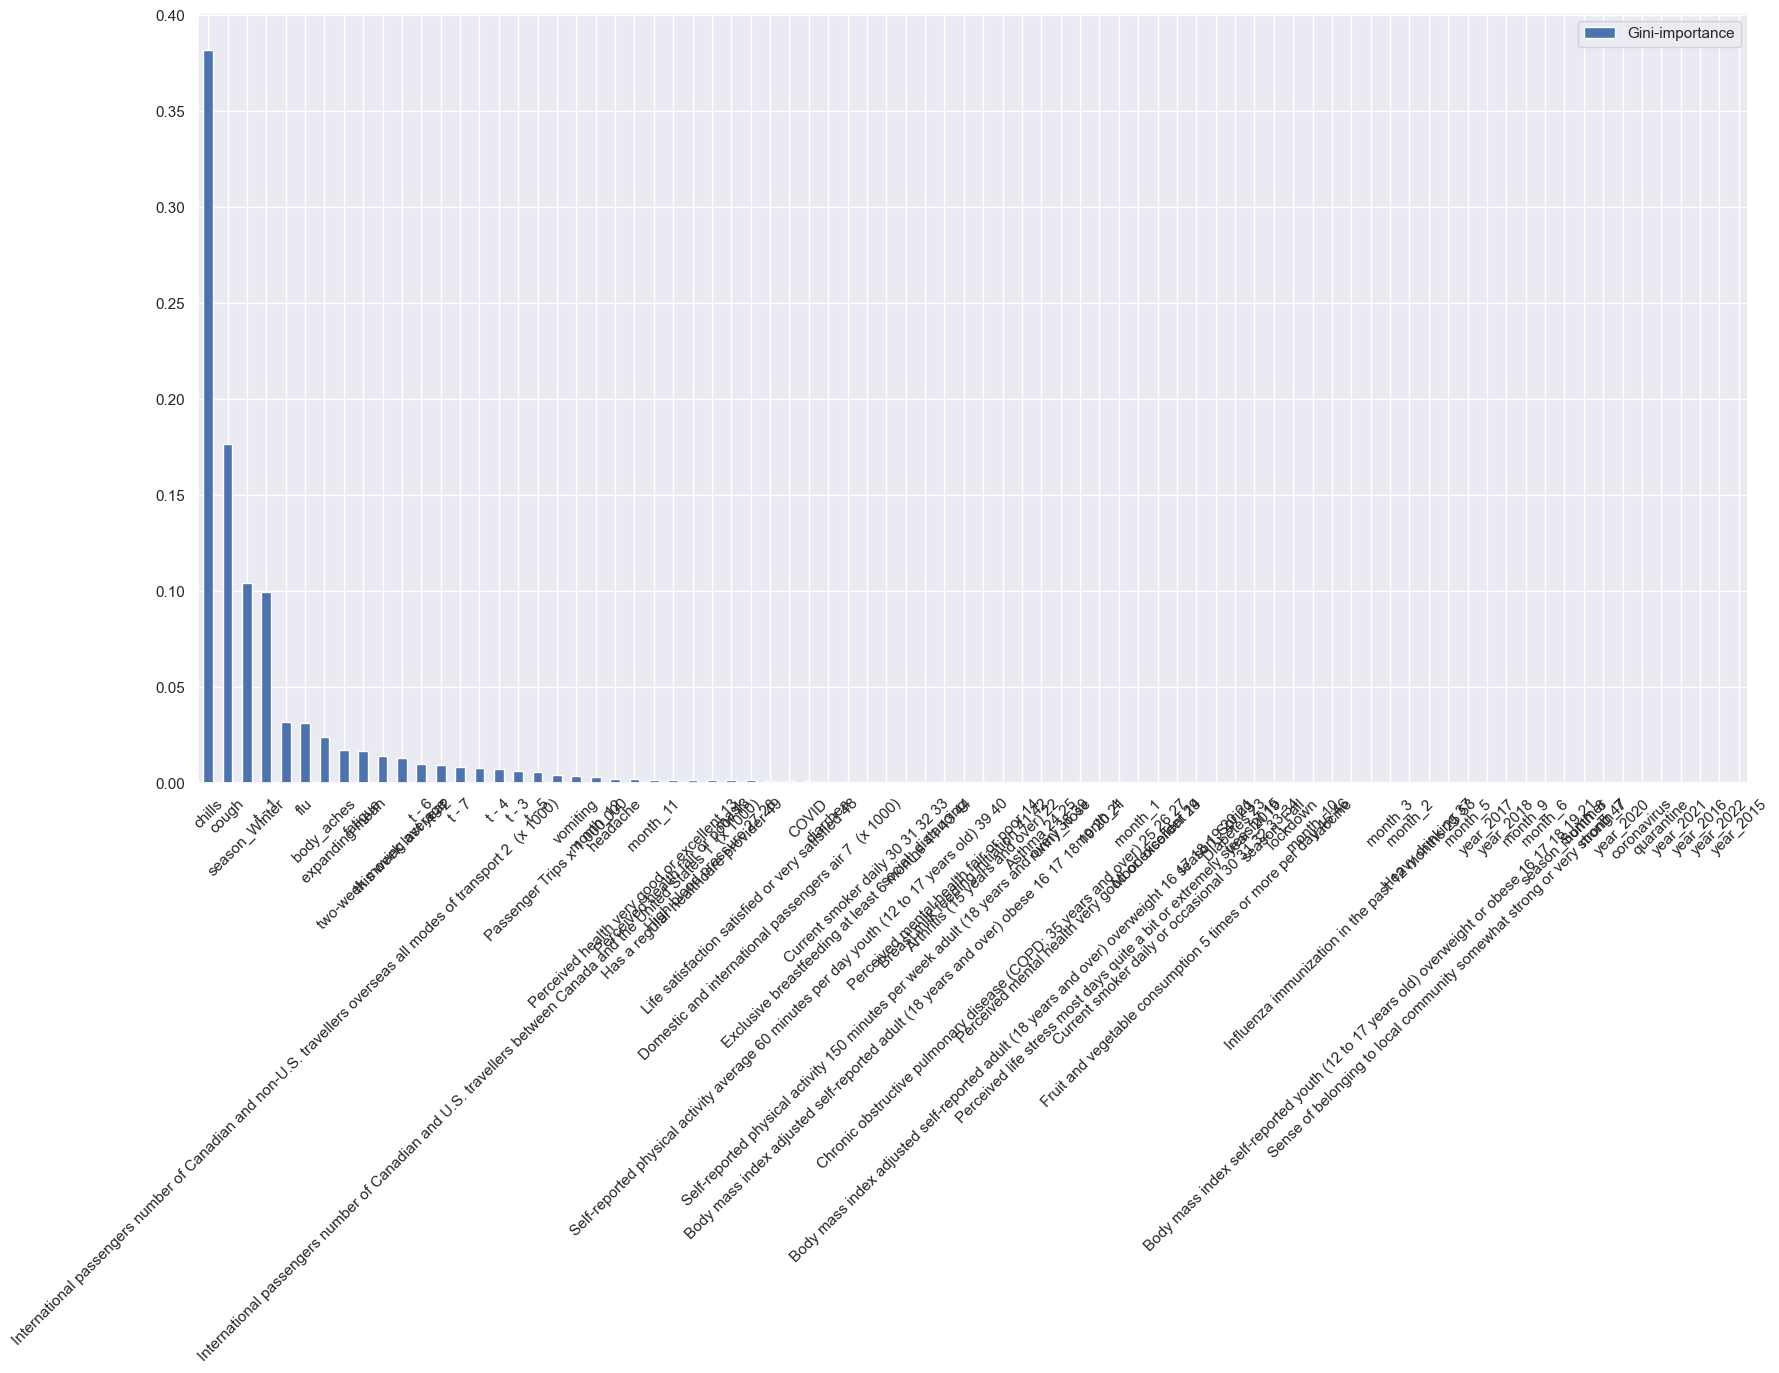

In [587]:
# https://stackoverflow.com/questions/41900387/mapping-column-names-to-random-forest-feature-importances

import pandas as pd
%matplotlib inline
#do code to support model
#"data" is the X dataframe and model is the SKlearn object

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(features, model.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance', ascending=False).plot(kind='bar', rot=45)

In [ ]:
len(features)

57

In [ ]:
feats_to_remove = importances.sort_values('Gini-importance').iloc[0:25,:].index.to_list()

In [ ]:
feats_to_remove

['year_2015',
 'month_3',
 'season_Fall',
 'month_1',
 'Sense of belonging to local community somewhat strong or very strong 47',
 'Influenza immunization in the past 12 months 25 53',
 'High blood pressure 27 28',
 'lockdown',
 'year_2017',
 'runny_nose',
 'Heavy drinking 37',
 'Diabetes 23',
 'month_4',
 'Body mass index adjusted self-reported adult (18 years and over) overweight 16 17 18 19 20 21',
 'year_2019',
 'Body mass index adjusted self-reported adult (18 years and over) obese 16 17 18 19 20 21',
 'Fruit and vegetable consumption 5 times or more per day 45 46',
 'Perceived life stress most days quite a bit or extremely stressful 15',
 'Mood disorder 29',
 'Perceived mental health fair or poor 14',
 'month_10',
 'mask',
 'Self-reported physical activity 150 minutes per week adult (18 years and over) 38 39',
 'Current smoker daily 30 31 32 33',
 'Perceived health fair or poor 13']

In [ ]:
for i in range(1,5):
    results_matrix = evaluate_model(train=train_y, test=test_y, preds_train=preds_train, preds_test=preds_test, dataset='Pre-COVID (all feats w/o fever)', forecast_weeks=i)
results_matrix

Dataset Weeks-ahead Forecast  \
0                       Pre-COVID - (all time feats)                    1   
0                       Pre-COVID - (all time feats)                    2   
0                       Pre-COVID - (all time feats)                    3   
0                       Pre-COVID - (all time feats)                    4   
0             Pre-COVID (time feats, remove M and Y)                    1   
0             Pre-COVID (time feats, remove M and Y)                    2   
0             Pre-COVID (time feats, remove M and Y)                    3   
0             Pre-COVID (time feats, remove M and Y)                    4   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    1   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    2   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    3   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    4   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    1   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    2   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    3   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    4   
0                               Pre-COVID (all feats                    1   
0                               Pre-COVID (all feats                    2   
0                               Pre-COVID (all feats                    3   
0                               Pre-COVID (all feats                    4   
0                               Pre-COVID (all feats                    1   
0                               Pre-COVID (all feats                    2   
0                               Pre-COVID (all feats                    3   
0                               Pre-COVID (all feats                    4   
0                    Pre-COVID (all feats w/o fever)                    1   
0                    Pre-COVID (all feats w/o fever)                    2   
0                    Pre-COVID (all feats w/o fever)                    3   
0                    Pre-COVID (all feats w/o fever)                    4   

  MSE_train   MSE_test RMSE_train RMSE_test MAE_train MAE_test  R2_train  \
0   8645.66   97600.06      92.98    312.41     50.03   193.03  0.995238   
0  13142.62  192354.67     114.64    438.58     64.11   249.64  0.992735   
0  16733.42  287159.05     129.36    535.87     70.98    310.1  0.990716   
0  22529.88  358909.52      150.1    599.09     84.21   365.58  0.987464   
0   9987.75   89840.61      99.94    299.73     52.96    186.3  0.994499   
0  15031.57  172524.55      122.6    415.36     66.82   225.45   0.99169   
0  19320.23  259617.88      139.0    509.53     77.24   280.81  0.989281   
0   26457.7  320536.19     162.66    566.16     90.66   330.62  0.985279   
0   9359.49   68548.97      96.74    261.82     53.67   172.17  0.994845   
0  14962.43  136966.77     122.32    370.09     68.63    217.7  0.991728   
0  17838.93  213031.78     133.56    461.55     74.65   267.06  0.990103   
0  21819.18  291982.47     147.71    540.35     84.42   330.86   0.98786   
0   7591.63   96391.15      87.13    310.47     51.04   206.92  0.995819   
0  10692.14   92682.13      103.4    304.44     60.91   211.15  0.994089   
0  12902.56  108251.91     113.59    329.02     65.83   232.89  0.992841   
0  14230.53  202893.61     119.29    450.44     74.15   301.03  0.992082   
0   7314.27  261944.97      85.52    511.81     50.21   290.86  0.995955   
0  10207.11  206830.95     101.03    454.79     55.08   280.53  0.994333   
0  12055.99  160165.39      109.8    400.21     59.94   269.54  0.993299   
0  11416.23  218313.15     106.85    467.24     63.47   310.24  0.993654   
0    8901.0  263922.93      94.35    513.73     53.33   272.64  0.995077   
0  12401.75  190925.34     111.36    436.95     58.47   259.27  0.993115   
0  12240.78  142291.06     110.64    377.21     59.42   259.92 

In [ ]:
results_matrix.sort_values('RMSE_test')

Dataset Weeks-ahead Forecast  \
0  Pre-COVID (time feats, remove M and Y) + COVID...                    1   
0             Pre-COVID (time feats, remove M and Y)                    1   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    2   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    1   
0                       Pre-COVID - (all time feats)                    1   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    3   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    2   
0                               Pre-COVID (all feats                    3   
0                    Pre-COVID (all feats w/o fever)                    3   
0                    Pre-COVID (all feats w/o fever)                    2   
0                               Pre-COVID (all feats                    3   
0             Pre-COVID (time feats, remove M and Y)                    2   
0                               Pre-COVID (all feats                    2   
0                       Pre-COVID - (all time feats)                    2   
0                    Pre-COVID (all feats w/o fever)                    1   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    4   
0                               Pre-COVID (all feats                    2   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    3   
0                               Pre-COVID (all feats                    4   
0                               Pre-COVID (all feats                    4   
0                    Pre-COVID (all feats w/o fever)                    4   
0             Pre-COVID (time feats, remove M and Y)                    3   
0                               Pre-COVID (all feats                    1   
0                               Pre-COVID (all feats                    1   
0                       Pre-COVID - (all time feats)                    3   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    4   
0             Pre-COVID (time feats, remove M and Y)                    4   
0                       Pre-COVID - (all time feats)                    4   

  MSE_train   MSE_test RMSE_train RMSE_test MAE_train MAE_test  R2_train  \
0   9359.49   68548.97      96.74    261.82     53.67   172.17  0.994845   
0   9987.75   89840.61      99.94    299.73     52.96    186.3  0.994499   
0  10692.14   92682.13      103.4    304.44     60.91   211.15  0.994089   
0   7591.63   96391.15      87.13    310.47     51.04   206.92  0.995819   
0   8645.66   97600.06      92.98    312.41     50.03   193.03  0.995238   
0  12902.56  108251.91     113.59    329.02     65.83   232.89  0.992841   
0  14962.43  136966.77     122.32    370.09     68.63    217.7  0.991728   
0  12240.78  142291.06     110.64    377.21     59.42   259.92  0.993196   
0  10841.56  146351.69     104.12    382.56     56.37   286.93  0.993974   
0    8964.5  158383.01      94.68    397.97     52.14   270.94  0.995023   
0  12055.99  160165.39      109.8    400.21     59.94   269.54  0.993299   
0  15031.57  172524.55      122.6    415.36     66.82   225.45   0.99169   
0  12401.75  190925.34     111.36    436.95     58.47   259.27  0.993115   
0  13142.62  192354.67     114.64    438.58     64.11   249.64  0.992735   
0    7782.0  199712.12      88.22    446.89     49.65   276.71  0.995696   
0  14230.53  202893.61     119.29    450.44     74.15   301.03  0.992082   
0  10207.11  206830.95     101.03    454.79     55.08   280.53  0.994333   
0  17838.93  213031.78     133.56    461.55     74.65   267.06  0.990103   
0  12717.98  214312.93     112.77    462.94     65.77   326.96   0.99293   
0  11416.23  218313.15     106.85    467.24     63.47   310.24  0.993654   
0  13100.82  229050.88     114.46    478.59     62.73   337.37  0.992717   
0  19320.23  259617.88      139.0    509.53     77.24   280.81  0.989281   
0   7314.27  261944.97      85.52    511.81     50.21   290.86 

In [ ]:
results_matrix.sort_values('RMSE_test')['Dataset']

0    Pre-COVID (time feats, remove M and Y) + COVID...
0               Pre-COVID (time feats, remove M and Y)
0    Pre-COVID (time feats, remove M and Y) + COVID...
0    Pre-COVID (time feats, remove M and Y) + COVID...
0                         Pre-COVID - (all time feats)
0    Pre-COVID (time feats, remove M and Y) + COVID...
0    Pre-COVID (time feats, remove M and Y) + COVID...
0               Pre-COVID (time feats, remove M and Y)
0                         Pre-COVID - (all time feats)
0    Pre-COVID (time feats, remove M and Y) + COVID...
0    Pre-COVID (time feats, remove M and Y) + COVID...
0               Pre-COVID (time feats, remove M and Y)
0                         Pre-COVID - (all time feats)
0    Pre-COVID (time feats, remove M and Y) + COVID...
0               Pre-COVID (time feats, remove M and Y)
0                         Pre-COVID - (all time feats)
Name: Dataset, dtype: object

# Random Forest Regression - Time Features (without Year, Month) + COVID search terms

In [600]:
df_time_features_pre_COVID = pickle.load(open(r"..\data\flu_cases\df_time_features_pre_COVID.pkl", "rb" ))
df_time_features = pickle.load(open(r"..\data\flu_cases\df_time_features.pkl", "rb" ))

df_COVID_terms_pre_COVID = pickle.load(open(r"..\data\google_trend\df_COVID_terms_pre_COVID.pkl", "rb" ))
df_COVID_terms = pickle.load(open(r"..\data\google_trend\df_COVID_terms.pkl", "rb" ))

df_flu_symptoms_pre_COVID = pickle.load(open(r"..\data\google_trend\df_flu_symptoms_pre_COVID.pkl", "rb" ))

In [601]:
df_time_features_pre_COVID.shape

(235, 38)

In [602]:
df_time_features_pre_COVID.columns

Index(['y1', 'y2', 'y3', 'y4', 't - 1', 't - 2', 't - 3', 't - 4', 't - 5',
       't - 6', 't - 7', 'this week last year', 'two-week moving average',
       'expanding mean', 'year_2015', 'year_2016', 'year_2017', 'year_2018',
       'year_2019', 'year_2020', 'year_2021', 'year_2022', 'month_1',
       'month_10', 'month_11', 'month_12', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'season_Fall',
       'season_Spring', 'season_Summer', 'season_Winter'],
      dtype='object')

In [603]:
df = pd.concat([df_time_features_pre_COVID, df_flu_symptoms_pre_COVID], axis=1)
df

y1      y2      y3      y4   t - 1   t - 2   t - 3   t - 4   t - 5  \
0       9.0    18.0    15.0    29.0     NaN     NaN     NaN     NaN     NaN   
1      18.0    15.0    29.0    59.0     9.0     NaN     NaN     NaN     NaN   
2      15.0    29.0    59.0    50.0    18.0     9.0     NaN     NaN     NaN   
3      29.0    59.0    50.0    37.0    15.0    18.0     9.0     NaN     NaN   
4      59.0    50.0    37.0    26.0    29.0    15.0    18.0     9.0     NaN   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
230  4789.0  4654.0  3989.0  3656.0  4182.0  3549.0  3811.0  3845.0  3126.0   
231  4654.0  3989.0  3656.0  3576.0  4789.0  4182.0  3549.0  3811.0  3845.0   
232  3989.0  3656.0  3576.0  3404.0  4654.0  4789.0  4182.0  3549.0  3811.0   
233  3656.0  3576.0  3404.0  2991.0  3989.0  4654.0  4789.0  4182.0  3549.0   
234  3576.0  3404.0  2991.0  1619.0  3656.0  3989.0  4654.0  4789.0  4182.0   

      t - 6  ...  chills  cough  diarrhea  fatigue  fever  flu  headache  \
0       NaN  ...      31     27        64       74     29    7        57   
1       NaN  ...      31     27        64       74     29    7        57   
2       NaN  ...      31     27        64       74     29    7        57   
3       NaN  ...      31     27        64       74     29    7        57   
4       NaN  ...      39     37        59       78     29   20        57   
..      ...  ...     ...    ...       ...      ...    ...  ...       ...   
230  2206.0  ...      71     46        82       91     58   34        74   
231  3126.0  ...      71     46        82       91     58   34        74   
232  3845.0  ...      71     46        82       91     58   34        74   
233  3811.0  ...      71     46        82       91     58   34        74   
234  3549.0  ...      71     46        82       91     58   34        74   

     runny_nose  sore_thoat  vomiting  
0            26          34        59  
1            26          34        59  
2            26          34        59  
3            26          34        59  
4            23          31        57  
..          ...         ...       ...  
230          33          45        84  
231          33          45        84  
232          33          45        84  
233          33          45        84  
234          33          45        84  

[235 rows x 53 columns]

In [604]:
df.dropna(inplace=True)
df = df.reset_index(drop=True)
df = df.drop(columns=['year_2015', 'month_1','year_2016', 'year_2017', 'year_2018', 'year_2019',
       'year_2020', 'year_2021', 'year_2022', 'month_10', 'month_11',
       'month_12', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9','Total Cases','month', 'year', 'week'])

In [605]:
df

y1      y2      y3      y4   t - 1   t - 2   t - 3   t - 4   t - 5  \
0       2.0    18.0    23.0    44.0    13.0    13.0     8.0     9.0     7.0   
1      18.0    23.0    44.0    63.0     2.0    13.0    13.0     8.0     9.0   
2      23.0    44.0    63.0    56.0    18.0     2.0    13.0    13.0     8.0   
3      44.0    63.0    56.0    42.0    23.0    18.0     2.0    13.0    13.0   
4      63.0    56.0    42.0    71.0    44.0    23.0    18.0     2.0    13.0   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
178  4789.0  4654.0  3989.0  3656.0  4182.0  3549.0  3811.0  3845.0  3126.0   
179  4654.0  3989.0  3656.0  3576.0  4789.0  4182.0  3549.0  3811.0  3845.0   
180  3989.0  3656.0  3576.0  3404.0  4654.0  4789.0  4182.0  3549.0  3811.0   
181  3656.0  3576.0  3404.0  2991.0  3989.0  4654.0  4789.0  4182.0  3549.0   
182  3576.0  3404.0  2991.0  1619.0  3656.0  3989.0  4654.0  4789.0  4182.0   

      t - 6  ...  chills  cough  diarrhea  fatigue  fever  flu  headache  \
0      18.0  ...      42     29        67       80     29    8        61   
1       7.0  ...      42     29        67       80     29    8        61   
2       9.0  ...      42     29        67       80     29    8        61   
3       8.0  ...      42     29        67       80     29    8        61   
4      13.0  ...      35     37        65       77     32   21        63   
..      ...  ...     ...    ...       ...      ...    ...  ...       ...   
178  2206.0  ...      71     46        82       91     58   34        74   
179  3126.0  ...      71     46        82       91     58   34        74   
180  3845.0  ...      71     46        82       91     58   34        74   
181  3811.0  ...      71     46        82       91     58   34        74   
182  3549.0  ...      71     46        82       91     58   34        74   

     runny_nose  sore_thoat  vomiting  
0            27          34        57  
1            27          34        57  
2            27          34        57  
3            27          34        57  
4            23          34        63  
..          ...         ...       ...  
178          33          45        84  
179          33          45        84  
180          33          45        84  
181          33          45        84  
182          33          45        84  

[183 rows x 29 columns]

In [606]:
df.columns

Index(['y1', 'y2', 'y3', 'y4', 't - 1', 't - 2', 't - 3', 't - 4', 't - 5',
       't - 6', 't - 7', 'this week last year', 'two-week moving average',
       'expanding mean', 'season_Fall', 'season_Spring', 'season_Summer',
       'season_Winter', 'body_aches', 'chills', 'cough', 'diarrhea', 'fatigue',
       'fever', 'flu', 'headache', 'runny_nose', 'sore_thoat', 'vomiting'],
      dtype='object')

In [607]:
train_size = int(len(df) *.7)
test_size = len(df) - train_size
train, test = df[0:train_size], df[train_size:len(df)]

In [608]:
train_y = train[['y1','y2','y3','y4']]
train_X = train.drop(columns=['y1','y2','y3','y4'])
test_y = test[['y1','y2','y3','y4']]
test_X = test.drop(columns=['y1','y2','y3','y4'])

In [609]:
features = train_X.columns

In [610]:
col_to_scale = ['t - 1', 't - 2', 't - 3', 't - 4', 't - 5',
       't - 6', 't - 7', 'this week last year', 'two-week moving average',
       'expanding mean', 'body_aches',
       'chills', 'cough', 'diarrhea', 'fatigue', 'fever', 'flu', 'headache',
       'runny_nose', 'sore_thoat', 'vomiting']
col_not_to_scale = ['season_Fall', 'season_Spring', 'season_Summer',
       'season_Winter']

In [611]:
train_X_to_scale = train_X.loc[:,col_to_scale]
test_X_to_scale = test_X.loc[:,col_to_scale]
train_X_not_to_scale = train_X.loc[:,col_not_to_scale].to_numpy()
test_X_not_to_scale = test_X.loc[:,col_not_to_scale].to_numpy()

In [612]:
from sklearn.preprocessing import MinMaxScaler

# scale data
scaler = MinMaxScaler()
train_X_to_scale = scaler.fit_transform(train_X_to_scale)
test_X_to_scale = scaler.transform(test_X_to_scale)

In [613]:
train_X = np.concatenate((train_X_to_scale, train_X_not_to_scale),axis=1)
test_X = np.concatenate((test_X_to_scale, test_X_not_to_scale),axis=1)

In [614]:
model = RandomForestRegressor()

model.fit(train_X, train_y)

RandomForestRegressor()

In [615]:
preds_test = model.predict(test_X)
preds_test_df = pd.DataFrame(preds_test,columns=test_y.columns)
preds_train = model.predict(train_X)
preds_train_df = pd.DataFrame(preds_train,columns=train_y.columns)

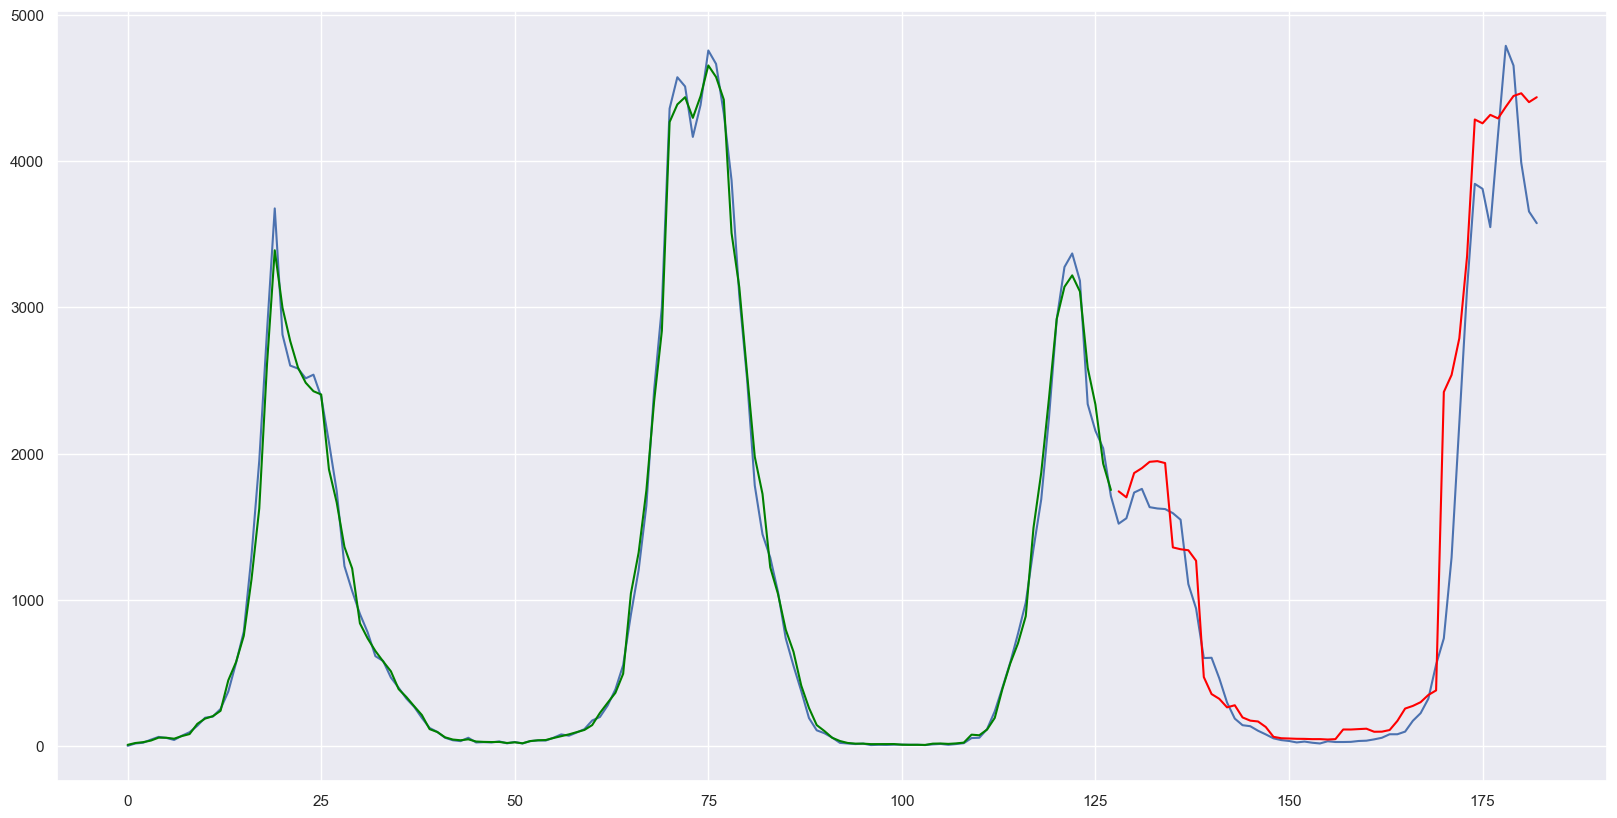

In [616]:
# plot
plt.plot(df.index, df['y1'].values)
plt.plot(df.index[:train_size], preds_train_df['y1'], color='green')
plt.plot(df.index[train_size:], preds_test_df['y1'], color='red')

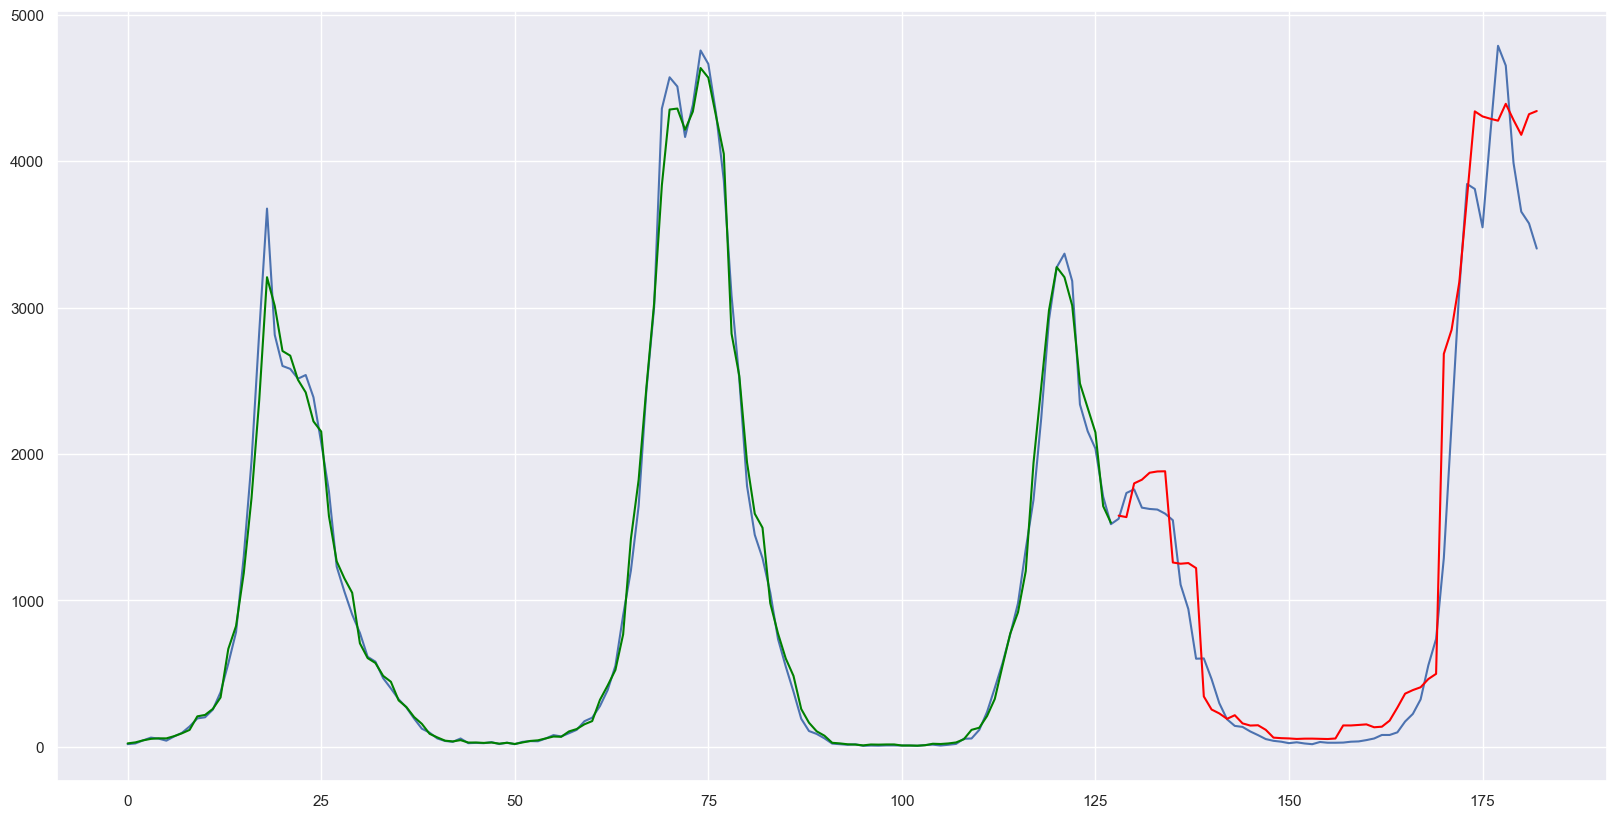

In [617]:
# plot 2-week ahead prediction
plt.plot(df.index, df['y2'].values)
plt.plot(df.index[:train_size], preds_train_df['y2'], color='green')
plt.plot(df.index[train_size:], preds_test_df['y2'], color='red')

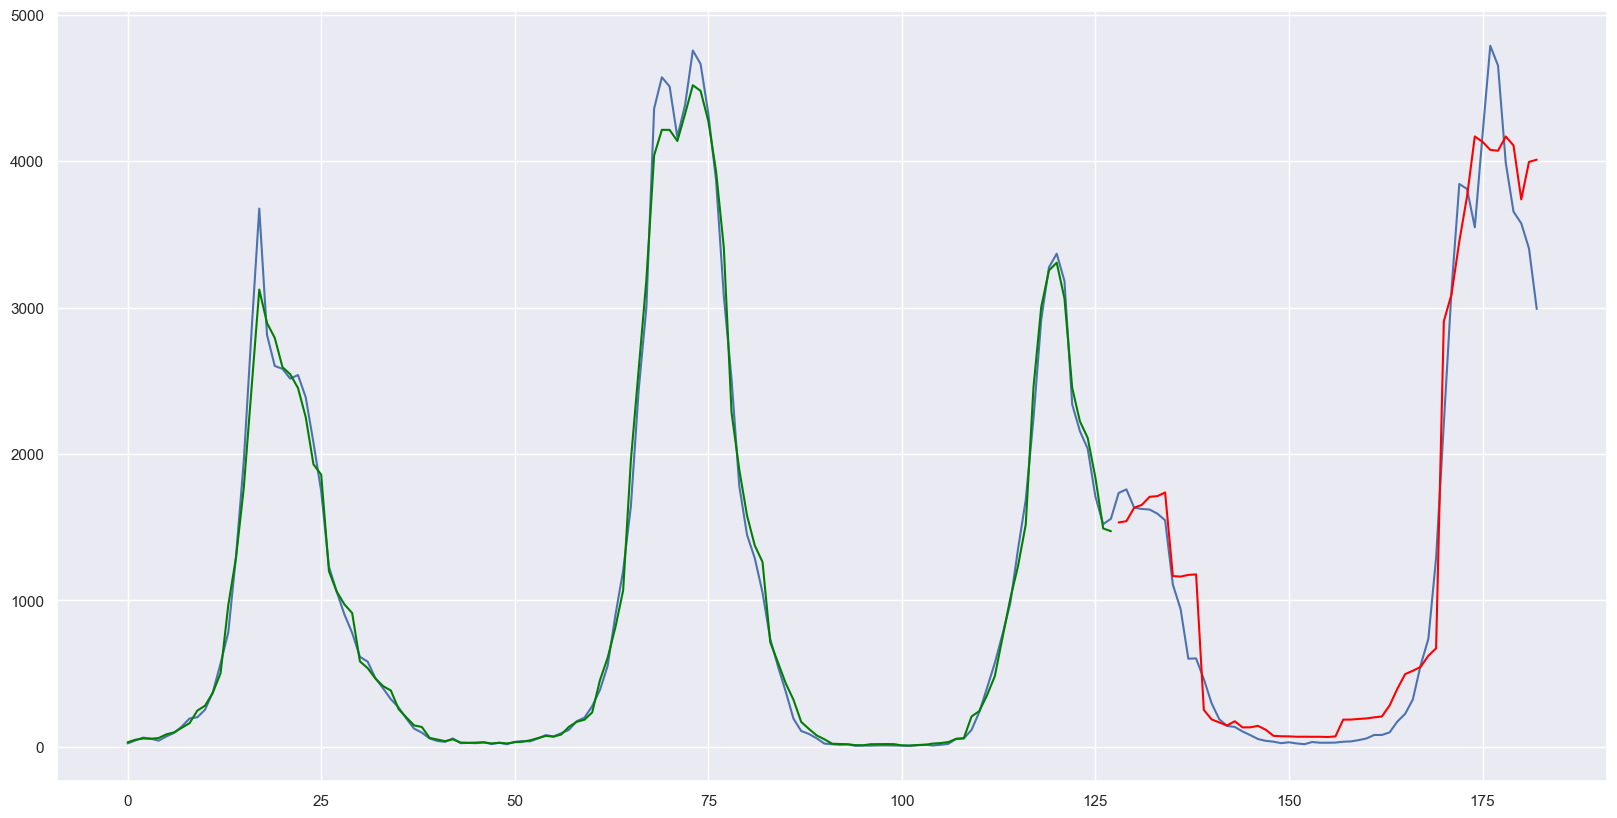

In [618]:
# plot 3-week ahead prediction
plt.plot(df.index, df['y3'].values)
plt.plot(df.index[:train_size], preds_train_df['y3'], color='green')
plt.plot(df.index[train_size:], preds_test_df['y3'], color='red')

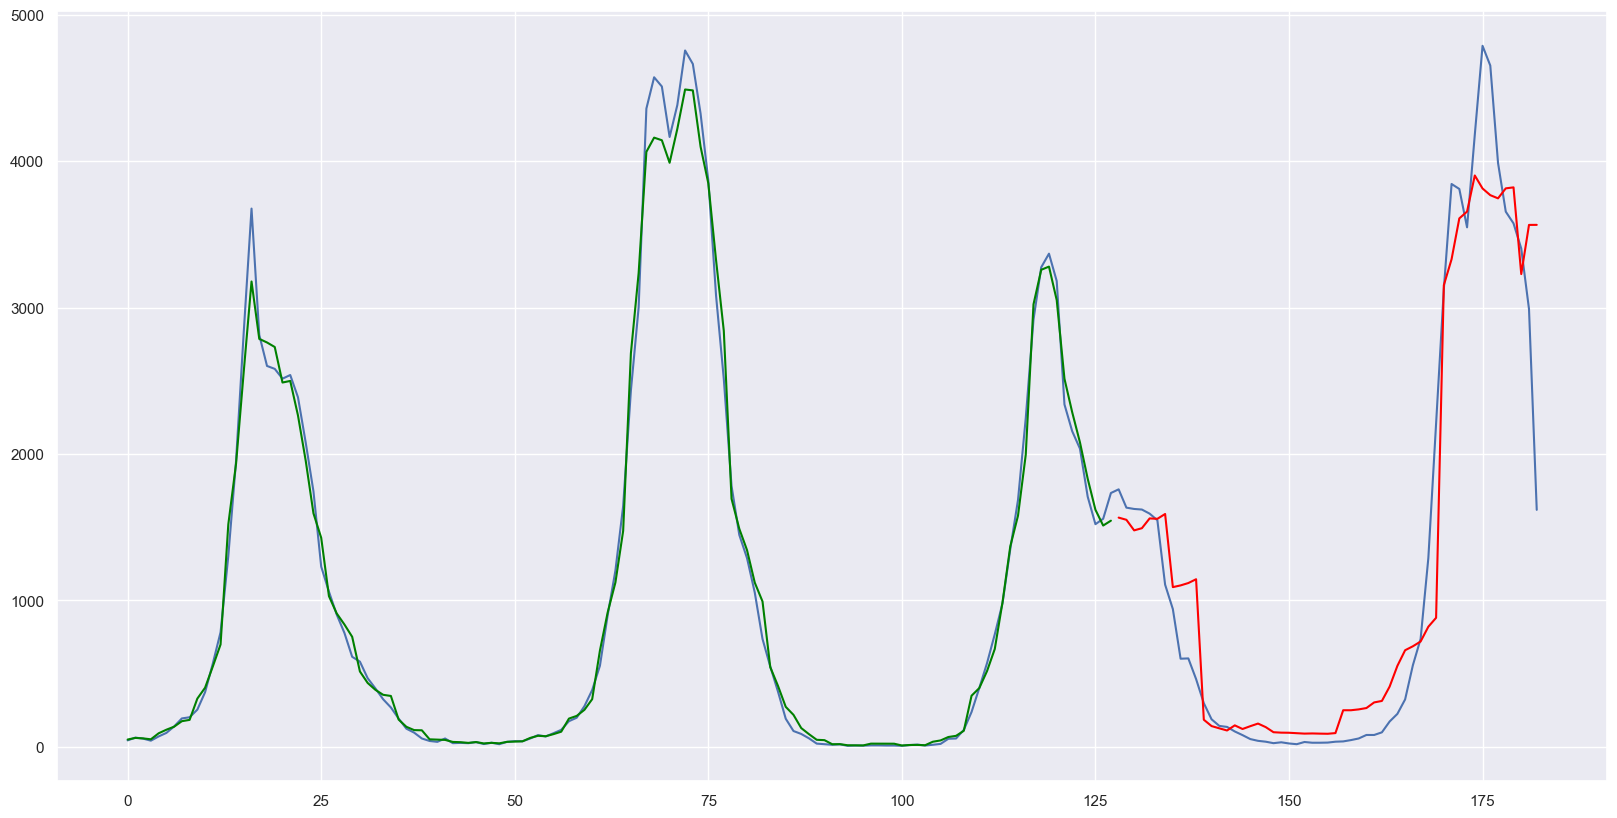

In [619]:
# plot 4-week ahead prediction
plt.plot(df.index, df['y4'].values)
plt.plot(df.index[:train_size], preds_train_df['y4'], color='green')
plt.plot(df.index[train_size:], preds_test_df['y4'], color='red')

In [620]:
# define the evaluation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=2022)
# evaluate the model and collect the scores
n_scores = cross_val_score(model, train_X, train_y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
# force the scores to be positive
n_scores = absolute(n_scores)
# summarize performance
print('RMSE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

RMSE: 290.672 (94.355)


In [621]:
# evaluate all four weeks of predictions

MSE_train = round(mean_squared_error(train_y, preds_train),3)
RMSE_train = round(mean_squared_error(train_y, preds_train, squared=False),3)
MAE_train = round(mean_absolute_error(train_y, preds_train),3)
print(f'MSE_train: {MSE_train}')
print(f'RMSE_train: {RMSE_train}')
print(f'MAE_train: {MAE_train}')

MSE_test = round(mean_squared_error(test_y, preds_test),3)
RMSE_test = round(mean_squared_error(test_y, preds_test, squared=False),3)
MAE_test = round(mean_absolute_error(test_y, preds_test),3)
print(f'MSE_test: {MSE_test}')
print(f'RMSE_test: {RMSE_test}')
print(f'MAE_test: {MAE_test}')


MSE_train: 12506.922
RMSE_train: 111.369
MAE_train: 65.665
MSE_test: 138967.339
RMSE_test: 369.737
MAE_test: 230.876


In [622]:
# evaluate 1-week ahead prediction only

MSE_train = round(mean_squared_error(train_y['y1'], preds_train_df['y1']),3)
RMSE_train = round(mean_squared_error(train_y['y1'], preds_train_df['y1'], squared=False),3)
MAE_train = round(mean_absolute_error(train_y['y1'], preds_train_df['y1']),3)
print(f'MSE_train: {MSE_train}')
print(f'RMSE_train: {RMSE_train}')
print(f'MAE_train: {MAE_train}')

MSE_test = round(mean_squared_error(test_y['y1'], preds_test_df['y1']),3)
RMSE_test = round(mean_squared_error(test_y['y1'], preds_test_df['y1'], squared=False),3)
MAE_test = round(mean_absolute_error(test_y['y1'], preds_test_df['y1']),3)
print(f'MSE_test: {MSE_test}')
print(f'RMSE_test: {RMSE_test}')
print(f'MAE_test: {MAE_test}')


MSE_train: 8878.615
RMSE_train: 94.226
MAE_train: 56.394
MSE_test: 153159.609
RMSE_test: 391.356
MAE_test: 234.476


In [623]:
# evaluate 2-week ahead prediction only

MSE_train = round(mean_squared_error(train_y['y2'], preds_train_df['y2']),3)
RMSE_train = round(mean_squared_error(train_y['y2'], preds_train_df['y2'], squared=False),3)
MAE_train = round(mean_absolute_error(train_y['y2'], preds_train_df['y2']),3)
print(f'MSE_train: {MSE_train}')
print(f'RMSE_train: {RMSE_train}')
print(f'MAE_train: {MAE_train}')

MSE_test = round(mean_squared_error(test_y['y2'], preds_test_df['y2']),3)
RMSE_test = round(mean_squared_error(test_y['y2'], preds_test_df['y2'], squared=False),3)
MAE_test = round(mean_absolute_error(test_y['y2'], preds_test_df['y2']),3)
print(f'MSE_test: {MSE_test}')
print(f'RMSE_test: {RMSE_test}')
print(f'MAE_test: {MAE_test}')


MSE_train: 12999.567
RMSE_train: 114.016
MAE_train: 64.584
MSE_test: 120029.564
RMSE_test: 346.453
MAE_test: 220.072


In [624]:
# evaluate 3-week ahead prediction only

MSE_train = round(mean_squared_error(train_y['y3'], preds_train_df['y3']),3)
RMSE_train = round(mean_squared_error(train_y['y3'], preds_train_df['y3'], squared=False),3)
MAE_train = round(mean_absolute_error(train_y['y3'], preds_train_df['y3']),3)
print(f'MSE_train: {MSE_train}')
print(f'RMSE_train: {RMSE_train}')
print(f'MAE_train: {MAE_train}')

MSE_test = round(mean_squared_error(test_y['y3'], preds_test_df['y3']),3)
RMSE_test = round(mean_squared_error(test_y['y3'], preds_test_df['y3'], squared=False),3)
MAE_test = round(mean_absolute_error(test_y['y3'], preds_test_df['y3']),3)
print(f'MSE_test: {MSE_test}')
print(f'RMSE_test: {RMSE_test}')
print(f'MAE_test: {MAE_test}')


MSE_train: 13566.779
RMSE_train: 116.477
MAE_train: 68.107
MSE_test: 94362.83
RMSE_test: 307.185
MAE_test: 205.057


In [625]:
# evaluate 4-week ahead prediction only

MSE_train = round(mean_squared_error(train_y['y4'], preds_train_df['y4']),4)
RMSE_train = round(mean_squared_error(train_y['y4'], preds_train_df['y4'], squared=False),4)
MAE_train = round(mean_absolute_error(train_y['y4'], preds_train_df['y4']),4)
print(f'MSE_train: {MSE_train}')
print(f'RMSE_train: {RMSE_train}')
print(f'MAE_train: {MAE_train}')

MSE_test = round(mean_squared_error(test_y['y4'], preds_test_df['y4']),4)
RMSE_test = round(mean_squared_error(test_y['y4'], preds_test_df['y4'], squared=False),4)
MAE_test = round(mean_absolute_error(test_y['y4'], preds_test_df['y4']),4)
print(f'MSE_test: {MSE_test}')
print(f'RMSE_test: {RMSE_test}')
print(f'MAE_test: {MAE_test}')

MSE_train: 14582.7272
RMSE_train: 120.759
MAE_train: 73.5737
MSE_test: 188317.3524
RMSE_test: 433.9555
MAE_test: 263.9004


In [626]:
model.feature_importances_

array([6.05929034e-02, 1.18783429e-02, 7.52672005e-03, 6.84857445e-03,
       8.94758348e-03, 1.15426664e-02, 1.46668615e-02, 5.69372346e-03,
       2.28701013e-02, 7.26586287e-03, 8.16357871e-03, 4.06000792e-02,
       2.46630840e-02, 1.16421593e-03, 6.99458034e-03, 5.40550282e-01,
       5.08949015e-02, 4.38943694e-03, 9.63002240e-03, 1.83925790e-02,
       1.26758022e-02, 4.07607717e-04, 1.06965579e-03, 1.85951061e-07,
       1.22570649e-01])

Feature: 0, Score: 0.06059
Feature: 1, Score: 0.01188
Feature: 2, Score: 0.00753
Feature: 3, Score: 0.00685
Feature: 4, Score: 0.00895
Feature: 5, Score: 0.01154
Feature: 6, Score: 0.01467
Feature: 7, Score: 0.00569
Feature: 8, Score: 0.02287
Feature: 9, Score: 0.00727
Feature: 10, Score: 0.00816
Feature: 11, Score: 0.04060
Feature: 12, Score: 0.02466
Feature: 13, Score: 0.00116
Feature: 14, Score: 0.00699
Feature: 15, Score: 0.54055
Feature: 16, Score: 0.05089
Feature: 17, Score: 0.00439
Feature: 18, Score: 0.00963
Feature: 19, Score: 0.01839
Feature: 20, Score: 0.01268
Feature: 21, Score: 0.00041
Feature: 22, Score: 0.00107
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.12257


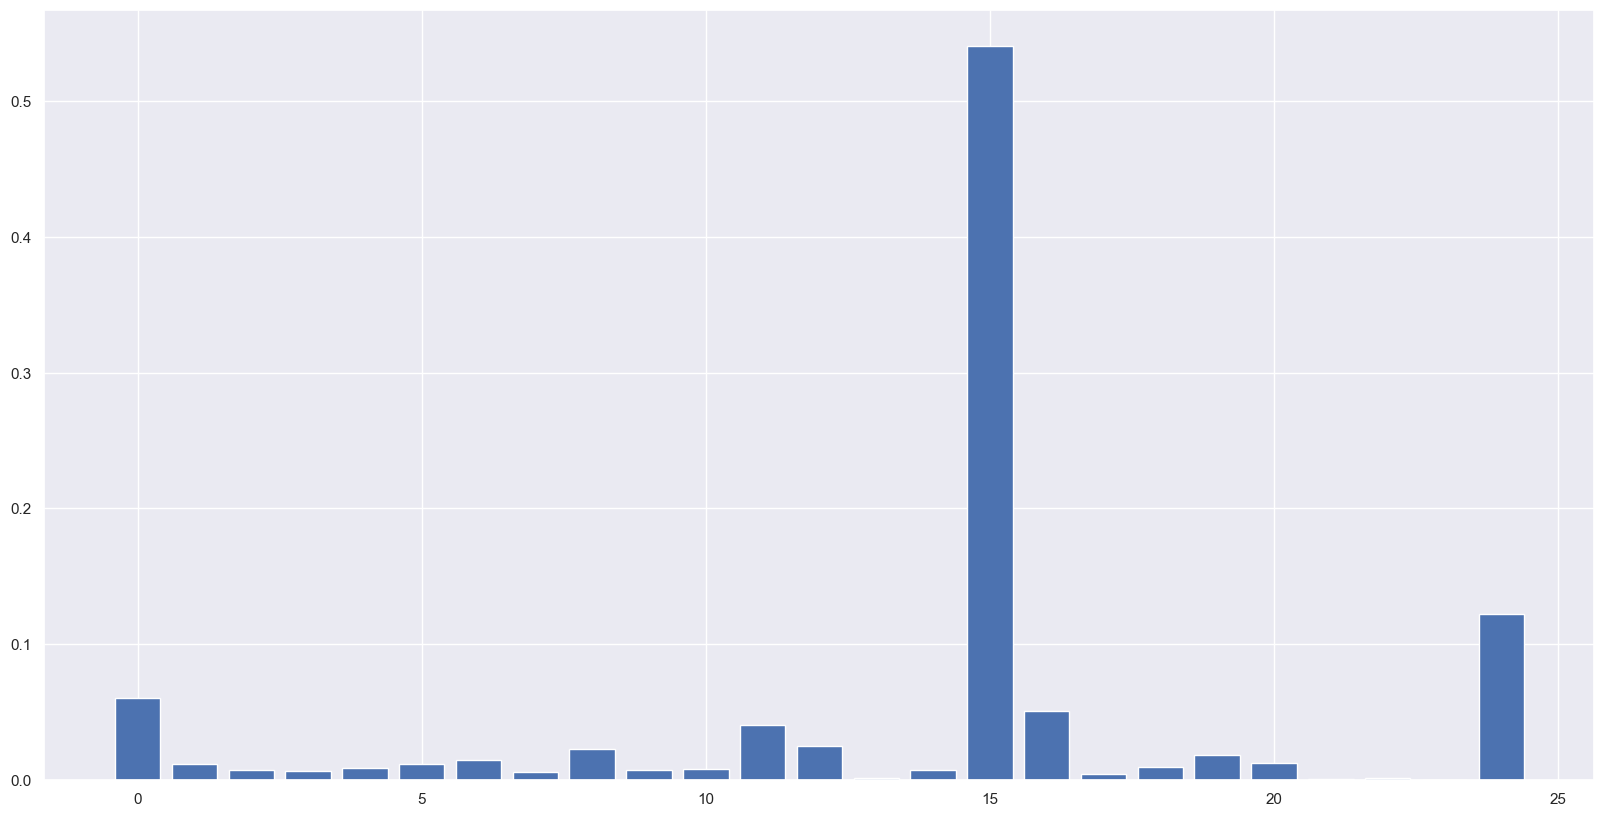

In [627]:
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [628]:
features

Index(['t - 1', 't - 2', 't - 3', 't - 4', 't - 5', 't - 6', 't - 7',
       'this week last year', 'two-week moving average', 'expanding mean',
       'season_Fall', 'season_Spring', 'season_Summer', 'season_Winter',
       'body_aches', 'chills', 'cough', 'diarrhea', 'fatigue', 'fever', 'flu',
       'headache', 'runny_nose', 'sore_thoat', 'vomiting'],
      dtype='object')

<AxesSubplot: >

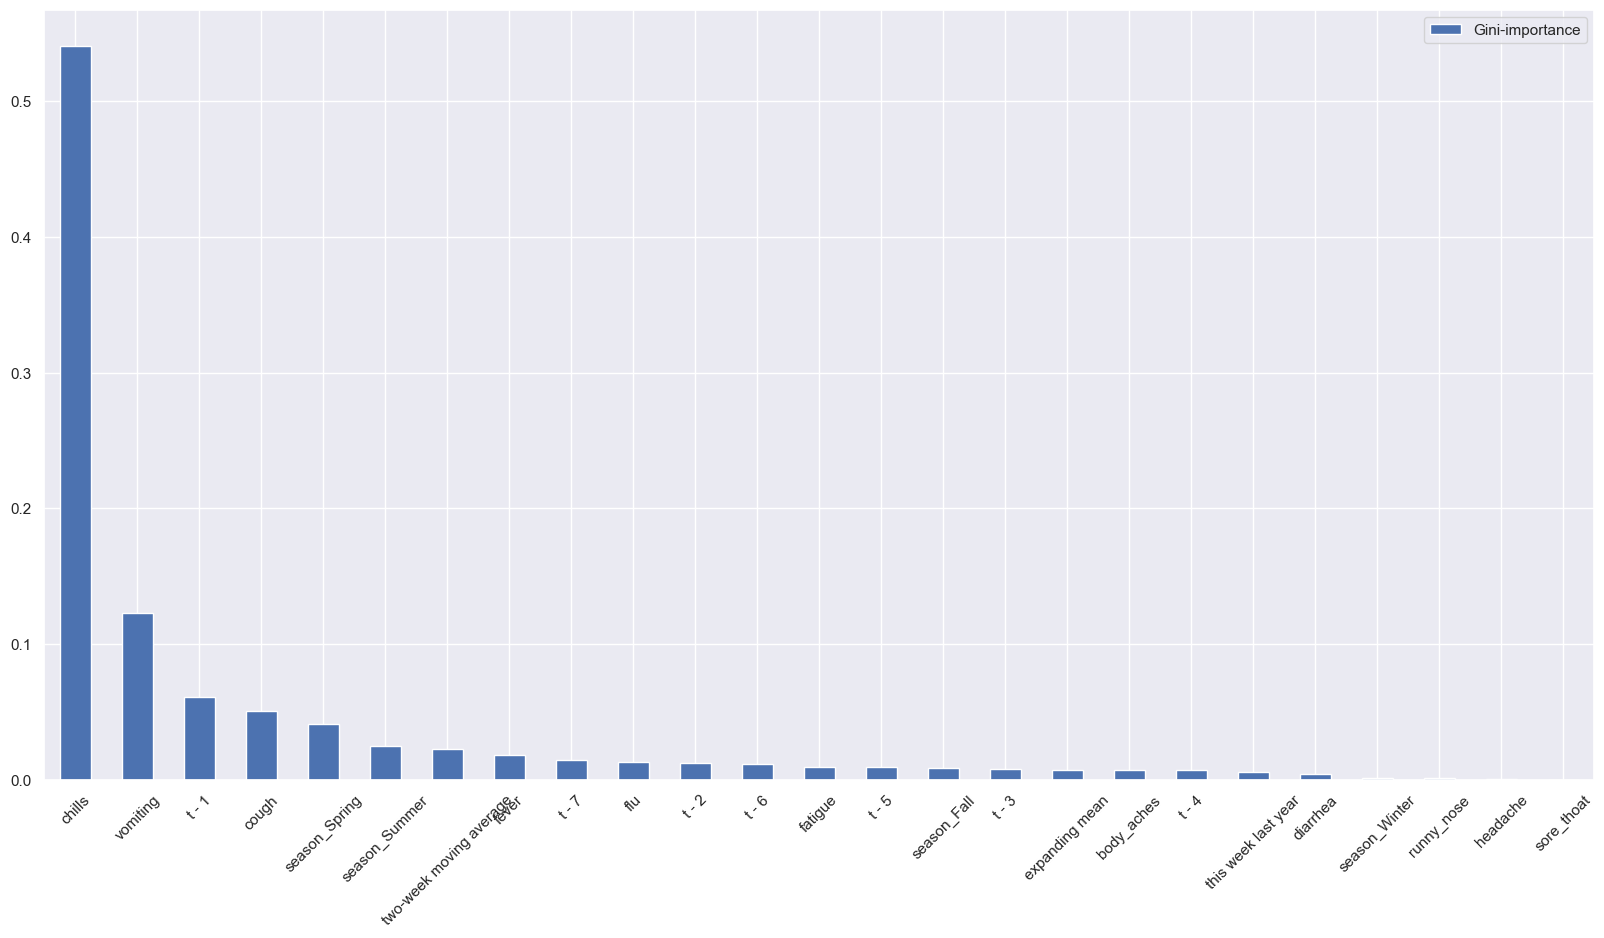

In [629]:
# https://stackoverflow.com/questions/41900387/mapping-column-names-to-random-forest-feature-importances

import pandas as pd
%matplotlib inline
#do code to support model
#"data" is the X dataframe and model is the SKlearn object

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(features, model.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance', ascending=False).plot(kind='bar', rot=45)

In [ ]:
feats_to_remove = importances.sort_values('Gini-importance').iloc[0:10,:].index.to_list()

In [ ]:
feats_to_remove

['COVID',
 'season_Spring',
 'social_distancing',
 'season_Winter',
 'mask',
 'quarantine',
 'lockdown',
 'coronavirus',
 'season_Summer',
 't - 5']

In [631]:
for i in range(1,5):
    results_matrix = evaluate_model(train=train_y, test=test_y, preds_train=preds_train, preds_test=preds_test, dataset='Pre-COVID (time feats, w/o M and Y) + flu terms', forecast_weeks=i)
results_matrix

Dataset Weeks-ahead Forecast  \
0                       Pre-COVID - (all time feats)                    1   
0                       Pre-COVID - (all time feats)                    2   
0                       Pre-COVID - (all time feats)                    3   
0                       Pre-COVID - (all time feats)                    4   
0             Pre-COVID (time feats, remove M and Y)                    1   
0             Pre-COVID (time feats, remove M and Y)                    2   
0             Pre-COVID (time feats, remove M and Y)                    3   
0             Pre-COVID (time feats, remove M and Y)                    4   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    1   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    2   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    3   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    4   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    1   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    2   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    3   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    4   
0                               Pre-COVID (all feats                    1   
0                               Pre-COVID (all feats                    2   
0                               Pre-COVID (all feats                    3   
0                               Pre-COVID (all feats                    4   
0                               Pre-COVID (all feats                    1   
0                               Pre-COVID (all feats                    2   
0                               Pre-COVID (all feats                    3   
0                               Pre-COVID (all feats                    4   
0                    Pre-COVID (all feats w/o fever)                    1   
0                    Pre-COVID (all feats w/o fever)                    2   
0                    Pre-COVID (all feats w/o fever)                    3   
0                    Pre-COVID (all feats w/o fever)                    4   
0    Pre-COVID (time feats, w/o M and Y) + flu terms                    1   
0    Pre-COVID (time feats, w/o M and Y) + flu terms                    2   
0    Pre-COVID (time feats, w/o M and Y) + flu terms                    3   
0    Pre-COVID (time feats, w/o M and Y) + flu terms                    4   

  MSE_train   MSE_test RMSE_train RMSE_test MAE_train MAE_test  R2_train  \
0   8645.66   97600.06      92.98    312.41     50.03   193.03  0.995238   
0  13142.62  192354.67     114.64    438.58     64.11   249.64  0.992735   
0  16733.42  287159.05     129.36    535.87     70.98    310.1  0.990716   
0  22529.88  358909.52      150.1    599.09     84.21   365.58  0.987464   
0   9987.75   89840.61      99.94    299.73     52.96    186.3  0.994499   
0  15031.57  172524.55      122.6    415.36     66.82   225.45   0.99169   
0  19320.23  259617.88      139.0    509.53     77.24   280.81  0.989281   
0   26457.7  320536.19     162.66    566.16     90.66   330.62  0.985279   
0   9359.49   68548.97      96.74    261.82     53.67   172.17  0.994845   
0  14962.43  136966.77     122.32    370.09     68.63    217.7  0.991728   
0  17838.93  213031.78     133.56    461.55     74.65   267.06  0.990103   
0  21819.18  291982.47     147.71    540.35     84.42   330.86   0.98786   
0   7591.63   96391.15      87.13    310.47     51.04   206.92  0.995819   
0  10692.14   92682.13      103.4    304.44     60.91   211.15  0.994089   
0  12902.56  108251.91     113.59    329.02     65.83   232.89  0.992841   
0  14230.53  202893.61     119.29    450.44     74.15   301.03  0.992082   
0   7314.27  261944.97      85.52    511.81     50.21   290.86  0.995955   
0  10207.11  206830.95     101.03    454.79     55.08   280.53  0.994333   
0  12055.99  160165.39      109.8    400.21     59.94   269

In [632]:
results_matrix.sort_values('RMSE_test')

Dataset Weeks-ahead Forecast  \
0  Pre-COVID (time feats, remove M and Y) + COVID...                    1   
0             Pre-COVID (time feats, remove M and Y)                    1   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    2   
0    Pre-COVID (time feats, w/o M and Y) + flu terms                    3   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    1   
0                       Pre-COVID - (all time feats)                    1   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    3   
0    Pre-COVID (time feats, w/o M and Y) + flu terms                    2   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    2   
0                               Pre-COVID (all feats                    3   
0                    Pre-COVID (all feats w/o fever)                    3   
0    Pre-COVID (time feats, w/o M and Y) + flu terms                    1   
0                    Pre-COVID (all feats w/o fever)                    2   
0                               Pre-COVID (all feats                    3   
0             Pre-COVID (time feats, remove M and Y)                    2   
0    Pre-COVID (time feats, w/o M and Y) + flu terms                    4   
0                               Pre-COVID (all feats                    2   
0                       Pre-COVID - (all time feats)                    2   
0                    Pre-COVID (all feats w/o fever)                    1   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    4   
0                               Pre-COVID (all feats                    2   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    3   
0                               Pre-COVID (all feats                    4   
0                               Pre-COVID (all feats                    4   
0                    Pre-COVID (all feats w/o fever)                    4   
0             Pre-COVID (time feats, remove M and Y)                    3   
0                               Pre-COVID (all feats                    1   
0                               Pre-COVID (all feats                    1   
0                       Pre-COVID - (all time feats)                    3   
0  Pre-COVID (time feats, remove M and Y) + COVID...                    4   
0             Pre-COVID (time feats, remove M and Y)                    4   
0                       Pre-COVID - (all time feats)                    4   

  MSE_train   MSE_test RMSE_train RMSE_test MAE_train MAE_test  R2_train  \
0   9359.49   68548.97      96.74    261.82     53.67   172.17  0.994845   
0   9987.75   89840.61      99.94    299.73     52.96    186.3  0.994499   
0  10692.14   92682.13      103.4    304.44     60.91   211.15  0.994089   
0  13566.78   94362.83     116.48    307.19     68.11   205.06  0.992473   
0   7591.63   96391.15      87.13    310.47     51.04   206.92  0.995819   
0   8645.66   97600.06      92.98    312.41     50.03   193.03  0.995238   
0  12902.56  108251.91     113.59    329.02     65.83   232.89  0.992841   
0  12999.57  120029.56     114.02    346.45     64.58   220.07  0.992814   
0  14962.43  136966.77     122.32    370.09     68.63    217.7  0.991728   
0  12240.78  142291.06     110.64    377.21     59.42   259.92  0.993196   
0  10841.56  146351.69     104.12    382.56     56.37   286.93  0.993974   
0   8878.62  153159.61      94.23    391.36     56.39   234.48   0.99511   
0    8964.5  158383.01      94.68    397.97     52.14   270.94  0.995023   
0  12055.99  160165.39      109.8    400.21     59.94   269.54  0.993299   
0  15031.57  172524.55      122.6    415.36     66.82   225.45   0.99169   
0  14582.73  188317.35     120.76    433.96     73.57    263.9  0.991886   
0  12401.75  190925.34     111.36    436.95     58.47   259.27  0.993115   
0  13142.62  192354.67     114.64    438.58     64.11   249.64  0.992735   
0    7782.0  199712.12      88.22    446.89     49.65   276

# Random Forest with RandomizedSearchCV

In [74]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

parameters = {  
                'n_estimators':(80,100,120),
                'criterion':('squared_error', 'absolute_error', 'poisson'),
                'max_depth':(2,3,None),
                'min_samples_split':(2,3,4),
                'min_samples_leaf':(1,2,3),
                'min_weight_fraction_leaf':(0.0,0.1,0.2),
                'max_features':('sqrt', 'log2', None),
                'max_leaf_nodes':(5,10,None),
                'min_impurity_decrease':(0.0,0.1,0.2),
                # 'bootstrap':(True,False),
                # 'oob_score':(True,False),
                'n_jobs':([-1]),
                'random_state':([2022]),
                'ccp_alpha':(0.0,0.1,0.2),
                'max_samples':(10,20,None)
                }

rf = RandomForestRegressor()

model = RandomizedSearchCV(rf, parameters, random_state=2022, scoring='neg_root_mean_squared_error')

In [75]:
model.fit(train_X, train_y)

RandomizedSearchCV(estimator=RandomForestRegressor(),
                   param_distributions={'ccp_alpha': (0.0, 0.1, 0.2),
                                        'criterion': ('squared_error',
                                                      'absolute_error',
                                                      'poisson'),
                                        'max_depth': (2, 3, None),
                                        'max_features': ('sqrt', 'log2', None),
                                        'max_leaf_nodes': (5, 10, None),
                                        'max_samples': (10, 20, None),
                                        'min_impurity_decrease': (0.0, 0.1,
                                                                  0.2),
                                        'min_samples_leaf': (1, 2, 3),
                                        'min_samples_split': (2, 3, 4),
                                        'min_weight_fraction_leaf': (0.0, 0.1,
                                                                     0.2),
                                        'n_estimators': (80, 100, 120),
                                        'n_jobs': [-1],
                                        'random_state': [2022]},
                   random_state=2022, scoring='neg_root_mean_squared_error')

In [76]:
model.best_params_

{'random_state': 2022,
 'n_jobs': -1,
 'n_estimators': 100,
 'min_weight_fraction_leaf': 0.0,
 'min_samples_split': 3,
 'min_samples_leaf': 1,
 'min_impurity_decrease': 0.0,
 'max_samples': None,
 'max_leaf_nodes': None,
 'max_features': 'log2',
 'max_depth': None,
 'criterion': 'poisson',
 'ccp_alpha': 0.0}

In [77]:
preds_test = model.predict(test_X)
preds_test_df = pd.DataFrame(preds_test,columns=test_y.columns)
preds_train = model.predict(train_X)
preds_train_df = pd.DataFrame(preds_train,columns=train_y.columns)

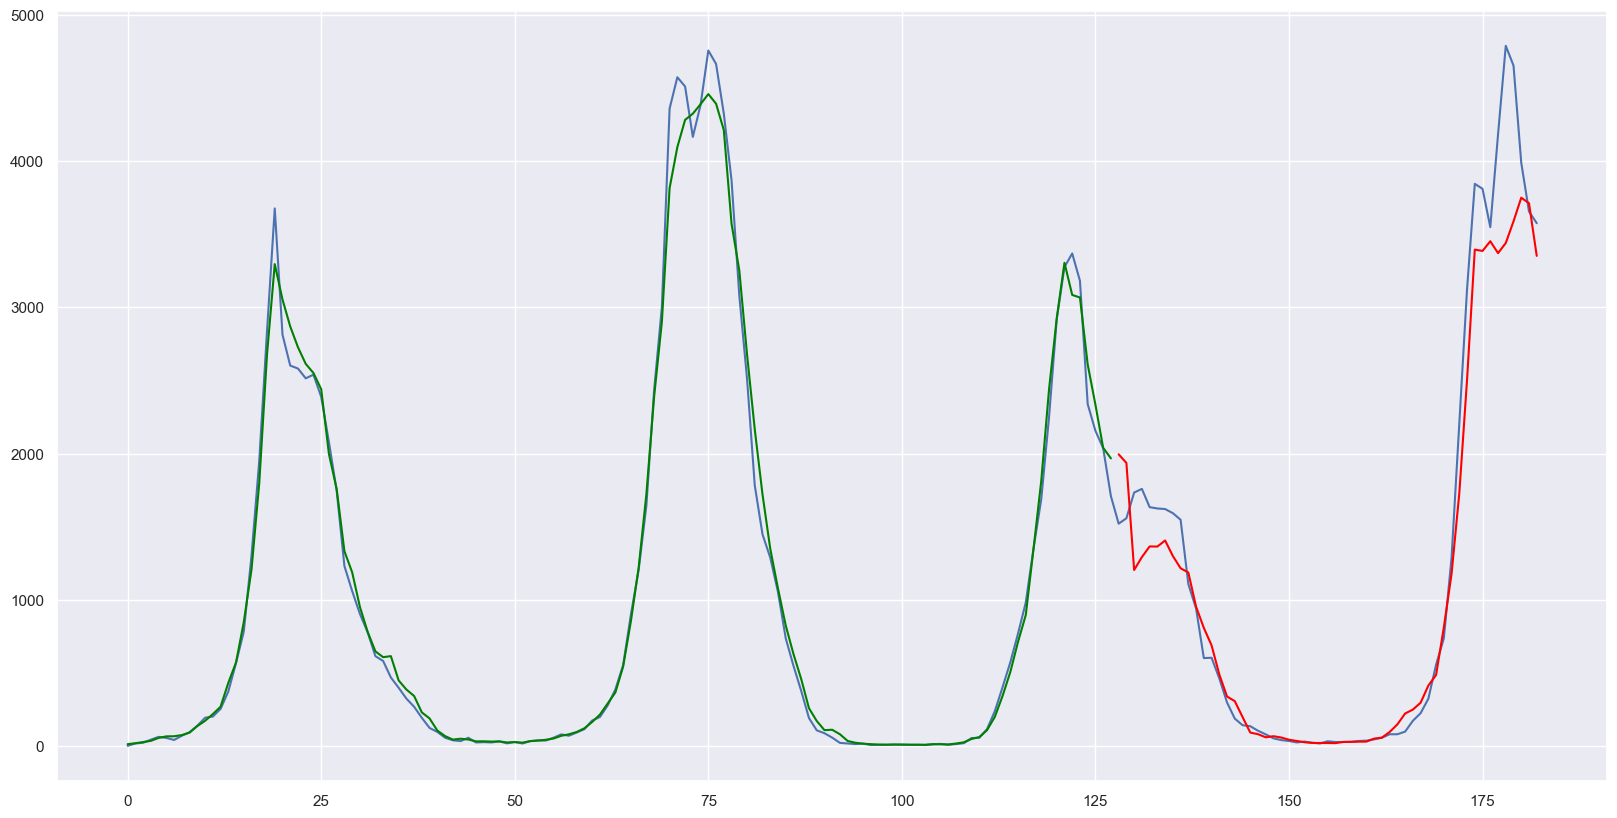

In [78]:
# plot
plt.plot(df_time_features_pre_COVID.index, df_time_features_pre_COVID['y1'].values)
plt.plot(df_time_features_pre_COVID.index[:train_size], preds_train_df['y1'], color='green')
plt.plot(df_time_features_pre_COVID.index[train_size:], preds_test_df['y1'], color='red')

In [79]:
preds_test_df.head()

y1           y2           y3           y4
0  1995.244833  1800.942476  1674.043786  1618.090762
1  1936.605167  1758.349833  1588.344500  1513.394833
2  1204.124833   997.606500   826.187833   680.120500
3  1292.530000  1093.822083   925.302750   773.824917
4  1365.376167  1169.777167  1007.597833   856.567500

In [80]:
test_y.head()

y1      y2      y3      y4
128  1521.0  1558.0  1734.0  1759.0
129  1558.0  1734.0  1759.0  1634.0
130  1734.0  1759.0  1634.0  1625.0
131  1759.0  1634.0  1625.0  1621.0
132  1634.0  1625.0  1621.0  1593.0

In [81]:
# define the evaluation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=2022)
# evaluate the model and collect the scores
n_scores = cross_val_score(model, train_X, train_y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
# force the scores to be positive
n_scores = absolute(n_scores)
# summarize performance
print('RMSE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

RMSE: 356.046 (160.867)


In [82]:
MSE_train = round(mean_squared_error(train_y, preds_train),3)
RMSE_train = round(mean_squared_error(train_y, preds_train, squared=False),3)
MAE_train = round(mean_absolute_error(train_y, preds_train),3)

print(f'MSE_train: {MSE_train}')
print(f'RMSE_train: {RMSE_train}')
print(f'MAE_train: {MAE_train}')

MSE_test = round(mean_squared_error(test_y, preds_test),3)
RMSE_test = round(mean_squared_error(test_y, preds_test, squared=False),3)
MAE_test = round(mean_absolute_error(test_y, preds_test),3)

print(f'MSE_test: {MSE_test}')
print(f'RMSE_test: {RMSE_test}')
print(f'MAE_test: {MAE_test}')


MSE_train: 24143.23
RMSE_train: 153.92
MAE_train: 87.174
MSE_test: 231656.769
RMSE_test: 470.626
MAE_test: 279.261


# SVR - Direct Multioutput Regression

In [48]:
# define base model
model = LinearSVR()
# define the direct multioutput wrapper model
wrapper = MultiOutputRegressor(model)

In [49]:
# define the evaluation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=2022)
# evaluate the model and collect the scores
n_scores = cross_val_score(wrapper, train_X, train_y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
# force the scores to be positive
n_scores = absolute(n_scores)
# summarize performance
print('RMSE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

RMSE: 1539.278 (445.027)


In [52]:
# fit the model on the whole dataset
wrapper.fit(train_X, train_y)

MultiOutputRegressor(estimator=LinearSVR())

In [53]:
preds_test = wrapper.predict(test_X)
preds_test_df = pd.DataFrame(preds_test,columns=test_y.columns)
preds_train = wrapper.predict(train_X)
preds_train_df = pd.DataFrame(preds_train,columns=train_y.columns)

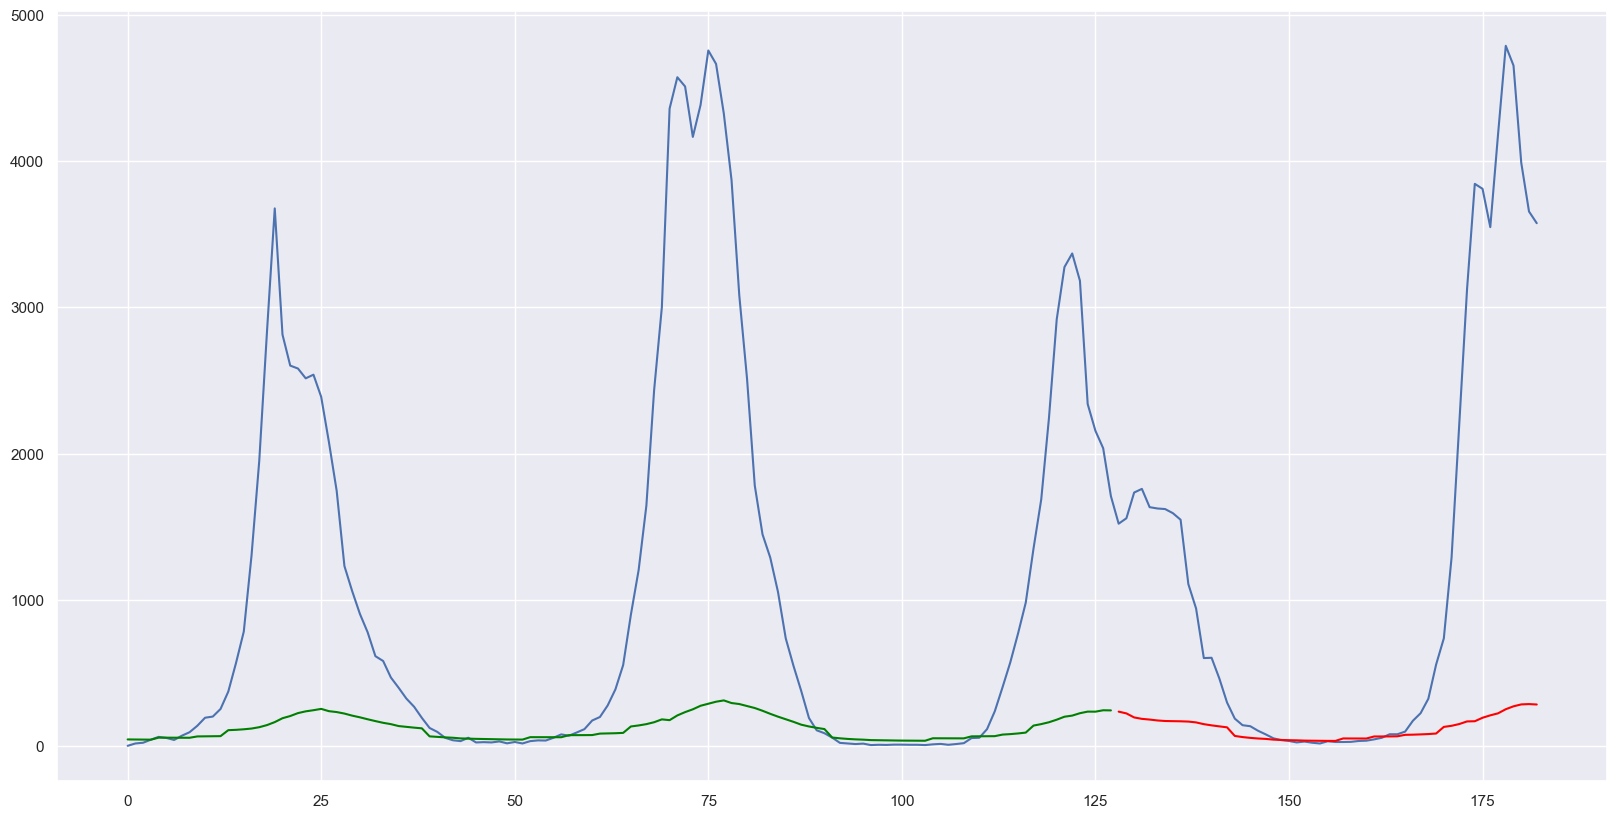

In [54]:
# plot
plt.plot(df_time_features_pre_COVID.index, df_time_features_pre_COVID['y1'].values)
plt.plot(df_time_features_pre_COVID.index[:train_size], preds_train_df['y1'], color='green')
plt.plot(df_time_features_pre_COVID.index[train_size:], preds_test_df['y1'], color='red')

In [55]:
preds_test_df.head()

y1          y2          y3          y4
0  235.737795  235.887211  230.447382  224.905405
1  223.543904  223.881991  218.765915  213.560478
2  196.060792  194.648161  185.951573  177.198985
3  186.247204  185.094737  176.832653  168.533242
4  181.514642  180.470770  172.376753  164.255446

In [56]:
test_y.head()

y1      y2      y3      y4
128  1521.0  1558.0  1734.0  1759.0
129  1558.0  1734.0  1759.0  1634.0
130  1734.0  1759.0  1634.0  1625.0
131  1759.0  1634.0  1625.0  1621.0
132  1634.0  1625.0  1621.0  1593.0

In [57]:
MSE_train = round(mean_squared_error(train_y, preds_train),3)
RMSE_train = round(mean_squared_error(train_y, preds_train, squared=False),3)
MAE_train = round(mean_absolute_error(train_y, preds_train),3)

print(f'MSE_train: {MSE_train}')
print(f'RMSE_train: {RMSE_train}')
print(f'MAE_train: {MAE_train}')

MSE_test = round(mean_squared_error(test_y, preds_test),3)
RMSE_test = round(mean_squared_error(test_y, preds_test, squared=False),3)
MAE_test = round(mean_absolute_error(test_y, preds_test),3)

print(f'MSE_test: {MSE_test}')
print(f'RMSE_test: {RMSE_test}')
print(f'MAE_test: {MAE_test}')


MSE_train: 2531152.715
RMSE_train: 1590.906
MAE_train: 950.955
MSE_test: 3185788.344
RMSE_test: 1784.529
MAE_test: 1097.891


# SVR - Chained Multioutput Regression

In [59]:
# define base model
model = LinearSVR()
# define the direct multioutput wrapper model
wrapper = RegressorChain(model)

In [60]:
# define the evaluation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=2022)
# evaluate the model and collect the scores
n_scores = cross_val_score(wrapper, train_X, train_y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
# force the scores to be positive
n_scores = absolute(n_scores)
# summarize performance
print('RMSE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

RMSE: 1524.007 (435.862)


In [61]:
# fit the model on the whole dataset
wrapper.fit(train_X, train_y)

C:\Users\User\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


RegressorChain(base_estimator=LinearSVR())

In [62]:
preds_test = wrapper.predict(test_X)
preds_test_df = pd.DataFrame(preds_test,columns=test_y.columns)
preds_train = wrapper.predict(train_X)
preds_train_df = pd.DataFrame(preds_train,columns=train_y.columns)

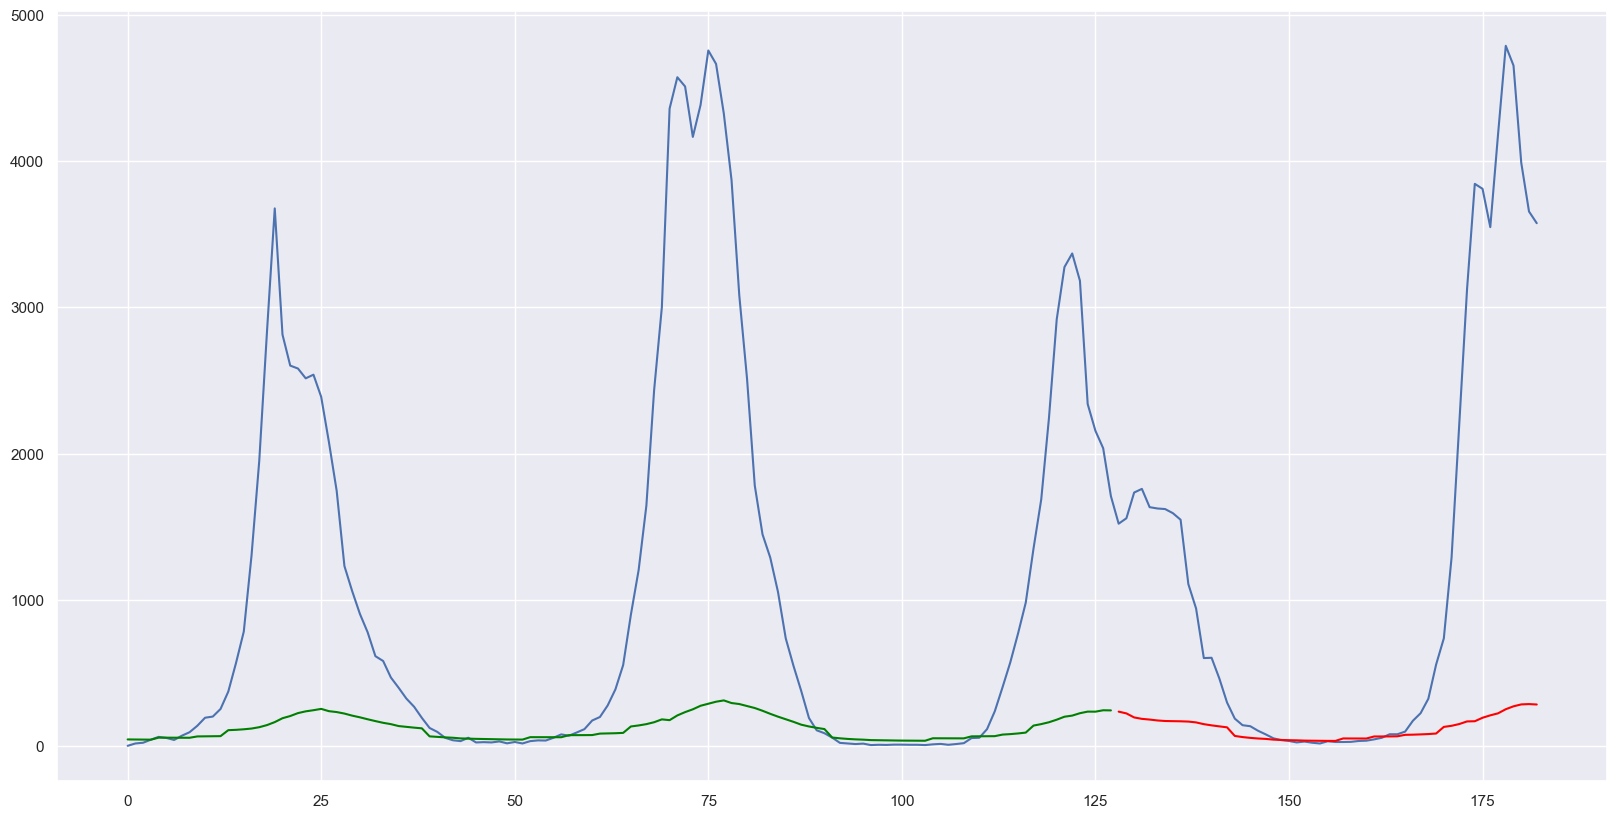

In [63]:
# plot
plt.plot(df_time_features_pre_COVID.index, df_time_features_pre_COVID['y1'].values)
plt.plot(df_time_features_pre_COVID.index[:train_size], preds_train_df['y1'], color='green')
plt.plot(df_time_features_pre_COVID.index[train_size:], preds_test_df['y1'], color='red')

In [64]:
preds_test_df.head()

y1          y2          y3          y4
0  235.737795  311.655374  393.590236  492.847908
1  223.543904  296.226583  374.669255  469.839389
2  196.060792  244.846603  299.347037  367.296005
3  186.247204  233.075568  285.360865  350.612844
4  181.514642  227.332492  278.495290  342.402963

In [65]:
test_y.head()

y1      y2      y3      y4
128  1521.0  1558.0  1734.0  1759.0
129  1558.0  1734.0  1759.0  1634.0
130  1734.0  1759.0  1634.0  1625.0
131  1759.0  1634.0  1625.0  1621.0
132  1634.0  1625.0  1621.0  1593.0

In [66]:
MSE_train = round(mean_squared_error(train_y, preds_train),3)
RMSE_train = round(mean_squared_error(train_y, preds_train, squared=False),3)
MAE_train = round(mean_absolute_error(train_y, preds_train),3)

print(f'MSE_train: {MSE_train}')
print(f'RMSE_train: {RMSE_train}')
print(f'MAE_train: {MAE_train}')

MSE_test = round(mean_squared_error(test_y, preds_test),3)
RMSE_test = round(mean_squared_error(test_y, preds_test, squared=False),3)
MAE_test = round(mean_absolute_error(test_y, preds_test),3)

print(f'MSE_test: {MSE_test}')
print(f'RMSE_test: {RMSE_test}')
print(f'MAE_test: {MAE_test}')


MSE_train: 2323814.439
RMSE_train: 1523.91
MAE_train: 905.952
MSE_test: 2948083.346
RMSE_test: 1716.847
MAE_test: 1050.353
